# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.9921354285998945 -2.5674106007345054
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [28]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    rate = tf.placeholder(tf.float32, [], name='rate')
    return states, actions, targetQs, rewards, rate

In [29]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [30]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [31]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [32]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [18]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rewards, rate):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    Qs_labels = rewards[:-1] + (0.99 * targetQs[1:])
    g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * Qs_labels)
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
                                                                     labels=rate * tf.ones_like(Qs_logits)))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits[:-1], shape=[-1]),
                                                                     labels=tf.nn.sigmoid(Qs_labels)))
    d_loss = d_lossR + d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [19]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [20]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rewards, self.rate = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, rewards=self.rewards, rate=self.rate) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [21]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [22]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [23]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [24]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [25]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            batch.append([state, action, Q_logits, reward])
            total_reward += reward
            state = next_state
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points: 0-1
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        rewards = np.array([each[3] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.targetQs: targetQs.reshape([-1]),
                                                                       model.rewards: rewards, 
                                                                       model.rate: rate})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:10.0000 rate:0.0200 gloss:0.5138 dloss:1.3652 dlossR:0.6568 dlossQ:0.7083
Episode:1 meanR:9.5000 rate:0.0180 gloss:0.4711 dloss:1.3485 dlossR:0.6292 dlossQ:0.7193
Episode:2 meanR:9.6667 rate:0.0200 gloss:0.3948 dloss:1.3271 dlossR:0.5938 dlossQ:0.7333
Episode:3 meanR:9.5000 rate:0.0180 gloss:0.3471 dloss:1.3092 dlossR:0.5670 dlossQ:0.7422
Episode:4 meanR:9.2000 rate:0.0160 gloss:0.3315 dloss:1.2991 dlossR:0.5532 dlossQ:0.7459
Episode:5 meanR:9.1667 rate:0.0180 gloss:0.2696 dloss:1.2766 dlossR:0.5212 dlossQ:0.7554
Episode:6 meanR:9.1429 rate:0.0180 gloss:0.2298 dloss:1.2582 dlossR:0.4976 dlossQ:0.7606
Episode:7 meanR:9.0000 rate:0.0160 gloss:0.2199 dloss:1.2518 dlossR:0.4913 dlossQ:0.7604
Episode:8 meanR:8.8889 rate:0.0160 gloss:0.1904 dloss:1.2351 dlossR:0.4719 dlossQ:0.7632
Episode:9 meanR:8.9000 rate:0.0180 gloss:0.1279 dloss:1.1958 dlossR:0.4284 dlossQ:0.7674
Episode:10 meanR:8.9091 rate:0.0180 gloss:0.1098 dloss:1.1782 dlossR:0.4129 dlossQ:0.7654
Episode:11 meanR:9.

Episode:92 meanR:30.0000 rate:0.0580 gloss:0.0693 dloss:1.2230 dlossR:0.4097 dlossQ:0.8133
Episode:93 meanR:29.9468 rate:0.0500 gloss:0.0599 dloss:1.2141 dlossR:0.4002 dlossQ:0.8139
Episode:94 meanR:29.9158 rate:0.0540 gloss:0.0583 dloss:1.2160 dlossR:0.4022 dlossQ:0.8137
Episode:95 meanR:29.8958 rate:0.0560 gloss:0.0497 dloss:1.2126 dlossR:0.3980 dlossQ:0.8146
Episode:96 meanR:29.8866 rate:0.0580 gloss:0.0410 dloss:1.2105 dlossR:0.3960 dlossQ:0.8145
Episode:97 meanR:29.7857 rate:0.0400 gloss:0.0310 dloss:1.1895 dlossR:0.3761 dlossQ:0.8133
Episode:98 meanR:29.7172 rate:0.0460 gloss:0.0302 dloss:1.1958 dlossR:0.3805 dlossQ:0.8153
Episode:99 meanR:29.7100 rate:0.0580 gloss:0.0286 dloss:1.2040 dlossR:0.3890 dlossQ:0.8150
Episode:100 meanR:29.8800 rate:0.0540 gloss:0.0309 dloss:1.2027 dlossR:0.3882 dlossQ:0.8146
Episode:101 meanR:30.0800 rate:0.0580 gloss:0.0239 dloss:1.2018 dlossR:0.3865 dlossQ:0.8153
Episode:102 meanR:30.2400 rate:0.0520 gloss:0.0230 dloss:1.1960 dlossR:0.3810 dlossQ:0.8

Episode:185 meanR:26.0000 rate:0.0700 gloss:0.0377 dloss:1.2450 dlossR:0.4353 dlossQ:0.8097
Episode:186 meanR:25.9400 rate:0.0540 gloss:0.0376 dloss:1.2281 dlossR:0.4185 dlossQ:0.8096
Episode:187 meanR:26.0000 rate:0.0660 gloss:0.0371 dloss:1.2390 dlossR:0.4297 dlossQ:0.8094
Episode:188 meanR:26.3600 rate:0.1160 gloss:0.0435 dloss:1.2869 dlossR:0.4795 dlossQ:0.8073
Episode:189 meanR:26.4300 rate:0.0720 gloss:0.0377 dloss:1.2472 dlossR:0.4390 dlossQ:0.8082
Episode:190 meanR:26.4800 rate:0.0560 gloss:0.0403 dloss:1.2329 dlossR:0.4249 dlossQ:0.8080
Episode:191 meanR:26.6200 rate:0.0700 gloss:0.0437 dloss:1.2523 dlossR:0.4464 dlossQ:0.8059
Episode:192 meanR:27.2700 rate:0.1880 gloss:0.0777 dloss:1.3452 dlossR:0.5445 dlossQ:0.8007
Episode:193 meanR:28.2300 rate:0.2420 gloss:0.0900 dloss:1.3801 dlossR:0.5839 dlossQ:0.7962
Episode:194 meanR:29.0300 rate:0.2140 gloss:0.1039 dloss:1.3679 dlossR:0.5799 dlossQ:0.7880
Episode:195 meanR:29.6700 rate:0.1840 gloss:0.0785 dloss:1.3572 dlossR:0.5738 dl

Episode:277 meanR:79.3400 rate:0.3260 gloss:0.0243 dloss:1.4306 dlossR:0.6426 dlossQ:0.7880
Episode:278 meanR:79.6200 rate:0.1100 gloss:0.0150 dloss:1.3168 dlossR:0.5298 dlossQ:0.7870
Episode:279 meanR:79.6000 rate:0.0740 gloss:0.0187 dloss:1.3004 dlossR:0.5148 dlossQ:0.7856
Episode:280 meanR:79.7700 rate:0.0860 gloss:0.0147 dloss:1.3040 dlossR:0.5168 dlossQ:0.7873
Episode:281 meanR:79.7500 rate:0.0800 gloss:0.0179 dloss:1.3061 dlossR:0.5196 dlossQ:0.7865
Episode:282 meanR:79.8900 rate:0.0920 gloss:0.0144 dloss:1.3082 dlossR:0.5187 dlossQ:0.7894
Episode:283 meanR:80.0400 rate:0.0820 gloss:0.0146 dloss:1.3010 dlossR:0.5121 dlossQ:0.7890
Episode:284 meanR:80.3600 rate:0.1560 gloss:0.0300 dloss:1.3478 dlossR:0.5597 dlossQ:0.7881
Episode:285 meanR:80.3800 rate:0.0740 gloss:0.0191 dloss:1.2944 dlossR:0.5041 dlossQ:0.7903
Episode:286 meanR:80.5000 rate:0.0780 gloss:0.0159 dloss:1.2958 dlossR:0.5057 dlossQ:0.7902
Episode:287 meanR:80.4900 rate:0.0640 gloss:0.0183 dloss:1.2922 dlossR:0.5021 dl

Episode:370 meanR:43.9100 rate:0.0520 gloss:0.0074 dloss:1.2320 dlossR:0.4244 dlossQ:0.8076
Episode:371 meanR:43.4500 rate:0.0800 gloss:0.0184 dloss:1.2637 dlossR:0.4590 dlossQ:0.8047
Episode:372 meanR:43.2600 rate:0.0580 gloss:0.0040 dloss:1.2401 dlossR:0.4315 dlossQ:0.8086
Episode:373 meanR:43.1500 rate:0.0880 gloss:0.0261 dloss:1.2700 dlossR:0.4651 dlossQ:0.8048
Episode:374 meanR:43.0100 rate:0.0520 gloss:0.0124 dloss:1.2262 dlossR:0.4173 dlossQ:0.8089
Episode:375 meanR:43.0400 rate:0.0760 gloss:0.0271 dloss:1.2559 dlossR:0.4497 dlossQ:0.8062
Episode:376 meanR:43.0000 rate:0.0840 gloss:0.0246 dloss:1.2690 dlossR:0.4651 dlossQ:0.8039
Episode:377 meanR:41.7400 rate:0.0740 gloss:0.0145 dloss:1.2574 dlossR:0.4513 dlossQ:0.8062
Episode:378 meanR:41.5300 rate:0.0680 gloss:0.0168 dloss:1.2413 dlossR:0.4324 dlossQ:0.8089
Episode:379 meanR:41.6000 rate:0.0880 gloss:0.0264 dloss:1.2650 dlossR:0.4579 dlossQ:0.8070
Episode:380 meanR:41.5100 rate:0.0680 gloss:0.0171 dloss:1.2518 dlossR:0.4464 dl

Episode:459 meanR:27.3200 rate:0.0540 gloss:-0.0012 dloss:1.1868 dlossR:0.3772 dlossQ:0.8096
Episode:460 meanR:26.9900 rate:0.0420 gloss:0.0006 dloss:1.1723 dlossR:0.3631 dlossQ:0.8092
Episode:461 meanR:26.9800 rate:0.0500 gloss:0.0019 dloss:1.1902 dlossR:0.3792 dlossQ:0.8109
Episode:462 meanR:26.8700 rate:0.0540 gloss:0.0025 dloss:1.1940 dlossR:0.3830 dlossQ:0.8109
Episode:463 meanR:26.8100 rate:0.0540 gloss:0.0004 dloss:1.2068 dlossR:0.3962 dlossQ:0.8105
Episode:464 meanR:26.6400 rate:0.0600 gloss:0.0018 dloss:1.2173 dlossR:0.4069 dlossQ:0.8104
Episode:465 meanR:26.3900 rate:0.0340 gloss:0.0003 dloss:1.1589 dlossR:0.3512 dlossQ:0.8078
Episode:466 meanR:26.3000 rate:0.0540 gloss:-0.0001 dloss:1.1907 dlossR:0.3813 dlossQ:0.8094
Episode:467 meanR:26.1700 rate:0.0560 gloss:-0.0001 dloss:1.1957 dlossR:0.3844 dlossQ:0.8113
Episode:468 meanR:26.0700 rate:0.0460 gloss:0.0000 dloss:1.1743 dlossR:0.3653 dlossQ:0.8091
Episode:469 meanR:25.8300 rate:0.0480 gloss:-0.0019 dloss:1.1884 dlossR:0.376

Episode:551 meanR:22.9000 rate:0.0560 gloss:-0.0016 dloss:1.1902 dlossR:0.3809 dlossQ:0.8093
Episode:552 meanR:22.9100 rate:0.0380 gloss:-0.0005 dloss:1.1485 dlossR:0.3434 dlossQ:0.8051
Episode:553 meanR:22.9600 rate:0.0620 gloss:0.0031 dloss:1.2273 dlossR:0.4201 dlossQ:0.8072
Episode:554 meanR:23.0000 rate:0.0560 gloss:0.0002 dloss:1.2038 dlossR:0.3950 dlossQ:0.8087
Episode:555 meanR:23.1300 rate:0.0600 gloss:-0.0009 dloss:1.2109 dlossR:0.4011 dlossQ:0.8098
Episode:556 meanR:23.1100 rate:0.0440 gloss:0.0017 dloss:1.1877 dlossR:0.3793 dlossQ:0.8084
Episode:557 meanR:23.1200 rate:0.0440 gloss:-0.0026 dloss:1.1673 dlossR:0.3593 dlossQ:0.8081
Episode:558 meanR:23.1800 rate:0.0520 gloss:0.0027 dloss:1.1972 dlossR:0.3881 dlossQ:0.8091
Episode:559 meanR:23.1000 rate:0.0380 gloss:0.0015 dloss:1.1705 dlossR:0.3614 dlossQ:0.8091
Episode:560 meanR:23.2200 rate:0.0660 gloss:0.0006 dloss:1.2123 dlossR:0.4029 dlossQ:0.8095
Episode:561 meanR:23.1800 rate:0.0420 gloss:-0.0006 dloss:1.1609 dlossR:0.35

Episode:645 meanR:23.6100 rate:0.0400 gloss:-0.0009 dloss:1.1740 dlossR:0.3664 dlossQ:0.8076
Episode:646 meanR:23.6400 rate:0.0440 gloss:-0.0004 dloss:1.1761 dlossR:0.3684 dlossQ:0.8077
Episode:647 meanR:23.5200 rate:0.0380 gloss:-0.0021 dloss:1.1387 dlossR:0.3342 dlossQ:0.8045
Episode:648 meanR:23.4000 rate:0.0360 gloss:-0.0039 dloss:1.1424 dlossR:0.3362 dlossQ:0.8062
Episode:649 meanR:23.4000 rate:0.0360 gloss:-0.0053 dloss:1.1433 dlossR:0.3364 dlossQ:0.8068
Episode:650 meanR:23.3300 rate:0.0360 gloss:-0.0049 dloss:1.1433 dlossR:0.3330 dlossQ:0.8103
Episode:651 meanR:23.2900 rate:0.0480 gloss:-0.0126 dloss:1.1589 dlossR:0.3501 dlossQ:0.8088
Episode:652 meanR:23.3000 rate:0.0400 gloss:-0.0004 dloss:1.1746 dlossR:0.3613 dlossQ:0.8133
Episode:653 meanR:23.2300 rate:0.0480 gloss:-0.0008 dloss:1.1875 dlossR:0.3763 dlossQ:0.8112
Episode:654 meanR:23.1700 rate:0.0440 gloss:-0.0036 dloss:1.1754 dlossR:0.3659 dlossQ:0.8095
Episode:655 meanR:23.0500 rate:0.0360 gloss:-0.0051 dloss:1.1569 dloss

Episode:737 meanR:22.1800 rate:0.0380 gloss:-0.0032 dloss:1.1565 dlossR:0.3525 dlossQ:0.8041
Episode:738 meanR:22.2100 rate:0.0580 gloss:-0.0033 dloss:1.1985 dlossR:0.3909 dlossQ:0.8076
Episode:739 meanR:22.1900 rate:0.0440 gloss:-0.0057 dloss:1.1747 dlossR:0.3660 dlossQ:0.8087
Episode:740 meanR:22.1000 rate:0.0400 gloss:-0.0010 dloss:1.1593 dlossR:0.3525 dlossQ:0.8068
Episode:741 meanR:22.1400 rate:0.0520 gloss:-0.0016 dloss:1.1836 dlossR:0.3738 dlossQ:0.8098
Episode:742 meanR:22.1700 rate:0.0500 gloss:-0.0010 dloss:1.1725 dlossR:0.3654 dlossQ:0.8071
Episode:743 meanR:22.0800 rate:0.0380 gloss:-0.0049 dloss:1.1551 dlossR:0.3488 dlossQ:0.8063
Episode:744 meanR:22.1800 rate:0.0520 gloss:-0.0059 dloss:1.1771 dlossR:0.3693 dlossQ:0.8078
Episode:745 meanR:22.1900 rate:0.0420 gloss:-0.0021 dloss:1.1498 dlossR:0.3461 dlossQ:0.8037
Episode:746 meanR:22.2300 rate:0.0520 gloss:-0.0079 dloss:1.1831 dlossR:0.3741 dlossQ:0.8090
Episode:747 meanR:22.3000 rate:0.0520 gloss:-0.0061 dloss:1.1789 dloss

Episode:831 meanR:23.6900 rate:0.0700 gloss:0.0025 dloss:1.2323 dlossR:0.4248 dlossQ:0.8075
Episode:832 meanR:23.6400 rate:0.0440 gloss:0.0016 dloss:1.1709 dlossR:0.3631 dlossQ:0.8078
Episode:833 meanR:23.6300 rate:0.0420 gloss:0.0032 dloss:1.1653 dlossR:0.3591 dlossQ:0.8063
Episode:834 meanR:23.7200 rate:0.0640 gloss:0.0038 dloss:1.2267 dlossR:0.4193 dlossQ:0.8074
Episode:835 meanR:23.7200 rate:0.0600 gloss:0.0072 dloss:1.2065 dlossR:0.3996 dlossQ:0.8069
Episode:836 meanR:23.8300 rate:0.0580 gloss:0.0048 dloss:1.2098 dlossR:0.4018 dlossQ:0.8080
Episode:837 meanR:23.9400 rate:0.0600 gloss:0.0059 dloss:1.2036 dlossR:0.3969 dlossQ:0.8068
Episode:838 meanR:23.9700 rate:0.0640 gloss:0.0053 dloss:1.2213 dlossR:0.4138 dlossQ:0.8074
Episode:839 meanR:23.9800 rate:0.0460 gloss:0.0061 dloss:1.1868 dlossR:0.3796 dlossQ:0.8072
Episode:840 meanR:24.0200 rate:0.0480 gloss:0.0081 dloss:1.1872 dlossR:0.3806 dlossQ:0.8065
Episode:841 meanR:24.0000 rate:0.0480 gloss:0.0054 dloss:1.1897 dlossR:0.3812 dl

Episode:924 meanR:29.5900 rate:0.0920 gloss:0.0230 dloss:1.2531 dlossR:0.4460 dlossQ:0.8071
Episode:925 meanR:29.8200 rate:0.0880 gloss:0.0156 dloss:1.2554 dlossR:0.4486 dlossQ:0.8068
Episode:926 meanR:29.8800 rate:0.0680 gloss:0.0037 dloss:1.2225 dlossR:0.4137 dlossQ:0.8088
Episode:927 meanR:30.1100 rate:0.0920 gloss:0.0113 dloss:1.2489 dlossR:0.4407 dlossQ:0.8082
Episode:928 meanR:30.1500 rate:0.0520 gloss:0.0027 dloss:1.1935 dlossR:0.3851 dlossQ:0.8085
Episode:929 meanR:30.1100 rate:0.0580 gloss:0.0042 dloss:1.2069 dlossR:0.4005 dlossQ:0.8063
Episode:930 meanR:30.4500 rate:0.1100 gloss:0.0046 dloss:1.2734 dlossR:0.4683 dlossQ:0.8051
Episode:931 meanR:30.5800 rate:0.0960 gloss:0.0027 dloss:1.2631 dlossR:0.4574 dlossQ:0.8057
Episode:932 meanR:30.7000 rate:0.0680 gloss:0.0035 dloss:1.2369 dlossR:0.4304 dlossQ:0.8065
Episode:933 meanR:30.8100 rate:0.0640 gloss:0.0039 dloss:1.2269 dlossR:0.4201 dlossQ:0.8067
Episode:934 meanR:30.8500 rate:0.0720 gloss:0.0034 dloss:1.2437 dlossR:0.4383 dl

Episode:1014 meanR:54.5100 rate:0.1220 gloss:0.0040 dloss:1.3137 dlossR:0.5237 dlossQ:0.7901
Episode:1015 meanR:54.9300 rate:0.1520 gloss:0.0190 dloss:1.3377 dlossR:0.5568 dlossQ:0.7808
Episode:1016 meanR:54.9400 rate:0.0880 gloss:0.0136 dloss:1.2982 dlossR:0.5128 dlossQ:0.7854
Episode:1017 meanR:55.2900 rate:0.1340 gloss:0.0262 dloss:1.3314 dlossR:0.5547 dlossQ:0.7767
Episode:1018 meanR:55.7900 rate:0.1740 gloss:0.0118 dloss:1.3501 dlossR:0.5740 dlossQ:0.7760
Episode:1019 meanR:55.8500 rate:0.0700 gloss:0.0145 dloss:1.2814 dlossR:0.4917 dlossQ:0.7897
Episode:1020 meanR:55.8800 rate:0.0900 gloss:0.0093 dloss:1.3022 dlossR:0.5192 dlossQ:0.7830
Episode:1021 meanR:56.1700 rate:0.1140 gloss:0.0052 dloss:1.3124 dlossR:0.5256 dlossQ:0.7868
Episode:1022 meanR:56.5800 rate:0.1460 gloss:0.0029 dloss:1.3301 dlossR:0.5434 dlossQ:0.7867
Episode:1023 meanR:56.9200 rate:0.1240 gloss:0.0034 dloss:1.3131 dlossR:0.5197 dlossQ:0.7934
Episode:1024 meanR:56.8900 rate:0.0860 gloss:0.0043 dloss:1.2769 dloss

Episode:1104 meanR:51.0100 rate:0.1440 gloss:0.0057 dloss:1.3115 dlossR:0.5063 dlossQ:0.8052
Episode:1105 meanR:50.9800 rate:0.0640 gloss:0.0023 dloss:1.2400 dlossR:0.4324 dlossQ:0.8076
Episode:1106 meanR:50.7500 rate:0.0620 gloss:0.0039 dloss:1.2382 dlossR:0.4306 dlossQ:0.8076
Episode:1107 meanR:50.6900 rate:0.0580 gloss:0.0010 dloss:1.2307 dlossR:0.4210 dlossQ:0.8097
Episode:1108 meanR:50.8500 rate:0.1260 gloss:0.0016 dloss:1.2978 dlossR:0.4927 dlossQ:0.8051
Episode:1109 meanR:50.0200 rate:0.0720 gloss:0.0046 dloss:1.2482 dlossR:0.4413 dlossQ:0.8069
Episode:1110 meanR:49.7700 rate:0.0560 gloss:0.0021 dloss:1.2220 dlossR:0.4138 dlossQ:0.8082
Episode:1111 meanR:49.2500 rate:0.0560 gloss:0.0035 dloss:1.2353 dlossR:0.4297 dlossQ:0.8056
Episode:1112 meanR:49.0900 rate:0.0820 gloss:0.0018 dloss:1.2652 dlossR:0.4625 dlossQ:0.8027
Episode:1113 meanR:49.1200 rate:0.0840 gloss:0.0036 dloss:1.2608 dlossR:0.4554 dlossQ:0.8054
Episode:1114 meanR:48.8100 rate:0.0600 gloss:0.0019 dloss:1.2292 dloss

Episode:1193 meanR:45.8400 rate:0.0840 gloss:0.0047 dloss:1.2722 dlossR:0.4700 dlossQ:0.8021
Episode:1194 meanR:48.8500 rate:0.6780 gloss:0.0201 dloss:1.4704 dlossR:0.7381 dlossQ:0.7323
Episode:1195 meanR:48.8200 rate:0.0780 gloss:0.0167 dloss:1.3056 dlossR:0.5259 dlossQ:0.7797
Episode:1196 meanR:48.6300 rate:0.1320 gloss:0.0087 dloss:1.3556 dlossR:0.6055 dlossQ:0.7501
Episode:1197 meanR:48.5000 rate:0.0900 gloss:0.0250 dloss:1.3492 dlossR:0.5955 dlossQ:0.7537
Episode:1198 meanR:48.7100 rate:0.1100 gloss:0.0128 dloss:1.3421 dlossR:0.5774 dlossQ:0.7647
Episode:1199 meanR:48.5700 rate:0.0920 gloss:0.0084 dloss:1.3296 dlossR:0.5436 dlossQ:0.7860
Episode:1200 meanR:48.6300 rate:0.0940 gloss:0.0041 dloss:1.3217 dlossR:0.5243 dlossQ:0.7974
Episode:1201 meanR:48.7800 rate:0.0860 gloss:0.0051 dloss:1.2959 dlossR:0.5018 dlossQ:0.7941
Episode:1202 meanR:48.8500 rate:0.0860 gloss:0.0031 dloss:1.2837 dlossR:0.4917 dlossQ:0.7920
Episode:1203 meanR:49.5200 rate:0.2400 gloss:0.0120 dloss:1.3840 dloss

Episode:1284 meanR:62.4200 rate:0.1400 gloss:0.0057 dloss:1.3230 dlossR:0.5340 dlossQ:0.7889
Episode:1285 meanR:62.4300 rate:0.0740 gloss:0.0038 dloss:1.2819 dlossR:0.4918 dlossQ:0.7902
Episode:1286 meanR:62.6900 rate:0.1420 gloss:0.0018 dloss:1.3343 dlossR:0.5575 dlossQ:0.7768
Episode:1287 meanR:62.6400 rate:0.0800 gloss:0.0040 dloss:1.2868 dlossR:0.4983 dlossQ:0.7885
Episode:1288 meanR:61.9800 rate:0.0860 gloss:0.0074 dloss:1.2860 dlossR:0.4951 dlossQ:0.7908
Episode:1289 meanR:61.8300 rate:0.0720 gloss:0.0120 dloss:1.2817 dlossR:0.4919 dlossQ:0.7898
Episode:1290 meanR:61.5600 rate:0.0780 gloss:0.0040 dloss:1.2765 dlossR:0.4797 dlossQ:0.7969
Episode:1291 meanR:61.6300 rate:0.0820 gloss:0.0054 dloss:1.2820 dlossR:0.4864 dlossQ:0.7956
Episode:1292 meanR:61.7500 rate:0.0900 gloss:0.0048 dloss:1.2800 dlossR:0.4812 dlossQ:0.7988
Episode:1293 meanR:61.7300 rate:0.0800 gloss:0.0024 dloss:1.2672 dlossR:0.4661 dlossQ:0.8012
Episode:1294 meanR:58.7100 rate:0.0740 gloss:0.0031 dloss:1.2627 dloss

Episode:1375 meanR:59.0700 rate:0.2540 gloss:0.0108 dloss:1.3857 dlossR:0.6292 dlossQ:0.7565
Episode:1376 meanR:59.5100 rate:0.1920 gloss:0.0070 dloss:1.3604 dlossR:0.5884 dlossQ:0.7720
Episode:1377 meanR:59.4800 rate:0.0880 gloss:0.0075 dloss:1.3079 dlossR:0.5296 dlossQ:0.7783
Episode:1378 meanR:59.4500 rate:0.0980 gloss:0.0084 dloss:1.3107 dlossR:0.5319 dlossQ:0.7788
Episode:1379 meanR:59.2700 rate:0.0820 gloss:0.0127 dloss:1.2902 dlossR:0.5017 dlossQ:0.7885
Episode:1380 meanR:59.3800 rate:0.0900 gloss:0.0056 dloss:1.2934 dlossR:0.5035 dlossQ:0.7900
Episode:1381 meanR:59.4600 rate:0.1020 gloss:0.0050 dloss:1.3035 dlossR:0.5137 dlossQ:0.7898
Episode:1382 meanR:59.4700 rate:0.1160 gloss:0.0065 dloss:1.3137 dlossR:0.5263 dlossQ:0.7874
Episode:1383 meanR:58.9500 rate:0.1120 gloss:0.0072 dloss:1.3021 dlossR:0.5099 dlossQ:0.7922
Episode:1384 meanR:58.8000 rate:0.1100 gloss:0.0063 dloss:1.2979 dlossR:0.5052 dlossQ:0.7927
Episode:1385 meanR:58.9100 rate:0.0960 gloss:0.0069 dloss:1.2984 dloss

Episode:1464 meanR:56.6800 rate:0.1280 gloss:0.0120 dloss:1.3059 dlossR:0.5063 dlossQ:0.7995
Episode:1465 meanR:56.8000 rate:0.1300 gloss:0.0028 dloss:1.3067 dlossR:0.5078 dlossQ:0.7989
Episode:1466 meanR:56.6800 rate:0.0740 gloss:0.0016 dloss:1.2684 dlossR:0.4694 dlossQ:0.7990
Episode:1467 meanR:56.6400 rate:0.1000 gloss:0.0038 dloss:1.2892 dlossR:0.4915 dlossQ:0.7977
Episode:1468 meanR:56.3800 rate:0.0820 gloss:0.0011 dloss:1.2677 dlossR:0.4673 dlossQ:0.8005
Episode:1469 meanR:56.1400 rate:0.1420 gloss:0.0012 dloss:1.3206 dlossR:0.5270 dlossQ:0.7936
Episode:1470 meanR:55.5500 rate:0.0780 gloss:0.0020 dloss:1.2603 dlossR:0.4571 dlossQ:0.8032
Episode:1471 meanR:55.3500 rate:0.0840 gloss:0.0035 dloss:1.2734 dlossR:0.4727 dlossQ:0.8007
Episode:1472 meanR:55.2700 rate:0.1520 gloss:0.0008 dloss:1.3262 dlossR:0.5314 dlossQ:0.7947
Episode:1473 meanR:54.3700 rate:0.0820 gloss:0.0099 dloss:1.2800 dlossR:0.4845 dlossQ:0.7954
Episode:1474 meanR:54.3400 rate:0.0780 gloss:0.0019 dloss:1.2641 dloss

Episode:1554 meanR:46.3800 rate:0.0700 gloss:0.0020 dloss:1.2504 dlossR:0.4468 dlossQ:0.8036
Episode:1555 meanR:46.0600 rate:0.0840 gloss:0.0096 dloss:1.2622 dlossR:0.4590 dlossQ:0.8031
Episode:1556 meanR:46.1700 rate:0.0920 gloss:0.0053 dloss:1.2686 dlossR:0.4653 dlossQ:0.8033
Episode:1557 meanR:46.0800 rate:0.0760 gloss:0.0020 dloss:1.2464 dlossR:0.4399 dlossQ:0.8065
Episode:1558 meanR:46.3900 rate:0.1360 gloss:0.0008 dloss:1.2995 dlossR:0.4946 dlossQ:0.8049
Episode:1559 meanR:46.5400 rate:0.1200 gloss:0.0010 dloss:1.2869 dlossR:0.4827 dlossQ:0.8042
Episode:1560 meanR:46.4700 rate:0.1040 gloss:0.0011 dloss:1.2777 dlossR:0.4743 dlossQ:0.8034
Episode:1561 meanR:46.7700 rate:0.1420 gloss:0.0011 dloss:1.3210 dlossR:0.5262 dlossQ:0.7947
Episode:1562 meanR:47.0300 rate:0.1220 gloss:0.0064 dloss:1.3052 dlossR:0.5090 dlossQ:0.7962
Episode:1563 meanR:47.2200 rate:0.1080 gloss:0.0035 dloss:1.2998 dlossR:0.5067 dlossQ:0.7931
Episode:1564 meanR:47.0800 rate:0.1000 gloss:0.0016 dloss:1.2923 dloss

Episode:1644 meanR:52.1400 rate:0.1020 gloss:0.0037 dloss:1.2919 dlossR:0.4937 dlossQ:0.7982
Episode:1645 meanR:52.4700 rate:0.1460 gloss:0.0047 dloss:1.3187 dlossR:0.5207 dlossQ:0.7980
Episode:1646 meanR:52.6100 rate:0.1240 gloss:0.0090 dloss:1.3178 dlossR:0.5301 dlossQ:0.7877
Episode:1647 meanR:52.7600 rate:0.1100 gloss:0.0006 dloss:1.2990 dlossR:0.5043 dlossQ:0.7947
Episode:1648 meanR:52.8800 rate:0.1140 gloss:0.0006 dloss:1.3032 dlossR:0.5094 dlossQ:0.7938
Episode:1649 meanR:52.6000 rate:0.0820 gloss:0.0046 dloss:1.2904 dlossR:0.5013 dlossQ:0.7891
Episode:1650 meanR:52.8200 rate:0.1140 gloss:0.0021 dloss:1.3095 dlossR:0.5205 dlossQ:0.7889
Episode:1651 meanR:53.1200 rate:0.1460 gloss:0.0009 dloss:1.3309 dlossR:0.5449 dlossQ:0.7859
Episode:1652 meanR:53.1200 rate:0.0780 gloss:0.0009 dloss:1.2850 dlossR:0.4941 dlossQ:0.7909
Episode:1653 meanR:52.8900 rate:0.1260 gloss:0.0139 dloss:1.3187 dlossR:0.5314 dlossQ:0.7873
Episode:1654 meanR:52.8600 rate:0.0640 gloss:0.0035 dloss:1.2481 dloss

Episode:1734 meanR:53.2100 rate:0.0920 gloss:0.0025 dloss:1.2683 dlossR:0.4629 dlossQ:0.8054
Episode:1735 meanR:53.8500 rate:0.2040 gloss:0.0005 dloss:1.3566 dlossR:0.5619 dlossQ:0.7947
Episode:1736 meanR:54.1800 rate:0.1360 gloss:0.0008 dloss:1.3250 dlossR:0.5340 dlossQ:0.7910
Episode:1737 meanR:54.2300 rate:0.0960 gloss:0.0013 dloss:1.3065 dlossR:0.5135 dlossQ:0.7929
Episode:1738 meanR:54.3200 rate:0.1000 gloss:0.0011 dloss:1.2998 dlossR:0.5078 dlossQ:0.7920
Episode:1739 meanR:54.7200 rate:0.1960 gloss:0.0070 dloss:1.3601 dlossR:0.5816 dlossQ:0.7785
Episode:1740 meanR:54.7700 rate:0.0840 gloss:0.0037 dloss:1.2717 dlossR:0.4691 dlossQ:0.8027
Episode:1741 meanR:54.9500 rate:0.0980 gloss:0.0026 dloss:1.2926 dlossR:0.4941 dlossQ:0.7985
Episode:1742 meanR:54.7600 rate:0.0840 gloss:0.0050 dloss:1.2927 dlossR:0.5040 dlossQ:0.7887
Episode:1743 meanR:54.6800 rate:0.1180 gloss:0.0015 dloss:1.3133 dlossR:0.5275 dlossQ:0.7857
Episode:1744 meanR:54.5800 rate:0.0820 gloss:0.0148 dloss:1.2833 dloss

Episode:1824 meanR:67.3200 rate:0.1140 gloss:0.0091 dloss:1.3146 dlossR:0.5311 dlossQ:0.7834
Episode:1825 meanR:67.4100 rate:0.1100 gloss:0.0081 dloss:1.3095 dlossR:0.5250 dlossQ:0.7844
Episode:1826 meanR:67.6100 rate:0.1300 gloss:0.0079 dloss:1.3285 dlossR:0.5519 dlossQ:0.7766
Episode:1827 meanR:68.0600 rate:0.1860 gloss:0.0067 dloss:1.3576 dlossR:0.5868 dlossQ:0.7708
Episode:1828 meanR:68.1000 rate:0.0900 gloss:0.0010 dloss:1.3008 dlossR:0.5165 dlossQ:0.7843
Episode:1829 meanR:68.1700 rate:0.1180 gloss:0.0035 dloss:1.3100 dlossR:0.5211 dlossQ:0.7889
Episode:1830 meanR:68.4100 rate:0.1580 gloss:0.0008 dloss:1.3356 dlossR:0.5489 dlossQ:0.7867
Episode:1831 meanR:68.6400 rate:0.1300 gloss:0.0011 dloss:1.3199 dlossR:0.5326 dlossQ:0.7873
Episode:1832 meanR:68.7600 rate:0.1280 gloss:0.0039 dloss:1.3180 dlossR:0.5295 dlossQ:0.7885
Episode:1833 meanR:69.1500 rate:0.2240 gloss:0.0090 dloss:1.3757 dlossR:0.6061 dlossQ:0.7696
Episode:1834 meanR:69.4900 rate:0.1600 gloss:0.0044 dloss:1.3439 dloss

Episode:1914 meanR:71.1000 rate:0.1260 gloss:0.0063 dloss:1.3143 dlossR:0.5240 dlossQ:0.7903
Episode:1915 meanR:70.5400 rate:0.1460 gloss:0.0073 dloss:1.3299 dlossR:0.5441 dlossQ:0.7859
Episode:1916 meanR:70.4400 rate:0.1020 gloss:0.0020 dloss:1.3059 dlossR:0.5201 dlossQ:0.7859
Episode:1917 meanR:70.3900 rate:0.1300 gloss:0.0056 dloss:1.3226 dlossR:0.5376 dlossQ:0.7850
Episode:1918 meanR:70.2900 rate:0.1220 gloss:0.0041 dloss:1.3178 dlossR:0.5322 dlossQ:0.7856
Episode:1919 meanR:70.6800 rate:0.2060 gloss:0.0107 dloss:1.3672 dlossR:0.5951 dlossQ:0.7721
Episode:1920 meanR:70.7800 rate:0.1740 gloss:0.0008 dloss:1.3492 dlossR:0.5697 dlossQ:0.7796
Episode:1921 meanR:70.7300 rate:0.1020 gloss:0.0077 dloss:1.3065 dlossR:0.5199 dlossQ:0.7867
Episode:1922 meanR:70.2500 rate:0.1320 gloss:0.0069 dloss:1.3147 dlossR:0.5238 dlossQ:0.7909
Episode:1923 meanR:70.8500 rate:0.2420 gloss:0.0066 dloss:1.3809 dlossR:0.6066 dlossQ:0.7742
Episode:1924 meanR:70.8900 rate:0.1220 gloss:0.0122 dloss:1.3245 dloss

Episode:2005 meanR:60.3600 rate:0.1020 gloss:0.0013 dloss:1.2930 dlossR:0.4954 dlossQ:0.7976
Episode:2006 meanR:60.3700 rate:0.1240 gloss:0.0006 dloss:1.3171 dlossR:0.5281 dlossQ:0.7890
Episode:2007 meanR:60.3500 rate:0.1240 gloss:0.0009 dloss:1.3150 dlossR:0.5262 dlossQ:0.7888
Episode:2008 meanR:60.1800 rate:0.0960 gloss:0.0028 dloss:1.3077 dlossR:0.5243 dlossQ:0.7834
Episode:2009 meanR:60.0100 rate:0.1140 gloss:0.0136 dloss:1.3175 dlossR:0.5352 dlossQ:0.7823
Episode:2010 meanR:59.8700 rate:0.0900 gloss:0.0022 dloss:1.2939 dlossR:0.5044 dlossQ:0.7895
Episode:2011 meanR:59.9200 rate:0.1140 gloss:0.0042 dloss:1.2968 dlossR:0.4963 dlossQ:0.8005
Episode:2012 meanR:59.7600 rate:0.0940 gloss:0.0006 dloss:1.2743 dlossR:0.4703 dlossQ:0.8040
Episode:2013 meanR:59.7500 rate:0.1460 gloss:0.0082 dloss:1.3278 dlossR:0.5390 dlossQ:0.7889
Episode:2014 meanR:59.5700 rate:0.0900 gloss:0.0066 dloss:1.2829 dlossR:0.4853 dlossQ:0.7976
Episode:2015 meanR:59.4000 rate:0.1120 gloss:0.0038 dloss:1.3033 dloss

Episode:2095 meanR:93.0700 rate:0.4280 gloss:0.0117 dloss:1.4321 dlossR:0.6856 dlossQ:0.7465
Episode:2096 meanR:93.5900 rate:0.2140 gloss:0.0045 dloss:1.3802 dlossR:0.6530 dlossQ:0.7272
Episode:2097 meanR:93.8300 rate:0.1460 gloss:0.0140 dloss:1.3862 dlossR:0.6677 dlossQ:0.7185
Episode:2098 meanR:95.2300 rate:0.3740 gloss:0.0031 dloss:1.3846 dlossR:0.7022 dlossQ:0.6824
Episode:2099 meanR:95.6500 rate:0.2220 gloss:0.0072 dloss:1.3855 dlossR:0.6713 dlossQ:0.7141
Episode:2100 meanR:96.8300 rate:0.3620 gloss:0.0099 dloss:1.4041 dlossR:0.6751 dlossQ:0.7289
Episode:2101 meanR:96.8900 rate:0.2220 gloss:0.0061 dloss:1.3811 dlossR:0.6541 dlossQ:0.7270
Episode:2102 meanR:97.2300 rate:0.1540 gloss:0.0139 dloss:1.3735 dlossR:0.6536 dlossQ:0.7199
Episode:2103 meanR:97.7700 rate:0.2100 gloss:0.0042 dloss:1.3801 dlossR:0.6584 dlossQ:0.7218
Episode:2104 meanR:97.8200 rate:0.1780 gloss:0.0053 dloss:1.3746 dlossR:0.6487 dlossQ:0.7260
Episode:2105 meanR:98.6900 rate:0.2760 gloss:0.0199 dloss:1.3928 dloss

Episode:2184 meanR:126.2300 rate:0.3220 gloss:0.0089 dloss:1.4158 dlossR:0.6834 dlossQ:0.7324
Episode:2185 meanR:126.8700 rate:0.4220 gloss:0.0204 dloss:1.4210 dlossR:0.7004 dlossQ:0.7206
Episode:2186 meanR:127.1900 rate:0.2360 gloss:0.0073 dloss:1.4184 dlossR:0.7149 dlossQ:0.7035
Episode:2187 meanR:126.7300 rate:0.1500 gloss:0.0031 dloss:1.3931 dlossR:0.6883 dlossQ:0.7048
Episode:2188 meanR:127.2300 rate:0.3180 gloss:0.0070 dloss:1.3947 dlossR:0.6708 dlossQ:0.7239
Episode:2189 meanR:127.2100 rate:0.2220 gloss:0.0073 dloss:1.3882 dlossR:0.6487 dlossQ:0.7395
Episode:2190 meanR:126.3800 rate:0.1800 gloss:0.0049 dloss:1.3869 dlossR:0.6349 dlossQ:0.7520
Episode:2191 meanR:127.3800 rate:0.4260 gloss:0.0050 dloss:1.4286 dlossR:0.6915 dlossQ:0.7371
Episode:2192 meanR:127.2500 rate:0.1680 gloss:0.0096 dloss:1.3943 dlossR:0.7064 dlossQ:0.6879
Episode:2193 meanR:127.1300 rate:0.1700 gloss:0.0194 dloss:1.3908 dlossR:0.7052 dlossQ:0.6856
Episode:2194 meanR:127.1000 rate:0.1720 gloss:0.0125 dloss:1

Episode:2272 meanR:114.4800 rate:0.4560 gloss:0.0058 dloss:1.3706 dlossR:0.7015 dlossQ:0.6691
Episode:2273 meanR:116.7500 rate:0.6400 gloss:0.0141 dloss:1.3598 dlossR:0.6838 dlossQ:0.6760
Episode:2274 meanR:117.6200 rate:0.3580 gloss:0.0107 dloss:1.3866 dlossR:0.7084 dlossQ:0.6782
Episode:2275 meanR:117.5800 rate:0.2040 gloss:0.0159 dloss:1.4069 dlossR:0.7479 dlossQ:0.6590
Episode:2276 meanR:117.2100 rate:0.1780 gloss:0.0239 dloss:1.4375 dlossR:0.8175 dlossQ:0.6200
Episode:2277 meanR:116.9600 rate:0.1760 gloss:0.0220 dloss:1.4334 dlossR:0.8046 dlossQ:0.6288
Episode:2278 meanR:117.6500 rate:0.3000 gloss:0.0074 dloss:1.3982 dlossR:0.7401 dlossQ:0.6581
Episode:2279 meanR:117.5500 rate:0.1680 gloss:0.0066 dloss:1.4167 dlossR:0.7449 dlossQ:0.6718
Episode:2280 meanR:117.7300 rate:0.2080 gloss:0.0072 dloss:1.3962 dlossR:0.6717 dlossQ:0.7245
Episode:2281 meanR:118.0400 rate:0.2260 gloss:0.0070 dloss:1.4000 dlossR:0.6904 dlossQ:0.7096
Episode:2282 meanR:117.1900 rate:0.2340 gloss:0.0106 dloss:1

Episode:2362 meanR:97.8300 rate:0.0960 gloss:0.0011 dloss:1.3059 dlossR:0.5081 dlossQ:0.7979
Episode:2363 meanR:96.5100 rate:0.0960 gloss:0.0021 dloss:1.3054 dlossR:0.5081 dlossQ:0.7973
Episode:2364 meanR:95.8600 rate:0.1040 gloss:0.0044 dloss:1.3102 dlossR:0.5161 dlossQ:0.7941
Episode:2365 meanR:95.6200 rate:0.1360 gloss:0.0003 dloss:1.3264 dlossR:0.5334 dlossQ:0.7931
Episode:2366 meanR:95.3500 rate:0.1000 gloss:0.0038 dloss:1.3093 dlossR:0.5185 dlossQ:0.7907
Episode:2367 meanR:93.0800 rate:0.2020 gloss:0.0051 dloss:1.3651 dlossR:0.5821 dlossQ:0.7830
Episode:2368 meanR:91.0300 rate:0.2200 gloss:0.0028 dloss:1.3746 dlossR:0.5976 dlossQ:0.7771
Episode:2369 meanR:91.1200 rate:0.2000 gloss:0.0084 dloss:1.3698 dlossR:0.5993 dlossQ:0.7704
Episode:2370 meanR:90.6800 rate:0.1000 gloss:0.0063 dloss:1.3281 dlossR:0.5503 dlossQ:0.7778
Episode:2371 meanR:89.2200 rate:0.0700 gloss:0.0026 dloss:1.3108 dlossR:0.5360 dlossQ:0.7747
Episode:2372 meanR:87.6600 rate:0.1440 gloss:0.0049 dloss:1.3412 dloss

Episode:2454 meanR:54.8700 rate:0.1300 gloss:0.0035 dloss:1.3110 dlossR:0.5145 dlossQ:0.7964
Episode:2455 meanR:54.9600 rate:0.1140 gloss:0.0001 dloss:1.2935 dlossR:0.4923 dlossQ:0.8012
Episode:2456 meanR:54.9200 rate:0.1000 gloss:0.0005 dloss:1.2812 dlossR:0.4782 dlossQ:0.8031
Episode:2457 meanR:55.3600 rate:0.1740 gloss:0.0000 dloss:1.3359 dlossR:0.5336 dlossQ:0.8023
Episode:2458 meanR:55.5100 rate:0.1460 gloss:0.0056 dloss:1.3211 dlossR:0.5255 dlossQ:0.7956
Episode:2459 meanR:55.1600 rate:0.0700 gloss:0.0001 dloss:1.2655 dlossR:0.4657 dlossQ:0.7998
Episode:2460 meanR:55.2100 rate:0.0980 gloss:0.0001 dloss:1.2965 dlossR:0.5020 dlossQ:0.7945
Episode:2461 meanR:55.0600 rate:0.0940 gloss:0.0001 dloss:1.2912 dlossR:0.4953 dlossQ:0.7960
Episode:2462 meanR:54.9900 rate:0.0820 gloss:0.0000 dloss:1.2761 dlossR:0.4780 dlossQ:0.7981
Episode:2463 meanR:55.0800 rate:0.1140 gloss:0.0006 dloss:1.2987 dlossR:0.5007 dlossQ:0.7981
Episode:2464 meanR:54.9900 rate:0.0860 gloss:0.0029 dloss:1.2742 dloss

Episode:2544 meanR:56.1200 rate:0.2720 gloss:0.0028 dloss:1.3940 dlossR:0.6200 dlossQ:0.7740
Episode:2545 meanR:56.9900 rate:0.2620 gloss:0.0024 dloss:1.3895 dlossR:0.6183 dlossQ:0.7712
Episode:2546 meanR:56.7600 rate:0.1100 gloss:0.0040 dloss:1.3204 dlossR:0.5433 dlossQ:0.7771
Episode:2547 meanR:56.9800 rate:0.1200 gloss:0.0047 dloss:1.3320 dlossR:0.5585 dlossQ:0.7734
Episode:2548 meanR:56.9900 rate:0.0920 gloss:0.0015 dloss:1.3179 dlossR:0.5424 dlossQ:0.7755
Episode:2549 meanR:56.9900 rate:0.1180 gloss:0.0020 dloss:1.3273 dlossR:0.5525 dlossQ:0.7747
Episode:2550 meanR:57.2000 rate:0.1240 gloss:0.0019 dloss:1.3303 dlossR:0.5529 dlossQ:0.7774
Episode:2551 meanR:57.2000 rate:0.0980 gloss:0.0006 dloss:1.3130 dlossR:0.5311 dlossQ:0.7820
Episode:2552 meanR:57.3500 rate:0.1000 gloss:0.0015 dloss:1.3104 dlossR:0.5218 dlossQ:0.7886
Episode:2553 meanR:57.5000 rate:0.1160 gloss:0.0023 dloss:1.3151 dlossR:0.5240 dlossQ:0.7911
Episode:2554 meanR:57.3100 rate:0.0920 gloss:0.0060 dloss:1.2985 dloss

Episode:2634 meanR:94.0300 rate:0.2180 gloss:0.0042 dloss:1.3796 dlossR:0.6495 dlossQ:0.7301
Episode:2635 meanR:94.2800 rate:0.1680 gloss:0.0057 dloss:1.3638 dlossR:0.6178 dlossQ:0.7460
Episode:2636 meanR:94.6600 rate:0.1800 gloss:0.0012 dloss:1.3650 dlossR:0.6037 dlossQ:0.7613
Episode:2637 meanR:94.9900 rate:0.2180 gloss:0.0037 dloss:1.3783 dlossR:0.6088 dlossQ:0.7695
Episode:2638 meanR:95.1600 rate:0.1380 gloss:0.0139 dloss:1.3463 dlossR:0.5722 dlossQ:0.7741
Episode:2639 meanR:95.4000 rate:0.1800 gloss:0.0009 dloss:1.3657 dlossR:0.5928 dlossQ:0.7729
Episode:2640 meanR:95.1900 rate:0.2180 gloss:0.0022 dloss:1.3761 dlossR:0.6102 dlossQ:0.7658
Episode:2641 meanR:95.4600 rate:0.1760 gloss:0.0042 dloss:1.3623 dlossR:0.5995 dlossQ:0.7628
Episode:2642 meanR:95.8400 rate:0.1860 gloss:0.0042 dloss:1.3719 dlossR:0.6126 dlossQ:0.7593
Episode:2643 meanR:96.0100 rate:0.1620 gloss:0.0056 dloss:1.3680 dlossR:0.6082 dlossQ:0.7598
Episode:2644 meanR:95.3800 rate:0.1460 gloss:0.0011 dloss:1.3627 dloss

Episode:2726 meanR:87.3200 rate:0.2040 gloss:0.0018 dloss:1.3659 dlossR:0.5960 dlossQ:0.7699
Episode:2727 meanR:86.5500 rate:0.0800 gloss:0.0006 dloss:1.3094 dlossR:0.5330 dlossQ:0.7764
Episode:2728 meanR:85.3800 rate:0.1080 gloss:0.0089 dloss:1.3250 dlossR:0.5507 dlossQ:0.7743
Episode:2729 meanR:84.8500 rate:0.0860 gloss:0.0017 dloss:1.3120 dlossR:0.5340 dlossQ:0.7779
Episode:2730 meanR:84.8000 rate:0.1640 gloss:0.0030 dloss:1.3482 dlossR:0.5752 dlossQ:0.7730
Episode:2731 meanR:84.4700 rate:0.0980 gloss:0.0010 dloss:1.3107 dlossR:0.5274 dlossQ:0.7833
Episode:2732 meanR:84.2600 rate:0.1220 gloss:0.0049 dloss:1.3202 dlossR:0.5335 dlossQ:0.7867
Episode:2733 meanR:83.4800 rate:0.1020 gloss:0.0019 dloss:1.3039 dlossR:0.5101 dlossQ:0.7938
Episode:2734 meanR:82.8900 rate:0.1000 gloss:0.0066 dloss:1.3056 dlossR:0.5141 dlossQ:0.7916
Episode:2735 meanR:82.8200 rate:0.1540 gloss:0.0023 dloss:1.3375 dlossR:0.5477 dlossQ:0.7898
Episode:2736 meanR:82.6500 rate:0.1460 gloss:0.0009 dloss:1.3313 dloss

Episode:2816 meanR:68.9800 rate:0.0920 gloss:0.0049 dloss:1.3319 dlossR:0.5683 dlossQ:0.7636
Episode:2817 meanR:68.2400 rate:0.1240 gloss:0.0064 dloss:1.3355 dlossR:0.5635 dlossQ:0.7720
Episode:2818 meanR:68.2500 rate:0.1180 gloss:0.0063 dloss:1.3289 dlossR:0.5448 dlossQ:0.7841
Episode:2819 meanR:69.5400 rate:0.3980 gloss:0.0029 dloss:1.4337 dlossR:0.6761 dlossQ:0.7576
Episode:2820 meanR:69.6500 rate:0.1580 gloss:0.0007 dloss:1.3414 dlossR:0.5597 dlossQ:0.7817
Episode:2821 meanR:69.0400 rate:0.1240 gloss:0.0025 dloss:1.3222 dlossR:0.5414 dlossQ:0.7808
Episode:2822 meanR:69.3300 rate:0.1980 gloss:0.0038 dloss:1.3660 dlossR:0.5973 dlossQ:0.7687
Episode:2823 meanR:69.5000 rate:0.1860 gloss:0.0081 dloss:1.3649 dlossR:0.5943 dlossQ:0.7706
Episode:2824 meanR:69.7300 rate:0.1340 gloss:0.0060 dloss:1.3390 dlossR:0.5605 dlossQ:0.7785
Episode:2825 meanR:69.8400 rate:0.1180 gloss:0.0002 dloss:1.3270 dlossR:0.5488 dlossQ:0.7782
Episode:2826 meanR:69.5400 rate:0.1440 gloss:0.0009 dloss:1.3333 dloss

Episode:2905 meanR:135.3600 rate:0.1880 gloss:0.0011 dloss:1.3740 dlossR:0.6381 dlossQ:0.7359
Episode:2906 meanR:134.7900 rate:0.1260 gloss:0.0011 dloss:1.3562 dlossR:0.6061 dlossQ:0.7501
Episode:2907 meanR:134.7200 rate:0.1260 gloss:0.0008 dloss:1.3545 dlossR:0.5884 dlossQ:0.7661
Episode:2908 meanR:135.3600 rate:0.2300 gloss:0.0012 dloss:1.3953 dlossR:0.6379 dlossQ:0.7574
Episode:2909 meanR:135.0700 rate:0.4600 gloss:0.0025 dloss:1.4642 dlossR:0.6977 dlossQ:0.7665
Episode:2910 meanR:135.5900 rate:0.2720 gloss:0.0074 dloss:1.3918 dlossR:0.6542 dlossQ:0.7376
Episode:2911 meanR:136.0500 rate:0.1860 gloss:0.0028 dloss:1.3919 dlossR:0.6670 dlossQ:0.7248
Episode:2912 meanR:136.6500 rate:0.2500 gloss:0.0092 dloss:1.4159 dlossR:0.7001 dlossQ:0.7158
Episode:2913 meanR:136.8400 rate:0.2080 gloss:0.0134 dloss:1.4204 dlossR:0.7389 dlossQ:0.6815
Episode:2914 meanR:137.1200 rate:0.1840 gloss:0.0030 dloss:1.3955 dlossR:0.6771 dlossQ:0.7184
Episode:2915 meanR:137.5000 rate:0.1980 gloss:0.0069 dloss:1

Episode:2994 meanR:99.7900 rate:0.1540 gloss:0.0004 dloss:1.3470 dlossR:0.5685 dlossQ:0.7786
Episode:2995 meanR:100.0900 rate:0.1980 gloss:0.0006 dloss:1.3653 dlossR:0.5856 dlossQ:0.7797
Episode:2996 meanR:96.8100 rate:0.1520 gloss:0.0001 dloss:1.3433 dlossR:0.5662 dlossQ:0.7771
Episode:2997 meanR:96.6800 rate:0.1220 gloss:0.0018 dloss:1.3316 dlossR:0.5548 dlossQ:0.7768
Episode:2998 meanR:96.1900 rate:0.1020 gloss:0.0077 dloss:1.3240 dlossR:0.5482 dlossQ:0.7759
Episode:2999 meanR:96.2200 rate:0.1700 gloss:0.0002 dloss:1.3556 dlossR:0.5867 dlossQ:0.7688
Episode:3000 meanR:94.0600 rate:0.1880 gloss:0.0031 dloss:1.3625 dlossR:0.5956 dlossQ:0.7669
Episode:3001 meanR:93.1400 rate:0.0960 gloss:0.0029 dloss:1.3202 dlossR:0.5454 dlossQ:0.7748
Episode:3002 meanR:93.0600 rate:0.1920 gloss:0.0001 dloss:1.3729 dlossR:0.6313 dlossQ:0.7416
Episode:3003 meanR:92.8200 rate:0.1580 gloss:0.0049 dloss:1.3491 dlossR:0.5781 dlossQ:0.7710
Episode:3004 meanR:92.6900 rate:0.1200 gloss:0.0046 dloss:1.3285 dlos

Episode:3083 meanR:71.8700 rate:0.4080 gloss:0.0020 dloss:1.4245 dlossR:0.6792 dlossQ:0.7453
Episode:3084 meanR:71.7700 rate:0.0840 gloss:0.0089 dloss:1.3071 dlossR:0.5280 dlossQ:0.7791
Episode:3085 meanR:71.5300 rate:0.1020 gloss:0.0054 dloss:1.3177 dlossR:0.5434 dlossQ:0.7743
Episode:3086 meanR:71.3600 rate:0.1200 gloss:0.0074 dloss:1.3302 dlossR:0.5601 dlossQ:0.7701
Episode:3087 meanR:71.1600 rate:0.1160 gloss:0.0001 dloss:1.3278 dlossR:0.5571 dlossQ:0.7707
Episode:3088 meanR:71.4300 rate:0.1600 gloss:0.0046 dloss:1.3511 dlossR:0.5887 dlossQ:0.7625
Episode:3089 meanR:71.8400 rate:0.1740 gloss:0.0032 dloss:1.3558 dlossR:0.5921 dlossQ:0.7636
Episode:3090 meanR:72.6100 rate:0.2600 gloss:0.0004 dloss:1.3871 dlossR:0.6309 dlossQ:0.7562
Episode:3091 meanR:72.1300 rate:0.1080 gloss:0.0063 dloss:1.3178 dlossR:0.5415 dlossQ:0.7762
Episode:3092 meanR:72.1100 rate:0.1080 gloss:0.0028 dloss:1.3173 dlossR:0.5403 dlossQ:0.7770
Episode:3093 meanR:72.2000 rate:0.1220 gloss:0.0042 dloss:1.3249 dloss

Episode:3173 meanR:78.6900 rate:0.1500 gloss:0.0002 dloss:1.3397 dlossR:0.5666 dlossQ:0.7731
Episode:3174 meanR:76.8400 rate:0.1220 gloss:0.0037 dloss:1.3224 dlossR:0.5438 dlossQ:0.7786
Episode:3175 meanR:76.9100 rate:0.1460 gloss:0.0020 dloss:1.3348 dlossR:0.5571 dlossQ:0.7777
Episode:3176 meanR:77.5800 rate:0.2340 gloss:0.0004 dloss:1.3774 dlossR:0.6095 dlossQ:0.7680
Episode:3177 meanR:77.7000 rate:0.1200 gloss:0.0020 dloss:1.3242 dlossR:0.5481 dlossQ:0.7761
Episode:3178 meanR:78.3000 rate:0.2000 gloss:0.0046 dloss:1.3635 dlossR:0.5951 dlossQ:0.7685
Episode:3179 meanR:78.3900 rate:0.1220 gloss:0.0027 dloss:1.3258 dlossR:0.5505 dlossQ:0.7753
Episode:3180 meanR:78.5300 rate:0.1460 gloss:0.0056 dloss:1.3385 dlossR:0.5656 dlossQ:0.7729
Episode:3181 meanR:78.7000 rate:0.1300 gloss:0.0002 dloss:1.3309 dlossR:0.5579 dlossQ:0.7730
Episode:3182 meanR:79.0200 rate:0.1880 gloss:0.0012 dloss:1.3584 dlossR:0.5899 dlossQ:0.7685
Episode:3183 meanR:77.8200 rate:0.1680 gloss:0.0005 dloss:1.3506 dloss

Episode:3262 meanR:95.4600 rate:0.1820 gloss:0.0000 dloss:1.3609 dlossR:0.5934 dlossQ:0.7675
Episode:3263 meanR:95.3200 rate:0.1240 gloss:0.0054 dloss:1.3353 dlossR:0.5622 dlossQ:0.7731
Episode:3264 meanR:95.2800 rate:0.1580 gloss:0.0006 dloss:1.3501 dlossR:0.5816 dlossQ:0.7686
Episode:3265 meanR:95.3400 rate:0.1260 gloss:0.0011 dloss:1.3343 dlossR:0.5636 dlossQ:0.7708
Episode:3266 meanR:95.7300 rate:0.1820 gloss:0.0045 dloss:1.3602 dlossR:0.5987 dlossQ:0.7615
Episode:3267 meanR:95.8100 rate:0.1900 gloss:0.0036 dloss:1.3781 dlossR:0.6556 dlossQ:0.7225
Episode:3268 meanR:95.7400 rate:0.1560 gloss:0.0016 dloss:1.3518 dlossR:0.5910 dlossQ:0.7609
Episode:3269 meanR:95.7700 rate:0.1500 gloss:0.0022 dloss:1.3491 dlossR:0.5876 dlossQ:0.7615
Episode:3270 meanR:96.3400 rate:0.2460 gloss:0.0041 dloss:1.3850 dlossR:0.6577 dlossQ:0.7273
Episode:3271 meanR:96.9100 rate:0.2320 gloss:0.0004 dloss:1.3785 dlossR:0.6217 dlossQ:0.7568
Episode:3272 meanR:97.2700 rate:0.2380 gloss:0.0091 dloss:1.3834 dloss

Episode:3350 meanR:170.7300 rate:0.7240 gloss:0.0176 dloss:1.3064 dlossR:0.6567 dlossQ:0.6497
Episode:3351 meanR:170.8800 rate:0.1720 gloss:0.0155 dloss:1.4111 dlossR:0.7671 dlossQ:0.6440
Episode:3352 meanR:171.2600 rate:0.2500 gloss:0.0056 dloss:1.3947 dlossR:0.7519 dlossQ:0.6428
Episode:3353 meanR:173.9000 rate:0.7860 gloss:0.0082 dloss:1.2543 dlossR:0.6258 dlossQ:0.6286
Episode:3354 meanR:175.7100 rate:0.5160 gloss:0.0092 dloss:1.3336 dlossR:0.6983 dlossQ:0.6353
Episode:3355 meanR:175.7200 rate:0.1800 gloss:0.0007 dloss:1.4204 dlossR:0.7941 dlossQ:0.6263
Episode:3356 meanR:176.2600 rate:0.2160 gloss:0.0091 dloss:1.4228 dlossR:0.8163 dlossQ:0.6065
Episode:3357 meanR:176.4400 rate:0.2280 gloss:0.0017 dloss:1.4120 dlossR:0.7998 dlossQ:0.6123
Episode:3358 meanR:177.2200 rate:0.3140 gloss:0.0044 dloss:1.3819 dlossR:0.7575 dlossQ:0.6244
Episode:3359 meanR:177.3800 rate:0.1540 gloss:0.0008 dloss:1.4198 dlossR:0.7799 dlossQ:0.6400
Episode:3360 meanR:179.3100 rate:0.6160 gloss:0.0038 dloss:1

Episode:3439 meanR:119.3300 rate:0.1520 gloss:0.0044 dloss:1.3608 dlossR:0.6046 dlossQ:0.7562
Episode:3440 meanR:117.4200 rate:0.1360 gloss:0.0002 dloss:1.3543 dlossR:0.5958 dlossQ:0.7585
Episode:3441 meanR:115.8800 rate:0.2520 gloss:0.0044 dloss:1.3888 dlossR:0.6398 dlossQ:0.7490
Episode:3442 meanR:115.4600 rate:0.1320 gloss:0.0001 dloss:1.3526 dlossR:0.5945 dlossQ:0.7581
Episode:3443 meanR:114.9900 rate:0.3020 gloss:0.0002 dloss:1.4001 dlossR:0.6544 dlossQ:0.7457
Episode:3444 meanR:114.7900 rate:0.1140 gloss:0.0000 dloss:1.3483 dlossR:0.5946 dlossQ:0.7537
Episode:3445 meanR:110.4600 rate:0.1340 gloss:0.0001 dloss:1.3550 dlossR:0.6036 dlossQ:0.7514
Episode:3446 meanR:109.8200 rate:0.1240 gloss:0.0000 dloss:1.3522 dlossR:0.6002 dlossQ:0.7519
Episode:3447 meanR:110.4800 rate:0.3120 gloss:0.0026 dloss:1.4027 dlossR:0.6598 dlossQ:0.7429
Episode:3448 meanR:109.5000 rate:0.2540 gloss:0.0010 dloss:1.3874 dlossR:0.6359 dlossQ:0.7516
Episode:3449 meanR:107.2000 rate:0.1040 gloss:0.0060 dloss:1

Episode:3529 meanR:78.4300 rate:0.1700 gloss:0.0017 dloss:1.3528 dlossR:0.5607 dlossQ:0.7921
Episode:3530 meanR:78.2900 rate:0.0880 gloss:0.0003 dloss:1.2941 dlossR:0.4985 dlossQ:0.7956
Episode:3531 meanR:78.1100 rate:0.0780 gloss:0.0004 dloss:1.2872 dlossR:0.4931 dlossQ:0.7941
Episode:3532 meanR:77.8500 rate:0.0700 gloss:0.0003 dloss:1.2895 dlossR:0.5009 dlossQ:0.7886
Episode:3533 meanR:76.7600 rate:0.0920 gloss:0.0008 dloss:1.3033 dlossR:0.5152 dlossQ:0.7882
Episode:3534 meanR:77.3300 rate:0.2160 gloss:0.0034 dloss:1.3754 dlossR:0.6060 dlossQ:0.7694
Episode:3535 meanR:76.6300 rate:0.0900 gloss:0.0004 dloss:1.3053 dlossR:0.5227 dlossQ:0.7826
Episode:3536 meanR:76.3900 rate:0.0660 gloss:0.0064 dloss:1.2875 dlossR:0.5007 dlossQ:0.7868
Episode:3537 meanR:76.3600 rate:0.0940 gloss:0.0036 dloss:1.3044 dlossR:0.5189 dlossQ:0.7855
Episode:3538 meanR:75.9900 rate:0.0760 gloss:0.0023 dloss:1.2963 dlossR:0.5096 dlossQ:0.7866
Episode:3539 meanR:75.7000 rate:0.0940 gloss:0.0000 dloss:1.3015 dloss

Episode:3621 meanR:57.3000 rate:0.0860 gloss:0.0023 dloss:1.2867 dlossR:0.4957 dlossQ:0.7910
Episode:3622 meanR:57.5000 rate:0.1280 gloss:0.0022 dloss:1.3160 dlossR:0.5296 dlossQ:0.7864
Episode:3623 meanR:57.4600 rate:0.0880 gloss:0.0004 dloss:1.2749 dlossR:0.4775 dlossQ:0.7974
Episode:3624 meanR:57.3700 rate:0.0820 gloss:0.0000 dloss:1.2651 dlossR:0.4641 dlossQ:0.8011
Episode:3625 meanR:58.0400 rate:0.2460 gloss:0.0018 dloss:1.3840 dlossR:0.5980 dlossQ:0.7860
Episode:3626 meanR:58.0200 rate:0.1020 gloss:0.0022 dloss:1.2798 dlossR:0.4779 dlossQ:0.8019
Episode:3627 meanR:58.2700 rate:0.1480 gloss:0.0000 dloss:1.3189 dlossR:0.5233 dlossQ:0.7956
Episode:3628 meanR:58.2800 rate:0.1020 gloss:0.0019 dloss:1.2843 dlossR:0.4861 dlossQ:0.7983
Episode:3629 meanR:57.8900 rate:0.0920 gloss:0.0006 dloss:1.2775 dlossR:0.4798 dlossQ:0.7978
Episode:3630 meanR:57.9700 rate:0.1040 gloss:0.0002 dloss:1.2855 dlossR:0.4882 dlossQ:0.7973
Episode:3631 meanR:58.1100 rate:0.1060 gloss:0.0025 dloss:1.2928 dloss

Episode:3711 meanR:77.1900 rate:0.2940 gloss:0.0037 dloss:1.3921 dlossR:0.6649 dlossQ:0.7272
Episode:3712 meanR:77.3200 rate:0.1300 gloss:0.0005 dloss:1.3436 dlossR:0.5857 dlossQ:0.7580
Episode:3713 meanR:77.4000 rate:0.1120 gloss:0.0000 dloss:1.3377 dlossR:0.5759 dlossQ:0.7618
Episode:3714 meanR:76.9400 rate:0.0840 gloss:0.0012 dloss:1.3211 dlossR:0.5543 dlossQ:0.7668
Episode:3715 meanR:76.9000 rate:0.1560 gloss:0.0000 dloss:1.3514 dlossR:0.5928 dlossQ:0.7586
Episode:3716 meanR:77.0600 rate:0.1120 gloss:0.0013 dloss:1.3203 dlossR:0.5449 dlossQ:0.7754
Episode:3717 meanR:77.1600 rate:0.1240 gloss:0.0021 dloss:1.3243 dlossR:0.5425 dlossQ:0.7818
Episode:3718 meanR:77.7900 rate:0.2400 gloss:0.0009 dloss:1.3835 dlossR:0.6158 dlossQ:0.7676
Episode:3719 meanR:77.8100 rate:0.1360 gloss:0.0015 dloss:1.3295 dlossR:0.5493 dlossQ:0.7802
Episode:3720 meanR:78.0000 rate:0.1140 gloss:0.0017 dloss:1.3128 dlossR:0.5297 dlossQ:0.7831
Episode:3721 meanR:78.1200 rate:0.1100 gloss:0.0001 dloss:1.3124 dloss

Episode:3802 meanR:77.1200 rate:0.1300 gloss:0.0005 dloss:1.3269 dlossR:0.5398 dlossQ:0.7870
Episode:3803 meanR:77.0200 rate:0.1200 gloss:0.0003 dloss:1.3145 dlossR:0.5267 dlossQ:0.7877
Episode:3804 meanR:75.8200 rate:0.0920 gloss:0.0000 dloss:1.2943 dlossR:0.5059 dlossQ:0.7884
Episode:3805 meanR:75.8500 rate:0.1000 gloss:0.0016 dloss:1.3051 dlossR:0.5210 dlossQ:0.7841
Episode:3806 meanR:75.8500 rate:0.1160 gloss:0.0010 dloss:1.3172 dlossR:0.5343 dlossQ:0.7829
Episode:3807 meanR:75.5900 rate:0.0880 gloss:0.0063 dloss:1.2967 dlossR:0.5087 dlossQ:0.7881
Episode:3808 meanR:75.2100 rate:0.1000 gloss:0.0021 dloss:1.2995 dlossR:0.5093 dlossQ:0.7902
Episode:3809 meanR:73.7700 rate:0.1120 gloss:0.0001 dloss:1.3051 dlossR:0.5144 dlossQ:0.7907
Episode:3810 meanR:73.5300 rate:0.0880 gloss:0.0032 dloss:1.2851 dlossR:0.4891 dlossQ:0.7960
Episode:3811 meanR:72.6100 rate:0.1100 gloss:0.0001 dloss:1.2988 dlossR:0.5015 dlossQ:0.7973
Episode:3812 meanR:73.7200 rate:0.3520 gloss:0.0006 dloss:1.4024 dloss

Episode:3893 meanR:69.9500 rate:0.1040 gloss:0.0039 dloss:1.2940 dlossR:0.4996 dlossQ:0.7944
Episode:3894 meanR:69.4400 rate:0.3040 gloss:0.0023 dloss:1.4089 dlossR:0.6337 dlossQ:0.7752
Episode:3895 meanR:69.8000 rate:0.1900 gloss:0.0002 dloss:1.3561 dlossR:0.5796 dlossQ:0.7764
Episode:3896 meanR:69.7300 rate:0.0880 gloss:0.0068 dloss:1.2901 dlossR:0.5006 dlossQ:0.7896
Episode:3897 meanR:69.7600 rate:0.1440 gloss:0.0051 dloss:1.3384 dlossR:0.5692 dlossQ:0.7692
Episode:3898 meanR:69.8000 rate:0.1460 gloss:0.0000 dloss:1.3446 dlossR:0.5831 dlossQ:0.7615
Episode:3899 meanR:69.7400 rate:0.0960 gloss:0.0001 dloss:1.3135 dlossR:0.5391 dlossQ:0.7744
Episode:3900 meanR:69.9800 rate:0.1400 gloss:0.0000 dloss:1.3418 dlossR:0.5777 dlossQ:0.7641
Episode:3901 meanR:70.0900 rate:0.1440 gloss:0.0000 dloss:1.3433 dlossR:0.5791 dlossQ:0.7643
Episode:3902 meanR:70.0600 rate:0.1240 gloss:0.0000 dloss:1.3316 dlossR:0.5623 dlossQ:0.7693
Episode:3903 meanR:69.9700 rate:0.1020 gloss:0.0008 dloss:1.3151 dloss

Episode:3983 meanR:76.1000 rate:0.1180 gloss:0.0003 dloss:1.3106 dlossR:0.5226 dlossQ:0.7880
Episode:3984 meanR:76.5400 rate:0.1780 gloss:0.0039 dloss:1.3513 dlossR:0.5757 dlossQ:0.7756
Episode:3985 meanR:76.7200 rate:0.1220 gloss:0.0034 dloss:1.3126 dlossR:0.5237 dlossQ:0.7889
Episode:3986 meanR:76.9800 rate:0.1520 gloss:0.0009 dloss:1.3376 dlossR:0.5586 dlossQ:0.7791
Episode:3987 meanR:76.9000 rate:0.1340 gloss:0.0007 dloss:1.3265 dlossR:0.5449 dlossQ:0.7816
Episode:3988 meanR:77.0300 rate:0.1580 gloss:0.0034 dloss:1.3395 dlossR:0.5588 dlossQ:0.7807
Episode:3989 meanR:77.0500 rate:0.1580 gloss:0.0050 dloss:1.3419 dlossR:0.5652 dlossQ:0.7767
Episode:3990 meanR:77.3700 rate:0.1520 gloss:0.0019 dloss:1.3403 dlossR:0.5648 dlossQ:0.7755
Episode:3991 meanR:77.4200 rate:0.1420 gloss:0.0007 dloss:1.3362 dlossR:0.5617 dlossQ:0.7745
Episode:3992 meanR:77.2700 rate:0.0940 gloss:0.0000 dloss:1.3040 dlossR:0.5205 dlossQ:0.7835
Episode:3993 meanR:77.4600 rate:0.1420 gloss:0.0013 dloss:1.3334 dloss

Episode:4074 meanR:88.6600 rate:0.1620 gloss:0.0072 dloss:1.3963 dlossR:0.6718 dlossQ:0.7245
Episode:4075 meanR:88.7700 rate:0.1460 gloss:0.0004 dloss:1.3716 dlossR:0.6162 dlossQ:0.7554
Episode:4076 meanR:89.0900 rate:0.2300 gloss:0.0028 dloss:1.3871 dlossR:0.6322 dlossQ:0.7549
Episode:4077 meanR:89.0600 rate:0.1100 gloss:0.0001 dloss:1.3331 dlossR:0.5643 dlossQ:0.7688
Episode:4078 meanR:88.8700 rate:0.1160 gloss:0.0032 dloss:1.3266 dlossR:0.5516 dlossQ:0.7749
Episode:4079 meanR:88.6700 rate:0.1160 gloss:0.0013 dloss:1.3213 dlossR:0.5349 dlossQ:0.7864
Episode:4080 meanR:88.6000 rate:0.1260 gloss:0.0037 dloss:1.3249 dlossR:0.5293 dlossQ:0.7956
Episode:4081 meanR:89.4300 rate:0.3500 gloss:0.0029 dloss:1.4420 dlossR:0.6534 dlossQ:0.7886
Episode:4082 meanR:89.6800 rate:0.1580 gloss:0.0027 dloss:1.3430 dlossR:0.5544 dlossQ:0.7886
Episode:4083 meanR:89.7800 rate:0.1380 gloss:0.0002 dloss:1.3346 dlossR:0.5573 dlossQ:0.7773
Episode:4084 meanR:90.3000 rate:0.2820 gloss:0.0047 dloss:1.3953 dloss

Episode:4162 meanR:141.3200 rate:0.6400 gloss:0.0023 dloss:1.3382 dlossR:0.6771 dlossQ:0.6612
Episode:4163 meanR:142.8600 rate:0.4260 gloss:0.0076 dloss:1.3825 dlossR:0.7047 dlossQ:0.6778
Episode:4164 meanR:142.5800 rate:0.1520 gloss:0.0053 dloss:1.4157 dlossR:0.7295 dlossQ:0.6861
Episode:4165 meanR:144.4800 rate:0.5720 gloss:0.0074 dloss:1.4223 dlossR:0.7064 dlossQ:0.7159
Episode:4166 meanR:144.4600 rate:0.1400 gloss:0.0002 dloss:1.4132 dlossR:0.6917 dlossQ:0.7215
Episode:4167 meanR:145.9500 rate:0.4940 gloss:0.0113 dloss:1.3972 dlossR:0.7041 dlossQ:0.6932
Episode:4168 meanR:148.3300 rate:0.6920 gloss:0.0067 dloss:1.3568 dlossR:0.6797 dlossQ:0.6771
Episode:4169 meanR:150.9300 rate:0.7220 gloss:0.0056 dloss:1.3022 dlossR:0.6551 dlossQ:0.6471
Episode:4170 meanR:151.3100 rate:0.1960 gloss:0.0011 dloss:1.4277 dlossR:0.8111 dlossQ:0.6166
Episode:4171 meanR:155.6300 rate:1.0000 gloss:0.0083 dloss:1.1186 dlossR:0.5123 dlossQ:0.6063
Episode:4172 meanR:155.7000 rate:0.2340 gloss:0.0058 dloss:1

Episode:4250 meanR:192.9600 rate:0.2360 gloss:0.0008 dloss:1.4091 dlossR:0.7577 dlossQ:0.6514
Episode:4251 meanR:193.2800 rate:0.2080 gloss:0.0036 dloss:1.4168 dlossR:0.7376 dlossQ:0.6792
Episode:4252 meanR:194.6600 rate:0.4840 gloss:0.0089 dloss:1.4032 dlossR:0.7096 dlossQ:0.6936
Episode:4253 meanR:190.4700 rate:0.1620 gloss:0.0002 dloss:1.4233 dlossR:0.7149 dlossQ:0.7083
Episode:4254 meanR:190.0900 rate:0.6480 gloss:0.0039 dloss:1.3911 dlossR:0.6943 dlossQ:0.6969
Episode:4255 meanR:188.6300 rate:0.2020 gloss:0.0071 dloss:1.4092 dlossR:0.7172 dlossQ:0.6920
Episode:4256 meanR:192.5500 rate:0.9800 gloss:0.0058 dloss:1.3131 dlossR:0.6414 dlossQ:0.6718
Episode:4257 meanR:191.9300 rate:0.4160 gloss:0.0053 dloss:1.3569 dlossR:0.7190 dlossQ:0.6379
Episode:4258 meanR:191.1500 rate:0.1580 gloss:0.0038 dloss:1.4343 dlossR:0.8160 dlossQ:0.6183
Episode:4259 meanR:190.0500 rate:0.1880 gloss:0.0041 dloss:1.4308 dlossR:0.8125 dlossQ:0.6183
Episode:4260 meanR:191.3800 rate:0.4700 gloss:0.0091 dloss:1

Episode:4338 meanR:190.8800 rate:0.2040 gloss:0.0019 dloss:1.3969 dlossR:0.7148 dlossQ:0.6822
Episode:4339 meanR:191.0500 rate:0.1780 gloss:0.0058 dloss:1.3972 dlossR:0.7118 dlossQ:0.6854
Episode:4340 meanR:190.2200 rate:0.3720 gloss:0.0111 dloss:1.3874 dlossR:0.7066 dlossQ:0.6808
Episode:4341 meanR:186.1700 rate:0.1900 gloss:0.0001 dloss:1.3912 dlossR:0.7020 dlossQ:0.6893
Episode:4342 meanR:182.0600 rate:0.1780 gloss:0.0066 dloss:1.3908 dlossR:0.6984 dlossQ:0.6923
Episode:4343 meanR:182.3100 rate:0.1920 gloss:0.0008 dloss:1.3953 dlossR:0.7031 dlossQ:0.6922
Episode:4344 meanR:181.4400 rate:0.1680 gloss:0.0014 dloss:1.3882 dlossR:0.6809 dlossQ:0.7073
Episode:4345 meanR:180.7400 rate:0.1960 gloss:0.0024 dloss:1.3889 dlossR:0.6857 dlossQ:0.7032
Episode:4346 meanR:180.3700 rate:0.1440 gloss:0.0002 dloss:1.3835 dlossR:0.6659 dlossQ:0.7176
Episode:4347 meanR:180.2800 rate:0.1540 gloss:0.0012 dloss:1.3856 dlossR:0.6643 dlossQ:0.7213
Episode:4348 meanR:179.6200 rate:0.1800 gloss:0.0000 dloss:1

Episode:4426 meanR:89.5200 rate:0.0980 gloss:0.0046 dloss:1.3227 dlossR:0.5469 dlossQ:0.7757
Episode:4427 meanR:88.6900 rate:0.1040 gloss:0.0064 dloss:1.3276 dlossR:0.5545 dlossQ:0.7731
Episode:4428 meanR:86.0200 rate:0.1180 gloss:0.0046 dloss:1.3318 dlossR:0.5575 dlossQ:0.7742
Episode:4429 meanR:86.9500 rate:0.3640 gloss:0.0011 dloss:1.4133 dlossR:0.6709 dlossQ:0.7424
Episode:4430 meanR:86.5600 rate:0.1220 gloss:0.0010 dloss:1.3378 dlossR:0.5689 dlossQ:0.7689
Episode:4431 meanR:87.3500 rate:0.3480 gloss:0.0026 dloss:1.4040 dlossR:0.6726 dlossQ:0.7315
Episode:4432 meanR:86.1800 rate:0.1140 gloss:0.0001 dloss:1.3382 dlossR:0.5765 dlossQ:0.7617
Episode:4433 meanR:86.0900 rate:0.1140 gloss:0.0000 dloss:1.3404 dlossR:0.5825 dlossQ:0.7579
Episode:4434 meanR:85.7400 rate:0.0960 gloss:0.0001 dloss:1.3325 dlossR:0.5742 dlossQ:0.7583
Episode:4435 meanR:84.9500 rate:0.1040 gloss:0.0013 dloss:1.3363 dlossR:0.5788 dlossQ:0.7575
Episode:4436 meanR:82.4400 rate:0.1540 gloss:0.0049 dloss:1.3565 dloss

Episode:4517 meanR:75.8000 rate:0.1060 gloss:0.0003 dloss:1.3256 dlossR:0.5584 dlossQ:0.7673
Episode:4518 meanR:75.8100 rate:0.1380 gloss:0.0030 dloss:1.3457 dlossR:0.5891 dlossQ:0.7566
Episode:4519 meanR:75.8000 rate:0.1420 gloss:0.0009 dloss:1.3470 dlossR:0.5901 dlossQ:0.7568
Episode:4520 meanR:76.5700 rate:0.3060 gloss:0.0023 dloss:1.3973 dlossR:0.6585 dlossQ:0.7388
Episode:4521 meanR:76.6900 rate:0.1440 gloss:0.0000 dloss:1.3507 dlossR:0.5970 dlossQ:0.7537
Episode:4522 meanR:76.5400 rate:0.1140 gloss:0.0001 dloss:1.3357 dlossR:0.5737 dlossQ:0.7619
Episode:4523 meanR:77.8300 rate:0.3680 gloss:0.0029 dloss:1.3868 dlossR:0.6945 dlossQ:0.6923
Episode:4524 meanR:77.8300 rate:0.1140 gloss:0.0000 dloss:1.3377 dlossR:0.5791 dlossQ:0.7586
Episode:4525 meanR:77.8600 rate:0.1200 gloss:0.0012 dloss:1.3419 dlossR:0.5874 dlossQ:0.7545
Episode:4526 meanR:78.1000 rate:0.1460 gloss:0.0000 dloss:1.3546 dlossR:0.6067 dlossQ:0.7478
Episode:4527 meanR:78.1300 rate:0.1100 gloss:0.0000 dloss:1.3325 dloss

Episode:4606 meanR:86.1200 rate:0.1420 gloss:0.0032 dloss:1.3418 dlossR:0.5755 dlossQ:0.7662
Episode:4607 meanR:86.5600 rate:0.1900 gloss:0.0000 dloss:1.3631 dlossR:0.6059 dlossQ:0.7571
Episode:4608 meanR:86.7000 rate:0.2060 gloss:0.0005 dloss:1.3689 dlossR:0.6143 dlossQ:0.7546
Episode:4609 meanR:86.8600 rate:0.1500 gloss:0.0003 dloss:1.3468 dlossR:0.5864 dlossQ:0.7605
Episode:4610 meanR:86.8900 rate:0.1160 gloss:0.0002 dloss:1.3281 dlossR:0.5605 dlossQ:0.7676
Episode:4611 meanR:88.3500 rate:0.3860 gloss:0.0041 dloss:1.4075 dlossR:0.6810 dlossQ:0.7265
Episode:4612 meanR:87.7100 rate:0.1660 gloss:0.0012 dloss:1.3586 dlossR:0.6078 dlossQ:0.7508
Episode:4613 meanR:87.4000 rate:0.1740 gloss:0.0002 dloss:1.3612 dlossR:0.6102 dlossQ:0.7510
Episode:4614 meanR:86.6800 rate:0.1100 gloss:0.0000 dloss:1.3297 dlossR:0.5657 dlossQ:0.7640
Episode:4615 meanR:86.6400 rate:0.1260 gloss:0.0002 dloss:1.3361 dlossR:0.5726 dlossQ:0.7636
Episode:4616 meanR:86.5500 rate:0.1220 gloss:0.0003 dloss:1.3324 dloss

Episode:4697 meanR:86.1900 rate:0.1620 gloss:0.0001 dloss:1.3514 dlossR:0.5899 dlossQ:0.7616
Episode:4698 meanR:86.1200 rate:0.1140 gloss:0.0033 dloss:1.3223 dlossR:0.5482 dlossQ:0.7741
Episode:4699 meanR:85.7800 rate:0.1300 gloss:0.0005 dloss:1.3389 dlossR:0.5749 dlossQ:0.7640
Episode:4700 meanR:86.0400 rate:0.1620 gloss:0.0028 dloss:1.3499 dlossR:0.5838 dlossQ:0.7662
Episode:4701 meanR:88.1100 rate:0.5320 gloss:0.0012 dloss:1.3981 dlossR:0.6958 dlossQ:0.7022
Episode:4702 meanR:88.1800 rate:0.1560 gloss:0.0029 dloss:1.3522 dlossR:0.5965 dlossQ:0.7557
Episode:4703 meanR:88.2700 rate:0.1280 gloss:0.0000 dloss:1.3427 dlossR:0.5854 dlossQ:0.7573
Episode:4704 meanR:88.6800 rate:0.2240 gloss:0.0001 dloss:1.3941 dlossR:0.7189 dlossQ:0.6752
Episode:4705 meanR:88.2700 rate:0.1440 gloss:0.0008 dloss:1.3526 dlossR:0.5992 dlossQ:0.7534
Episode:4706 meanR:88.1400 rate:0.1160 gloss:0.0006 dloss:1.3394 dlossR:0.5829 dlossQ:0.7565
Episode:4707 meanR:87.9000 rate:0.1420 gloss:0.0089 dloss:1.3483 dloss

Episode:4786 meanR:133.3600 rate:0.5000 gloss:0.0012 dloss:1.3969 dlossR:0.6945 dlossQ:0.7024
Episode:4787 meanR:133.8800 rate:0.2500 gloss:0.0010 dloss:1.3883 dlossR:0.7125 dlossQ:0.6758
Episode:4788 meanR:134.6000 rate:0.2480 gloss:0.0128 dloss:1.3899 dlossR:0.7182 dlossQ:0.6717
Episode:4789 meanR:134.4900 rate:0.1820 gloss:0.0026 dloss:1.3986 dlossR:0.7295 dlossQ:0.6691
Episode:4790 meanR:134.6300 rate:0.3540 gloss:0.0026 dloss:1.3828 dlossR:0.7094 dlossQ:0.6734
Episode:4791 meanR:134.6400 rate:0.1760 gloss:0.0000 dloss:1.4016 dlossR:0.7273 dlossQ:0.6743
Episode:4792 meanR:136.5500 rate:0.5300 gloss:0.0039 dloss:1.3977 dlossR:0.6972 dlossQ:0.7005
Episode:4793 meanR:137.0800 rate:0.2160 gloss:0.0056 dloss:1.3950 dlossR:0.7181 dlossQ:0.6769
Episode:4794 meanR:136.1000 rate:0.1600 gloss:0.0005 dloss:1.3953 dlossR:0.7141 dlossQ:0.6812
Episode:4795 meanR:136.4900 rate:0.2240 gloss:0.0001 dloss:1.3889 dlossR:0.7022 dlossQ:0.6867
Episode:4796 meanR:137.5600 rate:0.3240 gloss:0.0029 dloss:1

Episode:4874 meanR:118.3600 rate:0.1800 gloss:0.0016 dloss:1.3687 dlossR:0.6277 dlossQ:0.7410
Episode:4875 meanR:118.2800 rate:0.1760 gloss:0.0040 dloss:1.3673 dlossR:0.6248 dlossQ:0.7425
Episode:4876 meanR:117.9000 rate:0.1420 gloss:0.0059 dloss:1.3584 dlossR:0.6141 dlossQ:0.7443
Episode:4877 meanR:116.6200 rate:0.2060 gloss:0.0014 dloss:1.3746 dlossR:0.6341 dlossQ:0.7405
Episode:4878 meanR:117.1600 rate:0.2640 gloss:0.0018 dloss:1.3885 dlossR:0.6529 dlossQ:0.7356
Episode:4879 meanR:116.9600 rate:0.1440 gloss:0.0028 dloss:1.3583 dlossR:0.6135 dlossQ:0.7448
Episode:4880 meanR:116.7600 rate:0.1360 gloss:0.0000 dloss:1.3581 dlossR:0.6175 dlossQ:0.7405
Episode:4881 meanR:115.2400 rate:0.1400 gloss:0.0000 dloss:1.3583 dlossR:0.6156 dlossQ:0.7427
Episode:4882 meanR:114.7700 rate:0.1460 gloss:0.0017 dloss:1.3586 dlossR:0.6143 dlossQ:0.7442
Episode:4883 meanR:114.9100 rate:0.1600 gloss:0.0000 dloss:1.3622 dlossR:0.6179 dlossQ:0.7444
Episode:4884 meanR:114.3900 rate:0.1340 gloss:0.0001 dloss:1

Episode:4962 meanR:82.0900 rate:0.1140 gloss:0.0011 dloss:1.3356 dlossR:0.5758 dlossQ:0.7598
Episode:4963 meanR:82.3000 rate:0.1700 gloss:0.0026 dloss:1.3617 dlossR:0.6156 dlossQ:0.7462
Episode:4964 meanR:81.0100 rate:0.1180 gloss:0.0003 dloss:1.3396 dlossR:0.5838 dlossQ:0.7559
Episode:4965 meanR:80.9800 rate:0.1220 gloss:0.0006 dloss:1.3391 dlossR:0.5811 dlossQ:0.7580
Episode:4966 meanR:80.8200 rate:0.1340 gloss:0.0002 dloss:1.3428 dlossR:0.5836 dlossQ:0.7592
Episode:4967 meanR:81.0000 rate:0.2060 gloss:0.0001 dloss:1.3706 dlossR:0.6183 dlossQ:0.7523
Episode:4968 meanR:80.9200 rate:0.1000 gloss:0.0045 dloss:1.3149 dlossR:0.5385 dlossQ:0.7764
Episode:4969 meanR:80.3200 rate:0.2580 gloss:0.0003 dloss:1.3871 dlossR:0.6326 dlossQ:0.7545
Episode:4970 meanR:80.0100 rate:0.1260 gloss:0.0066 dloss:1.3273 dlossR:0.5523 dlossQ:0.7751
Episode:4971 meanR:79.9400 rate:0.1140 gloss:0.0035 dloss:1.3226 dlossR:0.5476 dlossQ:0.7750
Episode:4972 meanR:79.6600 rate:0.0980 gloss:0.0004 dloss:1.3106 dloss

Episode:5051 meanR:87.6300 rate:0.1820 gloss:0.0013 dloss:1.3773 dlossR:0.6333 dlossQ:0.7440
Episode:5052 meanR:88.3400 rate:0.2560 gloss:0.0033 dloss:1.3929 dlossR:0.6566 dlossQ:0.7363
Episode:5053 meanR:87.8800 rate:0.1280 gloss:0.0079 dloss:1.3562 dlossR:0.6060 dlossQ:0.7503
Episode:5054 meanR:88.1300 rate:0.1400 gloss:0.0035 dloss:1.3589 dlossR:0.6090 dlossQ:0.7499
Episode:5055 meanR:88.3900 rate:0.1480 gloss:0.0057 dloss:1.3609 dlossR:0.6141 dlossQ:0.7468
Episode:5056 meanR:89.0200 rate:0.2360 gloss:0.0056 dloss:1.3910 dlossR:0.7127 dlossQ:0.6784
Episode:5057 meanR:89.2700 rate:0.1560 gloss:0.0030 dloss:1.3607 dlossR:0.6151 dlossQ:0.7456
Episode:5058 meanR:88.9900 rate:0.1620 gloss:0.0001 dloss:1.3617 dlossR:0.6159 dlossQ:0.7458
Episode:5059 meanR:88.5100 rate:0.1760 gloss:0.0001 dloss:1.3656 dlossR:0.6228 dlossQ:0.7428
Episode:5060 meanR:89.8300 rate:0.3740 gloss:0.0002 dloss:1.3877 dlossR:0.6943 dlossQ:0.6934
Episode:5061 meanR:89.0400 rate:0.1120 gloss:0.0001 dloss:1.3434 dloss

Episode:5140 meanR:103.6000 rate:0.2340 gloss:0.0020 dloss:1.3833 dlossR:0.6436 dlossQ:0.7397
Episode:5141 meanR:104.1300 rate:0.2480 gloss:0.0036 dloss:1.3858 dlossR:0.6523 dlossQ:0.7335
Episode:5142 meanR:103.8500 rate:0.1660 gloss:0.0013 dloss:1.3637 dlossR:0.6182 dlossQ:0.7454
Episode:5143 meanR:104.2000 rate:0.2440 gloss:0.0027 dloss:1.3835 dlossR:0.6538 dlossQ:0.7297
Episode:5144 meanR:104.3400 rate:0.2080 gloss:0.0028 dloss:1.3758 dlossR:0.6420 dlossQ:0.7337
Episode:5145 meanR:102.8800 rate:0.1500 gloss:0.0096 dloss:1.3621 dlossR:0.6241 dlossQ:0.7379
Episode:5146 meanR:102.9600 rate:0.2360 gloss:0.0032 dloss:1.3828 dlossR:0.6566 dlossQ:0.7262
Episode:5147 meanR:103.1200 rate:0.1800 gloss:0.0073 dloss:1.3698 dlossR:0.6355 dlossQ:0.7344
Episode:5148 meanR:103.5600 rate:0.2480 gloss:0.0002 dloss:1.3849 dlossR:0.6582 dlossQ:0.7266
Episode:5149 meanR:103.7800 rate:0.1780 gloss:0.0035 dloss:1.3687 dlossR:0.6316 dlossQ:0.7371
Episode:5150 meanR:103.5600 rate:0.1560 gloss:0.0002 dloss:1

Episode:5228 meanR:135.5700 rate:0.6000 gloss:0.0083 dloss:1.2892 dlossR:0.6825 dlossQ:0.6067
Episode:5229 meanR:134.6000 rate:0.3800 gloss:0.0075 dloss:1.3818 dlossR:0.7622 dlossQ:0.6197
Episode:5230 meanR:133.8300 rate:0.2040 gloss:0.0036 dloss:1.4325 dlossR:0.8164 dlossQ:0.6161
Episode:5231 meanR:137.3100 rate:0.8680 gloss:0.0041 dloss:1.1876 dlossR:0.5772 dlossQ:0.6104
Episode:5232 meanR:137.9300 rate:0.2960 gloss:0.0025 dloss:1.3944 dlossR:0.7804 dlossQ:0.6140
Episode:5233 meanR:138.5800 rate:0.2720 gloss:0.0017 dloss:1.4006 dlossR:0.7837 dlossQ:0.6170
Episode:5234 meanR:139.5600 rate:0.3540 gloss:0.0065 dloss:1.3777 dlossR:0.7559 dlossQ:0.6218
Episode:5235 meanR:143.5200 rate:1.0000 gloss:0.0117 dloss:1.1636 dlossR:0.5444 dlossQ:0.6192
Episode:5236 meanR:143.5100 rate:0.1960 gloss:0.0077 dloss:1.4250 dlossR:0.8020 dlossQ:0.6230
Episode:5237 meanR:144.3600 rate:0.3000 gloss:0.0000 dloss:1.3981 dlossR:0.8062 dlossQ:0.5919
Episode:5238 meanR:144.5200 rate:0.1880 gloss:0.0118 dloss:1

Episode:5317 meanR:161.2200 rate:0.5380 gloss:0.0080 dloss:1.3399 dlossR:0.6937 dlossQ:0.6462
Episode:5318 meanR:161.2500 rate:0.2340 gloss:0.0130 dloss:1.4139 dlossR:0.7689 dlossQ:0.6450
Episode:5319 meanR:164.9400 rate:1.0000 gloss:0.0070 dloss:1.1839 dlossR:0.5534 dlossQ:0.6305
Episode:5320 meanR:168.7900 rate:1.0000 gloss:0.0021 dloss:1.1442 dlossR:0.5225 dlossQ:0.6217
Episode:5321 meanR:164.6400 rate:0.1700 gloss:0.0194 dloss:1.5219 dlossR:0.9020 dlossQ:0.6198
Episode:5322 meanR:163.0800 rate:0.1620 gloss:0.0003 dloss:1.5525 dlossR:0.9389 dlossQ:0.6137
Episode:5323 meanR:162.0600 rate:0.5740 gloss:0.0124 dloss:1.3271 dlossR:0.7100 dlossQ:0.6171
Episode:5324 meanR:161.5500 rate:0.6660 gloss:0.0041 dloss:1.2658 dlossR:0.6609 dlossQ:0.6049
Episode:5325 meanR:161.0700 rate:0.1420 gloss:0.0109 dloss:1.4956 dlossR:0.8826 dlossQ:0.6130
Episode:5326 meanR:161.6400 rate:0.2740 gloss:0.0000 dloss:1.4155 dlossR:0.8040 dlossQ:0.6115
Episode:5327 meanR:159.5300 rate:0.2740 gloss:0.0030 dloss:1

Episode:5405 meanR:135.7400 rate:0.2480 gloss:0.0053 dloss:1.3856 dlossR:0.6834 dlossQ:0.7022
Episode:5406 meanR:135.9500 rate:0.2380 gloss:0.0027 dloss:1.3846 dlossR:0.6782 dlossQ:0.7064
Episode:5407 meanR:135.9600 rate:0.1780 gloss:0.0053 dloss:1.3779 dlossR:0.6641 dlossQ:0.7139
Episode:5408 meanR:136.2600 rate:0.2300 gloss:0.0016 dloss:1.3844 dlossR:0.6704 dlossQ:0.7139
Episode:5409 meanR:136.6600 rate:0.2380 gloss:0.0015 dloss:1.3860 dlossR:0.6686 dlossQ:0.7174
Episode:5410 meanR:136.5800 rate:0.1600 gloss:0.0000 dloss:1.3743 dlossR:0.6509 dlossQ:0.7234
Episode:5411 meanR:136.3300 rate:0.1240 gloss:0.0004 dloss:1.3679 dlossR:0.6391 dlossQ:0.7288
Episode:5412 meanR:136.5000 rate:0.2420 gloss:0.0015 dloss:1.3877 dlossR:0.6631 dlossQ:0.7246
Episode:5413 meanR:135.2500 rate:0.2200 gloss:0.0075 dloss:1.3854 dlossR:0.6591 dlossQ:0.7263
Episode:5414 meanR:134.4400 rate:0.3520 gloss:0.0051 dloss:1.3982 dlossR:0.6823 dlossQ:0.7160
Episode:5415 meanR:131.9200 rate:0.1700 gloss:0.0000 dloss:1

Episode:5494 meanR:112.5400 rate:0.4100 gloss:0.0009 dloss:1.3804 dlossR:0.6986 dlossQ:0.6818
Episode:5495 meanR:112.7400 rate:0.2440 gloss:0.0003 dloss:1.3888 dlossR:0.7081 dlossQ:0.6807
Episode:5496 meanR:110.9500 rate:0.2460 gloss:0.0004 dloss:1.3841 dlossR:0.6562 dlossQ:0.7279
Episode:5497 meanR:111.3700 rate:0.2380 gloss:0.0022 dloss:1.3831 dlossR:0.6600 dlossQ:0.7231
Episode:5498 meanR:111.3600 rate:0.2080 gloss:0.0045 dloss:1.3770 dlossR:0.6485 dlossQ:0.7285
Episode:5499 meanR:110.4500 rate:0.3980 gloss:0.0063 dloss:1.4046 dlossR:0.6833 dlossQ:0.7213
Episode:5500 meanR:110.1500 rate:0.1620 gloss:0.0042 dloss:1.3674 dlossR:0.6360 dlossQ:0.7314
Episode:5501 meanR:110.3800 rate:0.2460 gloss:0.0035 dloss:1.3907 dlossR:0.7175 dlossQ:0.6732
Episode:5502 meanR:109.9000 rate:0.1600 gloss:0.0003 dloss:1.3688 dlossR:0.6413 dlossQ:0.7275
Episode:5503 meanR:109.6800 rate:0.1820 gloss:0.0031 dloss:1.3734 dlossR:0.6476 dlossQ:0.7258
Episode:5504 meanR:109.6800 rate:0.2180 gloss:0.0026 dloss:1

Episode:5582 meanR:123.8500 rate:0.2980 gloss:0.0089 dloss:1.3856 dlossR:0.7026 dlossQ:0.6830
Episode:5583 meanR:123.0400 rate:0.1600 gloss:0.0036 dloss:1.3792 dlossR:0.6689 dlossQ:0.7103
Episode:5584 meanR:122.9800 rate:0.1820 gloss:0.0000 dloss:1.3816 dlossR:0.6728 dlossQ:0.7088
Episode:5585 meanR:124.5000 rate:0.4300 gloss:0.0054 dloss:1.3890 dlossR:0.6937 dlossQ:0.6953
Episode:5586 meanR:125.6400 rate:0.4440 gloss:0.0022 dloss:1.3843 dlossR:0.6955 dlossQ:0.6888
Episode:5587 meanR:125.8200 rate:0.2200 gloss:0.0009 dloss:1.3963 dlossR:0.7292 dlossQ:0.6671
Episode:5588 meanR:123.7500 rate:0.1880 gloss:0.0012 dloss:1.3878 dlossR:0.6936 dlossQ:0.6942
Episode:5589 meanR:124.4300 rate:0.2840 gloss:0.0057 dloss:1.3879 dlossR:0.7017 dlossQ:0.6862
Episode:5590 meanR:125.1000 rate:0.2760 gloss:0.0082 dloss:1.3877 dlossR:0.6998 dlossQ:0.6879
Episode:5591 meanR:125.9500 rate:0.3600 gloss:0.0112 dloss:1.3844 dlossR:0.6983 dlossQ:0.6861
Episode:5592 meanR:126.0600 rate:0.1640 gloss:0.0000 dloss:1

Episode:5671 meanR:157.2900 rate:0.2220 gloss:0.0026 dloss:1.3916 dlossR:0.7142 dlossQ:0.6774
Episode:5672 meanR:157.2500 rate:0.2740 gloss:0.0011 dloss:1.3889 dlossR:0.7109 dlossQ:0.6779
Episode:5673 meanR:157.2200 rate:0.2340 gloss:0.0000 dloss:1.3949 dlossR:0.7334 dlossQ:0.6615
Episode:5674 meanR:156.6900 rate:0.1620 gloss:0.0071 dloss:1.3884 dlossR:0.6952 dlossQ:0.6932
Episode:5675 meanR:156.2000 rate:0.1700 gloss:0.0013 dloss:1.3876 dlossR:0.6907 dlossQ:0.6969
Episode:5676 meanR:157.2900 rate:0.3940 gloss:0.0027 dloss:1.3888 dlossR:0.6956 dlossQ:0.6932
Episode:5677 meanR:157.1300 rate:0.1720 gloss:0.0005 dloss:1.3969 dlossR:0.7223 dlossQ:0.6746
Episode:5678 meanR:159.7300 rate:0.8400 gloss:0.0025 dloss:1.3480 dlossR:0.6699 dlossQ:0.6780
Episode:5679 meanR:159.9700 rate:0.2260 gloss:0.0002 dloss:1.3917 dlossR:0.7228 dlossQ:0.6689
Episode:5680 meanR:158.2500 rate:0.4600 gloss:0.0002 dloss:1.3699 dlossR:0.6987 dlossQ:0.6712
Episode:5681 meanR:160.1700 rate:0.6140 gloss:0.0027 dloss:1

Episode:5759 meanR:172.8900 rate:0.7460 gloss:0.0055 dloss:1.2789 dlossR:0.6425 dlossQ:0.6364
Episode:5760 meanR:174.4000 rate:0.4840 gloss:0.0074 dloss:1.3555 dlossR:0.7016 dlossQ:0.6539
Episode:5761 meanR:178.3200 rate:1.0000 gloss:0.0030 dloss:1.2185 dlossR:0.5826 dlossQ:0.6359
Episode:5762 meanR:178.0300 rate:0.1640 gloss:0.0030 dloss:1.4077 dlossR:0.7548 dlossQ:0.6530
Episode:5763 meanR:174.5000 rate:0.2940 gloss:0.0004 dloss:1.3884 dlossR:0.7785 dlossQ:0.6099
Episode:5764 meanR:174.5100 rate:0.1740 gloss:0.0128 dloss:1.4258 dlossR:0.7910 dlossQ:0.6348
Episode:5765 meanR:174.0700 rate:0.1660 gloss:0.0000 dloss:1.4290 dlossR:0.7969 dlossQ:0.6321
Episode:5766 meanR:175.4200 rate:0.4500 gloss:0.0119 dloss:1.3379 dlossR:0.7308 dlossQ:0.6071
Episode:5767 meanR:175.4200 rate:0.2700 gloss:0.0012 dloss:1.3980 dlossR:0.7721 dlossQ:0.6260
Episode:5768 meanR:174.6000 rate:0.1460 gloss:0.0004 dloss:1.4210 dlossR:0.7788 dlossQ:0.6422
Episode:5769 meanR:173.7000 rate:0.2380 gloss:0.0012 dloss:1

Episode:5847 meanR:189.7900 rate:0.7680 gloss:0.0069 dloss:1.1504 dlossR:0.5891 dlossQ:0.5613
Episode:5848 meanR:187.4400 rate:0.4840 gloss:0.0001 dloss:1.3119 dlossR:0.7400 dlossQ:0.5719
Episode:5849 meanR:187.5700 rate:0.2420 gloss:0.0107 dloss:1.4288 dlossR:0.8468 dlossQ:0.5820
Episode:5850 meanR:190.2500 rate:0.7140 gloss:0.0009 dloss:1.1568 dlossR:0.6139 dlossQ:0.5430
Episode:5851 meanR:190.2900 rate:0.2300 gloss:0.0160 dloss:1.4666 dlossR:0.9240 dlossQ:0.5426
Episode:5852 meanR:192.0700 rate:0.8200 gloss:0.0044 dloss:1.0780 dlossR:0.5426 dlossQ:0.5354
Episode:5853 meanR:194.0300 rate:0.6480 gloss:0.0060 dloss:1.2015 dlossR:0.6535 dlossQ:0.5479
Episode:5854 meanR:194.6900 rate:0.3160 gloss:0.0062 dloss:1.4048 dlossR:0.8786 dlossQ:0.5262
Episode:5855 meanR:195.7600 rate:0.4080 gloss:0.0011 dloss:1.3398 dlossR:0.8138 dlossQ:0.5259
Episode:5856 meanR:194.6700 rate:0.2220 gloss:0.0004 dloss:1.4595 dlossR:0.9298 dlossQ:0.5297
Episode:5857 meanR:195.6900 rate:0.4900 gloss:0.0072 dloss:1

Episode:5936 meanR:135.7300 rate:0.2020 gloss:0.0048 dloss:1.3827 dlossR:0.6510 dlossQ:0.7317
Episode:5937 meanR:135.6700 rate:0.1900 gloss:0.0008 dloss:1.3814 dlossR:0.6433 dlossQ:0.7381
Episode:5938 meanR:135.2500 rate:0.2820 gloss:0.0024 dloss:1.3912 dlossR:0.7131 dlossQ:0.6781
Episode:5939 meanR:134.5600 rate:0.1440 gloss:0.0004 dloss:1.3662 dlossR:0.6211 dlossQ:0.7452
Episode:5940 meanR:132.3800 rate:0.1580 gloss:0.0004 dloss:1.3676 dlossR:0.6255 dlossQ:0.7421
Episode:5941 meanR:132.6500 rate:0.2740 gloss:0.0000 dloss:1.3885 dlossR:0.7104 dlossQ:0.6780
Episode:5942 meanR:131.0100 rate:0.2240 gloss:0.0034 dloss:1.3813 dlossR:0.6530 dlossQ:0.7283
Episode:5943 meanR:127.1600 rate:0.2300 gloss:0.0000 dloss:1.3818 dlossR:0.6568 dlossQ:0.7250
Episode:5944 meanR:124.2000 rate:0.1680 gloss:0.0020 dloss:1.3677 dlossR:0.6331 dlossQ:0.7347
Episode:5945 meanR:123.8200 rate:0.1680 gloss:0.0008 dloss:1.3700 dlossR:0.6391 dlossQ:0.7309
Episode:5946 meanR:123.7400 rate:0.1840 gloss:0.0042 dloss:1

Episode:6026 meanR:100.1100 rate:0.4320 gloss:0.0003 dloss:1.3974 dlossR:0.6923 dlossQ:0.7051
Episode:6027 meanR:98.8000 rate:0.4180 gloss:0.0015 dloss:1.3772 dlossR:0.7010 dlossQ:0.6762
Episode:6028 meanR:98.8500 rate:0.1740 gloss:0.0000 dloss:1.3713 dlossR:0.6379 dlossQ:0.7334
Episode:6029 meanR:98.9800 rate:0.2080 gloss:0.0000 dloss:1.3792 dlossR:0.6518 dlossQ:0.7274
Episode:6030 meanR:98.6700 rate:0.1560 gloss:0.0001 dloss:1.3673 dlossR:0.6338 dlossQ:0.7335
Episode:6031 meanR:98.4600 rate:0.1580 gloss:0.0014 dloss:1.3684 dlossR:0.6383 dlossQ:0.7301
Episode:6032 meanR:98.5200 rate:0.1860 gloss:0.0063 dloss:1.3746 dlossR:0.6489 dlossQ:0.7257
Episode:6033 meanR:98.6600 rate:0.1960 gloss:0.0049 dloss:1.3760 dlossR:0.6497 dlossQ:0.7263
Episode:6034 meanR:98.7000 rate:0.1420 gloss:0.0013 dloss:1.3615 dlossR:0.6266 dlossQ:0.7348
Episode:6035 meanR:98.9500 rate:0.2000 gloss:0.0000 dloss:1.3741 dlossR:0.6412 dlossQ:0.7328
Episode:6036 meanR:98.8700 rate:0.1860 gloss:0.0006 dloss:1.3715 dlos

Episode:6115 meanR:99.0000 rate:0.1540 gloss:0.0000 dloss:1.3588 dlossR:0.6130 dlossQ:0.7458
Episode:6116 meanR:98.9100 rate:0.1240 gloss:0.0008 dloss:1.3448 dlossR:0.5912 dlossQ:0.7536
Episode:6117 meanR:98.7000 rate:0.1560 gloss:0.0000 dloss:1.3600 dlossR:0.6164 dlossQ:0.7436
Episode:6118 meanR:96.8100 rate:0.1560 gloss:0.0006 dloss:1.3593 dlossR:0.6142 dlossQ:0.7451
Episode:6119 meanR:95.6300 rate:0.1160 gloss:0.0026 dloss:1.3402 dlossR:0.5838 dlossQ:0.7564
Episode:6120 meanR:94.8900 rate:0.1320 gloss:0.0028 dloss:1.3450 dlossR:0.5879 dlossQ:0.7571
Episode:6121 meanR:94.7100 rate:0.1180 gloss:0.0048 dloss:1.3376 dlossR:0.5761 dlossQ:0.7615
Episode:6122 meanR:94.3200 rate:0.1120 gloss:0.0005 dloss:1.3320 dlossR:0.5652 dlossQ:0.7669
Episode:6123 meanR:94.3200 rate:0.1480 gloss:0.0002 dloss:1.3467 dlossR:0.5804 dlossQ:0.7663
Episode:6124 meanR:94.4900 rate:0.2180 gloss:0.0001 dloss:1.3739 dlossR:0.6122 dlossQ:0.7617
Episode:6125 meanR:94.4900 rate:0.1300 gloss:0.0015 dloss:1.3362 dloss

Episode:6205 meanR:92.6200 rate:0.1380 gloss:0.0138 dloss:1.3556 dlossR:0.6120 dlossQ:0.7436
Episode:6206 meanR:95.0200 rate:0.6220 gloss:0.0022 dloss:1.3542 dlossR:0.6839 dlossQ:0.6703
Episode:6207 meanR:94.1400 rate:0.1420 gloss:0.0105 dloss:1.3607 dlossR:0.6242 dlossQ:0.7365
Episode:6208 meanR:94.3400 rate:0.1840 gloss:0.0000 dloss:1.3726 dlossR:0.6429 dlossQ:0.7297
Episode:6209 meanR:94.6000 rate:0.1980 gloss:0.0000 dloss:1.3781 dlossR:0.6591 dlossQ:0.7190
Episode:6210 meanR:94.4800 rate:0.1620 gloss:0.0016 dloss:1.3691 dlossR:0.6409 dlossQ:0.7281
Episode:6211 meanR:94.2300 rate:0.1120 gloss:0.0000 dloss:1.3533 dlossR:0.6156 dlossQ:0.7376
Episode:6212 meanR:94.2400 rate:0.1360 gloss:0.0001 dloss:1.3577 dlossR:0.6170 dlossQ:0.7407
Episode:6213 meanR:94.3200 rate:0.2100 gloss:0.0000 dloss:1.3786 dlossR:0.6428 dlossQ:0.7357
Episode:6214 meanR:93.8800 rate:0.2220 gloss:0.0018 dloss:1.3827 dlossR:0.6498 dlossQ:0.7328
Episode:6215 meanR:97.0200 rate:0.7820 gloss:0.0021 dloss:1.3415 dloss

Episode:6296 meanR:92.4700 rate:0.1360 gloss:0.0001 dloss:1.3589 dlossR:0.6207 dlossQ:0.7382
Episode:6297 meanR:92.7700 rate:0.2180 gloss:0.0006 dloss:1.3828 dlossR:0.6592 dlossQ:0.7236
Episode:6298 meanR:92.8600 rate:0.1920 gloss:0.0000 dloss:1.3766 dlossR:0.6407 dlossQ:0.7359
Episode:6299 meanR:91.9000 rate:0.1460 gloss:0.0049 dloss:1.3600 dlossR:0.6152 dlossQ:0.7448
Episode:6300 meanR:91.9100 rate:0.1600 gloss:0.0000 dloss:1.3619 dlossR:0.6162 dlossQ:0.7457
Episode:6301 meanR:91.7400 rate:0.1220 gloss:0.0007 dloss:1.3390 dlossR:0.5789 dlossQ:0.7601
Episode:6302 meanR:90.7500 rate:0.1120 gloss:0.0000 dloss:1.3282 dlossR:0.5609 dlossQ:0.7672
Episode:6303 meanR:90.4100 rate:0.1220 gloss:0.0002 dloss:1.3342 dlossR:0.5689 dlossQ:0.7653
Episode:6304 meanR:90.6500 rate:0.2200 gloss:0.0068 dloss:1.3773 dlossR:0.6360 dlossQ:0.7413
Episode:6305 meanR:90.5800 rate:0.1240 gloss:0.0000 dloss:1.3294 dlossR:0.5563 dlossQ:0.7730
Episode:6306 meanR:88.2700 rate:0.1600 gloss:0.0039 dloss:1.3513 dloss

Episode:6388 meanR:62.5300 rate:0.1020 gloss:0.0000 dloss:1.2882 dlossR:0.4917 dlossQ:0.7965
Episode:6389 meanR:62.2200 rate:0.0760 gloss:0.0007 dloss:1.2616 dlossR:0.4604 dlossQ:0.8011
Episode:6390 meanR:61.6700 rate:0.1480 gloss:0.0015 dloss:1.3251 dlossR:0.5341 dlossQ:0.7910
Episode:6391 meanR:61.5500 rate:0.0980 gloss:0.0027 dloss:1.2748 dlossR:0.4738 dlossQ:0.8011
Episode:6392 meanR:60.9300 rate:0.0840 gloss:0.0000 dloss:1.2711 dlossR:0.4717 dlossQ:0.7994
Episode:6393 meanR:59.8600 rate:0.0960 gloss:0.0000 dloss:1.2786 dlossR:0.4785 dlossQ:0.8001
Episode:6394 meanR:60.1300 rate:0.1780 gloss:0.0008 dloss:1.3460 dlossR:0.5593 dlossQ:0.7867
Episode:6395 meanR:60.0100 rate:0.0980 gloss:0.0009 dloss:1.2853 dlossR:0.4887 dlossQ:0.7966
Episode:6396 meanR:59.8600 rate:0.1060 gloss:0.0001 dloss:1.2942 dlossR:0.5004 dlossQ:0.7938
Episode:6397 meanR:59.2900 rate:0.1040 gloss:0.0001 dloss:1.2974 dlossR:0.5062 dlossQ:0.7911
Episode:6398 meanR:58.7200 rate:0.0780 gloss:0.0012 dloss:1.2752 dloss

Episode:6477 meanR:54.6700 rate:0.1140 gloss:0.0002 dloss:1.2959 dlossR:0.4966 dlossQ:0.7993
Episode:6478 meanR:54.6500 rate:0.0760 gloss:0.0000 dloss:1.2606 dlossR:0.4576 dlossQ:0.8031
Episode:6479 meanR:54.5500 rate:0.0920 gloss:0.0000 dloss:1.2775 dlossR:0.4766 dlossQ:0.8010
Episode:6480 meanR:54.4900 rate:0.0900 gloss:0.0001 dloss:1.2750 dlossR:0.4742 dlossQ:0.8008
Episode:6481 meanR:54.4900 rate:0.0800 gloss:0.0064 dloss:1.2646 dlossR:0.4630 dlossQ:0.8016
Episode:6482 meanR:54.3400 rate:0.0800 gloss:0.0000 dloss:1.2694 dlossR:0.4689 dlossQ:0.8005
Episode:6483 meanR:54.0600 rate:0.1000 gloss:0.0001 dloss:1.2816 dlossR:0.4802 dlossQ:0.8014
Episode:6484 meanR:54.2400 rate:0.1280 gloss:0.0015 dloss:1.3083 dlossR:0.5125 dlossQ:0.7958
Episode:6485 meanR:54.4900 rate:0.1560 gloss:0.0015 dloss:1.3315 dlossR:0.5392 dlossQ:0.7923
Episode:6486 meanR:54.7100 rate:0.1240 gloss:0.0000 dloss:1.3070 dlossR:0.5121 dlossQ:0.7949
Episode:6487 meanR:54.7100 rate:0.0760 gloss:0.0021 dloss:1.2735 dloss

Episode:6568 meanR:53.2400 rate:0.1640 gloss:0.0000 dloss:1.3337 dlossR:0.5392 dlossQ:0.7945
Episode:6569 meanR:53.2600 rate:0.1000 gloss:0.0016 dloss:1.2824 dlossR:0.4818 dlossQ:0.8006
Episode:6570 meanR:53.2600 rate:0.0860 gloss:0.0000 dloss:1.2679 dlossR:0.4642 dlossQ:0.8037
Episode:6571 meanR:53.6300 rate:0.1720 gloss:0.0007 dloss:1.3389 dlossR:0.5440 dlossQ:0.7950
Episode:6572 meanR:53.4700 rate:0.0760 gloss:0.0002 dloss:1.2636 dlossR:0.4616 dlossQ:0.8020
Episode:6573 meanR:53.4400 rate:0.0760 gloss:0.0033 dloss:1.2703 dlossR:0.4716 dlossQ:0.7987
Episode:6574 meanR:53.2800 rate:0.0700 gloss:0.0000 dloss:1.2645 dlossR:0.4643 dlossQ:0.8002
Episode:6575 meanR:53.0600 rate:0.0700 gloss:0.0000 dloss:1.2555 dlossR:0.4514 dlossQ:0.8041
Episode:6576 meanR:53.3700 rate:0.1600 gloss:0.0058 dloss:1.3366 dlossR:0.5504 dlossQ:0.7862
Episode:6577 meanR:53.6100 rate:0.1620 gloss:0.0012 dloss:1.3364 dlossR:0.5489 dlossQ:0.7875
Episode:6578 meanR:53.8500 rate:0.1240 gloss:0.0000 dloss:1.3136 dloss

Episode:6658 meanR:51.5000 rate:0.1480 gloss:0.0015 dloss:1.3247 dlossR:0.5300 dlossQ:0.7947
Episode:6659 meanR:51.5300 rate:0.0880 gloss:0.0032 dloss:1.2784 dlossR:0.4785 dlossQ:0.8000
Episode:6660 meanR:51.7300 rate:0.1120 gloss:0.0000 dloss:1.2998 dlossR:0.5040 dlossQ:0.7958
Episode:6661 meanR:51.6400 rate:0.1000 gloss:0.0017 dloss:1.2914 dlossR:0.4956 dlossQ:0.7958
Episode:6662 meanR:51.7000 rate:0.0920 gloss:0.0029 dloss:1.2884 dlossR:0.4939 dlossQ:0.7945
Episode:6663 meanR:51.7900 rate:0.1060 gloss:0.0000 dloss:1.2973 dlossR:0.5027 dlossQ:0.7947
Episode:6664 meanR:52.0500 rate:0.1280 gloss:0.0009 dloss:1.3161 dlossR:0.5267 dlossQ:0.7894
Episode:6665 meanR:52.0300 rate:0.1120 gloss:0.0000 dloss:1.3015 dlossR:0.5077 dlossQ:0.7938
Episode:6666 meanR:52.0900 rate:0.0800 gloss:0.0030 dloss:1.2732 dlossR:0.4745 dlossQ:0.7987
Episode:6667 meanR:52.3600 rate:0.1240 gloss:0.0041 dloss:1.3104 dlossR:0.5174 dlossQ:0.7930
Episode:6668 meanR:52.1200 rate:0.1160 gloss:0.0000 dloss:1.3049 dloss

Episode:6747 meanR:48.9100 rate:0.1060 gloss:0.0002 dloss:1.2876 dlossR:0.4859 dlossQ:0.8016
Episode:6748 meanR:48.7100 rate:0.0840 gloss:0.0006 dloss:1.2663 dlossR:0.4616 dlossQ:0.8048
Episode:6749 meanR:49.0700 rate:0.1480 gloss:0.0015 dloss:1.3209 dlossR:0.5219 dlossQ:0.7991
Episode:6750 meanR:48.9900 rate:0.0740 gloss:0.0000 dloss:1.2540 dlossR:0.4486 dlossQ:0.8054
Episode:6751 meanR:49.0200 rate:0.0940 gloss:0.0000 dloss:1.2725 dlossR:0.4682 dlossQ:0.8043
Episode:6752 meanR:49.1000 rate:0.0920 gloss:0.0001 dloss:1.2747 dlossR:0.4725 dlossQ:0.8022
Episode:6753 meanR:49.2700 rate:0.1140 gloss:0.0000 dloss:1.2938 dlossR:0.4934 dlossQ:0.8004
Episode:6754 meanR:49.0500 rate:0.0880 gloss:0.0003 dloss:1.2724 dlossR:0.4707 dlossQ:0.8018
Episode:6755 meanR:49.3300 rate:0.1320 gloss:0.0000 dloss:1.3115 dlossR:0.5146 dlossQ:0.7969
Episode:6756 meanR:49.2600 rate:0.0940 gloss:0.0001 dloss:1.2859 dlossR:0.4884 dlossQ:0.7975
Episode:6757 meanR:49.2600 rate:0.0960 gloss:0.0019 dloss:1.2843 dloss

Episode:6837 meanR:52.6400 rate:0.0900 gloss:0.0029 dloss:1.2776 dlossR:0.4781 dlossQ:0.7995
Episode:6838 meanR:52.8600 rate:0.1260 gloss:0.0001 dloss:1.3070 dlossR:0.5105 dlossQ:0.7965
Episode:6839 meanR:53.1300 rate:0.1500 gloss:0.0003 dloss:1.3288 dlossR:0.5393 dlossQ:0.7895
Episode:6840 meanR:53.1100 rate:0.1120 gloss:0.0000 dloss:1.2987 dlossR:0.5024 dlossQ:0.7963
Episode:6841 meanR:53.0900 rate:0.0760 gloss:0.0016 dloss:1.2722 dlossR:0.4741 dlossQ:0.7980
Episode:6842 meanR:53.4500 rate:0.1520 gloss:0.0084 dloss:1.3279 dlossR:0.5359 dlossQ:0.7920
Episode:6843 meanR:53.3500 rate:0.0780 gloss:0.0000 dloss:1.2745 dlossR:0.4760 dlossQ:0.7985
Episode:6844 meanR:53.3200 rate:0.0840 gloss:0.0000 dloss:1.2805 dlossR:0.4843 dlossQ:0.7961
Episode:6845 meanR:53.8300 rate:0.1880 gloss:0.0042 dloss:1.3524 dlossR:0.5670 dlossQ:0.7854
Episode:6846 meanR:53.9600 rate:0.1120 gloss:0.0001 dloss:1.3062 dlossR:0.5151 dlossQ:0.7910
Episode:6847 meanR:54.1300 rate:0.1400 gloss:0.0003 dloss:1.3257 dloss

Episode:6929 meanR:55.5800 rate:0.1180 gloss:0.0001 dloss:1.3119 dlossR:0.5233 dlossQ:0.7886
Episode:6930 meanR:55.5700 rate:0.1380 gloss:0.0002 dloss:1.3227 dlossR:0.5342 dlossQ:0.7885
Episode:6931 meanR:55.9700 rate:0.1680 gloss:0.0004 dloss:1.3408 dlossR:0.5537 dlossQ:0.7871
Episode:6932 meanR:56.0700 rate:0.1180 gloss:0.0001 dloss:1.3072 dlossR:0.5142 dlossQ:0.7930
Episode:6933 meanR:56.6400 rate:0.1940 gloss:0.0027 dloss:1.3563 dlossR:0.5732 dlossQ:0.7831
Episode:6934 meanR:56.6800 rate:0.0900 gloss:0.0020 dloss:1.2967 dlossR:0.5077 dlossQ:0.7890
Episode:6935 meanR:56.7500 rate:0.0960 gloss:0.0016 dloss:1.2968 dlossR:0.5064 dlossQ:0.7905
Episode:6936 meanR:57.0700 rate:0.2280 gloss:0.0002 dloss:1.3749 dlossR:0.6011 dlossQ:0.7738
Episode:6937 meanR:57.6600 rate:0.2080 gloss:0.0006 dloss:1.3677 dlossR:0.5986 dlossQ:0.7692
Episode:6938 meanR:57.5500 rate:0.1040 gloss:0.0003 dloss:1.3108 dlossR:0.5262 dlossQ:0.7845
Episode:6939 meanR:57.4300 rate:0.1260 gloss:0.0079 dloss:1.3278 dloss

Episode:7018 meanR:62.6000 rate:0.1660 gloss:0.0010 dloss:1.3446 dlossR:0.5644 dlossQ:0.7803
Episode:7019 meanR:62.9400 rate:0.1540 gloss:0.0022 dloss:1.3389 dlossR:0.5589 dlossQ:0.7800
Episode:7020 meanR:62.9700 rate:0.0960 gloss:0.0000 dloss:1.2989 dlossR:0.5094 dlossQ:0.7895
Episode:7021 meanR:63.0900 rate:0.1060 gloss:0.0000 dloss:1.3064 dlossR:0.5184 dlossQ:0.7880
Episode:7022 meanR:62.9800 rate:0.0760 gloss:0.0005 dloss:1.2831 dlossR:0.4903 dlossQ:0.7929
Episode:7023 meanR:63.0600 rate:0.1020 gloss:0.0000 dloss:1.3006 dlossR:0.5095 dlossQ:0.7911
Episode:7024 meanR:62.8200 rate:0.0860 gloss:0.0000 dloss:1.2857 dlossR:0.4904 dlossQ:0.7953
Episode:7025 meanR:62.3700 rate:0.1200 gloss:0.0000 dloss:1.3084 dlossR:0.5147 dlossQ:0.7937
Episode:7026 meanR:62.3200 rate:0.1020 gloss:0.0000 dloss:1.2910 dlossR:0.4928 dlossQ:0.7982
Episode:7027 meanR:62.6000 rate:0.1620 gloss:0.0005 dloss:1.3347 dlossR:0.5414 dlossQ:0.7934
Episode:7028 meanR:62.9800 rate:0.1620 gloss:0.0000 dloss:1.3339 dloss

Episode:7108 meanR:54.4800 rate:0.0940 gloss:0.0000 dloss:1.2931 dlossR:0.4994 dlossQ:0.7937
Episode:7109 meanR:53.9400 rate:0.1120 gloss:0.0055 dloss:1.3016 dlossR:0.5068 dlossQ:0.7948
Episode:7110 meanR:53.5500 rate:0.0800 gloss:0.0000 dloss:1.2799 dlossR:0.4842 dlossQ:0.7957
Episode:7111 meanR:53.6100 rate:0.0940 gloss:0.0008 dloss:1.2831 dlossR:0.4834 dlossQ:0.7997
Episode:7112 meanR:53.2000 rate:0.0800 gloss:0.0000 dloss:1.2795 dlossR:0.4831 dlossQ:0.7964
Episode:7113 meanR:53.1700 rate:0.1080 gloss:0.0041 dloss:1.2914 dlossR:0.4913 dlossQ:0.8001
Episode:7114 meanR:53.0100 rate:0.1140 gloss:0.0002 dloss:1.2979 dlossR:0.4987 dlossQ:0.7993
Episode:7115 meanR:52.8500 rate:0.0740 gloss:0.0016 dloss:1.2581 dlossR:0.4532 dlossQ:0.8049
Episode:7116 meanR:52.9300 rate:0.1200 gloss:0.0012 dloss:1.3013 dlossR:0.5008 dlossQ:0.8005
Episode:7117 meanR:52.4700 rate:0.0660 gloss:0.0000 dloss:1.2492 dlossR:0.4430 dlossQ:0.8062
Episode:7118 meanR:52.0000 rate:0.0720 gloss:0.0000 dloss:1.2521 dloss

Episode:7200 meanR:41.1500 rate:0.1020 gloss:0.0000 dloss:1.2749 dlossR:0.4676 dlossQ:0.8072
Episode:7201 meanR:40.9700 rate:0.0600 gloss:0.0000 dloss:1.2238 dlossR:0.4124 dlossQ:0.8113
Episode:7202 meanR:40.6000 rate:0.0700 gloss:0.0033 dloss:1.2412 dlossR:0.4323 dlossQ:0.8089
Episode:7203 meanR:40.2700 rate:0.0780 gloss:0.0000 dloss:1.2516 dlossR:0.4433 dlossQ:0.8082
Episode:7204 meanR:40.1700 rate:0.0760 gloss:0.0001 dloss:1.2447 dlossR:0.4360 dlossQ:0.8088
Episode:7205 meanR:40.2200 rate:0.0780 gloss:0.0005 dloss:1.2554 dlossR:0.4489 dlossQ:0.8065
Episode:7206 meanR:40.0000 rate:0.0680 gloss:0.0000 dloss:1.2389 dlossR:0.4298 dlossQ:0.8091
Episode:7207 meanR:39.9000 rate:0.0880 gloss:0.0041 dloss:1.2703 dlossR:0.4664 dlossQ:0.8039
Episode:7208 meanR:39.8000 rate:0.0740 gloss:0.0000 dloss:1.2400 dlossR:0.4303 dlossQ:0.8097
Episode:7209 meanR:39.7100 rate:0.0940 gloss:0.0036 dloss:1.2677 dlossR:0.4609 dlossQ:0.8068
Episode:7210 meanR:39.7600 rate:0.0900 gloss:0.0000 dloss:1.2728 dloss

Episode:7289 meanR:35.3400 rate:0.0680 gloss:0.0000 dloss:1.2288 dlossR:0.4170 dlossQ:0.8118
Episode:7290 meanR:35.3400 rate:0.0720 gloss:0.0000 dloss:1.2406 dlossR:0.4294 dlossQ:0.8113
Episode:7291 meanR:35.2600 rate:0.0520 gloss:0.0000 dloss:1.2008 dlossR:0.3880 dlossQ:0.8127
Episode:7292 meanR:35.0700 rate:0.0520 gloss:0.0000 dloss:1.1972 dlossR:0.3849 dlossQ:0.8123
Episode:7293 meanR:35.0200 rate:0.0540 gloss:0.0014 dloss:1.2113 dlossR:0.3989 dlossQ:0.8124
Episode:7294 meanR:34.9700 rate:0.0520 gloss:0.0002 dloss:1.2034 dlossR:0.3910 dlossQ:0.8123
Episode:7295 meanR:34.8100 rate:0.0500 gloss:0.0018 dloss:1.2009 dlossR:0.3880 dlossQ:0.8129
Episode:7296 meanR:34.7100 rate:0.0500 gloss:0.0000 dloss:1.2035 dlossR:0.3903 dlossQ:0.8132
Episode:7297 meanR:34.6600 rate:0.0640 gloss:0.0001 dloss:1.2184 dlossR:0.4053 dlossQ:0.8131
Episode:7298 meanR:34.5400 rate:0.0560 gloss:0.0000 dloss:1.2132 dlossR:0.3997 dlossQ:0.8136
Episode:7299 meanR:34.4700 rate:0.0680 gloss:0.0004 dloss:1.2316 dloss

Episode:7379 meanR:28.8600 rate:0.0660 gloss:0.0004 dloss:1.2295 dlossR:0.4179 dlossQ:0.8117
Episode:7380 meanR:28.8900 rate:0.0640 gloss:0.0000 dloss:1.2234 dlossR:0.4116 dlossQ:0.8118
Episode:7381 meanR:28.9400 rate:0.0600 gloss:0.0000 dloss:1.2163 dlossR:0.4046 dlossQ:0.8117
Episode:7382 meanR:28.9100 rate:0.0600 gloss:0.0000 dloss:1.2178 dlossR:0.4063 dlossQ:0.8115
Episode:7383 meanR:28.8800 rate:0.0660 gloss:0.0003 dloss:1.2251 dlossR:0.4127 dlossQ:0.8124
Episode:7384 meanR:28.7900 rate:0.0480 gloss:0.0010 dloss:1.1947 dlossR:0.3829 dlossQ:0.8118
Episode:7385 meanR:28.7700 rate:0.0560 gloss:0.0002 dloss:1.2139 dlossR:0.4028 dlossQ:0.8111
Episode:7386 meanR:28.7500 rate:0.0540 gloss:0.0000 dloss:1.1985 dlossR:0.3858 dlossQ:0.8127
Episode:7387 meanR:28.8100 rate:0.0760 gloss:0.0019 dloss:1.2381 dlossR:0.4269 dlossQ:0.8111
Episode:7388 meanR:28.7900 rate:0.0600 gloss:0.0000 dloss:1.2179 dlossR:0.4055 dlossQ:0.8124
Episode:7389 meanR:28.7800 rate:0.0660 gloss:0.0005 dloss:1.2262 dloss

Episode:7471 meanR:31.2500 rate:0.0760 gloss:0.0000 dloss:1.2530 dlossR:0.4462 dlossQ:0.8068
Episode:7472 meanR:31.2600 rate:0.0560 gloss:0.0001 dloss:1.2175 dlossR:0.4080 dlossQ:0.8094
Episode:7473 meanR:31.2700 rate:0.0620 gloss:0.0000 dloss:1.2150 dlossR:0.4033 dlossQ:0.8117
Episode:7474 meanR:31.3700 rate:0.0680 gloss:-0.0000 dloss:1.2217 dlossR:0.4109 dlossQ:0.8108
Episode:7475 meanR:31.4600 rate:0.0780 gloss:0.0004 dloss:1.2384 dlossR:0.4283 dlossQ:0.8101
Episode:7476 meanR:31.5100 rate:0.0620 gloss:0.0004 dloss:1.2259 dlossR:0.4151 dlossQ:0.8108
Episode:7477 meanR:31.5900 rate:0.0740 gloss:0.0007 dloss:1.2372 dlossR:0.4270 dlossQ:0.8102
Episode:7478 meanR:31.6800 rate:0.0820 gloss:0.0041 dloss:1.2525 dlossR:0.4440 dlossQ:0.8084
Episode:7479 meanR:31.7700 rate:0.0840 gloss:0.0000 dloss:1.2436 dlossR:0.4332 dlossQ:0.8104
Episode:7480 meanR:31.8600 rate:0.0820 gloss:0.0000 dloss:1.2524 dlossR:0.4451 dlossQ:0.8073
Episode:7481 meanR:31.8900 rate:0.0660 gloss:0.0000 dloss:1.2338 dlos

Episode:7562 meanR:33.8200 rate:0.0620 gloss:0.0000 dloss:1.2185 dlossR:0.4072 dlossQ:0.8113
Episode:7563 meanR:33.7600 rate:0.0580 gloss:0.0000 dloss:1.2037 dlossR:0.3920 dlossQ:0.8117
Episode:7564 meanR:33.8000 rate:0.0740 gloss:0.0026 dloss:1.2405 dlossR:0.4313 dlossQ:0.8092
Episode:7565 meanR:33.8300 rate:0.0680 gloss:0.0001 dloss:1.2232 dlossR:0.4121 dlossQ:0.8111
Episode:7566 meanR:33.9500 rate:0.0780 gloss:0.0010 dloss:1.2411 dlossR:0.4314 dlossQ:0.8097
Episode:7567 meanR:34.0200 rate:0.0760 gloss:0.0000 dloss:1.2420 dlossR:0.4319 dlossQ:0.8101
Episode:7568 meanR:33.9500 rate:0.0660 gloss:0.0009 dloss:1.2294 dlossR:0.4193 dlossQ:0.8101
Episode:7569 meanR:33.9400 rate:0.0700 gloss:0.0000 dloss:1.2308 dlossR:0.4204 dlossQ:0.8105
Episode:7570 meanR:33.9700 rate:0.0660 gloss:0.0005 dloss:1.2238 dlossR:0.4135 dlossQ:0.8103
Episode:7571 meanR:33.9300 rate:0.0680 gloss:0.0000 dloss:1.2387 dlossR:0.4297 dlossQ:0.8089
Episode:7572 meanR:33.9900 rate:0.0680 gloss:0.0001 dloss:1.2389 dloss

Episode:7654 meanR:37.1300 rate:0.0940 gloss:0.0000 dloss:1.2789 dlossR:0.4779 dlossQ:0.8011
Episode:7655 meanR:37.1900 rate:0.0700 gloss:0.0000 dloss:1.2482 dlossR:0.4419 dlossQ:0.8063
Episode:7656 meanR:37.3500 rate:0.0840 gloss:0.0000 dloss:1.2600 dlossR:0.4538 dlossQ:0.8062
Episode:7657 meanR:37.7200 rate:0.1240 gloss:0.0000 dloss:1.2948 dlossR:0.4908 dlossQ:0.8040
Episode:7658 meanR:37.8800 rate:0.1020 gloss:0.0053 dloss:1.2885 dlossR:0.4894 dlossQ:0.7991
Episode:7659 meanR:38.0700 rate:0.0980 gloss:0.0000 dloss:1.2768 dlossR:0.4734 dlossQ:0.8034
Episode:7660 meanR:38.1800 rate:0.0840 gloss:0.0000 dloss:1.2654 dlossR:0.4620 dlossQ:0.8034
Episode:7661 meanR:38.3700 rate:0.1160 gloss:0.0019 dloss:1.2899 dlossR:0.4878 dlossQ:0.8021
Episode:7662 meanR:38.4900 rate:0.0860 gloss:0.0001 dloss:1.2750 dlossR:0.4751 dlossQ:0.7999
Episode:7663 meanR:38.6400 rate:0.0880 gloss:0.0000 dloss:1.2751 dlossR:0.4747 dlossQ:0.8004
Episode:7664 meanR:38.6600 rate:0.0780 gloss:0.0000 dloss:1.2626 dloss

Episode:7743 meanR:42.3900 rate:0.0960 gloss:0.0000 dloss:1.2778 dlossR:0.4758 dlossQ:0.8020
Episode:7744 meanR:42.4500 rate:0.0800 gloss:0.0000 dloss:1.2591 dlossR:0.4549 dlossQ:0.8042
Episode:7745 meanR:42.4800 rate:0.0820 gloss:0.0000 dloss:1.2607 dlossR:0.4556 dlossQ:0.8050
Episode:7746 meanR:42.3400 rate:0.0980 gloss:0.0041 dloss:1.2814 dlossR:0.4797 dlossQ:0.8017
Episode:7747 meanR:42.2700 rate:0.0620 gloss:0.0000 dloss:1.2350 dlossR:0.4271 dlossQ:0.8079
Episode:7748 meanR:42.2600 rate:0.0920 gloss:0.0000 dloss:1.2657 dlossR:0.4603 dlossQ:0.8055
Episode:7749 meanR:42.4200 rate:0.0900 gloss:0.0011 dloss:1.2648 dlossR:0.4587 dlossQ:0.8060
Episode:7750 meanR:42.3700 rate:0.1000 gloss:0.0008 dloss:1.2758 dlossR:0.4704 dlossQ:0.8053
Episode:7751 meanR:42.5300 rate:0.0980 gloss:0.0000 dloss:1.2705 dlossR:0.4645 dlossQ:0.8060
Episode:7752 meanR:42.7100 rate:0.1200 gloss:0.0064 dloss:1.2957 dlossR:0.4934 dlossQ:0.8023
Episode:7753 meanR:42.7200 rate:0.0860 gloss:0.0000 dloss:1.2684 dloss

Episode:7834 meanR:43.6700 rate:0.0860 gloss:0.0000 dloss:1.2662 dlossR:0.4602 dlossQ:0.8060
Episode:7835 meanR:43.6600 rate:0.1040 gloss:0.0019 dloss:1.2858 dlossR:0.4825 dlossQ:0.8032
Episode:7836 meanR:43.7300 rate:0.0820 gloss:0.0000 dloss:1.2600 dlossR:0.4534 dlossQ:0.8066
Episode:7837 meanR:43.5800 rate:0.0600 gloss:0.0000 dloss:1.2364 dlossR:0.4288 dlossQ:0.8076
Episode:7838 meanR:43.3700 rate:0.0780 gloss:0.0000 dloss:1.2558 dlossR:0.4503 dlossQ:0.8055
Episode:7839 meanR:43.3800 rate:0.0720 gloss:0.0001 dloss:1.2442 dlossR:0.4361 dlossQ:0.8082
Episode:7840 meanR:43.4100 rate:0.0760 gloss:0.0004 dloss:1.2465 dlossR:0.4373 dlossQ:0.8092
Episode:7841 meanR:43.3000 rate:0.0660 gloss:0.0000 dloss:1.2408 dlossR:0.4329 dlossQ:0.8078
Episode:7842 meanR:43.4600 rate:0.1040 gloss:0.0021 dloss:1.2802 dlossR:0.4746 dlossQ:0.8056
Episode:7843 meanR:43.3800 rate:0.0800 gloss:0.0000 dloss:1.2603 dlossR:0.4538 dlossQ:0.8065
Episode:7844 meanR:43.4100 rate:0.0860 gloss:0.0004 dloss:1.2583 dloss

Episode:7925 meanR:46.8400 rate:0.1240 gloss:0.0000 dloss:1.3185 dlossR:0.5324 dlossQ:0.7862
Episode:7926 meanR:46.6700 rate:0.0760 gloss:0.0010 dloss:1.2699 dlossR:0.4707 dlossQ:0.7993
Episode:7927 meanR:46.7600 rate:0.0920 gloss:0.0000 dloss:1.2781 dlossR:0.4767 dlossQ:0.8014
Episode:7928 meanR:47.1500 rate:0.1400 gloss:0.0015 dloss:1.3245 dlossR:0.5354 dlossQ:0.7891
Episode:7929 meanR:47.1100 rate:0.0900 gloss:0.0000 dloss:1.2729 dlossR:0.4703 dlossQ:0.8025
Episode:7930 meanR:47.2500 rate:0.1200 gloss:0.0001 dloss:1.3071 dlossR:0.5127 dlossQ:0.7944
Episode:7931 meanR:47.1400 rate:0.0760 gloss:0.0008 dloss:1.2653 dlossR:0.4629 dlossQ:0.8024
Episode:7932 meanR:47.2400 rate:0.1160 gloss:0.0000 dloss:1.2978 dlossR:0.4976 dlossQ:0.8003
Episode:7933 meanR:47.4500 rate:0.1140 gloss:0.0001 dloss:1.2982 dlossR:0.4999 dlossQ:0.7983
Episode:7934 meanR:47.7400 rate:0.1440 gloss:0.0020 dloss:1.3184 dlossR:0.5201 dlossQ:0.7982
Episode:7935 meanR:47.5800 rate:0.0720 gloss:0.0000 dloss:1.2605 dloss

Episode:8015 meanR:54.5500 rate:0.0840 gloss:0.0000 dloss:1.2719 dlossR:0.4707 dlossQ:0.8012
Episode:8016 meanR:54.6100 rate:0.1040 gloss:0.0088 dloss:1.2977 dlossR:0.5031 dlossQ:0.7946
Episode:8017 meanR:54.7300 rate:0.1500 gloss:0.0001 dloss:1.3325 dlossR:0.5461 dlossQ:0.7864
Episode:8018 meanR:54.6400 rate:0.0840 gloss:0.0000 dloss:1.2748 dlossR:0.4751 dlossQ:0.7997
Episode:8019 meanR:54.4500 rate:0.0960 gloss:0.0001 dloss:1.2899 dlossR:0.4943 dlossQ:0.7956
Episode:8020 meanR:54.4200 rate:0.1140 gloss:0.0000 dloss:1.3031 dlossR:0.5084 dlossQ:0.7947
Episode:8021 meanR:54.2200 rate:0.0960 gloss:0.0007 dloss:1.2866 dlossR:0.4890 dlossQ:0.7976
Episode:8022 meanR:54.3600 rate:0.1060 gloss:0.0000 dloss:1.2973 dlossR:0.5018 dlossQ:0.7955
Episode:8023 meanR:54.2500 rate:0.0840 gloss:0.0000 dloss:1.2769 dlossR:0.4782 dlossQ:0.7986
Episode:8024 meanR:54.3800 rate:0.0980 gloss:0.0008 dloss:1.2856 dlossR:0.4862 dlossQ:0.7994
Episode:8025 meanR:54.3900 rate:0.1260 gloss:0.0000 dloss:1.3069 dloss

Episode:8107 meanR:56.8700 rate:0.1000 gloss:0.0000 dloss:1.3005 dlossR:0.5105 dlossQ:0.7900
Episode:8108 meanR:57.0500 rate:0.1520 gloss:0.0002 dloss:1.3342 dlossR:0.5472 dlossQ:0.7870
Episode:8109 meanR:57.1700 rate:0.1240 gloss:0.0008 dloss:1.3159 dlossR:0.5255 dlossQ:0.7904
Episode:8110 meanR:57.1100 rate:0.0940 gloss:0.0000 dloss:1.2982 dlossR:0.5086 dlossQ:0.7896
Episode:8111 meanR:57.2100 rate:0.1200 gloss:0.0035 dloss:1.3190 dlossR:0.5363 dlossQ:0.7827
Episode:8112 meanR:57.2500 rate:0.1360 gloss:0.0013 dloss:1.3272 dlossR:0.5451 dlossQ:0.7822
Episode:8113 meanR:57.6400 rate:0.1640 gloss:0.0000 dloss:1.3453 dlossR:0.5688 dlossQ:0.7765
Episode:8114 meanR:57.7300 rate:0.1060 gloss:0.0038 dloss:1.3141 dlossR:0.5321 dlossQ:0.7820
Episode:8115 meanR:59.9800 rate:0.5340 gloss:0.0038 dloss:1.4597 dlossR:0.7125 dlossQ:0.7473
Episode:8116 meanR:60.0400 rate:0.1160 gloss:0.0008 dloss:1.3232 dlossR:0.5447 dlossQ:0.7785
Episode:8117 meanR:59.8500 rate:0.1120 gloss:0.0011 dloss:1.3289 dloss

Episode:8196 meanR:65.5800 rate:0.0940 gloss:0.0000 dloss:1.2864 dlossR:0.4875 dlossQ:0.7989
Episode:8197 meanR:65.8900 rate:0.1600 gloss:0.0027 dloss:1.3336 dlossR:0.5425 dlossQ:0.7912
Episode:8198 meanR:65.6900 rate:0.0880 gloss:0.0000 dloss:1.2887 dlossR:0.4944 dlossQ:0.7943
Episode:8199 meanR:65.5000 rate:0.0960 gloss:0.0002 dloss:1.2949 dlossR:0.5024 dlossQ:0.7925
Episode:8200 meanR:65.1700 rate:0.1240 gloss:0.0014 dloss:1.3199 dlossR:0.5349 dlossQ:0.7850
Episode:8201 meanR:64.9900 rate:0.1240 gloss:0.0000 dloss:1.3190 dlossR:0.5331 dlossQ:0.7859
Episode:8202 meanR:64.6600 rate:0.1020 gloss:0.0000 dloss:1.3006 dlossR:0.5102 dlossQ:0.7904
Episode:8203 meanR:64.4500 rate:0.1100 gloss:0.0001 dloss:1.3079 dlossR:0.5194 dlossQ:0.7884
Episode:8204 meanR:64.4400 rate:0.1240 gloss:0.0000 dloss:1.3129 dlossR:0.5221 dlossQ:0.7908
Episode:8205 meanR:64.4500 rate:0.1000 gloss:0.0025 dloss:1.2956 dlossR:0.5020 dlossQ:0.7936
Episode:8206 meanR:64.7700 rate:0.1700 gloss:0.0006 dloss:1.3442 dloss

Episode:8287 meanR:58.9800 rate:0.1220 gloss:0.0000 dloss:1.3040 dlossR:0.5056 dlossQ:0.7983
Episode:8288 meanR:58.9600 rate:0.1260 gloss:0.0047 dloss:1.3106 dlossR:0.5139 dlossQ:0.7967
Episode:8289 meanR:58.6100 rate:0.0760 gloss:0.0008 dloss:1.2654 dlossR:0.4628 dlossQ:0.8026
Episode:8290 meanR:58.5500 rate:0.0880 gloss:0.0004 dloss:1.2804 dlossR:0.4815 dlossQ:0.7989
Episode:8291 meanR:58.4900 rate:0.0900 gloss:0.0000 dloss:1.2832 dlossR:0.4852 dlossQ:0.7981
Episode:8292 meanR:58.4700 rate:0.1020 gloss:0.0029 dloss:1.2915 dlossR:0.4932 dlossQ:0.7983
Episode:8293 meanR:58.5300 rate:0.1020 gloss:0.0000 dloss:1.2930 dlossR:0.4959 dlossQ:0.7971
Episode:8294 meanR:58.0400 rate:0.0840 gloss:0.0000 dloss:1.2764 dlossR:0.4767 dlossQ:0.7997
Episode:8295 meanR:58.1800 rate:0.1280 gloss:0.0000 dloss:1.3130 dlossR:0.5188 dlossQ:0.7942
Episode:8296 meanR:58.0900 rate:0.0760 gloss:0.0001 dloss:1.2654 dlossR:0.4637 dlossQ:0.8018
Episode:8297 meanR:57.6600 rate:0.0740 gloss:0.0000 dloss:1.2639 dloss

Episode:8378 meanR:57.6000 rate:0.1060 gloss:0.0000 dloss:1.3148 dlossR:0.5340 dlossQ:0.7809
Episode:8379 meanR:57.4700 rate:0.1340 gloss:0.0001 dloss:1.3314 dlossR:0.5535 dlossQ:0.7778
Episode:8380 meanR:57.3900 rate:0.0880 gloss:0.0021 dloss:1.3068 dlossR:0.5266 dlossQ:0.7802
Episode:8381 meanR:57.8200 rate:0.1880 gloss:0.0036 dloss:1.3583 dlossR:0.5837 dlossQ:0.7746
Episode:8382 meanR:58.3600 rate:0.2040 gloss:0.0000 dloss:1.3665 dlossR:0.5989 dlossQ:0.7676
Episode:8383 meanR:58.3000 rate:0.0980 gloss:0.0000 dloss:1.3105 dlossR:0.5291 dlossQ:0.7814
Episode:8384 meanR:58.3000 rate:0.1000 gloss:0.0059 dloss:1.3146 dlossR:0.5364 dlossQ:0.7782
Episode:8385 meanR:58.5200 rate:0.1600 gloss:0.0053 dloss:1.3463 dlossR:0.5741 dlossQ:0.7722
Episode:8386 meanR:58.9600 rate:0.1640 gloss:0.0000 dloss:1.3485 dlossR:0.5765 dlossQ:0.7719
Episode:8387 meanR:59.2800 rate:0.1860 gloss:0.0031 dloss:1.3580 dlossR:0.5860 dlossQ:0.7720
Episode:8388 meanR:59.1700 rate:0.1040 gloss:0.0000 dloss:1.3137 dloss

Episode:8468 meanR:67.5300 rate:0.1060 gloss:0.0000 dloss:1.3110 dlossR:0.5261 dlossQ:0.7849
Episode:8469 meanR:67.2000 rate:0.1200 gloss:0.0026 dloss:1.3206 dlossR:0.5353 dlossQ:0.7853
Episode:8470 meanR:67.2700 rate:0.1180 gloss:0.0000 dloss:1.3138 dlossR:0.5224 dlossQ:0.7914
Episode:8471 meanR:67.3800 rate:0.1440 gloss:0.0000 dloss:1.3319 dlossR:0.5468 dlossQ:0.7851
Episode:8472 meanR:67.1100 rate:0.1300 gloss:0.0005 dloss:1.3254 dlossR:0.5424 dlossQ:0.7830
Episode:8473 meanR:67.2900 rate:0.1480 gloss:0.0007 dloss:1.3341 dlossR:0.5514 dlossQ:0.7827
Episode:8474 meanR:67.3400 rate:0.1900 gloss:0.0069 dloss:1.3587 dlossR:0.5824 dlossQ:0.7763
Episode:8475 meanR:67.2400 rate:0.0980 gloss:0.0027 dloss:1.3105 dlossR:0.5254 dlossQ:0.7850
Episode:8476 meanR:67.2500 rate:0.1380 gloss:0.0000 dloss:1.3372 dlossR:0.5595 dlossQ:0.7778
Episode:8477 meanR:66.8900 rate:0.1060 gloss:0.0000 dloss:1.3167 dlossR:0.5357 dlossQ:0.7810
Episode:8478 meanR:67.2000 rate:0.1680 gloss:0.0008 dloss:1.3482 dloss

Episode:8557 meanR:59.2900 rate:0.0940 gloss:0.0002 dloss:1.2751 dlossR:0.4708 dlossQ:0.8043
Episode:8558 meanR:59.2200 rate:0.0800 gloss:0.0000 dloss:1.2593 dlossR:0.4535 dlossQ:0.8058
Episode:8559 meanR:58.8400 rate:0.0980 gloss:0.0000 dloss:1.2767 dlossR:0.4714 dlossQ:0.8054
Episode:8560 meanR:58.6000 rate:0.1040 gloss:0.0000 dloss:1.2824 dlossR:0.4779 dlossQ:0.8045
Episode:8561 meanR:57.8100 rate:0.0920 gloss:0.0000 dloss:1.2768 dlossR:0.4735 dlossQ:0.8033
Episode:8562 meanR:57.5700 rate:0.0960 gloss:0.0000 dloss:1.2810 dlossR:0.4788 dlossQ:0.8021
Episode:8563 meanR:57.6900 rate:0.1200 gloss:0.0000 dloss:1.2912 dlossR:0.4867 dlossQ:0.8045
Episode:8564 meanR:57.5800 rate:0.1220 gloss:0.0010 dloss:1.2999 dlossR:0.4991 dlossQ:0.8008
Episode:8565 meanR:57.4600 rate:0.0660 gloss:0.0017 dloss:1.2612 dlossR:0.4600 dlossQ:0.8012
Episode:8566 meanR:57.3500 rate:0.0860 gloss:0.0000 dloss:1.2737 dlossR:0.4706 dlossQ:0.8031
Episode:8567 meanR:57.1400 rate:0.0920 gloss:0.0000 dloss:1.2803 dloss

Episode:8648 meanR:44.7600 rate:0.1080 gloss:0.0020 dloss:1.2937 dlossR:0.4938 dlossQ:0.7998
Episode:8649 meanR:44.7900 rate:0.0900 gloss:0.0035 dloss:1.2768 dlossR:0.4754 dlossQ:0.8014
Episode:8650 meanR:44.9000 rate:0.0900 gloss:0.0000 dloss:1.2735 dlossR:0.4705 dlossQ:0.8029
Episode:8651 meanR:44.7500 rate:0.0740 gloss:0.0000 dloss:1.2663 dlossR:0.4658 dlossQ:0.8005
Episode:8652 meanR:44.6000 rate:0.0720 gloss:0.0001 dloss:1.2608 dlossR:0.4579 dlossQ:0.8029
Episode:8653 meanR:44.4700 rate:0.0580 gloss:0.0000 dloss:1.2386 dlossR:0.4319 dlossQ:0.8067
Episode:8654 meanR:44.4200 rate:0.0800 gloss:0.0005 dloss:1.2617 dlossR:0.4572 dlossQ:0.8045
Episode:8655 meanR:44.5500 rate:0.1020 gloss:0.0002 dloss:1.2802 dlossR:0.4762 dlossQ:0.8040
Episode:8656 meanR:44.4900 rate:0.0600 gloss:0.0000 dloss:1.2387 dlossR:0.4305 dlossQ:0.8082
Episode:8657 meanR:44.5000 rate:0.0960 gloss:0.0000 dloss:1.2713 dlossR:0.4640 dlossQ:0.8072
Episode:8658 meanR:44.4300 rate:0.0660 gloss:0.0000 dloss:1.2453 dloss

Episode:8738 meanR:41.9300 rate:0.0940 gloss:0.0009 dloss:1.2799 dlossR:0.4789 dlossQ:0.8010
Episode:8739 meanR:41.8600 rate:0.0800 gloss:0.0000 dloss:1.2631 dlossR:0.4580 dlossQ:0.8051
Episode:8740 meanR:41.9800 rate:0.1000 gloss:0.0009 dloss:1.2807 dlossR:0.4776 dlossQ:0.8030
Episode:8741 meanR:41.9600 rate:0.0940 gloss:0.0002 dloss:1.2813 dlossR:0.4804 dlossQ:0.8009
Episode:8742 meanR:42.1100 rate:0.0980 gloss:0.0002 dloss:1.2836 dlossR:0.4817 dlossQ:0.8019
Episode:8743 meanR:42.0800 rate:0.0680 gloss:0.0010 dloss:1.2600 dlossR:0.4566 dlossQ:0.8034
Episode:8744 meanR:41.9300 rate:0.0820 gloss:0.0000 dloss:1.2688 dlossR:0.4652 dlossQ:0.8036
Episode:8745 meanR:41.9600 rate:0.1180 gloss:0.0000 dloss:1.2957 dlossR:0.4941 dlossQ:0.8016
Episode:8746 meanR:42.0800 rate:0.1060 gloss:0.0000 dloss:1.2854 dlossR:0.4832 dlossQ:0.8022
Episode:8747 meanR:41.9400 rate:0.0740 gloss:0.0000 dloss:1.2547 dlossR:0.4492 dlossQ:0.8056
Episode:8748 meanR:41.7300 rate:0.0660 gloss:0.0002 dloss:1.2394 dloss

Episode:8830 meanR:43.8400 rate:0.1020 gloss:0.0008 dloss:1.2817 dlossR:0.4789 dlossQ:0.8028
Episode:8831 meanR:43.9000 rate:0.1020 gloss:0.0000 dloss:1.2798 dlossR:0.4759 dlossQ:0.8040
Episode:8832 meanR:44.1100 rate:0.1100 gloss:0.0001 dloss:1.2882 dlossR:0.4849 dlossQ:0.8033
Episode:8833 meanR:44.2500 rate:0.1120 gloss:0.0000 dloss:1.2903 dlossR:0.4873 dlossQ:0.8030
Episode:8834 meanR:44.4900 rate:0.1540 gloss:0.0027 dloss:1.3266 dlossR:0.5282 dlossQ:0.7984
Episode:8835 meanR:44.3900 rate:0.0780 gloss:0.0004 dloss:1.2589 dlossR:0.4534 dlossQ:0.8055
Episode:8836 meanR:44.5800 rate:0.1320 gloss:0.0027 dloss:1.3059 dlossR:0.5045 dlossQ:0.8014
Episode:8837 meanR:44.4800 rate:0.0760 gloss:0.0000 dloss:1.2597 dlossR:0.4560 dlossQ:0.8037
Episode:8838 meanR:44.4000 rate:0.0780 gloss:0.0000 dloss:1.2646 dlossR:0.4613 dlossQ:0.8033
Episode:8839 meanR:44.5000 rate:0.1000 gloss:0.0002 dloss:1.2862 dlossR:0.4869 dlossQ:0.7993
Episode:8840 meanR:44.4200 rate:0.0840 gloss:0.0006 dloss:1.2807 dloss

Episode:8920 meanR:45.7500 rate:0.0960 gloss:0.0010 dloss:1.2752 dlossR:0.4692 dlossQ:0.8059
Episode:8921 meanR:45.4400 rate:0.0740 gloss:0.0001 dloss:1.2518 dlossR:0.4442 dlossQ:0.8076
Episode:8922 meanR:45.4900 rate:0.0980 gloss:0.0000 dloss:1.2771 dlossR:0.4726 dlossQ:0.8046
Episode:8923 meanR:45.3100 rate:0.0700 gloss:0.0000 dloss:1.2404 dlossR:0.4319 dlossQ:0.8085
Episode:8924 meanR:45.4500 rate:0.0960 gloss:0.0007 dloss:1.2705 dlossR:0.4636 dlossQ:0.8069
Episode:8925 meanR:45.2600 rate:0.0860 gloss:0.0000 dloss:1.2626 dlossR:0.4567 dlossQ:0.8059
Episode:8926 meanR:45.2100 rate:0.0640 gloss:0.0006 dloss:1.2398 dlossR:0.4316 dlossQ:0.8082
Episode:8927 meanR:45.3200 rate:0.0940 gloss:0.0001 dloss:1.2715 dlossR:0.4661 dlossQ:0.8054
Episode:8928 meanR:45.3600 rate:0.0760 gloss:0.0000 dloss:1.2502 dlossR:0.4429 dlossQ:0.8073
Episode:8929 meanR:45.2800 rate:0.0760 gloss:0.0002 dloss:1.2532 dlossR:0.4463 dlossQ:0.8070
Episode:8930 meanR:45.1800 rate:0.0820 gloss:0.0027 dloss:1.2639 dloss

Episode:9010 meanR:44.2800 rate:0.0720 gloss:0.0000 dloss:1.2554 dlossR:0.4506 dlossQ:0.8048
Episode:9011 meanR:44.1900 rate:0.0760 gloss:0.0001 dloss:1.2575 dlossR:0.4528 dlossQ:0.8047
Episode:9012 meanR:44.2700 rate:0.1020 gloss:0.0000 dloss:1.2874 dlossR:0.4875 dlossQ:0.7999
Episode:9013 meanR:44.3600 rate:0.0840 gloss:0.0001 dloss:1.2694 dlossR:0.4676 dlossQ:0.8018
Episode:9014 meanR:44.5200 rate:0.1020 gloss:0.0000 dloss:1.2880 dlossR:0.4885 dlossQ:0.7995
Episode:9015 meanR:44.5600 rate:0.1020 gloss:0.0002 dloss:1.2867 dlossR:0.4867 dlossQ:0.8000
Episode:9016 meanR:44.8000 rate:0.1180 gloss:0.0000 dloss:1.2972 dlossR:0.4973 dlossQ:0.7999
Episode:9017 meanR:45.0200 rate:0.1280 gloss:0.0000 dloss:1.3155 dlossR:0.5228 dlossQ:0.7926
Episode:9018 meanR:45.0700 rate:0.0720 gloss:0.0000 dloss:1.2730 dlossR:0.4753 dlossQ:0.7977
Episode:9019 meanR:45.5200 rate:0.1520 gloss:0.0038 dloss:1.3295 dlossR:0.5383 dlossQ:0.7912
Episode:9020 meanR:45.8300 rate:0.1580 gloss:0.0002 dloss:1.3272 dloss

Episode:9099 meanR:50.6500 rate:0.1040 gloss:0.0000 dloss:1.2779 dlossR:0.4718 dlossQ:0.8061
Episode:9100 meanR:50.6000 rate:0.0640 gloss:0.0001 dloss:1.2406 dlossR:0.4315 dlossQ:0.8091
Episode:9101 meanR:50.6700 rate:0.0980 gloss:0.0000 dloss:1.2695 dlossR:0.4620 dlossQ:0.8075
Episode:9102 meanR:50.4700 rate:0.0620 gloss:0.0000 dloss:1.2343 dlossR:0.4248 dlossQ:0.8095
Episode:9103 meanR:50.1900 rate:0.0680 gloss:0.0000 dloss:1.2387 dlossR:0.4296 dlossQ:0.8092
Episode:9104 meanR:50.2000 rate:0.0780 gloss:0.0000 dloss:1.2548 dlossR:0.4470 dlossQ:0.8078
Episode:9105 meanR:50.1800 rate:0.0960 gloss:0.0000 dloss:1.2709 dlossR:0.4640 dlossQ:0.8069
Episode:9106 meanR:50.1000 rate:0.0780 gloss:0.0000 dloss:1.2586 dlossR:0.4522 dlossQ:0.8065
Episode:9107 meanR:50.2600 rate:0.1120 gloss:0.0001 dloss:1.2881 dlossR:0.4832 dlossQ:0.8049
Episode:9108 meanR:50.1700 rate:0.0760 gloss:0.0000 dloss:1.2568 dlossR:0.4509 dlossQ:0.8058
Episode:9109 meanR:50.0800 rate:0.1160 gloss:0.0000 dloss:1.2889 dloss

Episode:9190 meanR:47.5900 rate:0.0800 gloss:0.0000 dloss:1.2622 dlossR:0.4575 dlossQ:0.8047
Episode:9191 meanR:47.6100 rate:0.0800 gloss:0.0000 dloss:1.2642 dlossR:0.4599 dlossQ:0.8043
Episode:9192 meanR:47.5600 rate:0.0760 gloss:0.0000 dloss:1.2599 dlossR:0.4548 dlossQ:0.8051
Episode:9193 meanR:47.5900 rate:0.1080 gloss:0.0045 dloss:1.2930 dlossR:0.4925 dlossQ:0.8005
Episode:9194 meanR:47.6900 rate:0.1000 gloss:0.0034 dloss:1.2860 dlossR:0.4851 dlossQ:0.8009
Episode:9195 meanR:47.5500 rate:0.0680 gloss:0.0000 dloss:1.2446 dlossR:0.4368 dlossQ:0.8078
Episode:9196 meanR:47.5600 rate:0.0680 gloss:0.0026 dloss:1.2476 dlossR:0.4407 dlossQ:0.8069
Episode:9197 meanR:47.5000 rate:0.0840 gloss:0.0000 dloss:1.2603 dlossR:0.4538 dlossQ:0.8065
Episode:9198 meanR:47.7700 rate:0.1240 gloss:0.0041 dloss:1.3065 dlossR:0.5079 dlossQ:0.7986
Episode:9199 meanR:47.9100 rate:0.1320 gloss:0.0015 dloss:1.3058 dlossR:0.5040 dlossQ:0.8019
Episode:9200 meanR:47.9200 rate:0.0660 gloss:0.0000 dloss:1.2504 dloss

Episode:9279 meanR:53.0500 rate:0.0980 gloss:0.0020 dloss:1.3037 dlossR:0.5179 dlossQ:0.7858
Episode:9280 meanR:53.1900 rate:0.1060 gloss:0.0000 dloss:1.3101 dlossR:0.5246 dlossQ:0.7854
Episode:9281 meanR:53.3500 rate:0.1120 gloss:0.0000 dloss:1.3104 dlossR:0.5218 dlossQ:0.7886
Episode:9282 meanR:53.2600 rate:0.0900 gloss:0.0000 dloss:1.2949 dlossR:0.5053 dlossQ:0.7896
Episode:9283 meanR:53.1500 rate:0.1060 gloss:0.0000 dloss:1.3058 dlossR:0.5177 dlossQ:0.7881
Episode:9284 meanR:53.1400 rate:0.0860 gloss:0.0069 dloss:1.2900 dlossR:0.4979 dlossQ:0.7921
Episode:9285 meanR:53.2500 rate:0.0840 gloss:0.0000 dloss:1.2854 dlossR:0.4914 dlossQ:0.7940
Episode:9286 meanR:53.2400 rate:0.1100 gloss:0.0000 dloss:1.2952 dlossR:0.4975 dlossQ:0.7977
Episode:9287 meanR:53.5100 rate:0.1700 gloss:0.0000 dloss:1.3361 dlossR:0.5403 dlossQ:0.7957
Episode:9288 meanR:53.6100 rate:0.1580 gloss:0.0000 dloss:1.3351 dlossR:0.5455 dlossQ:0.7895
Episode:9289 meanR:54.4000 rate:0.2340 gloss:0.0006 dloss:1.3763 dloss

Episode:9369 meanR:61.3200 rate:0.1560 gloss:0.0000 dloss:1.3391 dlossR:0.5563 dlossQ:0.7827
Episode:9370 meanR:61.4300 rate:0.1220 gloss:0.0000 dloss:1.3192 dlossR:0.5335 dlossQ:0.7857
Episode:9371 meanR:61.3600 rate:0.0820 gloss:0.0030 dloss:1.2895 dlossR:0.4983 dlossQ:0.7912
Episode:9372 meanR:61.4000 rate:0.0940 gloss:0.0000 dloss:1.2895 dlossR:0.4932 dlossQ:0.7963
Episode:9373 meanR:61.3500 rate:0.1380 gloss:0.0038 dloss:1.3205 dlossR:0.5284 dlossQ:0.7921
Episode:9374 meanR:61.2600 rate:0.1220 gloss:0.0000 dloss:1.3077 dlossR:0.5120 dlossQ:0.7957
Episode:9375 meanR:60.5800 rate:0.1180 gloss:0.0000 dloss:1.3096 dlossR:0.5175 dlossQ:0.7922
Episode:9376 meanR:60.8900 rate:0.1520 gloss:0.0041 dloss:1.3356 dlossR:0.5498 dlossQ:0.7858
Episode:9377 meanR:60.7300 rate:0.0980 gloss:0.0000 dloss:1.2929 dlossR:0.4974 dlossQ:0.7955
Episode:9378 meanR:60.7400 rate:0.1440 gloss:0.0000 dloss:1.3296 dlossR:0.5406 dlossQ:0.7890
Episode:9379 meanR:60.6800 rate:0.0860 gloss:0.0003 dloss:1.2933 dloss

Episode:9461 meanR:53.8900 rate:0.0820 gloss:0.0000 dloss:1.2647 dlossR:0.4584 dlossQ:0.8063
Episode:9462 meanR:53.8500 rate:0.0760 gloss:0.0000 dloss:1.2587 dlossR:0.4541 dlossQ:0.8046
Episode:9463 meanR:53.6000 rate:0.0840 gloss:0.0021 dloss:1.2746 dlossR:0.4745 dlossQ:0.8001
Episode:9464 meanR:53.2400 rate:0.0920 gloss:0.0000 dloss:1.2837 dlossR:0.4853 dlossQ:0.7984
Episode:9465 meanR:53.2300 rate:0.0920 gloss:0.0000 dloss:1.2787 dlossR:0.4775 dlossQ:0.8012
Episode:9466 meanR:52.9900 rate:0.0820 gloss:0.0000 dloss:1.2648 dlossR:0.4602 dlossQ:0.8046
Episode:9467 meanR:53.0400 rate:0.0960 gloss:0.0000 dloss:1.2748 dlossR:0.4702 dlossQ:0.8046
Episode:9468 meanR:52.4600 rate:0.0760 gloss:0.0000 dloss:1.2594 dlossR:0.4550 dlossQ:0.8044
Episode:9469 meanR:52.0200 rate:0.0680 gloss:0.0000 dloss:1.2505 dlossR:0.4436 dlossQ:0.8069
Episode:9470 meanR:51.7600 rate:0.0700 gloss:0.0000 dloss:1.2501 dlossR:0.4428 dlossQ:0.8074
Episode:9471 meanR:52.0200 rate:0.1340 gloss:0.0000 dloss:1.3093 dloss

Episode:9552 meanR:49.9600 rate:0.1620 gloss:0.0001 dloss:1.3385 dlossR:0.5513 dlossQ:0.7872
Episode:9553 meanR:49.9000 rate:0.0900 gloss:0.0014 dloss:1.2824 dlossR:0.4843 dlossQ:0.7980
Episode:9554 meanR:49.9200 rate:0.0880 gloss:0.0000 dloss:1.2847 dlossR:0.4882 dlossQ:0.7965
Episode:9555 meanR:49.7500 rate:0.0820 gloss:0.0000 dloss:1.2840 dlossR:0.4900 dlossQ:0.7940
Episode:9556 meanR:49.9800 rate:0.1580 gloss:0.0004 dloss:1.3328 dlossR:0.5423 dlossQ:0.7906
Episode:9557 meanR:50.0000 rate:0.0780 gloss:0.0000 dloss:1.2762 dlossR:0.4782 dlossQ:0.7980
Episode:9558 meanR:50.0400 rate:0.0840 gloss:0.0000 dloss:1.2810 dlossR:0.4852 dlossQ:0.7958
Episode:9559 meanR:49.8200 rate:0.0980 gloss:0.0000 dloss:1.2850 dlossR:0.4845 dlossQ:0.8005
Episode:9560 meanR:50.1800 rate:0.1680 gloss:0.0008 dloss:1.3392 dlossR:0.5497 dlossQ:0.7895
Episode:9561 meanR:50.3700 rate:0.1200 gloss:0.0000 dloss:1.3113 dlossR:0.5198 dlossQ:0.7914
Episode:9562 meanR:50.7500 rate:0.1520 gloss:0.0009 dloss:1.3334 dloss

Episode:9644 meanR:56.6700 rate:0.1280 gloss:0.0000 dloss:1.3159 dlossR:0.5242 dlossQ:0.7916
Episode:9645 meanR:56.7500 rate:0.1040 gloss:0.0036 dloss:1.2963 dlossR:0.5013 dlossQ:0.7949
Episode:9646 meanR:57.0400 rate:0.1380 gloss:0.0052 dloss:1.3250 dlossR:0.5359 dlossQ:0.7891
Episode:9647 meanR:56.8000 rate:0.1040 gloss:0.0000 dloss:1.2958 dlossR:0.4992 dlossQ:0.7967
Episode:9648 meanR:56.6500 rate:0.0980 gloss:0.0000 dloss:1.2904 dlossR:0.4931 dlossQ:0.7973
Episode:9649 meanR:56.7600 rate:0.1140 gloss:0.0000 dloss:1.3023 dlossR:0.5063 dlossQ:0.7960
Episode:9650 meanR:56.6200 rate:0.0880 gloss:0.0000 dloss:1.2706 dlossR:0.4677 dlossQ:0.8029
Episode:9651 meanR:56.5400 rate:0.1280 gloss:0.0000 dloss:1.3096 dlossR:0.5125 dlossQ:0.7971
Episode:9652 meanR:56.1700 rate:0.0880 gloss:0.0000 dloss:1.2730 dlossR:0.4705 dlossQ:0.8025
Episode:9653 meanR:56.1200 rate:0.0800 gloss:0.0000 dloss:1.2659 dlossR:0.4633 dlossQ:0.8026
Episode:9654 meanR:56.4300 rate:0.1500 gloss:0.0021 dloss:1.3248 dloss

Episode:9736 meanR:60.5100 rate:0.1380 gloss:0.0000 dloss:1.3291 dlossR:0.5454 dlossQ:0.7837
Episode:9737 meanR:60.8600 rate:0.1880 gloss:0.0051 dloss:1.3598 dlossR:0.5874 dlossQ:0.7724
Episode:9738 meanR:61.0200 rate:0.1200 gloss:0.0049 dloss:1.3141 dlossR:0.5267 dlossQ:0.7874
Episode:9739 meanR:61.4700 rate:0.1700 gloss:0.0003 dloss:1.3442 dlossR:0.5605 dlossQ:0.7836
Episode:9740 meanR:61.6100 rate:0.1380 gloss:0.0035 dloss:1.3269 dlossR:0.5421 dlossQ:0.7847
Episode:9741 meanR:61.6300 rate:0.1040 gloss:0.0004 dloss:1.3073 dlossR:0.5213 dlossQ:0.7860
Episode:9742 meanR:61.8300 rate:0.1280 gloss:0.0041 dloss:1.3227 dlossR:0.5391 dlossQ:0.7836
Episode:9743 meanR:61.8700 rate:0.1200 gloss:0.0000 dloss:1.3132 dlossR:0.5244 dlossQ:0.7888
Episode:9744 meanR:61.7500 rate:0.1040 gloss:0.0000 dloss:1.3049 dlossR:0.5171 dlossQ:0.7878
Episode:9745 meanR:62.0700 rate:0.1680 gloss:0.0005 dloss:1.3468 dlossR:0.5691 dlossQ:0.7777
Episode:9746 meanR:61.9400 rate:0.1120 gloss:0.0000 dloss:1.3146 dloss

Episode:9825 meanR:68.9400 rate:0.1640 gloss:0.0000 dloss:1.3505 dlossR:0.5750 dlossQ:0.7755
Episode:9826 meanR:68.8700 rate:0.1380 gloss:0.0000 dloss:1.3349 dlossR:0.5558 dlossQ:0.7791
Episode:9827 meanR:69.1000 rate:0.1360 gloss:0.0000 dloss:1.3367 dlossR:0.5637 dlossQ:0.7730
Episode:9828 meanR:69.1800 rate:0.1440 gloss:0.0000 dloss:1.3425 dlossR:0.5730 dlossQ:0.7695
Episode:9829 meanR:69.4400 rate:0.1540 gloss:0.0000 dloss:1.3483 dlossR:0.5802 dlossQ:0.7681
Episode:9830 meanR:69.6100 rate:0.1360 gloss:0.0000 dloss:1.3405 dlossR:0.5702 dlossQ:0.7703
Episode:9831 meanR:69.6500 rate:0.1780 gloss:0.0014 dloss:1.3555 dlossR:0.5849 dlossQ:0.7707
Episode:9832 meanR:69.5200 rate:0.1260 gloss:0.0000 dloss:1.3283 dlossR:0.5505 dlossQ:0.7779
Episode:9833 meanR:69.5700 rate:0.1240 gloss:0.0000 dloss:1.3218 dlossR:0.5383 dlossQ:0.7835
Episode:9834 meanR:69.7000 rate:0.1180 gloss:0.0032 dloss:1.3182 dlossR:0.5316 dlossQ:0.7866
Episode:9835 meanR:69.4400 rate:0.1060 gloss:0.0037 dloss:1.3090 dloss

Episode:9916 meanR:65.4800 rate:0.1500 gloss:0.0019 dloss:1.3347 dlossR:0.5498 dlossQ:0.7849
Episode:9917 meanR:65.5500 rate:0.1420 gloss:0.0015 dloss:1.3275 dlossR:0.5388 dlossQ:0.7886
Episode:9918 meanR:65.4300 rate:0.1260 gloss:0.0006 dloss:1.3185 dlossR:0.5298 dlossQ:0.7887
Episode:9919 meanR:64.5300 rate:0.1300 gloss:0.0000 dloss:1.3240 dlossR:0.5398 dlossQ:0.7841
Episode:9920 meanR:64.3600 rate:0.1100 gloss:0.0000 dloss:1.3098 dlossR:0.5220 dlossQ:0.7879
Episode:9921 meanR:64.3300 rate:0.1060 gloss:0.0030 dloss:1.3126 dlossR:0.5274 dlossQ:0.7852
Episode:9922 meanR:64.7100 rate:0.1940 gloss:0.0001 dloss:1.3612 dlossR:0.5854 dlossQ:0.7757
Episode:9923 meanR:64.6000 rate:0.0940 gloss:0.0000 dloss:1.2929 dlossR:0.4993 dlossQ:0.7936
Episode:9924 meanR:64.5600 rate:0.1140 gloss:0.0003 dloss:1.3095 dlossR:0.5201 dlossQ:0.7894
Episode:9925 meanR:64.5500 rate:0.1620 gloss:0.0038 dloss:1.3381 dlossR:0.5513 dlossQ:0.7869
Episode:9926 meanR:64.5600 rate:0.1400 gloss:0.0000 dloss:1.3249 dloss

Episode:10006 meanR:74.2300 rate:0.2780 gloss:0.0087 dloss:1.3909 dlossR:0.6597 dlossQ:0.7312
Episode:10007 meanR:74.8700 rate:0.2140 gloss:0.0014 dloss:1.3790 dlossR:0.6437 dlossQ:0.7352
Episode:10008 meanR:74.4200 rate:0.1120 gloss:0.0025 dloss:1.3450 dlossR:0.5923 dlossQ:0.7528
Episode:10009 meanR:75.0500 rate:0.2900 gloss:0.0029 dloss:1.3940 dlossR:0.6658 dlossQ:0.7283
Episode:10010 meanR:74.6800 rate:0.1280 gloss:0.0019 dloss:1.3529 dlossR:0.6061 dlossQ:0.7468
Episode:10011 meanR:74.9900 rate:0.1840 gloss:0.0017 dloss:1.3698 dlossR:0.6225 dlossQ:0.7473
Episode:10012 meanR:75.8000 rate:0.2520 gloss:0.0001 dloss:1.3877 dlossR:0.6422 dlossQ:0.7455
Episode:10013 meanR:75.9800 rate:0.1200 gloss:0.0000 dloss:1.3425 dlossR:0.5854 dlossQ:0.7571
Episode:10014 meanR:75.9400 rate:0.1060 gloss:0.0000 dloss:1.3345 dlossR:0.5723 dlossQ:0.7622
Episode:10015 meanR:76.0200 rate:0.1100 gloss:0.0004 dloss:1.3332 dlossR:0.5685 dlossQ:0.7647
Episode:10016 meanR:75.9600 rate:0.1380 gloss:0.0008 dloss:1

Episode:10096 meanR:83.8700 rate:0.1460 gloss:0.0044 dloss:1.3452 dlossR:0.5779 dlossQ:0.7673
Episode:10097 meanR:88.1700 rate:1.0000 gloss:0.0074 dloss:1.3865 dlossR:0.6934 dlossQ:0.6931
Episode:10098 meanR:88.0200 rate:0.1700 gloss:0.0000 dloss:1.3669 dlossR:0.6122 dlossQ:0.7547
Episode:10099 meanR:88.3000 rate:0.2340 gloss:0.0000 dloss:1.3956 dlossR:0.6647 dlossQ:0.7309
Episode:10100 meanR:88.4200 rate:0.1460 gloss:0.0000 dloss:1.3702 dlossR:0.6295 dlossQ:0.7407
Episode:10101 meanR:88.4600 rate:0.1560 gloss:0.0006 dloss:1.3615 dlossR:0.6146 dlossQ:0.7469
Episode:10102 meanR:87.2100 rate:0.1360 gloss:0.0001 dloss:1.3546 dlossR:0.6062 dlossQ:0.7485
Episode:10103 meanR:87.5200 rate:0.2180 gloss:0.0022 dloss:1.3884 dlossR:0.6340 dlossQ:0.7544
Episode:10104 meanR:86.9500 rate:0.1360 gloss:0.0002 dloss:1.3531 dlossR:0.5850 dlossQ:0.7682
Episode:10105 meanR:87.0200 rate:0.2340 gloss:0.0023 dloss:1.3922 dlossR:0.6378 dlossQ:0.7544
Episode:10106 meanR:86.6000 rate:0.1940 gloss:0.0061 dloss:1

Episode:10185 meanR:96.6200 rate:0.1040 gloss:0.0000 dloss:1.3229 dlossR:0.5499 dlossQ:0.7731
Episode:10186 meanR:96.8400 rate:0.1600 gloss:0.0001 dloss:1.3481 dlossR:0.5761 dlossQ:0.7720
Episode:10187 meanR:96.8800 rate:0.1340 gloss:0.0000 dloss:1.3356 dlossR:0.5616 dlossQ:0.7740
Episode:10188 meanR:96.9100 rate:0.1360 gloss:0.0000 dloss:1.3364 dlossR:0.5623 dlossQ:0.7741
Episode:10189 meanR:96.8400 rate:0.1460 gloss:0.0000 dloss:1.3417 dlossR:0.5701 dlossQ:0.7717
Episode:10190 meanR:97.1300 rate:0.1900 gloss:0.0041 dloss:1.3626 dlossR:0.5976 dlossQ:0.7650
Episode:10191 meanR:97.0300 rate:0.1220 gloss:0.0008 dloss:1.3279 dlossR:0.5516 dlossQ:0.7763
Episode:10192 meanR:97.1200 rate:0.1980 gloss:0.0026 dloss:1.3662 dlossR:0.6019 dlossQ:0.7643
Episode:10193 meanR:97.0600 rate:0.2140 gloss:0.0000 dloss:1.3721 dlossR:0.6085 dlossQ:0.7636
Episode:10194 meanR:97.1000 rate:0.1220 gloss:0.0002 dloss:1.3334 dlossR:0.5636 dlossQ:0.7698
Episode:10195 meanR:97.4900 rate:0.2300 gloss:0.0003 dloss:1

Episode:10272 meanR:112.8100 rate:0.1640 gloss:0.0075 dloss:1.3701 dlossR:0.6375 dlossQ:0.7327
Episode:10273 meanR:113.1400 rate:0.2100 gloss:0.0000 dloss:1.3778 dlossR:0.6370 dlossQ:0.7409
Episode:10274 meanR:113.4500 rate:0.2020 gloss:0.0000 dloss:1.3762 dlossR:0.6305 dlossQ:0.7456
Episode:10275 meanR:115.2400 rate:0.5500 gloss:0.0002 dloss:1.4387 dlossR:0.7070 dlossQ:0.7317
Episode:10276 meanR:116.8400 rate:0.5680 gloss:0.0003 dloss:1.4177 dlossR:0.7026 dlossQ:0.7151
Episode:10277 meanR:116.9200 rate:0.1700 gloss:0.0018 dloss:1.3752 dlossR:0.6544 dlossQ:0.7208
Episode:10278 meanR:116.7700 rate:0.1460 gloss:0.0001 dloss:1.3790 dlossR:0.6686 dlossQ:0.7104
Episode:10279 meanR:116.8900 rate:0.1540 gloss:0.0003 dloss:1.3808 dlossR:0.6719 dlossQ:0.7089
Episode:10280 meanR:117.9200 rate:0.3580 gloss:0.0040 dloss:1.3886 dlossR:0.6931 dlossQ:0.6955
Episode:10281 meanR:119.0100 rate:0.3640 gloss:0.0036 dloss:1.3874 dlossR:0.6940 dlossQ:0.6934
Episode:10282 meanR:119.2100 rate:0.2140 gloss:0.0

Episode:10360 meanR:103.8000 rate:0.2380 gloss:0.0011 dloss:1.3835 dlossR:0.6223 dlossQ:0.7612
Episode:10361 meanR:103.2900 rate:0.1160 gloss:0.0000 dloss:1.3269 dlossR:0.5523 dlossQ:0.7746
Episode:10362 meanR:103.1100 rate:0.1700 gloss:0.0000 dloss:1.3564 dlossR:0.5917 dlossQ:0.7647
Episode:10363 meanR:102.7000 rate:0.1320 gloss:0.0000 dloss:1.3382 dlossR:0.5692 dlossQ:0.7690
Episode:10364 meanR:102.3700 rate:0.1080 gloss:0.0028 dloss:1.3255 dlossR:0.5527 dlossQ:0.7728
Episode:10365 meanR:101.8000 rate:0.1080 gloss:0.0004 dloss:1.3249 dlossR:0.5515 dlossQ:0.7734
Episode:10366 meanR:101.5100 rate:0.1080 gloss:0.0000 dloss:1.3229 dlossR:0.5466 dlossQ:0.7763
Episode:10367 meanR:100.9400 rate:0.1140 gloss:0.0021 dloss:1.3291 dlossR:0.5579 dlossQ:0.7712
Episode:10368 meanR:100.2700 rate:0.1360 gloss:0.0000 dloss:1.3371 dlossR:0.5652 dlossQ:0.7719
Episode:10369 meanR:99.8700 rate:0.1020 gloss:0.0000 dloss:1.3181 dlossR:0.5396 dlossQ:0.7786
Episode:10370 meanR:99.5700 rate:0.1400 gloss:0.000

Episode:10448 meanR:64.1000 rate:0.0960 gloss:0.0000 dloss:1.2899 dlossR:0.4951 dlossQ:0.7947
Episode:10449 meanR:63.9200 rate:0.1040 gloss:0.0042 dloss:1.2961 dlossR:0.5018 dlossQ:0.7943
Episode:10450 meanR:64.2800 rate:0.1800 gloss:0.0033 dloss:1.3471 dlossR:0.5598 dlossQ:0.7873
Episode:10451 meanR:64.4300 rate:0.1380 gloss:0.0012 dloss:1.3223 dlossR:0.5328 dlossQ:0.7895
Episode:10452 meanR:64.8200 rate:0.2120 gloss:0.0000 dloss:1.3707 dlossR:0.5979 dlossQ:0.7728
Episode:10453 meanR:64.6200 rate:0.1060 gloss:0.0002 dloss:1.3108 dlossR:0.5248 dlossQ:0.7860
Episode:10454 meanR:64.6000 rate:0.1040 gloss:0.0000 dloss:1.3111 dlossR:0.5269 dlossQ:0.7841
Episode:10455 meanR:64.3600 rate:0.1380 gloss:0.0000 dloss:1.3254 dlossR:0.5402 dlossQ:0.7852
Episode:10456 meanR:64.2400 rate:0.1000 gloss:0.0004 dloss:1.2975 dlossR:0.5060 dlossQ:0.7916
Episode:10457 meanR:64.0300 rate:0.1120 gloss:0.0036 dloss:1.3064 dlossR:0.5148 dlossQ:0.7915
Episode:10458 meanR:63.8400 rate:0.1240 gloss:0.0001 dloss:1

Episode:10536 meanR:68.8600 rate:0.1160 gloss:0.0000 dloss:1.3121 dlossR:0.5226 dlossQ:0.7895
Episode:10537 meanR:68.8100 rate:0.1120 gloss:0.0000 dloss:1.3133 dlossR:0.5269 dlossQ:0.7864
Episode:10538 meanR:68.5100 rate:0.0780 gloss:0.0053 dloss:1.2793 dlossR:0.4833 dlossQ:0.7960
Episode:10539 meanR:68.5400 rate:0.1260 gloss:0.0005 dloss:1.3140 dlossR:0.5218 dlossQ:0.7922
Episode:10540 meanR:68.4300 rate:0.0820 gloss:0.0000 dloss:1.2859 dlossR:0.4919 dlossQ:0.7939
Episode:10541 meanR:68.3500 rate:0.1100 gloss:0.0011 dloss:1.3056 dlossR:0.5144 dlossQ:0.7912
Episode:10542 meanR:68.7600 rate:0.1980 gloss:0.0016 dloss:1.3610 dlossR:0.5765 dlossQ:0.7845
Episode:10543 meanR:68.5700 rate:0.1700 gloss:0.0043 dloss:1.3453 dlossR:0.5597 dlossQ:0.7855
Episode:10544 meanR:68.6800 rate:0.1180 gloss:0.0000 dloss:1.3122 dlossR:0.5229 dlossQ:0.7893
Episode:10545 meanR:68.7500 rate:0.1300 gloss:0.0000 dloss:1.3207 dlossR:0.5333 dlossQ:0.7875
Episode:10546 meanR:68.6600 rate:0.0820 gloss:0.0001 dloss:1

Episode:10627 meanR:54.1800 rate:0.0760 gloss:0.0000 dloss:1.2648 dlossR:0.4620 dlossQ:0.8028
Episode:10628 meanR:54.0700 rate:0.0820 gloss:0.0000 dloss:1.2648 dlossR:0.4605 dlossQ:0.8043
Episode:10629 meanR:54.2800 rate:0.1200 gloss:0.0000 dloss:1.3099 dlossR:0.5166 dlossQ:0.7933
Episode:10630 meanR:53.9100 rate:0.1160 gloss:0.0002 dloss:1.3057 dlossR:0.5103 dlossQ:0.7954
Episode:10631 meanR:53.7900 rate:0.0860 gloss:0.0005 dloss:1.2714 dlossR:0.4682 dlossQ:0.8031
Episode:10632 meanR:53.8000 rate:0.1500 gloss:0.0027 dloss:1.3227 dlossR:0.5240 dlossQ:0.7987
Episode:10633 meanR:53.8400 rate:0.0940 gloss:0.0000 dloss:1.2804 dlossR:0.4794 dlossQ:0.8010
Episode:10634 meanR:53.8400 rate:0.0980 gloss:0.0000 dloss:1.2907 dlossR:0.4939 dlossQ:0.7968
Episode:10635 meanR:54.0600 rate:0.1360 gloss:0.0000 dloss:1.3211 dlossR:0.5298 dlossQ:0.7913
Episode:10636 meanR:54.0000 rate:0.1040 gloss:0.0000 dloss:1.2956 dlossR:0.5003 dlossQ:0.7954
Episode:10637 meanR:54.0900 rate:0.1300 gloss:0.0000 dloss:1

Episode:10714 meanR:58.2700 rate:0.0780 gloss:0.0002 dloss:1.2959 dlossR:0.5106 dlossQ:0.7853
Episode:10715 meanR:58.3400 rate:0.1020 gloss:0.0000 dloss:1.3060 dlossR:0.5186 dlossQ:0.7874
Episode:10716 meanR:58.2700 rate:0.0900 gloss:0.0001 dloss:1.2925 dlossR:0.5007 dlossQ:0.7919
Episode:10717 meanR:57.9800 rate:0.0840 gloss:0.0000 dloss:1.2842 dlossR:0.4880 dlossQ:0.7962
Episode:10718 meanR:58.2700 rate:0.1360 gloss:0.0000 dloss:1.3273 dlossR:0.5413 dlossQ:0.7861
Episode:10719 meanR:58.2400 rate:0.1160 gloss:0.0000 dloss:1.3126 dlossR:0.5235 dlossQ:0.7891
Episode:10720 meanR:58.4600 rate:0.1380 gloss:0.0005 dloss:1.3223 dlossR:0.5324 dlossQ:0.7900
Episode:10721 meanR:58.4900 rate:0.1160 gloss:0.0032 dloss:1.3132 dlossR:0.5251 dlossQ:0.7881
Episode:10722 meanR:58.3600 rate:0.0840 gloss:0.0000 dloss:1.2882 dlossR:0.4943 dlossQ:0.7939
Episode:10723 meanR:58.4400 rate:0.0920 gloss:0.0000 dloss:1.2881 dlossR:0.4916 dlossQ:0.7965
Episode:10724 meanR:58.5000 rate:0.1300 gloss:0.0023 dloss:1

Episode:10804 meanR:53.6500 rate:0.1220 gloss:0.0000 dloss:1.3039 dlossR:0.5050 dlossQ:0.7988
Episode:10805 meanR:53.6800 rate:0.0840 gloss:0.0009 dloss:1.2717 dlossR:0.4697 dlossQ:0.8020
Episode:10806 meanR:53.8200 rate:0.1160 gloss:0.0000 dloss:1.2954 dlossR:0.4932 dlossQ:0.8022
Episode:10807 meanR:53.4700 rate:0.0780 gloss:0.0000 dloss:1.2685 dlossR:0.4655 dlossQ:0.8031
Episode:10808 meanR:53.3600 rate:0.0800 gloss:0.0001 dloss:1.2590 dlossR:0.4526 dlossQ:0.8064
Episode:10809 meanR:53.1000 rate:0.0840 gloss:0.0001 dloss:1.2658 dlossR:0.4606 dlossQ:0.8052
Episode:10810 meanR:52.6000 rate:0.0980 gloss:0.0000 dloss:1.2794 dlossR:0.4752 dlossQ:0.8042
Episode:10811 meanR:52.5800 rate:0.1500 gloss:0.0000 dloss:1.3217 dlossR:0.5229 dlossQ:0.7988
Episode:10812 meanR:52.2300 rate:0.0760 gloss:0.0000 dloss:1.2555 dlossR:0.4493 dlossQ:0.8062
Episode:10813 meanR:52.2200 rate:0.1000 gloss:0.0001 dloss:1.2820 dlossR:0.4785 dlossQ:0.8035
Episode:10814 meanR:52.2300 rate:0.0800 gloss:0.0000 dloss:1

Episode:10895 meanR:44.9700 rate:0.0700 gloss:0.0000 dloss:1.2388 dlossR:0.4288 dlossQ:0.8100
Episode:10896 meanR:44.9200 rate:0.0920 gloss:0.0000 dloss:1.2628 dlossR:0.4547 dlossQ:0.8081
Episode:10897 meanR:44.8800 rate:0.0920 gloss:0.0011 dloss:1.2635 dlossR:0.4551 dlossQ:0.8084
Episode:10898 meanR:44.9000 rate:0.1000 gloss:0.0012 dloss:1.2833 dlossR:0.4807 dlossQ:0.8026
Episode:10899 meanR:44.7700 rate:0.0880 gloss:0.0001 dloss:1.2572 dlossR:0.4486 dlossQ:0.8086
Episode:10900 meanR:44.9100 rate:0.1020 gloss:0.0000 dloss:1.2733 dlossR:0.4661 dlossQ:0.8072
Episode:10901 meanR:45.0200 rate:0.0920 gloss:0.0000 dloss:1.2711 dlossR:0.4667 dlossQ:0.8045
Episode:10902 meanR:45.1500 rate:0.1080 gloss:0.0029 dloss:1.2973 dlossR:0.4996 dlossQ:0.7977
Episode:10903 meanR:45.1900 rate:0.0940 gloss:0.0004 dloss:1.2818 dlossR:0.4803 dlossQ:0.8014
Episode:10904 meanR:44.9800 rate:0.0800 gloss:0.0000 dloss:1.2679 dlossR:0.4655 dlossQ:0.8024
Episode:10905 meanR:44.9000 rate:0.0680 gloss:0.0000 dloss:1

Episode:10983 meanR:42.9900 rate:0.0940 gloss:0.0000 dloss:1.2631 dlossR:0.4543 dlossQ:0.8087
Episode:10984 meanR:42.8900 rate:0.0620 gloss:0.0000 dloss:1.2352 dlossR:0.4262 dlossQ:0.8090
Episode:10985 meanR:42.8100 rate:0.0620 gloss:0.0000 dloss:1.2345 dlossR:0.4260 dlossQ:0.8085
Episode:10986 meanR:42.9100 rate:0.0860 gloss:0.0010 dloss:1.2595 dlossR:0.4509 dlossQ:0.8086
Episode:10987 meanR:42.8600 rate:0.0940 gloss:0.0000 dloss:1.2833 dlossR:0.4825 dlossQ:0.8008
Episode:10988 meanR:42.8200 rate:0.0880 gloss:0.0000 dloss:1.2630 dlossR:0.4555 dlossQ:0.8075
Episode:10989 meanR:42.9900 rate:0.1080 gloss:0.0006 dloss:1.2911 dlossR:0.4893 dlossQ:0.8019
Episode:10990 meanR:43.0500 rate:0.0880 gloss:0.0001 dloss:1.2670 dlossR:0.4609 dlossQ:0.8061
Episode:10991 meanR:43.0500 rate:0.0760 gloss:0.0000 dloss:1.2415 dlossR:0.4321 dlossQ:0.8095
Episode:10992 meanR:43.0900 rate:0.0940 gloss:0.0000 dloss:1.2667 dlossR:0.4593 dlossQ:0.8074
Episode:10993 meanR:43.1700 rate:0.0920 gloss:0.0000 dloss:1

Episode:11074 meanR:42.3400 rate:0.0800 gloss:0.0000 dloss:1.2582 dlossR:0.4516 dlossQ:0.8066
Episode:11075 meanR:42.3200 rate:0.0860 gloss:0.0000 dloss:1.2663 dlossR:0.4598 dlossQ:0.8065
Episode:11076 meanR:42.4700 rate:0.1040 gloss:0.0000 dloss:1.2867 dlossR:0.4832 dlossQ:0.8035
Episode:11077 meanR:42.5200 rate:0.0940 gloss:0.0009 dloss:1.2742 dlossR:0.4691 dlossQ:0.8051
Episode:11078 meanR:42.5100 rate:0.0660 gloss:0.0000 dloss:1.2468 dlossR:0.4401 dlossQ:0.8067
Episode:11079 meanR:42.4700 rate:0.0820 gloss:-0.0000 dloss:1.2607 dlossR:0.4554 dlossQ:0.8053
Episode:11080 meanR:42.5200 rate:0.0960 gloss:0.0034 dloss:1.2690 dlossR:0.4626 dlossQ:0.8064
Episode:11081 meanR:42.5700 rate:0.0720 gloss:0.0000 dloss:1.2488 dlossR:0.4399 dlossQ:0.8089
Episode:11082 meanR:42.6900 rate:0.1040 gloss:0.0003 dloss:1.2836 dlossR:0.4794 dlossQ:0.8042
Episode:11083 meanR:42.7400 rate:0.1040 gloss:0.0012 dloss:1.2783 dlossR:0.4727 dlossQ:0.8056
Episode:11084 meanR:42.8500 rate:0.0840 gloss:0.0000 dloss:

Episode:11162 meanR:52.8400 rate:0.0760 gloss:0.0000 dloss:1.2679 dlossR:0.4671 dlossQ:0.8008
Episode:11163 meanR:52.7700 rate:0.0820 gloss:0.0014 dloss:1.2790 dlossR:0.4815 dlossQ:0.7975
Episode:11164 meanR:53.0700 rate:0.1460 gloss:0.0000 dloss:1.3278 dlossR:0.5377 dlossQ:0.7901
Episode:11165 meanR:53.2200 rate:0.1340 gloss:0.0001 dloss:1.3263 dlossR:0.5412 dlossQ:0.7851
Episode:11166 meanR:53.1000 rate:0.0800 gloss:0.0000 dloss:1.2783 dlossR:0.4814 dlossQ:0.7969
Episode:11167 meanR:53.3400 rate:0.1420 gloss:0.0001 dloss:1.3261 dlossR:0.5381 dlossQ:0.7879
Episode:11168 meanR:53.3100 rate:0.0840 gloss:0.0000 dloss:1.2842 dlossR:0.4896 dlossQ:0.7946
Episode:11169 meanR:53.5700 rate:0.1460 gloss:0.0002 dloss:1.3272 dlossR:0.5378 dlossQ:0.7894
Episode:11170 meanR:53.6500 rate:0.0900 gloss:0.0004 dloss:1.2905 dlossR:0.4982 dlossQ:0.7923
Episode:11171 meanR:53.8300 rate:0.1100 gloss:0.0001 dloss:1.3080 dlossR:0.5193 dlossQ:0.7887
Episode:11172 meanR:53.7300 rate:0.0880 gloss:0.0017 dloss:1

Episode:11252 meanR:53.5300 rate:0.1260 gloss:0.0025 dloss:1.3028 dlossR:0.5032 dlossQ:0.7996
Episode:11253 meanR:53.5900 rate:0.0940 gloss:0.0000 dloss:1.2775 dlossR:0.4744 dlossQ:0.8031
Episode:11254 meanR:53.5400 rate:0.1080 gloss:0.0000 dloss:1.2907 dlossR:0.4908 dlossQ:0.7999
Episode:11255 meanR:53.8200 rate:0.1420 gloss:0.0001 dloss:1.3196 dlossR:0.5245 dlossQ:0.7951
Episode:11256 meanR:53.8800 rate:0.0940 gloss:0.0000 dloss:1.2855 dlossR:0.4872 dlossQ:0.7983
Episode:11257 meanR:53.7500 rate:0.0860 gloss:0.0000 dloss:1.2815 dlossR:0.4830 dlossQ:0.7985
Episode:11258 meanR:53.4500 rate:0.1060 gloss:0.0000 dloss:1.3003 dlossR:0.5069 dlossQ:0.7934
Episode:11259 meanR:53.4400 rate:0.1300 gloss:0.0000 dloss:1.3183 dlossR:0.5282 dlossQ:0.7901
Episode:11260 meanR:53.3400 rate:0.1460 gloss:0.0053 dloss:1.3312 dlossR:0.5468 dlossQ:0.7845
Episode:11261 meanR:53.5700 rate:0.1340 gloss:0.0000 dloss:1.3169 dlossR:0.5220 dlossQ:0.7949
Episode:11262 meanR:53.6400 rate:0.0900 gloss:0.0004 dloss:1

Episode:11342 meanR:68.6400 rate:0.1340 gloss:0.0000 dloss:1.3456 dlossR:0.5855 dlossQ:0.7601
Episode:11343 meanR:68.9800 rate:0.1700 gloss:0.0009 dloss:1.3591 dlossR:0.6020 dlossQ:0.7570
Episode:11344 meanR:69.6000 rate:0.1920 gloss:0.0012 dloss:1.3685 dlossR:0.6163 dlossQ:0.7522
Episode:11345 meanR:70.1900 rate:0.1980 gloss:0.0001 dloss:1.3713 dlossR:0.6143 dlossQ:0.7570
Episode:11346 meanR:70.3300 rate:0.1340 gloss:0.0000 dloss:1.3433 dlossR:0.5742 dlossQ:0.7691
Episode:11347 meanR:70.5000 rate:0.1340 gloss:0.0000 dloss:1.3459 dlossR:0.5833 dlossQ:0.7626
Episode:11348 meanR:70.7300 rate:0.1620 gloss:0.0003 dloss:1.3590 dlossR:0.6049 dlossQ:0.7541
Episode:11349 meanR:71.1200 rate:0.1540 gloss:0.0112 dloss:1.3548 dlossR:0.5993 dlossQ:0.7554
Episode:11350 meanR:71.5600 rate:0.2360 gloss:0.0048 dloss:1.3811 dlossR:0.6371 dlossQ:0.7441
Episode:11351 meanR:72.2600 rate:0.2160 gloss:0.0022 dloss:1.3767 dlossR:0.6349 dlossQ:0.7418
Episode:11352 meanR:72.2200 rate:0.1180 gloss:0.0000 dloss:1

Episode:11430 meanR:72.9000 rate:0.1060 gloss:0.0009 dloss:1.3115 dlossR:0.5258 dlossQ:0.7856
Episode:11431 meanR:73.0000 rate:0.1500 gloss:0.0053 dloss:1.3362 dlossR:0.5547 dlossQ:0.7815
Episode:11432 meanR:72.6200 rate:0.1300 gloss:0.0045 dloss:1.3324 dlossR:0.5585 dlossQ:0.7739
Episode:11433 meanR:72.3600 rate:0.1340 gloss:0.0001 dloss:1.3313 dlossR:0.5539 dlossQ:0.7774
Episode:11434 meanR:72.3600 rate:0.1180 gloss:0.0000 dloss:1.3237 dlossR:0.5462 dlossQ:0.7775
Episode:11435 meanR:72.5100 rate:0.1960 gloss:0.0032 dloss:1.3626 dlossR:0.5928 dlossQ:0.7699
Episode:11436 meanR:71.3000 rate:0.1180 gloss:0.0000 dloss:1.3193 dlossR:0.5370 dlossQ:0.7823
Episode:11437 meanR:70.8000 rate:0.1180 gloss:0.0000 dloss:1.3167 dlossR:0.5323 dlossQ:0.7845
Episode:11438 meanR:70.9000 rate:0.1420 gloss:0.0000 dloss:1.3325 dlossR:0.5520 dlossQ:0.7805
Episode:11439 meanR:70.0100 rate:0.1660 gloss:0.0022 dloss:1.3466 dlossR:0.5703 dlossQ:0.7763
Episode:11440 meanR:69.7100 rate:0.1220 gloss:0.0019 dloss:1

Episode:11518 meanR:69.6500 rate:0.1760 gloss:0.0000 dloss:1.3508 dlossR:0.5696 dlossQ:0.7812
Episode:11519 meanR:69.5700 rate:0.1120 gloss:0.0000 dloss:1.3087 dlossR:0.5183 dlossQ:0.7904
Episode:11520 meanR:69.3100 rate:0.0960 gloss:0.0002 dloss:1.3053 dlossR:0.5179 dlossQ:0.7874
Episode:11521 meanR:68.8500 rate:0.0960 gloss:0.0002 dloss:1.3022 dlossR:0.5132 dlossQ:0.7890
Episode:11522 meanR:68.5300 rate:0.1680 gloss:0.0003 dloss:1.3437 dlossR:0.5587 dlossQ:0.7850
Episode:11523 meanR:68.3100 rate:0.0860 gloss:0.0000 dloss:1.2969 dlossR:0.5081 dlossQ:0.7888
Episode:11524 meanR:68.3400 rate:0.1360 gloss:0.0000 dloss:1.3256 dlossR:0.5395 dlossQ:0.7860
Episode:11525 meanR:68.4800 rate:0.1280 gloss:0.0000 dloss:1.3175 dlossR:0.5271 dlossQ:0.7904
Episode:11526 meanR:68.6000 rate:0.1640 gloss:0.0009 dloss:1.3405 dlossR:0.5534 dlossQ:0.7871
Episode:11527 meanR:68.6000 rate:0.1460 gloss:0.0024 dloss:1.3296 dlossR:0.5423 dlossQ:0.7873
Episode:11528 meanR:68.4700 rate:0.1080 gloss:0.0011 dloss:1

Episode:11608 meanR:70.0200 rate:0.1480 gloss:0.0000 dloss:1.3428 dlossR:0.5705 dlossQ:0.7722
Episode:11609 meanR:70.1500 rate:0.1680 gloss:0.0020 dloss:1.3485 dlossR:0.5730 dlossQ:0.7755
Episode:11610 meanR:70.3900 rate:0.1360 gloss:0.0005 dloss:1.3379 dlossR:0.5650 dlossQ:0.7729
Episode:11611 meanR:70.3200 rate:0.1240 gloss:0.0003 dloss:1.3344 dlossR:0.5632 dlossQ:0.7712
Episode:11612 meanR:70.4100 rate:0.1120 gloss:0.0008 dloss:1.3217 dlossR:0.5437 dlossQ:0.7780
Episode:11613 meanR:70.6100 rate:0.1360 gloss:0.0000 dloss:1.3292 dlossR:0.5478 dlossQ:0.7814
Episode:11614 meanR:70.4700 rate:0.1380 gloss:0.0000 dloss:1.3295 dlossR:0.5448 dlossQ:0.7847
Episode:11615 meanR:70.7500 rate:0.1640 gloss:0.0005 dloss:1.3470 dlossR:0.5705 dlossQ:0.7766
Episode:11616 meanR:71.0900 rate:0.1680 gloss:0.0000 dloss:1.3466 dlossR:0.5657 dlossQ:0.7809
Episode:11617 meanR:71.4200 rate:0.2220 gloss:0.0004 dloss:1.3732 dlossR:0.6012 dlossQ:0.7720
Episode:11618 meanR:71.1500 rate:0.1220 gloss:0.0003 dloss:1

Episode:11697 meanR:70.6100 rate:0.1340 gloss:0.0000 dloss:1.3288 dlossR:0.5478 dlossQ:0.7811
Episode:11698 meanR:70.0900 rate:0.1040 gloss:0.0069 dloss:1.3099 dlossR:0.5245 dlossQ:0.7853
Episode:11699 meanR:70.0700 rate:0.1200 gloss:0.0000 dloss:1.3197 dlossR:0.5363 dlossQ:0.7834
Episode:11700 meanR:70.1100 rate:0.1400 gloss:0.0049 dloss:1.3278 dlossR:0.5415 dlossQ:0.7863
Episode:11701 meanR:70.0800 rate:0.1660 gloss:0.0000 dloss:1.3468 dlossR:0.5698 dlossQ:0.7771
Episode:11702 meanR:70.1400 rate:0.1620 gloss:0.0000 dloss:1.3432 dlossR:0.5628 dlossQ:0.7804
Episode:11703 meanR:70.3300 rate:0.1480 gloss:0.0001 dloss:1.3371 dlossR:0.5575 dlossQ:0.7796
Episode:11704 meanR:70.3700 rate:0.1360 gloss:0.0000 dloss:1.3289 dlossR:0.5462 dlossQ:0.7827
Episode:11705 meanR:70.2800 rate:0.1120 gloss:0.0027 dloss:1.3219 dlossR:0.5436 dlossQ:0.7783
Episode:11706 meanR:69.9500 rate:0.1400 gloss:0.0000 dloss:1.3343 dlossR:0.5555 dlossQ:0.7788
Episode:11707 meanR:70.0700 rate:0.1480 gloss:0.0017 dloss:1

Episode:11786 meanR:59.4100 rate:0.1260 gloss:0.0000 dloss:1.3267 dlossR:0.5458 dlossQ:0.7809
Episode:11787 meanR:59.3200 rate:0.0940 gloss:0.0000 dloss:1.2992 dlossR:0.5097 dlossQ:0.7895
Episode:11788 meanR:59.0100 rate:0.0800 gloss:0.0000 dloss:1.2839 dlossR:0.4880 dlossQ:0.7959
Episode:11789 meanR:59.0600 rate:0.1120 gloss:0.0000 dloss:1.3051 dlossR:0.5109 dlossQ:0.7942
Episode:11790 meanR:58.8200 rate:0.0940 gloss:0.0000 dloss:1.2865 dlossR:0.4868 dlossQ:0.7997
Episode:11791 meanR:59.0000 rate:0.1580 gloss:0.0005 dloss:1.3359 dlossR:0.5469 dlossQ:0.7890
Episode:11792 meanR:59.0100 rate:0.1060 gloss:0.0000 dloss:1.3009 dlossR:0.5072 dlossQ:0.7938
Episode:11793 meanR:58.5200 rate:0.0720 gloss:0.0000 dloss:1.2810 dlossR:0.4871 dlossQ:0.7938
Episode:11794 meanR:58.0800 rate:0.0880 gloss:0.0000 dloss:1.2892 dlossR:0.4942 dlossQ:0.7950
Episode:11795 meanR:57.7700 rate:0.1240 gloss:0.0000 dloss:1.3152 dlossR:0.5238 dlossQ:0.7914
Episode:11796 meanR:57.7700 rate:0.1040 gloss:0.0002 dloss:1

Episode:11876 meanR:60.9600 rate:0.1120 gloss:0.0023 dloss:1.3001 dlossR:0.5015 dlossQ:0.7986
Episode:11877 meanR:61.1000 rate:0.1040 gloss:0.0000 dloss:1.2938 dlossR:0.4962 dlossQ:0.7976
Episode:11878 meanR:61.0200 rate:0.0920 gloss:0.0000 dloss:1.2816 dlossR:0.4819 dlossQ:0.7997
Episode:11879 meanR:61.0100 rate:0.1200 gloss:0.0000 dloss:1.3061 dlossR:0.5092 dlossQ:0.7968
Episode:11880 meanR:60.8300 rate:0.0980 gloss:0.0000 dloss:1.2969 dlossR:0.5013 dlossQ:0.7957
Episode:11881 meanR:60.9900 rate:0.1780 gloss:0.0016 dloss:1.3482 dlossR:0.5561 dlossQ:0.7921
Episode:11882 meanR:60.8300 rate:0.1020 gloss:0.0000 dloss:1.2959 dlossR:0.4987 dlossQ:0.7972
Episode:11883 meanR:60.6600 rate:0.0940 gloss:0.0019 dloss:1.2876 dlossR:0.4897 dlossQ:0.7978
Episode:11884 meanR:60.5400 rate:0.1020 gloss:0.0001 dloss:1.2918 dlossR:0.4936 dlossQ:0.7982
Episode:11885 meanR:60.3400 rate:0.0980 gloss:0.0011 dloss:1.2882 dlossR:0.4881 dlossQ:0.8001
Episode:11886 meanR:60.1200 rate:0.0820 gloss:0.0001 dloss:1

Episode:11965 meanR:63.6900 rate:0.1220 gloss:0.0000 dloss:1.3153 dlossR:0.5246 dlossQ:0.7907
Episode:11966 meanR:63.5200 rate:0.1140 gloss:0.0021 dloss:1.3090 dlossR:0.5181 dlossQ:0.7909
Episode:11967 meanR:63.4200 rate:0.0920 gloss:0.0008 dloss:1.2995 dlossR:0.5091 dlossQ:0.7903
Episode:11968 meanR:63.4700 rate:0.1320 gloss:0.0007 dloss:1.3210 dlossR:0.5301 dlossQ:0.7909
Episode:11969 meanR:63.5900 rate:0.1240 gloss:0.0000 dloss:1.3151 dlossR:0.5239 dlossQ:0.7912
Episode:11970 meanR:63.4900 rate:0.0880 gloss:0.0000 dloss:1.2881 dlossR:0.4916 dlossQ:0.7965
Episode:11971 meanR:63.5500 rate:0.0980 gloss:0.0010 dloss:1.2964 dlossR:0.5009 dlossQ:0.7955
Episode:11972 meanR:63.5200 rate:0.0900 gloss:0.0001 dloss:1.2910 dlossR:0.4965 dlossQ:0.7945
Episode:11973 meanR:63.7700 rate:0.1520 gloss:0.0037 dloss:1.3309 dlossR:0.5389 dlossQ:0.7921
Episode:11974 meanR:63.7700 rate:0.1000 gloss:0.0001 dloss:1.2974 dlossR:0.5024 dlossQ:0.7950
Episode:11975 meanR:64.0000 rate:0.1400 gloss:0.0000 dloss:1

Episode:12054 meanR:51.4200 rate:0.1040 gloss:0.0000 dloss:1.2771 dlossR:0.4704 dlossQ:0.8066
Episode:12055 meanR:51.2100 rate:0.0640 gloss:0.0000 dloss:1.2469 dlossR:0.4402 dlossQ:0.8067
Episode:12056 meanR:51.1700 rate:0.0960 gloss:0.0026 dloss:1.2747 dlossR:0.4691 dlossQ:0.8056
Episode:12057 meanR:50.9400 rate:0.0660 gloss:0.0000 dloss:1.2477 dlossR:0.4398 dlossQ:0.8079
Episode:12058 meanR:50.5900 rate:0.0760 gloss:0.0020 dloss:1.2608 dlossR:0.4554 dlossQ:0.8055
Episode:12059 meanR:50.4100 rate:0.0840 gloss:0.0000 dloss:1.2574 dlossR:0.4493 dlossQ:0.8082
Episode:12060 meanR:50.3700 rate:0.1200 gloss:0.0000 dloss:1.2943 dlossR:0.4899 dlossQ:0.8044
Episode:12061 meanR:49.9900 rate:0.0640 gloss:0.0000 dloss:1.2505 dlossR:0.4442 dlossQ:0.8062
Episode:12062 meanR:49.8400 rate:0.0840 gloss:0.0000 dloss:1.2653 dlossR:0.4595 dlossQ:0.8057
Episode:12063 meanR:49.8400 rate:0.1060 gloss:0.0000 dloss:1.2855 dlossR:0.4813 dlossQ:0.8042
Episode:12064 meanR:49.6000 rate:0.0840 gloss:0.0000 dloss:1

Episode:12144 meanR:39.5600 rate:0.0580 gloss:0.0000 dloss:1.2400 dlossR:0.4320 dlossQ:0.8080
Episode:12145 meanR:39.4000 rate:0.0680 gloss:0.0001 dloss:1.2318 dlossR:0.4195 dlossQ:0.8123
Episode:12146 meanR:39.2200 rate:0.0560 gloss:0.0001 dloss:1.2269 dlossR:0.4170 dlossQ:0.8099
Episode:12147 meanR:39.1100 rate:0.0640 gloss:0.0000 dloss:1.2289 dlossR:0.4168 dlossQ:0.8121
Episode:12148 meanR:39.0400 rate:0.0540 gloss:0.0001 dloss:1.2167 dlossR:0.4051 dlossQ:0.8115
Episode:12149 meanR:39.0400 rate:0.0760 gloss:0.0000 dloss:1.2438 dlossR:0.4328 dlossQ:0.8110
Episode:12150 meanR:39.0200 rate:0.0700 gloss:0.0003 dloss:1.2371 dlossR:0.4250 dlossQ:0.8121
Episode:12151 meanR:38.7300 rate:0.0660 gloss:0.0000 dloss:1.2263 dlossR:0.4134 dlossQ:0.8129
Episode:12152 meanR:38.5500 rate:0.0620 gloss:0.0000 dloss:1.2302 dlossR:0.4183 dlossQ:0.8119
Episode:12153 meanR:38.5300 rate:0.0720 gloss:0.0002 dloss:1.2304 dlossR:0.4174 dlossQ:0.8130
Episode:12154 meanR:38.3000 rate:0.0580 gloss:0.0000 dloss:1

Episode:12235 meanR:35.3200 rate:0.0660 gloss:0.0000 dloss:1.2340 dlossR:0.4243 dlossQ:0.8097
Episode:12236 meanR:35.3200 rate:0.0780 gloss:0.0000 dloss:1.2538 dlossR:0.4457 dlossQ:0.8080
Episode:12237 meanR:35.2600 rate:0.0620 gloss:0.0000 dloss:1.2252 dlossR:0.4141 dlossQ:0.8111
Episode:12238 meanR:35.2600 rate:0.0760 gloss:0.0000 dloss:1.2511 dlossR:0.4420 dlossQ:0.8091
Episode:12239 meanR:35.2400 rate:0.0700 gloss:0.0003 dloss:1.2374 dlossR:0.4272 dlossQ:0.8102
Episode:12240 meanR:35.1700 rate:0.0620 gloss:0.0000 dloss:1.2263 dlossR:0.4152 dlossQ:0.8111
Episode:12241 meanR:35.2400 rate:0.0820 gloss:0.0004 dloss:1.2532 dlossR:0.4437 dlossQ:0.8096
Episode:12242 meanR:35.2700 rate:0.0740 gloss:0.0000 dloss:1.2342 dlossR:0.4228 dlossQ:0.8114
Episode:12243 meanR:35.2900 rate:0.0780 gloss:0.0003 dloss:1.2476 dlossR:0.4377 dlossQ:0.8099
Episode:12244 meanR:35.4100 rate:0.0820 gloss:0.0001 dloss:1.2515 dlossR:0.4423 dlossQ:0.8093
Episode:12245 meanR:35.4600 rate:0.0780 gloss:0.0024 dloss:1

Episode:12324 meanR:33.7600 rate:0.0620 gloss:0.0000 dloss:1.2250 dlossR:0.4136 dlossQ:0.8114
Episode:12325 meanR:33.6700 rate:0.0600 gloss:0.0003 dloss:1.2203 dlossR:0.4088 dlossQ:0.8115
Episode:12326 meanR:33.5800 rate:0.0580 gloss:0.0000 dloss:1.2307 dlossR:0.4215 dlossQ:0.8092
Episode:12327 meanR:33.5600 rate:0.0540 gloss:0.0000 dloss:1.2181 dlossR:0.4076 dlossQ:0.8105
Episode:12328 meanR:33.4600 rate:0.0540 gloss:0.0000 dloss:1.2200 dlossR:0.4093 dlossQ:0.8107
Episode:12329 meanR:33.3400 rate:0.0580 gloss:0.0000 dloss:1.2148 dlossR:0.4022 dlossQ:0.8126
Episode:12330 meanR:33.2300 rate:0.0520 gloss:0.0000 dloss:1.2057 dlossR:0.3929 dlossQ:0.8128
Episode:12331 meanR:33.2200 rate:0.0700 gloss:0.0000 dloss:1.2380 dlossR:0.4261 dlossQ:0.8119
Episode:12332 meanR:33.1500 rate:0.0640 gloss:0.0000 dloss:1.2165 dlossR:0.4028 dlossQ:0.8137
Episode:12333 meanR:33.1600 rate:0.0680 gloss:0.0000 dloss:1.2298 dlossR:0.4171 dlossQ:0.8128
Episode:12334 meanR:33.0500 rate:0.0600 gloss:0.0000 dloss:1

Episode:12416 meanR:31.3600 rate:0.0660 gloss:0.0000 dloss:1.2243 dlossR:0.4122 dlossQ:0.8121
Episode:12417 meanR:31.4200 rate:0.0660 gloss:0.0023 dloss:1.2257 dlossR:0.4140 dlossQ:0.8117
Episode:12418 meanR:31.4800 rate:0.0740 gloss:0.0000 dloss:1.2421 dlossR:0.4320 dlossQ:0.8101
Episode:12419 meanR:31.5200 rate:0.0580 gloss:0.0000 dloss:1.2230 dlossR:0.4112 dlossQ:0.8117
Episode:12420 meanR:31.5800 rate:0.0700 gloss:0.0000 dloss:1.2391 dlossR:0.4297 dlossQ:0.8095
Episode:12421 meanR:31.5500 rate:0.0660 gloss:0.0000 dloss:1.2236 dlossR:0.4123 dlossQ:0.8113
Episode:12422 meanR:31.5800 rate:0.0680 gloss:0.0002 dloss:1.2347 dlossR:0.4234 dlossQ:0.8112
Episode:12423 meanR:31.5400 rate:0.0580 gloss:0.0000 dloss:1.2278 dlossR:0.4176 dlossQ:0.8102
Episode:12424 meanR:31.5200 rate:0.0580 gloss:0.0000 dloss:1.2295 dlossR:0.4188 dlossQ:0.8107
Episode:12425 meanR:31.5400 rate:0.0640 gloss:0.0000 dloss:1.2322 dlossR:0.4211 dlossQ:0.8111
Episode:12426 meanR:31.5200 rate:0.0540 gloss:0.0000 dloss:1

Episode:12506 meanR:31.8500 rate:0.0480 gloss:0.0012 dloss:1.2044 dlossR:0.3921 dlossQ:0.8123
Episode:12507 meanR:31.8100 rate:0.0540 gloss:0.0001 dloss:1.2073 dlossR:0.3949 dlossQ:0.8125
Episode:12508 meanR:31.7400 rate:0.0660 gloss:0.0000 dloss:1.2167 dlossR:0.4043 dlossQ:0.8123
Episode:12509 meanR:31.8400 rate:0.0780 gloss:0.0000 dloss:1.2519 dlossR:0.4430 dlossQ:0.8089
Episode:12510 meanR:31.7300 rate:0.0560 gloss:0.0000 dloss:1.2049 dlossR:0.3934 dlossQ:0.8115
Episode:12511 meanR:31.7900 rate:0.0640 gloss:0.0000 dloss:1.2174 dlossR:0.4054 dlossQ:0.8120
Episode:12512 meanR:31.7400 rate:0.0620 gloss:0.0000 dloss:1.2095 dlossR:0.3970 dlossQ:0.8125
Episode:12513 meanR:31.6800 rate:0.0560 gloss:0.0000 dloss:1.2058 dlossR:0.3929 dlossQ:0.8129
Episode:12514 meanR:31.6900 rate:0.0760 gloss:0.0000 dloss:1.2413 dlossR:0.4294 dlossQ:0.8119
Episode:12515 meanR:31.6900 rate:0.0700 gloss:0.0000 dloss:1.2380 dlossR:0.4274 dlossQ:0.8106
Episode:12516 meanR:31.6100 rate:0.0500 gloss:0.0000 dloss:1

Episode:12599 meanR:30.2000 rate:0.0740 gloss:0.0019 dloss:1.2306 dlossR:0.4195 dlossQ:0.8112
Episode:12600 meanR:30.1900 rate:0.0600 gloss:0.0000 dloss:1.2223 dlossR:0.4118 dlossQ:0.8106
Episode:12601 meanR:30.2000 rate:0.0560 gloss:0.0000 dloss:1.2029 dlossR:0.3913 dlossQ:0.8116
Episode:12602 meanR:30.2500 rate:0.0620 gloss:0.0000 dloss:1.2170 dlossR:0.4052 dlossQ:0.8117
Episode:12603 meanR:30.2700 rate:0.0680 gloss:0.0000 dloss:1.2329 dlossR:0.4226 dlossQ:0.8103
Episode:12604 meanR:30.3100 rate:0.0580 gloss:0.0000 dloss:1.1993 dlossR:0.3879 dlossQ:0.8115
Episode:12605 meanR:30.3000 rate:0.0640 gloss:0.0000 dloss:1.2192 dlossR:0.4082 dlossQ:0.8110
Episode:12606 meanR:30.3800 rate:0.0640 gloss:0.0001 dloss:1.2287 dlossR:0.4181 dlossQ:0.8106
Episode:12607 meanR:30.4300 rate:0.0640 gloss:0.0001 dloss:1.2232 dlossR:0.4124 dlossQ:0.8108
Episode:12608 meanR:30.3400 rate:0.0480 gloss:0.0000 dloss:1.1898 dlossR:0.3784 dlossQ:0.8114
Episode:12609 meanR:30.2200 rate:0.0540 gloss:0.0000 dloss:1

Episode:12688 meanR:32.2700 rate:0.0640 gloss:0.0000 dloss:1.2206 dlossR:0.4098 dlossQ:0.8108
Episode:12689 meanR:32.4200 rate:0.0780 gloss:0.0000 dloss:1.2471 dlossR:0.4399 dlossQ:0.8072
Episode:12690 meanR:32.4400 rate:0.0740 gloss:0.0000 dloss:1.2340 dlossR:0.4243 dlossQ:0.8097
Episode:12691 meanR:32.5100 rate:0.0760 gloss:0.0000 dloss:1.2532 dlossR:0.4466 dlossQ:0.8067
Episode:12692 meanR:32.5300 rate:0.0760 gloss:0.0000 dloss:1.2536 dlossR:0.4463 dlossQ:0.8073
Episode:12693 meanR:32.6200 rate:0.0700 gloss:0.0001 dloss:1.2407 dlossR:0.4328 dlossQ:0.8079
Episode:12694 meanR:32.7300 rate:0.0820 gloss:0.0000 dloss:1.2540 dlossR:0.4475 dlossQ:0.8065
Episode:12695 meanR:32.8000 rate:0.0660 gloss:0.0000 dloss:1.2342 dlossR:0.4261 dlossQ:0.8081
Episode:12696 meanR:32.7800 rate:0.0660 gloss:0.0000 dloss:1.2235 dlossR:0.4137 dlossQ:0.8098
Episode:12697 meanR:32.8200 rate:0.0620 gloss:0.0002 dloss:1.2266 dlossR:0.4176 dlossQ:0.8091
Episode:12698 meanR:32.9900 rate:0.0820 gloss:0.0014 dloss:1

Episode:12779 meanR:34.5700 rate:0.0720 gloss:0.0000 dloss:1.2390 dlossR:0.4286 dlossQ:0.8104
Episode:12780 meanR:34.5700 rate:0.0600 gloss:0.0030 dloss:1.2295 dlossR:0.4195 dlossQ:0.8100
Episode:12781 meanR:34.6300 rate:0.0700 gloss:0.0000 dloss:1.2368 dlossR:0.4265 dlossQ:0.8103
Episode:12782 meanR:34.6700 rate:0.0720 gloss:0.0000 dloss:1.2337 dlossR:0.4225 dlossQ:0.8112
Episode:12783 meanR:34.6300 rate:0.0760 gloss:0.0000 dloss:1.2507 dlossR:0.4418 dlossQ:0.8090
Episode:12784 meanR:34.6100 rate:0.0780 gloss:0.0000 dloss:1.2448 dlossR:0.4353 dlossQ:0.8095
Episode:12785 meanR:34.6200 rate:0.0740 gloss:0.0000 dloss:1.2432 dlossR:0.4344 dlossQ:0.8088
Episode:12786 meanR:34.6900 rate:0.0800 gloss:0.0000 dloss:1.2448 dlossR:0.4341 dlossQ:0.8107
Episode:12787 meanR:34.7500 rate:0.0740 gloss:0.0000 dloss:1.2481 dlossR:0.4403 dlossQ:0.8079
Episode:12788 meanR:34.7400 rate:0.0620 gloss:0.0000 dloss:1.2235 dlossR:0.4129 dlossQ:0.8106
Episode:12789 meanR:34.7000 rate:0.0700 gloss:-0.0000 dloss:

Episode:12867 meanR:34.9400 rate:0.0740 gloss:0.0004 dloss:1.2374 dlossR:0.4282 dlossQ:0.8093
Episode:12868 meanR:34.9500 rate:0.0700 gloss:0.0000 dloss:1.2367 dlossR:0.4280 dlossQ:0.8088
Episode:12869 meanR:34.8900 rate:0.0580 gloss:0.0000 dloss:1.2162 dlossR:0.4058 dlossQ:0.8103
Episode:12870 meanR:34.8500 rate:0.0660 gloss:0.0024 dloss:1.2207 dlossR:0.4102 dlossQ:0.8104
Episode:12871 meanR:34.8800 rate:0.0760 gloss:0.0000 dloss:1.2429 dlossR:0.4327 dlossQ:0.8102
Episode:12872 meanR:34.9500 rate:0.0920 gloss:0.0007 dloss:1.2606 dlossR:0.4508 dlossQ:0.8097
Episode:12873 meanR:34.9700 rate:0.0660 gloss:0.0039 dloss:1.2243 dlossR:0.4138 dlossQ:0.8105
Episode:12874 meanR:35.0800 rate:0.0840 gloss:0.0000 dloss:1.2472 dlossR:0.4370 dlossQ:0.8101
Episode:12875 meanR:35.1700 rate:0.0820 gloss:0.0000 dloss:1.2511 dlossR:0.4424 dlossQ:0.8087
Episode:12876 meanR:35.2400 rate:0.0740 gloss:0.0000 dloss:1.2424 dlossR:0.4338 dlossQ:0.8087
Episode:12877 meanR:35.1800 rate:0.0680 gloss:0.0000 dloss:1

Episode:12957 meanR:37.9600 rate:0.0860 gloss:0.0000 dloss:1.2682 dlossR:0.4639 dlossQ:0.8042
Episode:12958 meanR:37.8800 rate:0.0700 gloss:0.0000 dloss:1.2423 dlossR:0.4342 dlossQ:0.8081
Episode:12959 meanR:37.8000 rate:0.0580 gloss:0.0000 dloss:1.2192 dlossR:0.4084 dlossQ:0.8108
Episode:12960 meanR:37.7500 rate:0.0720 gloss:0.0000 dloss:1.2367 dlossR:0.4252 dlossQ:0.8115
Episode:12961 meanR:37.7600 rate:0.0640 gloss:0.0000 dloss:1.2246 dlossR:0.4129 dlossQ:0.8117
Episode:12962 meanR:37.7100 rate:0.0720 gloss:0.0001 dloss:1.2371 dlossR:0.4265 dlossQ:0.8106
Episode:12963 meanR:37.7200 rate:0.0720 gloss:0.0000 dloss:1.2398 dlossR:0.4285 dlossQ:0.8113
Episode:12964 meanR:37.8200 rate:0.0820 gloss:0.0005 dloss:1.2558 dlossR:0.4456 dlossQ:0.8102
Episode:12965 meanR:37.9200 rate:0.0820 gloss:0.0001 dloss:1.2536 dlossR:0.4439 dlossQ:0.8097
Episode:12966 meanR:37.8800 rate:0.0620 gloss:0.0000 dloss:1.2324 dlossR:0.4224 dlossQ:0.8100
Episode:12967 meanR:37.9000 rate:0.0780 gloss:0.0000 dloss:1

Episode:13046 meanR:37.3500 rate:0.0760 gloss:0.0000 dloss:1.2517 dlossR:0.4447 dlossQ:0.8069
Episode:13047 meanR:37.4000 rate:0.0860 gloss:0.0000 dloss:1.2798 dlossR:0.4804 dlossQ:0.7994
Episode:13048 meanR:37.4900 rate:0.1040 gloss:0.0000 dloss:1.2820 dlossR:0.4788 dlossQ:0.8032
Episode:13049 meanR:37.5700 rate:0.0920 gloss:0.0015 dloss:1.2659 dlossR:0.4602 dlossQ:0.8057
Episode:13050 meanR:37.6300 rate:0.0880 gloss:0.0000 dloss:1.2591 dlossR:0.4530 dlossQ:0.8062
Episode:13051 meanR:37.7100 rate:0.0860 gloss:0.0029 dloss:1.2615 dlossR:0.4550 dlossQ:0.8066
Episode:13052 meanR:37.7500 rate:0.0860 gloss:0.0007 dloss:1.2661 dlossR:0.4609 dlossQ:0.8052
Episode:13053 meanR:37.8400 rate:0.0980 gloss:0.0000 dloss:1.2802 dlossR:0.4778 dlossQ:0.8024
Episode:13054 meanR:37.8600 rate:0.0840 gloss:0.0000 dloss:1.2677 dlossR:0.4630 dlossQ:0.8047
Episode:13055 meanR:37.9900 rate:0.0880 gloss:0.0011 dloss:1.2696 dlossR:0.4654 dlossQ:0.8042
Episode:13056 meanR:38.0200 rate:0.0800 gloss:0.0000 dloss:1

Episode:13134 meanR:42.6900 rate:0.0960 gloss:0.0000 dloss:1.2820 dlossR:0.4813 dlossQ:0.8007
Episode:13135 meanR:42.8300 rate:0.1080 gloss:0.0000 dloss:1.2851 dlossR:0.4818 dlossQ:0.8033
Episode:13136 meanR:42.8600 rate:0.0960 gloss:0.0027 dloss:1.2744 dlossR:0.4702 dlossQ:0.8042
Episode:13137 meanR:42.8700 rate:0.0840 gloss:0.0000 dloss:1.2644 dlossR:0.4601 dlossQ:0.8043
Episode:13138 meanR:42.9300 rate:0.0800 gloss:0.0000 dloss:1.2667 dlossR:0.4644 dlossQ:0.8024
Episode:13139 meanR:42.8200 rate:0.0640 gloss:0.0067 dloss:1.2496 dlossR:0.4451 dlossQ:0.8044
Episode:13140 meanR:42.8100 rate:0.0800 gloss:0.0001 dloss:1.2583 dlossR:0.4527 dlossQ:0.8055
Episode:13141 meanR:42.8600 rate:0.0960 gloss:0.0000 dloss:1.2722 dlossR:0.4671 dlossQ:0.8050
Episode:13142 meanR:42.8300 rate:0.0800 gloss:0.0000 dloss:1.2630 dlossR:0.4590 dlossQ:0.8040
Episode:13143 meanR:42.7700 rate:0.0660 gloss:0.0001 dloss:1.2444 dlossR:0.4364 dlossQ:0.8080
Episode:13144 meanR:42.7100 rate:0.0800 gloss:0.0027 dloss:1

Episode:13222 meanR:42.6900 rate:0.0740 gloss:0.0000 dloss:1.2471 dlossR:0.4377 dlossQ:0.8094
Episode:13223 meanR:42.7200 rate:0.0700 gloss:0.0000 dloss:1.2436 dlossR:0.4344 dlossQ:0.8092
Episode:13224 meanR:42.6700 rate:0.0780 gloss:0.0000 dloss:1.2511 dlossR:0.4422 dlossQ:0.8090
Episode:13225 meanR:42.5900 rate:0.0740 gloss:0.0006 dloss:1.2436 dlossR:0.4336 dlossQ:0.8100
Episode:13226 meanR:42.5200 rate:0.0740 gloss:0.0000 dloss:1.2438 dlossR:0.4343 dlossQ:0.8096
Episode:13227 meanR:42.3800 rate:0.0620 gloss:0.0059 dloss:1.2303 dlossR:0.4191 dlossQ:0.8112
Episode:13228 meanR:42.1300 rate:0.0560 gloss:0.0003 dloss:1.2215 dlossR:0.4097 dlossQ:0.8118
Episode:13229 meanR:42.0200 rate:0.0700 gloss:0.0001 dloss:1.2415 dlossR:0.4316 dlossQ:0.8099
Episode:13230 meanR:41.9200 rate:0.0660 gloss:0.0012 dloss:1.2314 dlossR:0.4199 dlossQ:0.8114
Episode:13231 meanR:41.8100 rate:0.0740 gloss:0.0000 dloss:1.2322 dlossR:0.4208 dlossQ:0.8114
Episode:13232 meanR:41.8100 rate:0.0700 gloss:0.0007 dloss:1

Episode:13310 meanR:37.6000 rate:0.0760 gloss:0.0000 dloss:1.2533 dlossR:0.4453 dlossQ:0.8080
Episode:13311 meanR:37.4100 rate:0.0580 gloss:0.0000 dloss:1.2342 dlossR:0.4252 dlossQ:0.8091
Episode:13312 meanR:37.4500 rate:0.0740 gloss:0.0000 dloss:1.2430 dlossR:0.4334 dlossQ:0.8096
Episode:13313 meanR:37.5100 rate:0.0720 gloss:0.0027 dloss:1.2402 dlossR:0.4303 dlossQ:0.8099
Episode:13314 meanR:37.4800 rate:0.0820 gloss:0.0011 dloss:1.2416 dlossR:0.4299 dlossQ:0.8117
Episode:13315 meanR:37.5000 rate:0.0840 gloss:0.0003 dloss:1.2514 dlossR:0.4414 dlossQ:0.8100
Episode:13316 meanR:37.5000 rate:0.0660 gloss:0.0000 dloss:1.2268 dlossR:0.4158 dlossQ:0.8110
Episode:13317 meanR:37.5200 rate:0.0800 gloss:0.0026 dloss:1.2570 dlossR:0.4491 dlossQ:0.8079
Episode:13318 meanR:37.5600 rate:0.0860 gloss:0.0013 dloss:1.2612 dlossR:0.4538 dlossQ:0.8074
Episode:13319 meanR:37.5300 rate:0.0700 gloss:0.0010 dloss:1.2489 dlossR:0.4413 dlossQ:0.8076
Episode:13320 meanR:37.6300 rate:0.0800 gloss:0.0000 dloss:1

Episode:13398 meanR:37.0700 rate:0.0780 gloss:0.0000 dloss:1.2520 dlossR:0.4443 dlossQ:0.8077
Episode:13399 meanR:37.1200 rate:0.0780 gloss:0.0000 dloss:1.2579 dlossR:0.4518 dlossQ:0.8061
Episode:13400 meanR:37.0400 rate:0.0740 gloss:0.0000 dloss:1.2477 dlossR:0.4397 dlossQ:0.8080
Episode:13401 meanR:36.9800 rate:0.0780 gloss:0.0000 dloss:1.2520 dlossR:0.4445 dlossQ:0.8075
Episode:13402 meanR:36.8700 rate:0.0640 gloss:0.0000 dloss:1.2309 dlossR:0.4213 dlossQ:0.8097
Episode:13403 meanR:36.8500 rate:0.0760 gloss:0.0003 dloss:1.2413 dlossR:0.4322 dlossQ:0.8091
Episode:13404 meanR:36.9300 rate:0.0780 gloss:0.0000 dloss:1.2408 dlossR:0.4308 dlossQ:0.8100
Episode:13405 meanR:37.0300 rate:0.0920 gloss:0.0005 dloss:1.2635 dlossR:0.4563 dlossQ:0.8072
Episode:13406 meanR:37.1500 rate:0.0880 gloss:0.0005 dloss:1.2672 dlossR:0.4599 dlossQ:0.8073
Episode:13407 meanR:37.1400 rate:0.0680 gloss:0.0000 dloss:1.2439 dlossR:0.4354 dlossQ:0.8085
Episode:13408 meanR:37.0800 rate:0.0640 gloss:0.0000 dloss:1

Episode:13487 meanR:41.0700 rate:0.0740 gloss:0.0000 dloss:1.2430 dlossR:0.4333 dlossQ:0.8097
Episode:13488 meanR:41.0300 rate:0.0800 gloss:0.0000 dloss:1.2587 dlossR:0.4516 dlossQ:0.8070
Episode:13489 meanR:41.1500 rate:0.0840 gloss:0.0000 dloss:1.2514 dlossR:0.4425 dlossQ:0.8089
Episode:13490 meanR:41.2200 rate:0.0800 gloss:0.0027 dloss:1.2483 dlossR:0.4390 dlossQ:0.8093
Episode:13491 meanR:41.2500 rate:0.0780 gloss:0.0001 dloss:1.2546 dlossR:0.4469 dlossQ:0.8077
Episode:13492 meanR:41.1800 rate:0.0740 gloss:0.0000 dloss:1.2407 dlossR:0.4303 dlossQ:0.8104
Episode:13493 meanR:41.2000 rate:0.0800 gloss:0.0000 dloss:1.2529 dlossR:0.4445 dlossQ:0.8083
Episode:13494 meanR:41.1800 rate:0.0820 gloss:0.0022 dloss:1.2635 dlossR:0.4575 dlossQ:0.8060
Episode:13495 meanR:41.2200 rate:0.0760 gloss:0.0009 dloss:1.2522 dlossR:0.4449 dlossQ:0.8073
Episode:13496 meanR:41.2100 rate:0.0820 gloss:0.0000 dloss:1.2538 dlossR:0.4456 dlossQ:0.8082
Episode:13497 meanR:41.1000 rate:0.0620 gloss:0.0000 dloss:1

Episode:13575 meanR:39.6600 rate:0.0860 gloss:0.0006 dloss:1.2715 dlossR:0.4677 dlossQ:0.8037
Episode:13576 meanR:39.7000 rate:0.0840 gloss:0.0012 dloss:1.2570 dlossR:0.4497 dlossQ:0.8072
Episode:13577 meanR:39.6500 rate:0.0860 gloss:0.0000 dloss:1.2674 dlossR:0.4621 dlossQ:0.8053
Episode:13578 meanR:39.7900 rate:0.0920 gloss:0.0000 dloss:1.2668 dlossR:0.4603 dlossQ:0.8065
Episode:13579 meanR:39.8700 rate:0.0920 gloss:0.0000 dloss:1.2581 dlossR:0.4495 dlossQ:0.8087
Episode:13580 meanR:39.8900 rate:0.0900 gloss:0.0001 dloss:1.2634 dlossR:0.4558 dlossQ:0.8076
Episode:13581 meanR:39.9700 rate:0.0880 gloss:0.0001 dloss:1.2636 dlossR:0.4572 dlossQ:0.8064
Episode:13582 meanR:39.9300 rate:0.0800 gloss:0.0000 dloss:1.2522 dlossR:0.4442 dlossQ:0.8081
Episode:13583 meanR:40.0700 rate:0.0920 gloss:0.0003 dloss:1.2714 dlossR:0.4664 dlossQ:0.8049
Episode:13584 meanR:40.1200 rate:0.0880 gloss:0.0000 dloss:1.2724 dlossR:0.4691 dlossQ:0.8033
Episode:13585 meanR:40.1900 rate:0.1000 gloss:0.0000 dloss:1

Episode:13664 meanR:41.0500 rate:0.1200 gloss:0.0013 dloss:1.2932 dlossR:0.4911 dlossQ:0.8022
Episode:13665 meanR:40.9800 rate:0.0820 gloss:0.0000 dloss:1.2631 dlossR:0.4598 dlossQ:0.8034
Episode:13666 meanR:41.1700 rate:0.1140 gloss:0.0000 dloss:1.2956 dlossR:0.4963 dlossQ:0.7993
Episode:13667 meanR:41.1600 rate:0.0860 gloss:0.0000 dloss:1.2739 dlossR:0.4737 dlossQ:0.8002
Episode:13668 meanR:41.5400 rate:0.1520 gloss:0.0021 dloss:1.3229 dlossR:0.5266 dlossQ:0.7963
Episode:13669 meanR:41.7200 rate:0.1220 gloss:0.0000 dloss:1.3084 dlossR:0.5142 dlossQ:0.7941
Episode:13670 meanR:41.7100 rate:0.0820 gloss:0.0008 dloss:1.2685 dlossR:0.4675 dlossQ:0.8011
Episode:13671 meanR:41.7600 rate:0.0860 gloss:0.0000 dloss:1.2806 dlossR:0.4842 dlossQ:0.7964
Episode:13672 meanR:41.8700 rate:0.0860 gloss:0.0000 dloss:1.2771 dlossR:0.4784 dlossQ:0.7987
Episode:13673 meanR:41.8600 rate:0.0740 gloss:0.0000 dloss:1.2646 dlossR:0.4642 dlossQ:0.8004
Episode:13674 meanR:42.0300 rate:0.1180 gloss:0.0000 dloss:1

Episode:13754 meanR:54.2900 rate:0.1080 gloss:0.0000 dloss:1.2948 dlossR:0.4960 dlossQ:0.7988
Episode:13755 meanR:54.3000 rate:0.0860 gloss:0.0000 dloss:1.2816 dlossR:0.4836 dlossQ:0.7980
Episode:13756 meanR:54.4300 rate:0.1020 gloss:0.0004 dloss:1.2901 dlossR:0.4917 dlossQ:0.7984
Episode:13757 meanR:54.4800 rate:0.1100 gloss:0.0000 dloss:1.2950 dlossR:0.4961 dlossQ:0.7989
Episode:13758 meanR:54.5000 rate:0.1060 gloss:0.0028 dloss:1.2913 dlossR:0.4915 dlossQ:0.7998
Episode:13759 meanR:54.4400 rate:0.0920 gloss:0.0000 dloss:1.2811 dlossR:0.4808 dlossQ:0.8004
Episode:13760 meanR:54.4200 rate:0.0740 gloss:0.0008 dloss:1.2622 dlossR:0.4587 dlossQ:0.8035
Episode:13761 meanR:54.4400 rate:0.0820 gloss:0.0000 dloss:1.2655 dlossR:0.4616 dlossQ:0.8040
Episode:13762 meanR:54.3900 rate:0.1120 gloss:0.0000 dloss:1.2948 dlossR:0.4939 dlossQ:0.8009
Episode:13763 meanR:54.3000 rate:0.0860 gloss:0.0000 dloss:1.2717 dlossR:0.4686 dlossQ:0.8031
Episode:13764 meanR:54.1900 rate:0.0980 gloss:0.0046 dloss:1

Episode:13845 meanR:49.5000 rate:0.0800 gloss:0.0000 dloss:1.2632 dlossR:0.4580 dlossQ:0.8052
Episode:13846 meanR:49.3100 rate:0.0740 gloss:0.0000 dloss:1.2652 dlossR:0.4625 dlossQ:0.8026
Episode:13847 meanR:49.2200 rate:0.1000 gloss:0.0000 dloss:1.2848 dlossR:0.4827 dlossQ:0.8021
Episode:13848 meanR:48.9800 rate:0.0820 gloss:0.0000 dloss:1.2665 dlossR:0.4623 dlossQ:0.8042
Episode:13849 meanR:49.1200 rate:0.1100 gloss:0.0010 dloss:1.2990 dlossR:0.5011 dlossQ:0.7978
Episode:13850 meanR:49.2600 rate:0.1140 gloss:0.0042 dloss:1.2929 dlossR:0.4915 dlossQ:0.8015
Episode:13851 meanR:49.4600 rate:0.1100 gloss:0.0023 dloss:1.2928 dlossR:0.4916 dlossQ:0.8012
Episode:13852 meanR:49.4900 rate:0.1040 gloss:0.0010 dloss:1.2842 dlossR:0.4806 dlossQ:0.8036
Episode:13853 meanR:49.3800 rate:0.0820 gloss:0.0000 dloss:1.2649 dlossR:0.4602 dlossQ:0.8047
Episode:13854 meanR:49.2500 rate:0.0820 gloss:0.0000 dloss:1.2652 dlossR:0.4607 dlossQ:0.8045
Episode:13855 meanR:49.3500 rate:0.1060 gloss:0.0000 dloss:1

Episode:13933 meanR:49.7800 rate:0.1040 gloss:0.0000 dloss:1.2829 dlossR:0.4786 dlossQ:0.8043
Episode:13934 meanR:49.8800 rate:0.1020 gloss:0.0000 dloss:1.2801 dlossR:0.4760 dlossQ:0.8041
Episode:13935 meanR:49.8000 rate:0.0800 gloss:0.0000 dloss:1.2634 dlossR:0.4585 dlossQ:0.8049
Episode:13936 meanR:49.8400 rate:0.0860 gloss:0.0001 dloss:1.2740 dlossR:0.4713 dlossQ:0.8027
Episode:13937 meanR:49.8800 rate:0.0940 gloss:0.0000 dloss:1.2723 dlossR:0.4673 dlossQ:0.8050
Episode:13938 meanR:49.7800 rate:0.1140 gloss:0.0002 dloss:1.2972 dlossR:0.4971 dlossQ:0.8001
Episode:13939 meanR:49.9500 rate:0.1100 gloss:0.0057 dloss:1.2872 dlossR:0.4838 dlossQ:0.8034
Episode:13940 meanR:49.8700 rate:0.0960 gloss:0.0000 dloss:1.2724 dlossR:0.4670 dlossQ:0.8055
Episode:13941 meanR:49.9200 rate:0.1140 gloss:0.0000 dloss:1.2985 dlossR:0.4996 dlossQ:0.7989
Episode:13942 meanR:49.8200 rate:0.0980 gloss:0.0000 dloss:1.2859 dlossR:0.4860 dlossQ:0.7999
Episode:13943 meanR:49.8200 rate:0.0860 gloss:0.0001 dloss:1

Episode:14021 meanR:47.4800 rate:0.0720 gloss:0.0000 dloss:1.2571 dlossR:0.4511 dlossQ:0.8060
Episode:14022 meanR:47.3900 rate:0.1000 gloss:0.0007 dloss:1.2734 dlossR:0.4660 dlossQ:0.8074
Episode:14023 meanR:47.2700 rate:0.0660 gloss:0.0000 dloss:1.2424 dlossR:0.4326 dlossQ:0.8098
Episode:14024 meanR:47.3300 rate:0.0960 gloss:0.0000 dloss:1.2713 dlossR:0.4639 dlossQ:0.8074
Episode:14025 meanR:47.3100 rate:0.0880 gloss:0.0000 dloss:1.2726 dlossR:0.4664 dlossQ:0.8062
Episode:14026 meanR:47.2500 rate:0.0840 gloss:0.0000 dloss:1.2734 dlossR:0.4679 dlossQ:0.8055
Episode:14027 meanR:47.2600 rate:0.0880 gloss:0.0000 dloss:1.2600 dlossR:0.4507 dlossQ:0.8093
Episode:14028 meanR:47.2200 rate:0.0720 gloss:0.0000 dloss:1.2427 dlossR:0.4329 dlossQ:0.8097
Episode:14029 meanR:47.2300 rate:0.0840 gloss:0.0000 dloss:1.2576 dlossR:0.4497 dlossQ:0.8080
Episode:14030 meanR:47.2300 rate:0.0780 gloss:0.0000 dloss:1.2541 dlossR:0.4463 dlossQ:0.8079
Episode:14031 meanR:47.0500 rate:0.0820 gloss:0.0000 dloss:1

Episode:14113 meanR:41.1800 rate:0.0920 gloss:0.0000 dloss:1.2783 dlossR:0.4757 dlossQ:0.8026
Episode:14114 meanR:40.9400 rate:0.0680 gloss:0.0015 dloss:1.2370 dlossR:0.4279 dlossQ:0.8091
Episode:14115 meanR:40.8700 rate:0.0880 gloss:0.0002 dloss:1.2693 dlossR:0.4642 dlossQ:0.8051
Episode:14116 meanR:41.0300 rate:0.1200 gloss:0.0000 dloss:1.2928 dlossR:0.4875 dlossQ:0.8053
Episode:14117 meanR:40.9700 rate:0.0760 gloss:0.0001 dloss:1.2644 dlossR:0.4611 dlossQ:0.8033
Episode:14118 meanR:40.9400 rate:0.0800 gloss:0.0000 dloss:1.2597 dlossR:0.4548 dlossQ:0.8049
Episode:14119 meanR:41.0300 rate:0.0840 gloss:0.0000 dloss:1.2552 dlossR:0.4484 dlossQ:0.8068
Episode:14120 meanR:41.1600 rate:0.0920 gloss:0.0000 dloss:1.2671 dlossR:0.4605 dlossQ:0.8066
Episode:14121 meanR:41.2100 rate:0.0820 gloss:0.0000 dloss:1.2580 dlossR:0.4510 dlossQ:0.8070
Episode:14122 meanR:41.0900 rate:0.0760 gloss:0.0001 dloss:1.2517 dlossR:0.4452 dlossQ:0.8064
Episode:14123 meanR:41.2000 rate:0.0880 gloss:0.0000 dloss:1

Episode:14201 meanR:42.4600 rate:0.0720 gloss:0.0000 dloss:1.2472 dlossR:0.4390 dlossQ:0.8081
Episode:14202 meanR:42.5900 rate:0.0900 gloss:0.0001 dloss:1.2672 dlossR:0.4617 dlossQ:0.8055
Episode:14203 meanR:42.5000 rate:0.0780 gloss:0.0000 dloss:1.2580 dlossR:0.4507 dlossQ:0.8073
Episode:14204 meanR:42.3900 rate:0.0680 gloss:0.0000 dloss:1.2493 dlossR:0.4421 dlossQ:0.8072
Episode:14205 meanR:42.3200 rate:0.0740 gloss:0.0054 dloss:1.2526 dlossR:0.4456 dlossQ:0.8070
Episode:14206 meanR:42.3700 rate:0.0840 gloss:0.0000 dloss:1.2631 dlossR:0.4562 dlossQ:0.8068
Episode:14207 meanR:42.3000 rate:0.0660 gloss:0.0000 dloss:1.2390 dlossR:0.4305 dlossQ:0.8085
Episode:14208 meanR:42.3400 rate:0.0840 gloss:0.0000 dloss:1.2518 dlossR:0.4430 dlossQ:0.8089
Episode:14209 meanR:42.3000 rate:0.0680 gloss:0.0001 dloss:1.2420 dlossR:0.4342 dlossQ:0.8077
Episode:14210 meanR:42.3000 rate:0.0880 gloss:0.0001 dloss:1.2583 dlossR:0.4504 dlossQ:0.8079
Episode:14211 meanR:42.2900 rate:0.0860 gloss:0.0010 dloss:1

Episode:14293 meanR:43.4300 rate:0.1220 gloss:-0.0000 dloss:1.2974 dlossR:0.4931 dlossQ:0.8043
Episode:14294 meanR:43.5800 rate:0.1020 gloss:0.0021 dloss:1.2879 dlossR:0.4875 dlossQ:0.8004
Episode:14295 meanR:43.6200 rate:0.0720 gloss:0.0021 dloss:1.2609 dlossR:0.4585 dlossQ:0.8025
Episode:14296 meanR:43.6400 rate:0.0940 gloss:0.0000 dloss:1.2778 dlossR:0.4761 dlossQ:0.8017
Episode:14297 meanR:43.6600 rate:0.0880 gloss:0.0026 dloss:1.2736 dlossR:0.4710 dlossQ:0.8025
Episode:14298 meanR:43.7300 rate:0.0940 gloss:0.0000 dloss:1.2684 dlossR:0.4623 dlossQ:0.8061
Episode:14299 meanR:43.5700 rate:0.0680 gloss:0.0000 dloss:1.2519 dlossR:0.4468 dlossQ:0.8051
Episode:14300 meanR:43.6700 rate:0.1080 gloss:0.0000 dloss:1.2850 dlossR:0.4812 dlossQ:0.8039
Episode:14301 meanR:43.8300 rate:0.1040 gloss:0.0020 dloss:1.2822 dlossR:0.4784 dlossQ:0.8038
Episode:14302 meanR:43.7700 rate:0.0780 gloss:0.0000 dloss:1.2510 dlossR:0.4428 dlossQ:0.8081
Episode:14303 meanR:43.8600 rate:0.0960 gloss:0.0000 dloss:

Episode:14384 meanR:48.9900 rate:0.1020 gloss:0.0026 dloss:1.2828 dlossR:0.4805 dlossQ:0.8023
Episode:14385 meanR:48.9200 rate:0.0860 gloss:0.0000 dloss:1.2768 dlossR:0.4760 dlossQ:0.8008
Episode:14386 meanR:49.0400 rate:0.1080 gloss:0.0001 dloss:1.2913 dlossR:0.4908 dlossQ:0.8005
Episode:14387 meanR:49.0900 rate:0.1220 gloss:0.0000 dloss:1.2995 dlossR:0.4987 dlossQ:0.8008
Episode:14388 meanR:49.0000 rate:0.0900 gloss:0.0008 dloss:1.2893 dlossR:0.4933 dlossQ:0.7960
Episode:14389 meanR:49.0400 rate:0.1000 gloss:0.0000 dloss:1.2849 dlossR:0.4840 dlossQ:0.8009
Episode:14390 meanR:48.9200 rate:0.0760 gloss:0.0000 dloss:1.2576 dlossR:0.4529 dlossQ:0.8047
Episode:14391 meanR:48.7900 rate:0.0700 gloss:0.0019 dloss:1.2623 dlossR:0.4602 dlossQ:0.8021
Episode:14392 meanR:48.8500 rate:0.0800 gloss:0.0000 dloss:1.2704 dlossR:0.4686 dlossQ:0.8018
Episode:14393 meanR:48.6400 rate:0.0800 gloss:0.0000 dloss:1.2618 dlossR:0.4572 dlossQ:0.8045
Episode:14394 meanR:48.4400 rate:0.0620 gloss:0.0000 dloss:1

Episode:14475 meanR:46.9900 rate:0.1020 gloss:0.0009 dloss:1.2862 dlossR:0.4850 dlossQ:0.8012
Episode:14476 meanR:47.1800 rate:0.1220 gloss:0.0000 dloss:1.2977 dlossR:0.4958 dlossQ:0.8019
Episode:14477 meanR:47.2000 rate:0.0860 gloss:0.0002 dloss:1.2750 dlossR:0.4741 dlossQ:0.8009
Episode:14478 meanR:47.1500 rate:0.0860 gloss:0.0000 dloss:1.2802 dlossR:0.4813 dlossQ:0.7989
Episode:14479 meanR:47.2400 rate:0.1060 gloss:0.0000 dloss:1.2825 dlossR:0.4798 dlossQ:0.8027
Episode:14480 meanR:47.1900 rate:0.0940 gloss:0.0000 dloss:1.2805 dlossR:0.4804 dlossQ:0.8001
Episode:14481 meanR:47.2800 rate:0.1240 gloss:0.0000 dloss:1.3043 dlossR:0.5054 dlossQ:0.7989
Episode:14482 meanR:47.4700 rate:0.1100 gloss:0.0000 dloss:1.2860 dlossR:0.4839 dlossQ:0.8021
Episode:14483 meanR:47.5500 rate:0.1220 gloss:0.0017 dloss:1.3104 dlossR:0.5168 dlossQ:0.7936
Episode:14484 meanR:47.7500 rate:0.1420 gloss:0.0020 dloss:1.3226 dlossR:0.5296 dlossQ:0.7930
Episode:14485 meanR:47.8300 rate:0.1020 gloss:0.0000 dloss:1

Episode:14564 meanR:53.4100 rate:0.1440 gloss:0.0000 dloss:1.3219 dlossR:0.5281 dlossQ:0.7938
Episode:14565 meanR:53.4200 rate:0.1100 gloss:0.0034 dloss:1.3091 dlossR:0.5188 dlossQ:0.7903
Episode:14566 meanR:53.4400 rate:0.0800 gloss:0.0000 dloss:1.2876 dlossR:0.4948 dlossQ:0.7928
Episode:14567 meanR:53.4200 rate:0.1040 gloss:0.0000 dloss:1.2945 dlossR:0.4975 dlossQ:0.7970
Episode:14568 meanR:53.6000 rate:0.1160 gloss:0.0000 dloss:1.2985 dlossR:0.4989 dlossQ:0.7995
Episode:14569 meanR:53.7800 rate:0.1140 gloss:0.0000 dloss:1.2989 dlossR:0.5003 dlossQ:0.7986
Episode:14570 meanR:53.6800 rate:0.0860 gloss:0.0000 dloss:1.2785 dlossR:0.4789 dlossQ:0.7996
Episode:14571 meanR:53.8500 rate:0.1280 gloss:0.0020 dloss:1.3137 dlossR:0.5189 dlossQ:0.7948
Episode:14572 meanR:54.1400 rate:0.1360 gloss:0.0000 dloss:1.3152 dlossR:0.5193 dlossQ:0.7960
Episode:14573 meanR:54.1600 rate:0.1180 gloss:0.0000 dloss:1.3080 dlossR:0.5138 dlossQ:0.7942
Episode:14574 meanR:53.9600 rate:0.0820 gloss:0.0001 dloss:1

Episode:14653 meanR:50.8400 rate:0.0920 gloss:0.0003 dloss:1.2794 dlossR:0.4782 dlossQ:0.8012
Episode:14654 meanR:50.6200 rate:0.0880 gloss:0.0000 dloss:1.2727 dlossR:0.4689 dlossQ:0.8038
Episode:14655 meanR:50.4400 rate:0.1160 gloss:0.0005 dloss:1.3026 dlossR:0.5049 dlossQ:0.7977
Episode:14656 meanR:50.4300 rate:0.1140 gloss:0.0003 dloss:1.2932 dlossR:0.4922 dlossQ:0.8011
Episode:14657 meanR:50.3500 rate:0.0800 gloss:0.0000 dloss:1.2704 dlossR:0.4690 dlossQ:0.8014
Episode:14658 meanR:50.2300 rate:0.0860 gloss:0.0000 dloss:1.2751 dlossR:0.4748 dlossQ:0.8003
Episode:14659 meanR:50.4100 rate:0.1180 gloss:0.0000 dloss:1.2977 dlossR:0.4978 dlossQ:0.7998
Episode:14660 meanR:50.4200 rate:0.0900 gloss:0.0000 dloss:1.2733 dlossR:0.4713 dlossQ:0.8020
Episode:14661 meanR:50.4800 rate:0.0940 gloss:0.0000 dloss:1.2707 dlossR:0.4671 dlossQ:0.8036
Episode:14662 meanR:50.2400 rate:0.0720 gloss:0.0000 dloss:1.2616 dlossR:0.4589 dlossQ:0.8027
Episode:14663 meanR:50.2800 rate:0.1080 gloss:0.0000 dloss:1

Episode:14742 meanR:49.6900 rate:0.0980 gloss:0.0000 dloss:1.2783 dlossR:0.4754 dlossQ:0.8029
Episode:14743 meanR:49.5300 rate:0.0700 gloss:0.0000 dloss:1.2569 dlossR:0.4519 dlossQ:0.8050
Episode:14744 meanR:49.5600 rate:0.0920 gloss:0.0000 dloss:1.2811 dlossR:0.4808 dlossQ:0.8003
Episode:14745 meanR:49.6600 rate:0.1140 gloss:0.0000 dloss:1.2968 dlossR:0.4963 dlossQ:0.8004
Episode:14746 meanR:49.4900 rate:0.0680 gloss:0.0000 dloss:1.2501 dlossR:0.4452 dlossQ:0.8049
Episode:14747 meanR:49.3700 rate:0.0720 gloss:0.0000 dloss:1.2617 dlossR:0.4588 dlossQ:0.8029
Episode:14748 meanR:49.3000 rate:0.0960 gloss:0.0030 dloss:1.2806 dlossR:0.4786 dlossQ:0.8020
Episode:14749 meanR:49.3400 rate:0.0860 gloss:0.0000 dloss:1.2689 dlossR:0.4645 dlossQ:0.8044
Episode:14750 meanR:49.2300 rate:0.0780 gloss:0.0005 dloss:1.2566 dlossR:0.4509 dlossQ:0.8057
Episode:14751 meanR:49.2200 rate:0.0960 gloss:0.0050 dloss:1.2729 dlossR:0.4680 dlossQ:0.8049
Episode:14752 meanR:49.0100 rate:0.0720 gloss:0.0000 dloss:1

Episode:14833 meanR:43.2300 rate:0.0720 gloss:0.0000 dloss:1.2526 dlossR:0.4469 dlossQ:0.8057
Episode:14834 meanR:43.1900 rate:0.0760 gloss:0.0000 dloss:1.2444 dlossR:0.4373 dlossQ:0.8071
Episode:14835 meanR:43.0700 rate:0.0860 gloss:0.0001 dloss:1.2719 dlossR:0.4683 dlossQ:0.8036
Episode:14836 meanR:42.8800 rate:0.0760 gloss:0.0000 dloss:1.2520 dlossR:0.4467 dlossQ:0.8053
Episode:14837 meanR:42.7900 rate:0.0840 gloss:0.0000 dloss:1.2609 dlossR:0.4560 dlossQ:0.8049
Episode:14838 meanR:42.5900 rate:0.0600 gloss:0.0000 dloss:1.2355 dlossR:0.4276 dlossQ:0.8080
Episode:14839 meanR:42.5900 rate:0.0960 gloss:0.0001 dloss:1.2672 dlossR:0.4608 dlossQ:0.8064
Episode:14840 meanR:42.7100 rate:0.1100 gloss:0.0013 dloss:1.2853 dlossR:0.4793 dlossQ:0.8060
Episode:14841 meanR:42.6700 rate:0.0960 gloss:0.0040 dloss:1.2750 dlossR:0.4697 dlossQ:0.8054
Episode:14842 meanR:42.5100 rate:0.0660 gloss:0.0000 dloss:1.2457 dlossR:0.4385 dlossQ:0.8072
Episode:14843 meanR:42.6000 rate:0.0880 gloss:0.0026 dloss:1

Episode:14921 meanR:44.4200 rate:0.1000 gloss:0.0000 dloss:1.2802 dlossR:0.4775 dlossQ:0.8027
Episode:14922 meanR:44.3100 rate:0.0740 gloss:0.0000 dloss:1.2605 dlossR:0.4573 dlossQ:0.8032
Episode:14923 meanR:44.2800 rate:0.0780 gloss:0.0000 dloss:1.2620 dlossR:0.4572 dlossQ:0.8048
Episode:14924 meanR:44.2000 rate:0.0720 gloss:0.0074 dloss:1.2643 dlossR:0.4602 dlossQ:0.8040
Episode:14925 meanR:44.2400 rate:0.0880 gloss:0.0000 dloss:1.2650 dlossR:0.4585 dlossQ:0.8065
Episode:14926 meanR:44.2900 rate:0.0960 gloss:0.0000 dloss:1.2809 dlossR:0.4772 dlossQ:0.8037
Episode:14927 meanR:44.3500 rate:0.0960 gloss:0.0000 dloss:1.2761 dlossR:0.4704 dlossQ:0.8057
Episode:14928 meanR:44.2900 rate:0.0800 gloss:0.0000 dloss:1.2540 dlossR:0.4449 dlossQ:0.8090
Episode:14929 meanR:44.3300 rate:0.0760 gloss:0.0000 dloss:1.2518 dlossR:0.4434 dlossQ:0.8084
Episode:14930 meanR:44.4100 rate:0.0920 gloss:0.0000 dloss:1.2641 dlossR:0.4565 dlossQ:0.8075
Episode:14931 meanR:44.3200 rate:0.0720 gloss:0.0006 dloss:1

Episode:15010 meanR:46.5000 rate:0.1100 gloss:0.0013 dloss:1.2887 dlossR:0.4858 dlossQ:0.8029
Episode:15011 meanR:46.4400 rate:0.0780 gloss:0.0000 dloss:1.2652 dlossR:0.4623 dlossQ:0.8029
Episode:15012 meanR:46.5600 rate:0.1180 gloss:0.0000 dloss:1.2986 dlossR:0.4979 dlossQ:0.8006
Episode:15013 meanR:46.7300 rate:0.1280 gloss:0.0001 dloss:1.3015 dlossR:0.5002 dlossQ:0.8014
Episode:15014 meanR:46.8000 rate:0.1140 gloss:0.0000 dloss:1.2978 dlossR:0.4985 dlossQ:0.7993
Episode:15015 meanR:46.7900 rate:0.0860 gloss:0.0000 dloss:1.2719 dlossR:0.4703 dlossQ:0.8016
Episode:15016 meanR:46.8600 rate:0.1100 gloss:0.0004 dloss:1.2996 dlossR:0.5030 dlossQ:0.7966
Episode:15017 meanR:46.9100 rate:0.1060 gloss:0.0000 dloss:1.2916 dlossR:0.4926 dlossQ:0.7990
Episode:15018 meanR:46.9400 rate:0.1020 gloss:0.0000 dloss:1.2894 dlossR:0.4917 dlossQ:0.7977
Episode:15019 meanR:47.2300 rate:0.1320 gloss:0.0000 dloss:1.3076 dlossR:0.5097 dlossQ:0.7979
Episode:15020 meanR:47.3800 rate:0.1220 gloss:0.0000 dloss:1

Episode:15099 meanR:50.0100 rate:0.0960 gloss:0.0000 dloss:1.2712 dlossR:0.4656 dlossQ:0.8055
Episode:15100 meanR:50.0000 rate:0.0880 gloss:0.0000 dloss:1.2698 dlossR:0.4651 dlossQ:0.8047
Episode:15101 meanR:49.8900 rate:0.0820 gloss:0.0000 dloss:1.2660 dlossR:0.4616 dlossQ:0.8045
Episode:15102 meanR:49.8400 rate:0.0680 gloss:0.0000 dloss:1.2593 dlossR:0.4562 dlossQ:0.8030
Episode:15103 meanR:49.8500 rate:0.0960 gloss:0.0000 dloss:1.2747 dlossR:0.4697 dlossQ:0.8050
Episode:15104 meanR:49.8100 rate:0.0840 gloss:0.0000 dloss:1.2636 dlossR:0.4586 dlossQ:0.8050
Episode:15105 meanR:49.9100 rate:0.0940 gloss:0.0031 dloss:1.2768 dlossR:0.4733 dlossQ:0.8035
Episode:15106 meanR:49.8100 rate:0.0840 gloss:0.0000 dloss:1.2701 dlossR:0.4673 dlossQ:0.8028
Episode:15107 meanR:49.8100 rate:0.0740 gloss:0.0002 dloss:1.2656 dlossR:0.4625 dlossQ:0.8031
Episode:15108 meanR:49.6600 rate:0.0940 gloss:0.0000 dloss:1.2781 dlossR:0.4743 dlossQ:0.8038
Episode:15109 meanR:49.6300 rate:0.0760 gloss:0.0000 dloss:1

Episode:15187 meanR:46.9800 rate:0.1140 gloss:0.0001 dloss:1.2980 dlossR:0.5000 dlossQ:0.7980
Episode:15188 meanR:46.9500 rate:0.0820 gloss:0.0000 dloss:1.2781 dlossR:0.4790 dlossQ:0.7991
Episode:15189 meanR:46.9600 rate:0.0820 gloss:0.0000 dloss:1.2673 dlossR:0.4657 dlossQ:0.8016
Episode:15190 meanR:46.9800 rate:0.1040 gloss:0.0001 dloss:1.2933 dlossR:0.4952 dlossQ:0.7981
Episode:15191 meanR:47.2900 rate:0.1400 gloss:0.0006 dloss:1.3135 dlossR:0.5146 dlossQ:0.7989
Episode:15192 meanR:47.5100 rate:0.1180 gloss:0.0000 dloss:1.2936 dlossR:0.4919 dlossQ:0.8017
Episode:15193 meanR:47.4600 rate:0.0820 gloss:0.0017 dloss:1.2754 dlossR:0.4752 dlossQ:0.8002
Episode:15194 meanR:47.6700 rate:0.1360 gloss:0.0017 dloss:1.3082 dlossR:0.5086 dlossQ:0.7996
Episode:15195 meanR:47.8300 rate:0.1220 gloss:0.0032 dloss:1.3042 dlossR:0.5065 dlossQ:0.7977
Episode:15196 meanR:48.0200 rate:0.1260 gloss:0.0030 dloss:1.3066 dlossR:0.5084 dlossQ:0.7982
Episode:15197 meanR:48.0200 rate:0.1040 gloss:0.0026 dloss:1

Episode:15278 meanR:47.0500 rate:0.0960 gloss:0.0000 dloss:1.2751 dlossR:0.4714 dlossQ:0.8037
Episode:15279 meanR:47.0000 rate:0.1000 gloss:0.0000 dloss:1.2791 dlossR:0.4758 dlossQ:0.8033
Episode:15280 meanR:47.0100 rate:0.0880 gloss:0.0000 dloss:1.2773 dlossR:0.4762 dlossQ:0.8011
Episode:15281 meanR:46.8200 rate:0.0600 gloss:0.0006 dloss:1.2508 dlossR:0.4470 dlossQ:0.8038
Episode:15282 meanR:46.8200 rate:0.0720 gloss:0.0001 dloss:1.2509 dlossR:0.4458 dlossQ:0.8051
Episode:15283 meanR:46.7700 rate:0.0840 gloss:0.0064 dloss:1.2711 dlossR:0.4673 dlossQ:0.8038
Episode:15284 meanR:46.6100 rate:0.0800 gloss:0.0000 dloss:1.2578 dlossR:0.4524 dlossQ:0.8054
Episode:15285 meanR:46.3800 rate:0.0640 gloss:0.0000 dloss:1.2306 dlossR:0.4219 dlossQ:0.8087
Episode:15286 meanR:46.3100 rate:0.0720 gloss:0.0000 dloss:1.2521 dlossR:0.4462 dlossQ:0.8059
Episode:15287 meanR:46.2000 rate:0.0920 gloss:0.0000 dloss:1.2699 dlossR:0.4634 dlossQ:0.8065
Episode:15288 meanR:46.3200 rate:0.1060 gloss:0.0000 dloss:1

Episode:15366 meanR:47.9300 rate:0.1100 gloss:0.0002 dloss:1.2935 dlossR:0.4934 dlossQ:0.8001
Episode:15367 meanR:47.9700 rate:0.1040 gloss:0.0000 dloss:1.2894 dlossR:0.4887 dlossQ:0.8007
Episode:15368 meanR:48.1100 rate:0.1060 gloss:0.0036 dloss:1.2946 dlossR:0.4954 dlossQ:0.7992
Episode:15369 meanR:47.9100 rate:0.0760 gloss:0.0000 dloss:1.2753 dlossR:0.4751 dlossQ:0.8001
Episode:15370 meanR:47.8800 rate:0.0820 gloss:0.0000 dloss:1.2650 dlossR:0.4619 dlossQ:0.8031
Episode:15371 meanR:47.7800 rate:0.0720 gloss:0.0000 dloss:1.2602 dlossR:0.4555 dlossQ:0.8047
Episode:15372 meanR:47.8900 rate:0.1180 gloss:0.0034 dloss:1.2959 dlossR:0.4937 dlossQ:0.8022
Episode:15373 meanR:47.9600 rate:0.1020 gloss:0.0000 dloss:1.2804 dlossR:0.4758 dlossQ:0.8046
Episode:15374 meanR:47.9800 rate:0.1060 gloss:0.0000 dloss:1.2905 dlossR:0.4889 dlossQ:0.8017
Episode:15375 meanR:48.0900 rate:0.0900 gloss:0.0000 dloss:1.2714 dlossR:0.4682 dlossQ:0.8031
Episode:15376 meanR:48.1300 rate:0.1020 gloss:0.0005 dloss:1

Episode:15454 meanR:47.5000 rate:0.1080 gloss:0.0000 dloss:1.2911 dlossR:0.4917 dlossQ:0.7994
Episode:15455 meanR:47.5800 rate:0.1180 gloss:0.0036 dloss:1.2975 dlossR:0.4979 dlossQ:0.7996
Episode:15456 meanR:47.5800 rate:0.1000 gloss:0.0004 dloss:1.2691 dlossR:0.4678 dlossQ:0.8014
Episode:15457 meanR:47.7200 rate:0.1220 gloss:0.0000 dloss:1.2971 dlossR:0.4963 dlossQ:0.8007
Episode:15458 meanR:47.6400 rate:0.0780 gloss:0.0000 dloss:1.2554 dlossR:0.4530 dlossQ:0.8025
Episode:15459 meanR:47.7200 rate:0.0940 gloss:0.0000 dloss:1.2817 dlossR:0.4829 dlossQ:0.7988
Episode:15460 meanR:47.8900 rate:0.1280 gloss:0.0008 dloss:1.3074 dlossR:0.5108 dlossQ:0.7965
Episode:15461 meanR:47.9000 rate:0.1000 gloss:0.0000 dloss:1.2777 dlossR:0.4776 dlossQ:0.8002
Episode:15462 meanR:48.0400 rate:0.1160 gloss:0.0015 dloss:1.2997 dlossR:0.5027 dlossQ:0.7970
Episode:15463 meanR:48.3400 rate:0.1360 gloss:0.0032 dloss:1.3172 dlossR:0.5236 dlossQ:0.7936
Episode:15464 meanR:48.3400 rate:0.1160 gloss:0.0000 dloss:1

Episode:15544 meanR:48.7200 rate:0.0680 gloss:0.0000 dloss:1.2491 dlossR:0.4423 dlossQ:0.8069
Episode:15545 meanR:48.6600 rate:0.0820 gloss:0.0000 dloss:1.2577 dlossR:0.4502 dlossQ:0.8075
Episode:15546 meanR:48.5200 rate:0.0680 gloss:0.0000 dloss:1.2329 dlossR:0.4246 dlossQ:0.8083
Episode:15547 meanR:48.5500 rate:0.0840 gloss:0.0003 dloss:1.2500 dlossR:0.4414 dlossQ:0.8086
Episode:15548 meanR:48.5400 rate:0.0800 gloss:0.0000 dloss:1.2556 dlossR:0.4467 dlossQ:0.8089
Episode:15549 meanR:48.4000 rate:0.0840 gloss:0.0000 dloss:1.2636 dlossR:0.4552 dlossQ:0.8084
Episode:15550 meanR:48.3100 rate:0.0760 gloss:0.0000 dloss:1.2499 dlossR:0.4401 dlossQ:0.8097
Episode:15551 meanR:48.0400 rate:0.0640 gloss:0.0000 dloss:1.2421 dlossR:0.4313 dlossQ:0.8108
Episode:15552 meanR:48.0400 rate:0.0760 gloss:0.0028 dloss:1.2567 dlossR:0.4476 dlossQ:0.8092
Episode:15553 meanR:47.9800 rate:0.0820 gloss:0.0000 dloss:1.2557 dlossR:0.4459 dlossQ:0.8098
Episode:15554 meanR:47.7900 rate:0.0700 gloss:0.0000 dloss:1

Episode:15634 meanR:36.0900 rate:0.0620 gloss:0.0000 dloss:1.2174 dlossR:0.4081 dlossQ:0.8093
Episode:15635 meanR:36.0000 rate:0.0700 gloss:0.0020 dloss:1.2456 dlossR:0.4370 dlossQ:0.8086
Episode:15636 meanR:35.9500 rate:0.0720 gloss:-0.0000 dloss:1.2263 dlossR:0.4172 dlossQ:0.8091
Episode:15637 meanR:35.8800 rate:0.0700 gloss:0.0000 dloss:1.2411 dlossR:0.4318 dlossQ:0.8093
Episode:15638 meanR:35.8000 rate:0.0680 gloss:0.0000 dloss:1.2126 dlossR:0.4047 dlossQ:0.8079
Episode:15639 meanR:35.7900 rate:0.0780 gloss:-0.0000 dloss:1.2396 dlossR:0.4309 dlossQ:0.8087
Episode:15640 meanR:35.7600 rate:0.0700 gloss:0.0000 dloss:1.2469 dlossR:0.4385 dlossQ:0.8084
Episode:15641 meanR:35.7700 rate:0.0820 gloss:0.0000 dloss:1.2537 dlossR:0.4448 dlossQ:0.8089
Episode:15642 meanR:35.7700 rate:0.0660 gloss:0.0000 dloss:1.2307 dlossR:0.4226 dlossQ:0.8081
Episode:15643 meanR:35.6600 rate:0.0660 gloss:0.0000 dloss:1.2167 dlossR:0.4086 dlossQ:0.8081
Episode:15644 meanR:35.6800 rate:0.0720 gloss:0.0000 dloss

Episode:15722 meanR:33.8000 rate:0.0760 gloss:0.0000 dloss:1.2106 dlossR:0.4070 dlossQ:0.8036
Episode:15723 meanR:33.7700 rate:0.0740 gloss:0.0001 dloss:1.2420 dlossR:0.4316 dlossQ:0.8104
Episode:15724 meanR:33.6800 rate:0.0540 gloss:0.0000 dloss:1.2180 dlossR:0.4068 dlossQ:0.8112
Episode:15725 meanR:33.6000 rate:0.0640 gloss:0.0000 dloss:1.2232 dlossR:0.4139 dlossQ:0.8093
Episode:15726 meanR:33.6200 rate:0.0580 gloss:0.0000 dloss:1.2292 dlossR:0.4193 dlossQ:0.8099
Episode:15727 meanR:33.6000 rate:0.0800 gloss:0.0000 dloss:1.2596 dlossR:0.4521 dlossQ:0.8075
Episode:15728 meanR:33.5300 rate:0.0600 gloss:0.0000 dloss:1.2186 dlossR:0.4096 dlossQ:0.8090
Episode:15729 meanR:33.5400 rate:0.0700 gloss:0.0000 dloss:1.2420 dlossR:0.4316 dlossQ:0.8104
Episode:15730 meanR:33.5700 rate:0.0700 gloss:0.0001 dloss:1.2289 dlossR:0.4194 dlossQ:0.8096
Episode:15731 meanR:33.5300 rate:0.0700 gloss:0.0000 dloss:1.2434 dlossR:0.4348 dlossQ:0.8086
Episode:15732 meanR:33.4900 rate:0.0660 gloss:0.0000 dloss:1

Episode:15811 meanR:31.2400 rate:0.0660 gloss:0.0000 dloss:1.2152 dlossR:0.4028 dlossQ:0.8124
Episode:15812 meanR:31.1500 rate:0.0520 gloss:0.0000 dloss:1.1987 dlossR:0.3873 dlossQ:0.8115
Episode:15813 meanR:31.1400 rate:0.0640 gloss:0.0000 dloss:1.2128 dlossR:0.4039 dlossQ:0.8089
Episode:15814 meanR:31.1100 rate:0.0600 gloss:0.0000 dloss:1.2170 dlossR:0.4084 dlossQ:0.8086
Episode:15815 meanR:31.0400 rate:0.0500 gloss:0.0000 dloss:1.1941 dlossR:0.3853 dlossQ:0.8089
Episode:15816 meanR:30.9800 rate:0.0580 gloss:0.0001 dloss:1.2035 dlossR:0.3979 dlossQ:0.8056
Episode:15817 meanR:31.0200 rate:0.0640 gloss:0.0000 dloss:1.2258 dlossR:0.4167 dlossQ:0.8091
Episode:15818 meanR:30.9300 rate:0.0520 gloss:0.0000 dloss:1.2058 dlossR:0.3971 dlossQ:0.8087
Episode:15819 meanR:30.8800 rate:0.0540 gloss:0.0001 dloss:1.2026 dlossR:0.3955 dlossQ:0.8071
Episode:15820 meanR:30.9100 rate:0.0640 gloss:0.0000 dloss:1.2328 dlossR:0.4250 dlossQ:0.8079
Episode:15821 meanR:30.8100 rate:0.0520 gloss:0.0000 dloss:1

Episode:15901 meanR:28.8500 rate:0.0600 gloss:0.0000 dloss:1.1891 dlossR:0.3816 dlossQ:0.8075
Episode:15902 meanR:28.8700 rate:0.0540 gloss:0.0000 dloss:1.2087 dlossR:0.3956 dlossQ:0.8131
Episode:15903 meanR:28.8700 rate:0.0620 gloss:0.0000 dloss:1.1910 dlossR:0.3830 dlossQ:0.8080
Episode:15904 meanR:28.7700 rate:0.0480 gloss:0.0000 dloss:1.1950 dlossR:0.3825 dlossQ:0.8125
Episode:15905 meanR:28.7100 rate:0.0500 gloss:0.0039 dloss:1.2010 dlossR:0.3871 dlossQ:0.8139
Episode:15906 meanR:28.5500 rate:0.0440 gloss:0.0000 dloss:1.2068 dlossR:0.3899 dlossQ:0.8168
Episode:15907 meanR:28.5300 rate:0.0480 gloss:0.0000 dloss:1.2005 dlossR:0.3854 dlossQ:0.8152
Episode:15908 meanR:28.5200 rate:0.0560 gloss:-0.0000 dloss:1.1945 dlossR:0.3822 dlossQ:0.8123
Episode:15909 meanR:28.5600 rate:0.0620 gloss:0.0010 dloss:1.2207 dlossR:0.4080 dlossQ:0.8128
Episode:15910 meanR:28.5200 rate:0.0520 gloss:0.0000 dloss:1.2047 dlossR:0.3923 dlossQ:0.8124
Episode:15911 meanR:28.4700 rate:0.0560 gloss:0.0000 dloss:

Episode:15994 meanR:27.9600 rate:0.0520 gloss:0.0000 dloss:1.2025 dlossR:0.3916 dlossQ:0.8109
Episode:15995 meanR:27.9500 rate:0.0560 gloss:0.0000 dloss:1.1969 dlossR:0.3861 dlossQ:0.8108
Episode:15996 meanR:27.9500 rate:0.0480 gloss:0.0000 dloss:1.1984 dlossR:0.3863 dlossQ:0.8122
Episode:15997 meanR:27.9300 rate:0.0440 gloss:0.0000 dloss:1.1806 dlossR:0.3684 dlossQ:0.8122
Episode:15998 meanR:27.8700 rate:0.0480 gloss:0.0000 dloss:1.1955 dlossR:0.3819 dlossQ:0.8137
Episode:15999 meanR:27.8100 rate:0.0480 gloss:0.0000 dloss:1.1905 dlossR:0.3775 dlossQ:0.8130
Episode:16000 meanR:27.8300 rate:0.0480 gloss:-0.0000 dloss:1.1783 dlossR:0.3683 dlossQ:0.8100
Episode:16001 meanR:27.7600 rate:0.0460 gloss:0.0000 dloss:1.1779 dlossR:0.3667 dlossQ:0.8112
Episode:16002 meanR:27.7700 rate:0.0560 gloss:0.0007 dloss:1.1951 dlossR:0.3841 dlossQ:0.8110
Episode:16003 meanR:27.7200 rate:0.0520 gloss:-0.0000 dloss:1.2012 dlossR:0.3880 dlossQ:0.8131
Episode:16004 meanR:27.8100 rate:0.0660 gloss:0.0000 dloss

Episode:16086 meanR:27.8000 rate:0.0560 gloss:0.0000 dloss:1.2251 dlossR:0.4174 dlossQ:0.8078
Episode:16087 meanR:27.7700 rate:0.0520 gloss:0.0000 dloss:1.1920 dlossR:0.3884 dlossQ:0.8035
Episode:16088 meanR:27.7600 rate:0.0500 gloss:0.0000 dloss:1.1869 dlossR:0.3846 dlossQ:0.8023
Episode:16089 meanR:27.6400 rate:0.0440 gloss:0.0000 dloss:1.1802 dlossR:0.3768 dlossQ:0.8034
Episode:16090 meanR:27.7000 rate:0.0640 gloss:-0.0012 dloss:1.2147 dlossR:0.4066 dlossQ:0.8081
Episode:16091 meanR:27.7300 rate:0.0640 gloss:0.0000 dloss:1.2090 dlossR:0.4026 dlossQ:0.8063
Episode:16092 meanR:27.7000 rate:0.0500 gloss:-0.0002 dloss:1.1806 dlossR:0.3753 dlossQ:0.8052
Episode:16093 meanR:27.7700 rate:0.0580 gloss:0.0000 dloss:1.1972 dlossR:0.3899 dlossQ:0.8073
Episode:16094 meanR:27.7700 rate:0.0520 gloss:0.0000 dloss:1.1919 dlossR:0.3835 dlossQ:0.8084
Episode:16095 meanR:27.7900 rate:0.0600 gloss:0.0000 dloss:1.2168 dlossR:0.4061 dlossQ:0.8107
Episode:16096 meanR:27.8600 rate:0.0620 gloss:0.0000 dloss

Episode:16174 meanR:28.4100 rate:0.0420 gloss:0.0001 dloss:1.1925 dlossR:0.3843 dlossQ:0.8081
Episode:16175 meanR:28.4100 rate:0.0580 gloss:0.0000 dloss:1.1622 dlossR:0.3684 dlossQ:0.7938
Episode:16176 meanR:28.3400 rate:0.0500 gloss:0.0000 dloss:1.1897 dlossR:0.3835 dlossQ:0.8062
Episode:16177 meanR:28.3100 rate:0.0580 gloss:0.0000 dloss:1.1597 dlossR:0.3674 dlossQ:0.7923
Episode:16178 meanR:28.3300 rate:0.0560 gloss:0.0000 dloss:1.2051 dlossR:0.3962 dlossQ:0.8089
Episode:16179 meanR:28.2300 rate:0.0480 gloss:0.0017 dloss:1.1916 dlossR:0.3849 dlossQ:0.8068
Episode:16180 meanR:28.1500 rate:0.0520 gloss:0.0003 dloss:1.1999 dlossR:0.3935 dlossQ:0.8064
Episode:16181 meanR:28.1800 rate:0.0520 gloss:0.0000 dloss:1.1753 dlossR:0.3773 dlossQ:0.7980
Episode:16182 meanR:28.1400 rate:0.0560 gloss:0.0000 dloss:1.1854 dlossR:0.3807 dlossQ:0.8047
Episode:16183 meanR:28.1800 rate:0.0660 gloss:0.0000 dloss:1.2092 dlossR:0.4024 dlossQ:0.8068
Episode:16184 meanR:28.1800 rate:0.0540 gloss:0.0000 dloss:1

Episode:16267 meanR:27.8100 rate:0.0680 gloss:0.0000 dloss:1.2039 dlossR:0.4010 dlossQ:0.8029
Episode:16268 meanR:27.7500 rate:0.0480 gloss:0.0000 dloss:1.2177 dlossR:0.4069 dlossQ:0.8107
Episode:16269 meanR:27.8500 rate:0.0700 gloss:0.0000 dloss:1.2259 dlossR:0.4183 dlossQ:0.8076
Episode:16270 meanR:27.8500 rate:0.0700 gloss:0.0004 dloss:1.2403 dlossR:0.4318 dlossQ:0.8085
Episode:16271 meanR:27.9100 rate:0.0620 gloss:0.0000 dloss:1.1899 dlossR:0.3901 dlossQ:0.7999
Episode:16272 meanR:27.9500 rate:0.0680 gloss:0.0000 dloss:1.2356 dlossR:0.4261 dlossQ:0.8095
Episode:16273 meanR:27.9800 rate:0.0660 gloss:0.0000 dloss:1.2073 dlossR:0.4036 dlossQ:0.8036
Episode:16274 meanR:28.1500 rate:0.0760 gloss:0.0000 dloss:1.2505 dlossR:0.4431 dlossQ:0.8074
Episode:16275 meanR:28.1900 rate:0.0660 gloss:0.0001 dloss:1.2267 dlossR:0.4186 dlossQ:0.8081
Episode:16276 meanR:28.2100 rate:0.0540 gloss:0.0019 dloss:1.1924 dlossR:0.3864 dlossQ:0.8061
Episode:16277 meanR:28.1600 rate:0.0480 gloss:0.0000 dloss:1

Episode:16358 meanR:31.1000 rate:0.0660 gloss:0.0000 dloss:1.2325 dlossR:0.4219 dlossQ:0.8106
Episode:16359 meanR:31.0800 rate:0.0580 gloss:-0.0000 dloss:1.2232 dlossR:0.4130 dlossQ:0.8103
Episode:16360 meanR:31.0900 rate:0.0580 gloss:0.0000 dloss:1.2187 dlossR:0.4082 dlossQ:0.8105
Episode:16361 meanR:31.0700 rate:0.0580 gloss:0.0000 dloss:1.1894 dlossR:0.3858 dlossQ:0.8036
Episode:16362 meanR:31.1700 rate:0.0740 gloss:0.0000 dloss:1.2116 dlossR:0.4059 dlossQ:0.8057
Episode:16363 meanR:31.0500 rate:0.0440 gloss:0.0000 dloss:1.2022 dlossR:0.3900 dlossQ:0.8122
Episode:16364 meanR:30.9900 rate:0.0500 gloss:0.0000 dloss:1.1913 dlossR:0.3827 dlossQ:0.8086
Episode:16365 meanR:30.9500 rate:0.0580 gloss:0.0000 dloss:1.1926 dlossR:0.3867 dlossQ:0.8059
Episode:16366 meanR:31.0100 rate:0.0700 gloss:0.0000 dloss:1.2255 dlossR:0.4145 dlossQ:0.8110
Episode:16367 meanR:30.9400 rate:0.0540 gloss:0.0000 dloss:1.1828 dlossR:0.3798 dlossQ:0.8030
Episode:16368 meanR:31.0500 rate:0.0700 gloss:0.0000 dloss:

Episode:16447 meanR:30.8700 rate:0.0680 gloss:0.0000 dloss:1.1992 dlossR:0.3965 dlossQ:0.8028
Episode:16448 meanR:30.8400 rate:0.0640 gloss:0.0033 dloss:1.2295 dlossR:0.4203 dlossQ:0.8093
Episode:16449 meanR:30.7400 rate:0.0540 gloss:0.0003 dloss:1.2009 dlossR:0.3935 dlossQ:0.8074
Episode:16450 meanR:30.7600 rate:0.0660 gloss:0.0000 dloss:1.2089 dlossR:0.4046 dlossQ:0.8043
Episode:16451 meanR:30.7100 rate:0.0540 gloss:0.0000 dloss:1.2020 dlossR:0.3941 dlossQ:0.8079
Episode:16452 meanR:30.6400 rate:0.0580 gloss:0.0001 dloss:1.2198 dlossR:0.4085 dlossQ:0.8112
Episode:16453 meanR:30.7300 rate:0.0680 gloss:0.0000 dloss:1.2220 dlossR:0.4132 dlossQ:0.8089
Episode:16454 meanR:30.7100 rate:0.0500 gloss:0.0000 dloss:1.1753 dlossR:0.3742 dlossQ:0.8011
Episode:16455 meanR:30.6900 rate:0.0540 gloss:0.0000 dloss:1.2073 dlossR:0.3974 dlossQ:0.8099
Episode:16456 meanR:30.6800 rate:0.0520 gloss:-0.0001 dloss:1.2006 dlossR:0.3925 dlossQ:0.8082
Episode:16457 meanR:30.6600 rate:0.0500 gloss:0.0000 dloss:

Episode:16536 meanR:29.4700 rate:0.0680 gloss:0.0000 dloss:1.2275 dlossR:0.4195 dlossQ:0.8080
Episode:16537 meanR:29.4500 rate:0.0620 gloss:0.0000 dloss:1.1900 dlossR:0.3917 dlossQ:0.7983
Episode:16538 meanR:29.4400 rate:0.0640 gloss:0.0044 dloss:1.2062 dlossR:0.4032 dlossQ:0.8030
Episode:16539 meanR:29.4100 rate:0.0540 gloss:0.0000 dloss:1.2133 dlossR:0.4033 dlossQ:0.8100
Episode:16540 meanR:29.5000 rate:0.0700 gloss:0.0000 dloss:1.2094 dlossR:0.4074 dlossQ:0.8020
Episode:16541 meanR:29.5500 rate:0.0600 gloss:0.0000 dloss:1.1699 dlossR:0.3796 dlossQ:0.7903
Episode:16542 meanR:29.6500 rate:0.0700 gloss:0.0000 dloss:1.2110 dlossR:0.4073 dlossQ:0.8037
Episode:16543 meanR:29.5700 rate:0.0580 gloss:0.0002 dloss:1.1868 dlossR:0.3875 dlossQ:0.7993
Episode:16544 meanR:29.6100 rate:0.0780 gloss:0.0000 dloss:1.2255 dlossR:0.4201 dlossQ:0.8054
Episode:16545 meanR:29.5600 rate:0.0540 gloss:-0.0010 dloss:1.1810 dlossR:0.3813 dlossQ:0.7997
Episode:16546 meanR:29.6000 rate:0.0560 gloss:0.0000 dloss:

Episode:16624 meanR:109.4700 rate:0.3260 gloss:0.0089 dloss:1.3790 dlossR:0.7289 dlossQ:0.6501
Episode:16625 meanR:110.8400 rate:0.3440 gloss:0.0013 dloss:1.3749 dlossR:0.7285 dlossQ:0.6464
Episode:16626 meanR:112.1800 rate:0.3320 gloss:0.0007 dloss:1.3768 dlossR:0.7358 dlossQ:0.6409
Episode:16627 meanR:113.3900 rate:0.3140 gloss:0.0044 dloss:1.3805 dlossR:0.7403 dlossQ:0.6401
Episode:16628 meanR:114.6100 rate:0.3080 gloss:0.0016 dloss:1.3817 dlossR:0.7458 dlossQ:0.6359
Episode:16629 meanR:115.9300 rate:0.3180 gloss:0.0051 dloss:1.3796 dlossR:0.7427 dlossQ:0.6369
Episode:16630 meanR:117.3100 rate:0.3340 gloss:0.0048 dloss:1.3761 dlossR:0.7371 dlossQ:0.6390
Episode:16631 meanR:118.7000 rate:0.3240 gloss:0.0008 dloss:1.3787 dlossR:0.7365 dlossQ:0.6422
Episode:16632 meanR:120.0500 rate:0.3340 gloss:0.0009 dloss:1.3759 dlossR:0.7359 dlossQ:0.6401
Episode:16633 meanR:121.9400 rate:0.4280 gloss:0.0054 dloss:1.3590 dlossR:0.7119 dlossQ:0.6471
Episode:16634 meanR:123.2700 rate:0.3200 gloss:0.0

Episode:16712 meanR:150.4200 rate:0.3060 gloss:0.0012 dloss:1.3850 dlossR:0.7028 dlossQ:0.6822
Episode:16713 meanR:150.2700 rate:0.3160 gloss:0.0054 dloss:1.3843 dlossR:0.7032 dlossQ:0.6811
Episode:16714 meanR:150.2100 rate:0.3120 gloss:0.0014 dloss:1.3840 dlossR:0.7056 dlossQ:0.6784
Episode:16715 meanR:150.1200 rate:0.3040 gloss:0.0046 dloss:1.3840 dlossR:0.7101 dlossQ:0.6739
Episode:16716 meanR:150.0000 rate:0.3160 gloss:0.0019 dloss:1.3830 dlossR:0.7102 dlossQ:0.6727
Episode:16717 meanR:149.9800 rate:0.3480 gloss:0.0001 dloss:1.3799 dlossR:0.7083 dlossQ:0.6716
Episode:16718 meanR:150.4600 rate:0.3020 gloss:0.0004 dloss:1.3842 dlossR:0.7169 dlossQ:0.6673
Episode:16719 meanR:150.4500 rate:0.3300 gloss:0.0018 dloss:1.3809 dlossR:0.7156 dlossQ:0.6653
Episode:16720 meanR:150.2500 rate:0.3060 gloss:0.0000 dloss:1.3832 dlossR:0.7224 dlossQ:0.6608
Episode:16721 meanR:150.3200 rate:0.3280 gloss:0.0048 dloss:1.3804 dlossR:0.7190 dlossQ:0.6614
Episode:16722 meanR:149.5800 rate:0.3100 gloss:0.0

Episode:16799 meanR:159.4600 rate:0.2260 gloss:0.0006 dloss:1.3944 dlossR:0.7373 dlossQ:0.6572
Episode:16800 meanR:159.6400 rate:0.3340 gloss:0.0038 dloss:1.3771 dlossR:0.7255 dlossQ:0.6516
Episode:16801 meanR:159.7100 rate:0.3240 gloss:0.0043 dloss:1.3794 dlossR:0.7242 dlossQ:0.6551
Episode:16802 meanR:159.7600 rate:0.3020 gloss:0.0006 dloss:1.3826 dlossR:0.7304 dlossQ:0.6522
Episode:16803 meanR:159.8900 rate:0.3460 gloss:0.0013 dloss:1.3759 dlossR:0.7203 dlossQ:0.6555
Episode:16804 meanR:160.7000 rate:0.3380 gloss:0.0090 dloss:1.3768 dlossR:0.7231 dlossQ:0.6536
Episode:16805 meanR:160.9100 rate:0.3480 gloss:0.0024 dloss:1.3748 dlossR:0.7224 dlossQ:0.6524
Episode:16806 meanR:160.9300 rate:0.3300 gloss:0.0002 dloss:1.3778 dlossR:0.7258 dlossQ:0.6520
Episode:16807 meanR:161.7600 rate:0.3740 gloss:0.0008 dloss:1.3696 dlossR:0.7200 dlossQ:0.6495
Episode:16808 meanR:162.4400 rate:0.3380 gloss:0.0009 dloss:1.3757 dlossR:0.7287 dlossQ:0.6470
Episode:16809 meanR:162.3400 rate:0.3080 gloss:0.0

Episode:16886 meanR:159.4600 rate:0.3220 gloss:0.0001 dloss:1.3801 dlossR:0.7266 dlossQ:0.6535
Episode:16887 meanR:159.6200 rate:0.3360 gloss:0.0036 dloss:1.3775 dlossR:0.7254 dlossQ:0.6521
Episode:16888 meanR:159.6300 rate:0.3340 gloss:0.0051 dloss:1.3781 dlossR:0.7258 dlossQ:0.6523
Episode:16889 meanR:159.7000 rate:0.3200 gloss:0.0083 dloss:1.3801 dlossR:0.7291 dlossQ:0.6510
Episode:16890 meanR:159.1300 rate:0.2060 gloss:0.0015 dloss:1.3976 dlossR:0.7391 dlossQ:0.6585
Episode:16891 meanR:159.2600 rate:0.3580 gloss:0.0064 dloss:1.3730 dlossR:0.7227 dlossQ:0.6503
Episode:16892 meanR:159.3800 rate:0.3360 gloss:0.0043 dloss:1.3771 dlossR:0.7249 dlossQ:0.6522
Episode:16893 meanR:158.6600 rate:0.1760 gloss:0.0000 dloss:1.3987 dlossR:0.7332 dlossQ:0.6656
Episode:16894 meanR:158.7800 rate:0.3480 gloss:0.0025 dloss:1.3763 dlossR:0.7189 dlossQ:0.6574
Episode:16895 meanR:158.9100 rate:0.3380 gloss:0.0005 dloss:1.3782 dlossR:0.7192 dlossQ:0.6589
Episode:16896 meanR:158.8800 rate:0.3440 gloss:0.0

Episode:16974 meanR:152.4500 rate:0.1880 gloss:0.0007 dloss:1.3784 dlossR:0.6529 dlossQ:0.7255
Episode:16975 meanR:151.7100 rate:0.1960 gloss:0.0044 dloss:1.3789 dlossR:0.6530 dlossQ:0.7259
Episode:16976 meanR:150.8700 rate:0.1960 gloss:0.0008 dloss:1.3775 dlossR:0.6472 dlossQ:0.7303
Episode:16977 meanR:150.2000 rate:0.1840 gloss:0.0000 dloss:1.3757 dlossR:0.6429 dlossQ:0.7329
Episode:16978 meanR:149.5100 rate:0.2000 gloss:0.0030 dloss:1.3783 dlossR:0.6459 dlossQ:0.7325
Episode:16979 meanR:148.8100 rate:0.2160 gloss:0.0020 dloss:1.3805 dlossR:0.6479 dlossQ:0.7325
Episode:16980 meanR:148.1000 rate:0.1900 gloss:0.0034 dloss:1.3738 dlossR:0.6334 dlossQ:0.7405
Episode:16981 meanR:147.3700 rate:0.1860 gloss:0.0003 dloss:1.3722 dlossR:0.6299 dlossQ:0.7423
Episode:16982 meanR:147.3000 rate:0.1860 gloss:0.0003 dloss:1.3725 dlossR:0.6320 dlossQ:0.7406
Episode:16983 meanR:146.7900 rate:0.2140 gloss:0.0039 dloss:1.3800 dlossR:0.6443 dlossQ:0.7357
Episode:16984 meanR:145.5300 rate:0.2120 gloss:0.0

Episode:17061 meanR:106.6000 rate:0.2000 gloss:0.0015 dloss:1.3756 dlossR:0.6404 dlossQ:0.7351
Episode:17062 meanR:106.5800 rate:0.1940 gloss:0.0102 dloss:1.3741 dlossR:0.6393 dlossQ:0.7348
Episode:17063 meanR:106.5800 rate:0.2100 gloss:0.0044 dloss:1.3780 dlossR:0.6458 dlossQ:0.7322
Episode:17064 meanR:106.6000 rate:0.2100 gloss:0.0006 dloss:1.3783 dlossR:0.6461 dlossQ:0.7322
Episode:17065 meanR:106.6500 rate:0.2200 gloss:0.0086 dloss:1.3793 dlossR:0.6451 dlossQ:0.7343
Episode:17066 meanR:105.8600 rate:0.2120 gloss:0.0016 dloss:1.3780 dlossR:0.6442 dlossQ:0.7338
Episode:17067 meanR:105.8600 rate:0.2100 gloss:0.0050 dloss:1.3773 dlossR:0.6423 dlossQ:0.7350
Episode:17068 meanR:105.9100 rate:0.2160 gloss:0.0001 dloss:1.3795 dlossR:0.6495 dlossQ:0.7300
Episode:17069 meanR:105.8100 rate:0.2080 gloss:0.0084 dloss:1.3775 dlossR:0.6452 dlossQ:0.7323
Episode:17070 meanR:105.8600 rate:0.2080 gloss:0.0052 dloss:1.3780 dlossR:0.6485 dlossQ:0.7294
Episode:17071 meanR:105.9100 rate:0.2080 gloss:0.0

Episode:17148 meanR:100.8400 rate:0.2060 gloss:0.0004 dloss:1.3743 dlossR:0.6237 dlossQ:0.7506
Episode:17149 meanR:100.9100 rate:0.2140 gloss:0.0003 dloss:1.3767 dlossR:0.6271 dlossQ:0.7496
Episode:17150 meanR:100.8700 rate:0.2000 gloss:0.0001 dloss:1.3733 dlossR:0.6257 dlossQ:0.7477
Episode:17151 meanR:100.9000 rate:0.2080 gloss:0.0012 dloss:1.3758 dlossR:0.6299 dlossQ:0.7459
Episode:17152 meanR:101.0000 rate:0.2140 gloss:0.0001 dloss:1.3775 dlossR:0.6328 dlossQ:0.7447
Episode:17153 meanR:100.8900 rate:0.1980 gloss:0.0041 dloss:1.3750 dlossR:0.6329 dlossQ:0.7421
Episode:17154 meanR:100.2400 rate:0.0720 gloss:0.0000 dloss:1.3411 dlossR:0.5935 dlossQ:0.7476
Episode:17155 meanR:100.2800 rate:0.2140 gloss:0.0013 dloss:1.3768 dlossR:0.6340 dlossQ:0.7428
Episode:17156 meanR:100.2700 rate:0.2060 gloss:0.0001 dloss:1.3750 dlossR:0.6304 dlossQ:0.7445
Episode:17157 meanR:100.2300 rate:0.1960 gloss:0.0013 dloss:1.3720 dlossR:0.6256 dlossQ:0.7464
Episode:17158 meanR:100.2100 rate:0.2080 gloss:0.0

Episode:17237 meanR:96.5000 rate:0.2020 gloss:0.0001 dloss:1.3704 dlossR:0.6097 dlossQ:0.7607
Episode:17238 meanR:96.4400 rate:0.1980 gloss:0.0016 dloss:1.3689 dlossR:0.6094 dlossQ:0.7595
Episode:17239 meanR:96.4800 rate:0.2140 gloss:0.0004 dloss:1.3743 dlossR:0.6147 dlossQ:0.7596
Episode:17240 meanR:96.4300 rate:0.0820 gloss:0.0000 dloss:1.3201 dlossR:0.5468 dlossQ:0.7733
Episode:17241 meanR:96.4700 rate:0.2240 gloss:0.0002 dloss:1.3779 dlossR:0.6185 dlossQ:0.7594
Episode:17242 meanR:96.4000 rate:0.2000 gloss:0.0008 dloss:1.3720 dlossR:0.6168 dlossQ:0.7552
Episode:17243 meanR:96.4300 rate:0.2100 gloss:0.0028 dloss:1.3752 dlossR:0.6213 dlossQ:0.7539
Episode:17244 meanR:96.9700 rate:0.2020 gloss:0.0000 dloss:1.3731 dlossR:0.6207 dlossQ:0.7524
Episode:17245 meanR:97.0100 rate:0.2200 gloss:0.0042 dloss:1.3775 dlossR:0.6267 dlossQ:0.7508
Episode:17246 meanR:97.0300 rate:0.2100 gloss:0.0001 dloss:1.3755 dlossR:0.6279 dlossQ:0.7476
Episode:17247 meanR:97.0200 rate:0.2100 gloss:0.0052 dloss:1

Episode:17326 meanR:99.5700 rate:0.2040 gloss:0.0001 dloss:1.3728 dlossR:0.6278 dlossQ:0.7450
Episode:17327 meanR:99.5600 rate:0.1920 gloss:0.0001 dloss:1.3699 dlossR:0.6245 dlossQ:0.7454
Episode:17328 meanR:99.0900 rate:0.1000 gloss:0.0019 dloss:1.3504 dlossR:0.6087 dlossQ:0.7417
Episode:17329 meanR:99.0100 rate:0.1960 gloss:0.0030 dloss:1.3699 dlossR:0.6215 dlossQ:0.7485
Episode:17330 meanR:99.0300 rate:0.1980 gloss:0.0000 dloss:1.3699 dlossR:0.6184 dlossQ:0.7515
Episode:17331 meanR:99.6600 rate:0.2000 gloss:0.0024 dloss:1.3703 dlossR:0.6174 dlossQ:0.7529
Episode:17332 meanR:99.6200 rate:0.1900 gloss:0.0001 dloss:1.3673 dlossR:0.6142 dlossQ:0.7531
Episode:17333 meanR:100.2600 rate:0.2000 gloss:0.0023 dloss:1.3703 dlossR:0.6181 dlossQ:0.7522
Episode:17334 meanR:99.5400 rate:0.0700 gloss:0.0030 dloss:1.3347 dlossR:0.5836 dlossQ:0.7511
Episode:17335 meanR:100.1500 rate:0.2100 gloss:0.0004 dloss:1.3735 dlossR:0.6215 dlossQ:0.7520
Episode:17336 meanR:99.5500 rate:0.0920 gloss:0.0000 dloss

Episode:17414 meanR:64.0500 rate:0.2000 gloss:0.0000 dloss:1.3647 dlossR:0.5898 dlossQ:0.7749
Episode:17415 meanR:63.4900 rate:0.0920 gloss:0.0029 dloss:1.2956 dlossR:0.5007 dlossQ:0.7950
Episode:17416 meanR:63.5200 rate:0.2040 gloss:0.0017 dloss:1.3688 dlossR:0.5999 dlossQ:0.7690
Episode:17417 meanR:63.5200 rate:0.1920 gloss:0.0028 dloss:1.3659 dlossR:0.6023 dlossQ:0.7636
Episode:17418 meanR:63.4700 rate:0.1940 gloss:0.0021 dloss:1.3669 dlossR:0.6039 dlossQ:0.7630
Episode:17419 meanR:63.4800 rate:0.1980 gloss:0.0066 dloss:1.3685 dlossR:0.6071 dlossQ:0.7614
Episode:17420 meanR:62.9100 rate:0.0880 gloss:0.0000 dloss:1.3067 dlossR:0.5214 dlossQ:0.7854
Episode:17421 meanR:62.9700 rate:0.2060 gloss:0.0002 dloss:1.3703 dlossR:0.6074 dlossQ:0.7629
Episode:17422 meanR:62.9100 rate:0.1920 gloss:0.0009 dloss:1.3663 dlossR:0.6050 dlossQ:0.7613
Episode:17423 meanR:63.0200 rate:0.2080 gloss:0.0018 dloss:1.3717 dlossR:0.6106 dlossQ:0.7610
Episode:17424 meanR:63.0400 rate:0.2120 gloss:0.0056 dloss:1

Episode:17503 meanR:77.8100 rate:0.1980 gloss:0.0022 dloss:1.3571 dlossR:0.5629 dlossQ:0.7943
Episode:17504 meanR:78.3400 rate:0.1900 gloss:0.0000 dloss:1.3544 dlossR:0.5663 dlossQ:0.7881
Episode:17505 meanR:78.3800 rate:0.0900 gloss:0.0067 dloss:1.2963 dlossR:0.5030 dlossQ:0.7933
Episode:17506 meanR:78.4000 rate:0.0780 gloss:0.0000 dloss:1.2941 dlossR:0.5031 dlossQ:0.7910
Episode:17507 meanR:78.3600 rate:0.1920 gloss:0.0000 dloss:1.3638 dlossR:0.5908 dlossQ:0.7730
Episode:17508 meanR:78.9600 rate:0.1960 gloss:0.0000 dloss:1.3673 dlossR:0.5977 dlossQ:0.7696
Episode:17509 meanR:78.9800 rate:0.0920 gloss:0.0000 dloss:1.3100 dlossR:0.5261 dlossQ:0.7840
Episode:17510 meanR:78.4200 rate:0.0820 gloss:0.0001 dloss:1.3047 dlossR:0.5201 dlossQ:0.7846
Episode:17511 meanR:78.4200 rate:0.0740 gloss:0.0039 dloss:1.3001 dlossR:0.5149 dlossQ:0.7852
Episode:17512 meanR:79.0000 rate:0.1980 gloss:0.0015 dloss:1.3664 dlossR:0.5960 dlossQ:0.7703
Episode:17513 meanR:78.9500 rate:0.1940 gloss:0.0002 dloss:1

Episode:17592 meanR:90.2500 rate:0.1920 gloss:0.0038 dloss:1.3699 dlossR:0.6250 dlossQ:0.7449
Episode:17593 meanR:90.8800 rate:0.2120 gloss:0.0036 dloss:1.3746 dlossR:0.6279 dlossQ:0.7466
Episode:17594 meanR:90.9200 rate:0.2040 gloss:0.0049 dloss:1.3723 dlossR:0.6247 dlossQ:0.7476
Episode:17595 meanR:91.0200 rate:0.0900 gloss:0.0037 dloss:1.3426 dlossR:0.5944 dlossQ:0.7482
Episode:17596 meanR:91.2000 rate:0.0960 gloss:0.0000 dloss:1.3420 dlossR:0.5912 dlossQ:0.7507
Episode:17597 meanR:91.9200 rate:0.2140 gloss:0.0017 dloss:1.3738 dlossR:0.6191 dlossQ:0.7547
Episode:17598 meanR:92.0300 rate:0.1080 gloss:0.0000 dloss:1.3398 dlossR:0.5817 dlossQ:0.7581
Episode:17599 meanR:92.4500 rate:0.1900 gloss:0.0030 dloss:1.3656 dlossR:0.6054 dlossQ:0.7602
Episode:17600 meanR:93.0000 rate:0.1940 gloss:0.0017 dloss:1.3664 dlossR:0.6043 dlossQ:0.7621
Episode:17601 meanR:93.5200 rate:0.1900 gloss:0.0001 dloss:1.3650 dlossR:0.6006 dlossQ:0.7644
Episode:17602 meanR:93.6100 rate:0.2140 gloss:0.0018 dloss:1

Episode:17681 meanR:95.5800 rate:0.2040 gloss:0.0031 dloss:1.3701 dlossR:0.6099 dlossQ:0.7602
Episode:17682 meanR:95.4700 rate:0.1880 gloss:0.0001 dloss:1.3644 dlossR:0.6039 dlossQ:0.7606
Episode:17683 meanR:94.8200 rate:0.0820 gloss:0.0000 dloss:1.3240 dlossR:0.5559 dlossQ:0.7681
Episode:17684 meanR:94.2400 rate:0.0920 gloss:0.0000 dloss:1.3275 dlossR:0.5595 dlossQ:0.7680
Episode:17685 meanR:94.2900 rate:0.2000 gloss:0.0019 dloss:1.3684 dlossR:0.6026 dlossQ:0.7658
Episode:17686 meanR:93.7500 rate:0.0900 gloss:0.0000 dloss:1.3223 dlossR:0.5490 dlossQ:0.7733
Episode:17687 meanR:93.1000 rate:0.0820 gloss:0.0071 dloss:1.3178 dlossR:0.5428 dlossQ:0.7750
Episode:17688 meanR:93.0600 rate:0.1900 gloss:0.0000 dloss:1.3639 dlossR:0.5906 dlossQ:0.7733
Episode:17689 meanR:92.5300 rate:0.0880 gloss:0.0001 dloss:1.3159 dlossR:0.5367 dlossQ:0.7792
Episode:17690 meanR:92.5900 rate:0.2080 gloss:0.0001 dloss:1.3697 dlossR:0.5959 dlossQ:0.7737
Episode:17691 meanR:92.5500 rate:0.1900 gloss:0.0024 dloss:1

Episode:17771 meanR:68.0100 rate:0.2080 gloss:0.0018 dloss:1.3701 dlossR:0.6048 dlossQ:0.7653
Episode:17772 meanR:67.9900 rate:0.2020 gloss:0.0034 dloss:1.3674 dlossR:0.5999 dlossQ:0.7675
Episode:17773 meanR:67.5300 rate:0.0960 gloss:0.0002 dloss:1.3154 dlossR:0.5352 dlossQ:0.7802
Episode:17774 meanR:67.0400 rate:0.1020 gloss:0.0000 dloss:1.3159 dlossR:0.5331 dlossQ:0.7827
Episode:17775 meanR:66.4200 rate:0.0780 gloss:0.0000 dloss:1.3003 dlossR:0.5142 dlossQ:0.7861
Episode:17776 meanR:65.9200 rate:0.0880 gloss:0.0000 dloss:1.3027 dlossR:0.5149 dlossQ:0.7878
Episode:17777 meanR:66.5100 rate:0.2080 gloss:0.0036 dloss:1.3682 dlossR:0.5924 dlossQ:0.7758
Episode:17778 meanR:66.5600 rate:0.1960 gloss:0.0000 dloss:1.3629 dlossR:0.5875 dlossQ:0.7754
Episode:17779 meanR:66.0800 rate:0.1080 gloss:0.0002 dloss:1.3124 dlossR:0.5242 dlossQ:0.7882
Episode:17780 meanR:66.6900 rate:0.1920 gloss:0.0000 dloss:1.3616 dlossR:0.5884 dlossQ:0.7732
Episode:17781 meanR:66.6600 rate:0.1980 gloss:0.0000 dloss:1

Episode:17860 meanR:92.7300 rate:0.2040 gloss:0.0000 dloss:1.3713 dlossR:0.6142 dlossQ:0.7571
Episode:17861 meanR:92.8800 rate:0.2180 gloss:0.0009 dloss:1.3761 dlossR:0.6201 dlossQ:0.7560
Episode:17862 meanR:92.3700 rate:0.0920 gloss:0.0000 dloss:1.3327 dlossR:0.5698 dlossQ:0.7629
Episode:17863 meanR:92.4700 rate:0.2160 gloss:0.0020 dloss:1.3756 dlossR:0.6237 dlossQ:0.7519
Episode:17864 meanR:92.4300 rate:0.1920 gloss:0.0059 dloss:1.3697 dlossR:0.6209 dlossQ:0.7488
Episode:17865 meanR:92.4900 rate:0.2120 gloss:0.0001 dloss:1.3748 dlossR:0.6261 dlossQ:0.7487
Episode:17866 meanR:92.5400 rate:0.2080 gloss:0.0041 dloss:1.3738 dlossR:0.6260 dlossQ:0.7478
Episode:17867 meanR:92.5900 rate:0.1980 gloss:0.0000 dloss:1.3717 dlossR:0.6258 dlossQ:0.7459
Episode:17868 meanR:93.2200 rate:0.2100 gloss:0.0000 dloss:1.3746 dlossR:0.6290 dlossQ:0.7455
Episode:17869 meanR:93.7600 rate:0.2060 gloss:0.0018 dloss:1.3741 dlossR:0.6294 dlossQ:0.7447
Episode:17870 meanR:94.3200 rate:0.1980 gloss:0.0000 dloss:1

Episode:17950 meanR:98.1100 rate:0.2000 gloss:0.0091 dloss:1.3719 dlossR:0.6269 dlossQ:0.7450
Episode:17951 meanR:98.5900 rate:0.1920 gloss:0.0043 dloss:1.3699 dlossR:0.6247 dlossQ:0.7452
Episode:17952 meanR:98.0200 rate:0.0840 gloss:0.0010 dloss:1.3420 dlossR:0.5948 dlossQ:0.7473
Episode:17953 meanR:98.0300 rate:0.2060 gloss:0.0049 dloss:1.3733 dlossR:0.6260 dlossQ:0.7472
Episode:17954 meanR:98.5900 rate:0.2000 gloss:0.0000 dloss:1.3712 dlossR:0.6233 dlossQ:0.7479
Episode:17955 meanR:98.5600 rate:0.1900 gloss:0.0005 dloss:1.3686 dlossR:0.6190 dlossQ:0.7496
Episode:17956 meanR:98.5500 rate:0.2040 gloss:0.0026 dloss:1.3722 dlossR:0.6218 dlossQ:0.7503
Episode:17957 meanR:98.5400 rate:0.2060 gloss:0.0006 dloss:1.3727 dlossR:0.6218 dlossQ:0.7509
Episode:17958 meanR:98.4700 rate:0.1980 gloss:0.0019 dloss:1.3705 dlossR:0.6209 dlossQ:0.7496
Episode:17959 meanR:97.8900 rate:0.0800 gloss:0.0015 dloss:1.3368 dlossR:0.5855 dlossQ:0.7513
Episode:17960 meanR:97.2400 rate:0.0740 gloss:0.0000 dloss:1

Episode:18043 meanR:52.1500 rate:0.0620 gloss:0.0000 dloss:1.2239 dlossR:0.4085 dlossQ:0.8155
Episode:18044 meanR:51.4600 rate:0.0680 gloss:0.0000 dloss:1.2280 dlossR:0.4117 dlossQ:0.8163
Episode:18045 meanR:50.7400 rate:0.0560 gloss:0.0000 dloss:1.2157 dlossR:0.4011 dlossQ:0.8146
Episode:18046 meanR:50.0300 rate:0.0620 gloss:0.0000 dloss:1.2235 dlossR:0.4095 dlossQ:0.8139
Episode:18047 meanR:49.3400 rate:0.0620 gloss:0.0001 dloss:1.2256 dlossR:0.4124 dlossQ:0.8133
Episode:18048 meanR:48.5600 rate:0.0520 gloss:0.0000 dloss:1.2219 dlossR:0.4093 dlossQ:0.8126
Episode:18049 meanR:47.9000 rate:0.0600 gloss:0.0000 dloss:1.2273 dlossR:0.4138 dlossQ:0.8135
Episode:18050 meanR:47.1500 rate:0.0500 gloss:0.0021 dloss:1.2185 dlossR:0.4050 dlossQ:0.8134
Episode:18051 meanR:46.4700 rate:0.0560 gloss:0.0000 dloss:1.2200 dlossR:0.4056 dlossQ:0.8145
Episode:18052 meanR:46.3400 rate:0.0580 gloss:0.0000 dloss:1.2187 dlossR:0.4038 dlossQ:0.8148
Episode:18053 meanR:45.5500 rate:0.0480 gloss:0.0000 dloss:1

Episode:18131 meanR:29.1900 rate:0.0620 gloss:0.0000 dloss:1.2161 dlossR:0.4002 dlossQ:0.8159
Episode:18132 meanR:29.2500 rate:0.0620 gloss:0.0000 dloss:1.2109 dlossR:0.3951 dlossQ:0.8158
Episode:18133 meanR:29.1300 rate:0.0520 gloss:-0.0006 dloss:1.1932 dlossR:0.3789 dlossQ:0.8143
Episode:18134 meanR:29.1200 rate:0.0600 gloss:0.0000 dloss:1.2097 dlossR:0.3955 dlossQ:0.8142
Episode:18135 meanR:29.0900 rate:0.0600 gloss:0.0000 dloss:1.2078 dlossR:0.3937 dlossQ:0.8141
Episode:18136 meanR:29.0700 rate:0.0520 gloss:-0.0000 dloss:1.1988 dlossR:0.3850 dlossQ:0.8138
Episode:18137 meanR:28.9400 rate:0.0440 gloss:0.0000 dloss:1.1948 dlossR:0.3814 dlossQ:0.8134
Episode:18138 meanR:28.9200 rate:0.0600 gloss:0.0022 dloss:1.2196 dlossR:0.4064 dlossQ:0.8131
Episode:18139 meanR:28.9400 rate:0.0540 gloss:0.0000 dloss:1.2077 dlossR:0.3936 dlossQ:0.8141
Episode:18140 meanR:28.9500 rate:0.0620 gloss:0.0000 dloss:1.2138 dlossR:0.4010 dlossQ:0.8129
Episode:18141 meanR:28.9400 rate:0.0640 gloss:0.0000 dloss

Episode:18224 meanR:27.4400 rate:0.0440 gloss:0.0000 dloss:1.1860 dlossR:0.3737 dlossQ:0.8123
Episode:18225 meanR:27.3700 rate:0.0500 gloss:0.0000 dloss:1.1939 dlossR:0.3809 dlossQ:0.8131
Episode:18226 meanR:27.3400 rate:0.0580 gloss:0.0000 dloss:1.2050 dlossR:0.3928 dlossQ:0.8123
Episode:18227 meanR:27.3700 rate:0.0620 gloss:0.0000 dloss:1.2108 dlossR:0.3982 dlossQ:0.8126
Episode:18228 meanR:27.3800 rate:0.0500 gloss:0.0000 dloss:1.2150 dlossR:0.4018 dlossQ:0.8132
Episode:18229 meanR:27.4500 rate:0.0580 gloss:0.0000 dloss:1.2142 dlossR:0.4012 dlossQ:0.8130
Episode:18230 meanR:27.5300 rate:0.0600 gloss:0.0106 dloss:1.2274 dlossR:0.4154 dlossQ:0.8120
Episode:18231 meanR:27.4600 rate:0.0480 gloss:0.0000 dloss:1.1989 dlossR:0.3871 dlossQ:0.8118
Episode:18232 meanR:27.3500 rate:0.0400 gloss:-0.0002 dloss:1.1853 dlossR:0.3734 dlossQ:0.8120
Episode:18233 meanR:27.3100 rate:0.0440 gloss:0.0049 dloss:1.1859 dlossR:0.3739 dlossQ:0.8121
Episode:18234 meanR:27.3300 rate:0.0640 gloss:0.0000 dloss:

Episode:18317 meanR:27.4400 rate:0.0540 gloss:0.0000 dloss:1.2025 dlossR:0.3892 dlossQ:0.8133
Episode:18318 meanR:27.3900 rate:0.0440 gloss:0.0000 dloss:1.1886 dlossR:0.3765 dlossQ:0.8121
Episode:18319 meanR:27.3800 rate:0.0620 gloss:0.0009 dloss:1.2110 dlossR:0.3975 dlossQ:0.8135
Episode:18320 meanR:27.4500 rate:0.0600 gloss:0.0003 dloss:1.2174 dlossR:0.4049 dlossQ:0.8125
Episode:18321 meanR:27.3800 rate:0.0500 gloss:0.0000 dloss:1.1960 dlossR:0.3826 dlossQ:0.8134
Episode:18322 meanR:27.3700 rate:0.0580 gloss:0.0000 dloss:1.2198 dlossR:0.4069 dlossQ:0.8129
Episode:18323 meanR:27.3800 rate:0.0640 gloss:0.0001 dloss:1.2213 dlossR:0.4091 dlossQ:0.8122
Episode:18324 meanR:27.4800 rate:0.0640 gloss:0.0000 dloss:1.2063 dlossR:0.3930 dlossQ:0.8132
Episode:18325 meanR:27.4700 rate:0.0480 gloss:0.0000 dloss:1.2021 dlossR:0.3901 dlossQ:0.8120
Episode:18326 meanR:27.5000 rate:0.0640 gloss:0.0005 dloss:1.2265 dlossR:0.4150 dlossQ:0.8115
Episode:18327 meanR:27.4500 rate:0.0520 gloss:-0.0000 dloss:

Episode:18411 meanR:26.7700 rate:0.0540 gloss:0.0000 dloss:1.2025 dlossR:0.3911 dlossQ:0.8114
Episode:18412 meanR:26.8600 rate:0.0660 gloss:0.0000 dloss:1.2252 dlossR:0.4131 dlossQ:0.8121
Episode:18413 meanR:26.7500 rate:0.0460 gloss:-0.0000 dloss:1.1884 dlossR:0.3766 dlossQ:0.8118
Episode:18414 meanR:26.7400 rate:0.0580 gloss:0.0008 dloss:1.2091 dlossR:0.3973 dlossQ:0.8119
Episode:18415 meanR:26.7500 rate:0.0600 gloss:0.0000 dloss:1.2172 dlossR:0.4052 dlossQ:0.8120
Episode:18416 meanR:26.7500 rate:0.0500 gloss:0.0002 dloss:1.1935 dlossR:0.3823 dlossQ:0.8112
Episode:18417 meanR:26.7500 rate:0.0540 gloss:-0.0000 dloss:1.2022 dlossR:0.3908 dlossQ:0.8114
Episode:18418 meanR:26.8500 rate:0.0640 gloss:0.0000 dloss:1.2087 dlossR:0.3959 dlossQ:0.8128
Episode:18419 meanR:26.8600 rate:0.0640 gloss:0.0000 dloss:1.2212 dlossR:0.4093 dlossQ:0.8119
Episode:18420 meanR:26.8500 rate:0.0580 gloss:0.0000 dloss:1.2112 dlossR:0.3997 dlossQ:0.8115
Episode:18421 meanR:26.8900 rate:0.0580 gloss:0.0000 dloss

Episode:18500 meanR:30.6900 rate:0.0500 gloss:0.0000 dloss:1.2081 dlossR:0.3975 dlossQ:0.8106
Episode:18501 meanR:30.7800 rate:0.0740 gloss:0.0007 dloss:1.2232 dlossR:0.4123 dlossQ:0.8108
Episode:18502 meanR:30.8100 rate:0.0600 gloss:0.0000 dloss:1.2132 dlossR:0.4024 dlossQ:0.8108
Episode:18503 meanR:30.8800 rate:0.0640 gloss:0.0000 dloss:1.2147 dlossR:0.4037 dlossQ:0.8110
Episode:18504 meanR:30.9300 rate:0.0660 gloss:0.0033 dloss:1.2145 dlossR:0.4037 dlossQ:0.8108
Episode:18505 meanR:30.9500 rate:0.0640 gloss:0.0000 dloss:1.2232 dlossR:0.4128 dlossQ:0.8105
Episode:18506 meanR:31.0500 rate:0.0720 gloss:0.0000 dloss:1.2318 dlossR:0.4216 dlossQ:0.8101
Episode:18507 meanR:31.1100 rate:0.0580 gloss:0.0004 dloss:1.2276 dlossR:0.4179 dlossQ:0.8097
Episode:18508 meanR:31.2800 rate:0.0800 gloss:0.0000 dloss:1.2324 dlossR:0.4205 dlossQ:0.8119
Episode:18509 meanR:31.2300 rate:0.0520 gloss:0.0000 dloss:1.2128 dlossR:0.4021 dlossQ:0.8107
Episode:18510 meanR:31.2000 rate:0.0580 gloss:0.0000 dloss:1

Episode:18588 meanR:31.3600 rate:0.0640 gloss:0.0000 dloss:1.2233 dlossR:0.4106 dlossQ:0.8127
Episode:18589 meanR:31.3300 rate:0.0660 gloss:0.0000 dloss:1.2337 dlossR:0.4216 dlossQ:0.8121
Episode:18590 meanR:31.3600 rate:0.0660 gloss:0.0000 dloss:1.2386 dlossR:0.4281 dlossQ:0.8105
Episode:18591 meanR:31.3800 rate:0.0600 gloss:0.0007 dloss:1.2225 dlossR:0.4109 dlossQ:0.8116
Episode:18592 meanR:31.3800 rate:0.0680 gloss:0.0000 dloss:1.2164 dlossR:0.4059 dlossQ:0.8105
Episode:18593 meanR:31.4200 rate:0.0680 gloss:0.0000 dloss:1.2236 dlossR:0.4131 dlossQ:0.8105
Episode:18594 meanR:31.3700 rate:0.0580 gloss:0.0000 dloss:1.2192 dlossR:0.4090 dlossQ:0.8102
Episode:18595 meanR:31.3500 rate:0.0700 gloss:0.0000 dloss:1.2401 dlossR:0.4304 dlossQ:0.8096
Episode:18596 meanR:31.4300 rate:0.0660 gloss:0.0000 dloss:1.2324 dlossR:0.4225 dlossQ:0.8098
Episode:18597 meanR:31.4100 rate:0.0680 gloss:0.0000 dloss:1.2445 dlossR:0.4354 dlossQ:0.8092
Episode:18598 meanR:31.4000 rate:0.0700 gloss:0.0000 dloss:1

Episode:18676 meanR:32.2800 rate:0.0560 gloss:0.0000 dloss:1.2262 dlossR:0.4170 dlossQ:0.8093
Episode:18677 meanR:32.3300 rate:0.0700 gloss:0.0000 dloss:1.2383 dlossR:0.4289 dlossQ:0.8095
Episode:18678 meanR:32.4000 rate:0.0640 gloss:-0.0002 dloss:1.2195 dlossR:0.4089 dlossQ:0.8106
Episode:18679 meanR:32.4600 rate:0.0680 gloss:0.0000 dloss:1.2306 dlossR:0.4187 dlossQ:0.8119
Episode:18680 meanR:32.5300 rate:0.0780 gloss:0.0006 dloss:1.2340 dlossR:0.4234 dlossQ:0.8106
Episode:18681 meanR:32.5300 rate:0.0660 gloss:0.0001 dloss:1.2214 dlossR:0.4108 dlossQ:0.8106
Episode:18682 meanR:32.6300 rate:0.0740 gloss:0.0000 dloss:1.2267 dlossR:0.4165 dlossQ:0.8102
Episode:18683 meanR:32.6700 rate:0.0740 gloss:0.0011 dloss:1.2373 dlossR:0.4269 dlossQ:0.8104
Episode:18684 meanR:32.8000 rate:0.0860 gloss:0.0000 dloss:1.2500 dlossR:0.4395 dlossQ:0.8105
Episode:18685 meanR:32.8900 rate:0.0800 gloss:0.0000 dloss:1.2393 dlossR:0.4294 dlossQ:0.8099
Episode:18686 meanR:33.0000 rate:0.0860 gloss:0.0000 dloss:

Episode:18765 meanR:54.3100 rate:0.0620 gloss:0.0000 dloss:1.2600 dlossR:0.4541 dlossQ:0.8059
Episode:18766 meanR:54.4000 rate:0.0800 gloss:0.0000 dloss:1.2729 dlossR:0.4676 dlossQ:0.8053
Episode:18767 meanR:54.3000 rate:0.0560 gloss:0.0000 dloss:1.2576 dlossR:0.4519 dlossQ:0.8057
Episode:18768 meanR:54.3600 rate:0.0700 gloss:0.0001 dloss:1.2615 dlossR:0.4536 dlossQ:0.8079
Episode:18769 meanR:54.3900 rate:0.0740 gloss:0.0007 dloss:1.2677 dlossR:0.4615 dlossQ:0.8062
Episode:18770 meanR:54.3800 rate:0.0660 gloss:0.0019 dloss:1.2556 dlossR:0.4467 dlossQ:0.8088
Episode:18771 meanR:54.4200 rate:0.0860 gloss:0.0018 dloss:1.2731 dlossR:0.4640 dlossQ:0.8091
Episode:18772 meanR:54.3800 rate:0.0780 gloss:0.0000 dloss:1.2632 dlossR:0.4538 dlossQ:0.8094
Episode:18773 meanR:54.3700 rate:0.0660 gloss:0.0001 dloss:1.2527 dlossR:0.4434 dlossQ:0.8093
Episode:18774 meanR:54.4400 rate:0.0740 gloss:0.0000 dloss:1.2629 dlossR:0.4553 dlossQ:0.8076
Episode:18775 meanR:54.3800 rate:0.0600 gloss:0.0000 dloss:1

Episode:18855 meanR:33.9300 rate:0.1840 gloss:0.0003 dloss:1.3392 dlossR:0.5348 dlossQ:0.8044
Episode:18856 meanR:33.8600 rate:0.0620 gloss:0.0000 dloss:1.2192 dlossR:0.4041 dlossQ:0.8151
Episode:18857 meanR:33.8200 rate:0.0640 gloss:0.0000 dloss:1.2275 dlossR:0.4122 dlossQ:0.8153
Episode:18858 meanR:33.8500 rate:0.0660 gloss:0.0009 dloss:1.2302 dlossR:0.4159 dlossQ:0.8143
Episode:18859 meanR:33.1700 rate:0.0680 gloss:0.0000 dloss:1.2319 dlossR:0.4183 dlossQ:0.8136
Episode:18860 meanR:33.1600 rate:0.0600 gloss:0.0000 dloss:1.2229 dlossR:0.4101 dlossQ:0.8128
Episode:18861 meanR:33.0800 rate:0.0540 gloss:0.0000 dloss:1.2183 dlossR:0.4065 dlossQ:0.8119
Episode:18862 meanR:33.1100 rate:0.0620 gloss:0.0000 dloss:1.2271 dlossR:0.4154 dlossQ:0.8116
Episode:18863 meanR:32.4200 rate:0.0500 gloss:0.0000 dloss:1.2145 dlossR:0.4020 dlossQ:0.8125
Episode:18864 meanR:32.4400 rate:0.0680 gloss:0.0000 dloss:1.2320 dlossR:0.4194 dlossQ:0.8126
Episode:18865 meanR:32.4000 rate:0.0540 gloss:0.0000 dloss:1

Episode:18944 meanR:36.5300 rate:0.0640 gloss:0.0000 dloss:1.2361 dlossR:0.4239 dlossQ:0.8122
Episode:18945 meanR:36.5700 rate:0.0580 gloss:0.0000 dloss:1.2287 dlossR:0.4145 dlossQ:0.8141
Episode:18946 meanR:36.5500 rate:0.0500 gloss:0.0028 dloss:1.2200 dlossR:0.4088 dlossQ:0.8112
Episode:18947 meanR:36.5400 rate:0.0480 gloss:0.0002 dloss:1.2240 dlossR:0.4126 dlossQ:0.8114
Episode:18948 meanR:36.4300 rate:0.0440 gloss:0.0000 dloss:1.2175 dlossR:0.4056 dlossQ:0.8119
Episode:18949 meanR:36.4000 rate:0.0520 gloss:0.0001 dloss:1.2230 dlossR:0.4106 dlossQ:0.8124
Episode:18950 meanR:36.3800 rate:0.0460 gloss:0.0001 dloss:1.2145 dlossR:0.4009 dlossQ:0.8136
Episode:18951 meanR:36.4700 rate:0.0660 gloss:0.0000 dloss:1.2289 dlossR:0.4144 dlossQ:0.8145
Episode:18952 meanR:36.4200 rate:0.0440 gloss:0.0002 dloss:1.2058 dlossR:0.3925 dlossQ:0.8133
Episode:18953 meanR:36.4500 rate:0.0580 gloss:-0.0001 dloss:1.2157 dlossR:0.4014 dlossQ:0.8142
Episode:18954 meanR:36.3700 rate:0.0520 gloss:0.0000 dloss:

Episode:19032 meanR:28.0900 rate:0.0520 gloss:-0.0000 dloss:1.1967 dlossR:0.3850 dlossQ:0.8116
Episode:19033 meanR:27.4700 rate:0.0660 gloss:0.0000 dloss:1.1955 dlossR:0.3833 dlossQ:0.8122
Episode:19034 meanR:27.4600 rate:0.0500 gloss:0.0011 dloss:1.1841 dlossR:0.3731 dlossQ:0.8111
Episode:19035 meanR:27.4100 rate:0.0560 gloss:0.0016 dloss:1.2022 dlossR:0.3899 dlossQ:0.8122
Episode:19036 meanR:26.7600 rate:0.0560 gloss:0.0005 dloss:1.2046 dlossR:0.3920 dlossQ:0.8126
Episode:19037 meanR:26.7500 rate:0.0520 gloss:0.0000 dloss:1.2074 dlossR:0.3938 dlossQ:0.8135
Episode:19038 meanR:26.6900 rate:0.0500 gloss:0.0014 dloss:1.1948 dlossR:0.3825 dlossQ:0.8123
Episode:19039 meanR:27.4300 rate:0.1980 gloss:0.0000 dloss:1.3480 dlossR:0.5427 dlossQ:0.8053
Episode:19040 meanR:27.4800 rate:0.0560 gloss:0.0000 dloss:1.2095 dlossR:0.3958 dlossQ:0.8137
Episode:19041 meanR:27.3800 rate:0.0460 gloss:0.0000 dloss:1.2046 dlossR:0.3907 dlossQ:0.8139
Episode:19042 meanR:27.3900 rate:0.0640 gloss:0.0000 dloss:

Episode:19121 meanR:33.1500 rate:0.0460 gloss:0.0010 dloss:1.1935 dlossR:0.3806 dlossQ:0.8129
Episode:19122 meanR:33.0800 rate:0.0440 gloss:0.0000 dloss:1.1965 dlossR:0.3842 dlossQ:0.8124
Episode:19123 meanR:33.0000 rate:0.0400 gloss:0.0000 dloss:1.1924 dlossR:0.3795 dlossQ:0.8129
Episode:19124 meanR:32.9900 rate:0.0460 gloss:0.0007 dloss:1.2077 dlossR:0.3946 dlossQ:0.8132
Episode:19125 meanR:32.9600 rate:0.0440 gloss:0.0000 dloss:1.1955 dlossR:0.3821 dlossQ:0.8134
Episode:19126 meanR:32.9700 rate:0.0460 gloss:0.0000 dloss:1.1959 dlossR:0.3818 dlossQ:0.8142
Episode:19127 meanR:32.9600 rate:0.0500 gloss:0.0006 dloss:1.1932 dlossR:0.3798 dlossQ:0.8134
Episode:19128 meanR:32.9400 rate:0.0520 gloss:0.0000 dloss:1.1980 dlossR:0.3851 dlossQ:0.8129
Episode:19129 meanR:32.9800 rate:0.0600 gloss:0.0024 dloss:1.1918 dlossR:0.3795 dlossQ:0.8123
Episode:19130 meanR:32.9600 rate:0.0480 gloss:0.0000 dloss:1.1931 dlossR:0.3799 dlossQ:0.8133
Episode:19131 meanR:32.9300 rate:0.0440 gloss:0.0000 dloss:1

Episode:19213 meanR:29.7700 rate:0.0540 gloss:0.0000 dloss:1.2079 dlossR:0.3947 dlossQ:0.8132
Episode:19214 meanR:29.7200 rate:0.0460 gloss:0.0000 dloss:1.2000 dlossR:0.3869 dlossQ:0.8131
Episode:19215 meanR:29.7600 rate:0.0620 gloss:0.0000 dloss:1.2153 dlossR:0.4016 dlossQ:0.8137
Episode:19216 meanR:29.7600 rate:0.0580 gloss:0.0000 dloss:1.2130 dlossR:0.3992 dlossQ:0.8138
Episode:19217 meanR:29.7500 rate:0.0540 gloss:0.0000 dloss:1.2062 dlossR:0.3926 dlossQ:0.8137
Episode:19218 meanR:29.7400 rate:0.0500 gloss:0.0001 dloss:1.2113 dlossR:0.3973 dlossQ:0.8141
Episode:19219 meanR:29.7800 rate:0.0580 gloss:0.0001 dloss:1.2105 dlossR:0.3967 dlossQ:0.8139
Episode:19220 meanR:29.8800 rate:0.0660 gloss:0.0010 dloss:1.2143 dlossR:0.4012 dlossQ:0.8132
Episode:19221 meanR:29.9200 rate:0.0540 gloss:0.0000 dloss:1.2017 dlossR:0.3887 dlossQ:0.8130
Episode:19222 meanR:30.0300 rate:0.0660 gloss:0.0000 dloss:1.2169 dlossR:0.4035 dlossQ:0.8134
Episode:19223 meanR:30.1300 rate:0.0600 gloss:0.0000 dloss:1

Episode:19304 meanR:28.5000 rate:0.0440 gloss:0.0000 dloss:1.1970 dlossR:0.3844 dlossQ:0.8126
Episode:19305 meanR:28.5000 rate:0.0460 gloss:-0.0000 dloss:1.2012 dlossR:0.3891 dlossQ:0.8122
Episode:19306 meanR:29.1600 rate:0.1860 gloss:0.0001 dloss:1.3397 dlossR:0.5356 dlossQ:0.8041
Episode:19307 meanR:29.1000 rate:0.0500 gloss:-0.0000 dloss:1.1947 dlossR:0.3831 dlossQ:0.8116
Episode:19308 meanR:29.1300 rate:0.0540 gloss:0.0000 dloss:1.2083 dlossR:0.3960 dlossQ:0.8124
Episode:19309 meanR:29.0700 rate:0.0500 gloss:0.0000 dloss:1.1999 dlossR:0.3881 dlossQ:0.8118
Episode:19310 meanR:29.0600 rate:0.0480 gloss:0.0000 dloss:1.2117 dlossR:0.3995 dlossQ:0.8122
Episode:19311 meanR:29.0800 rate:0.0440 gloss:0.0000 dloss:1.2035 dlossR:0.3911 dlossQ:0.8124
Episode:19312 meanR:28.9900 rate:0.0420 gloss:0.0000 dloss:1.2056 dlossR:0.3930 dlossQ:0.8127
Episode:19313 meanR:29.0300 rate:0.0620 gloss:0.0011 dloss:1.2152 dlossR:0.4028 dlossQ:0.8124
Episode:19314 meanR:29.0200 rate:0.0440 gloss:0.0000 dloss

Episode:19397 meanR:30.5300 rate:0.0540 gloss:0.0000 dloss:1.2027 dlossR:0.3906 dlossQ:0.8120
Episode:19398 meanR:30.4700 rate:0.0460 gloss:0.0000 dloss:1.2060 dlossR:0.3935 dlossQ:0.8125
Episode:19399 meanR:30.4500 rate:0.0580 gloss:0.0022 dloss:1.2024 dlossR:0.3908 dlossQ:0.8116
Episode:19400 meanR:30.5400 rate:0.0620 gloss:0.0000 dloss:1.2083 dlossR:0.3962 dlossQ:0.8121
Episode:19401 meanR:30.5700 rate:0.0660 gloss:0.0018 dloss:1.2104 dlossR:0.3988 dlossQ:0.8116
Episode:19402 meanR:30.5900 rate:0.0560 gloss:0.0000 dloss:1.1971 dlossR:0.3849 dlossQ:0.8121
Episode:19403 meanR:30.5400 rate:0.0460 gloss:0.0044 dloss:1.2014 dlossR:0.3890 dlossQ:0.8124
Episode:19404 meanR:30.5800 rate:0.0520 gloss:0.0001 dloss:1.1840 dlossR:0.3725 dlossQ:0.8115
Episode:19405 meanR:30.5600 rate:0.0420 gloss:0.0000 dloss:1.1922 dlossR:0.3789 dlossQ:0.8134
Episode:19406 meanR:29.9100 rate:0.0560 gloss:0.0017 dloss:1.2092 dlossR:0.3964 dlossQ:0.8128
Episode:19407 meanR:29.9200 rate:0.0520 gloss:0.0000 dloss:1

Episode:19486 meanR:47.6700 rate:0.2000 gloss:0.0047 dloss:1.3712 dlossR:0.6200 dlossQ:0.7512
Episode:19487 meanR:48.4300 rate:0.2060 gloss:0.0017 dloss:1.3720 dlossR:0.6159 dlossQ:0.7560
Episode:19488 meanR:49.2100 rate:0.2060 gloss:0.0007 dloss:1.3719 dlossR:0.6178 dlossQ:0.7541
Episode:19489 meanR:50.0100 rate:0.2120 gloss:0.0012 dloss:1.3728 dlossR:0.6145 dlossQ:0.7583
Episode:19490 meanR:50.7700 rate:0.2160 gloss:0.0009 dloss:1.3745 dlossR:0.6184 dlossQ:0.7560
Episode:19491 meanR:51.6200 rate:0.2200 gloss:0.0022 dloss:1.3763 dlossR:0.6219 dlossQ:0.7544
Episode:19492 meanR:52.5100 rate:0.2280 gloss:0.0000 dloss:1.3789 dlossR:0.6293 dlossQ:0.7496
Episode:19493 meanR:53.2600 rate:0.1960 gloss:0.0015 dloss:1.3727 dlossR:0.6296 dlossQ:0.7430
Episode:19494 meanR:53.9800 rate:0.2060 gloss:0.0001 dloss:1.3754 dlossR:0.6355 dlossQ:0.7399
Episode:19495 meanR:54.8000 rate:0.2260 gloss:0.0010 dloss:1.3802 dlossR:0.6425 dlossQ:0.7377
Episode:19496 meanR:55.5900 rate:0.2060 gloss:0.0095 dloss:1

Episode:19574 meanR:109.5100 rate:0.2120 gloss:0.0000 dloss:1.3773 dlossR:0.6441 dlossQ:0.7332
Episode:19575 meanR:110.1300 rate:0.2140 gloss:0.0048 dloss:1.3777 dlossR:0.6450 dlossQ:0.7328
Episode:19576 meanR:110.1500 rate:0.2040 gloss:0.0037 dloss:1.3761 dlossR:0.6437 dlossQ:0.7324
Episode:19577 meanR:110.1300 rate:0.2000 gloss:0.0035 dloss:1.3747 dlossR:0.6403 dlossQ:0.7344
Episode:19578 meanR:110.1300 rate:0.2080 gloss:0.0004 dloss:1.3764 dlossR:0.6420 dlossQ:0.7343
Episode:19579 meanR:110.1000 rate:0.1980 gloss:0.0058 dloss:1.3738 dlossR:0.6369 dlossQ:0.7370
Episode:19580 meanR:110.2300 rate:0.2200 gloss:0.0011 dloss:1.3783 dlossR:0.6409 dlossQ:0.7374
Episode:19581 meanR:110.2200 rate:0.2080 gloss:0.0012 dloss:1.3752 dlossR:0.6361 dlossQ:0.7391
Episode:19582 meanR:110.1900 rate:0.2000 gloss:0.0003 dloss:1.3733 dlossR:0.6332 dlossQ:0.7401
Episode:19583 meanR:110.2000 rate:0.2120 gloss:0.0006 dloss:1.3760 dlossR:0.6360 dlossQ:0.7400
Episode:19584 meanR:110.1800 rate:0.2020 gloss:0.0

Episode:19662 meanR:94.3700 rate:0.0620 gloss:0.0020 dloss:1.2973 dlossR:0.5131 dlossQ:0.7841
Episode:19663 meanR:93.7200 rate:0.0680 gloss:0.0000 dloss:1.2982 dlossR:0.5103 dlossQ:0.7879
Episode:19664 meanR:93.6800 rate:0.1980 gloss:0.0000 dloss:1.3654 dlossR:0.5935 dlossQ:0.7719
Episode:19665 meanR:92.8500 rate:0.0500 gloss:0.0000 dloss:1.2813 dlossR:0.4891 dlossQ:0.7922
Episode:19666 meanR:92.7400 rate:0.1780 gloss:0.0021 dloss:1.3564 dlossR:0.5822 dlossQ:0.7742
Episode:19667 meanR:92.6100 rate:0.1880 gloss:0.0000 dloss:1.3602 dlossR:0.5849 dlossQ:0.7753
Episode:19668 meanR:91.8600 rate:0.0640 gloss:0.0000 dloss:1.2849 dlossR:0.4894 dlossQ:0.7955
Episode:19669 meanR:91.1100 rate:0.0660 gloss:0.0005 dloss:1.2856 dlossR:0.4885 dlossQ:0.7971
Episode:19670 meanR:90.4600 rate:0.0680 gloss:0.0010 dloss:1.2830 dlossR:0.4849 dlossQ:0.7981
Episode:19671 meanR:90.2900 rate:0.1820 gloss:0.0000 dloss:1.3568 dlossR:0.5783 dlossQ:0.7785
Episode:19672 meanR:89.5400 rate:0.0640 gloss:0.0002 dloss:1

Episode:19756 meanR:63.0700 rate:0.0400 gloss:0.0000 dloss:1.2332 dlossR:0.4176 dlossQ:0.8156
Episode:19757 meanR:62.2800 rate:0.0440 gloss:0.0000 dloss:1.2309 dlossR:0.4168 dlossQ:0.8141
Episode:19758 meanR:61.5900 rate:0.0460 gloss:-0.0004 dloss:1.2311 dlossR:0.4155 dlossQ:0.8156
Episode:19759 meanR:61.4800 rate:0.0400 gloss:-0.0000 dloss:1.2224 dlossR:0.4085 dlossQ:0.8139
Episode:19760 meanR:60.7600 rate:0.0480 gloss:0.0000 dloss:1.2248 dlossR:0.4088 dlossQ:0.8160
Episode:19761 meanR:60.7200 rate:0.0480 gloss:0.0051 dloss:1.2240 dlossR:0.4094 dlossQ:0.8147
Episode:19762 meanR:60.6900 rate:0.0560 gloss:0.0000 dloss:1.2293 dlossR:0.4147 dlossQ:0.8146
Episode:19763 meanR:60.6700 rate:0.0640 gloss:0.0005 dloss:1.2348 dlossR:0.4205 dlossQ:0.8144
Episode:19764 meanR:59.9500 rate:0.0540 gloss:0.0000 dloss:1.2237 dlossR:0.4096 dlossQ:0.8142
Episode:19765 meanR:60.0200 rate:0.0640 gloss:0.0000 dloss:1.2322 dlossR:0.4190 dlossQ:0.8131
Episode:19766 meanR:59.5300 rate:0.0800 gloss:0.0000 dloss

Episode:19844 meanR:38.8600 rate:0.2000 gloss:0.0005 dloss:1.3653 dlossR:0.5979 dlossQ:0.7674
Episode:19845 meanR:39.6000 rate:0.1960 gloss:0.0062 dloss:1.3647 dlossR:0.5994 dlossQ:0.7653
Episode:19846 meanR:40.3200 rate:0.2040 gloss:0.0000 dloss:1.3684 dlossR:0.6045 dlossQ:0.7639
Episode:19847 meanR:41.0100 rate:0.1960 gloss:0.0018 dloss:1.3662 dlossR:0.6047 dlossQ:0.7615
Episode:19848 meanR:41.0600 rate:0.0620 gloss:0.0000 dloss:1.2755 dlossR:0.4787 dlossQ:0.7968
Episode:19849 meanR:41.1400 rate:0.0640 gloss:0.0000 dloss:1.2796 dlossR:0.4843 dlossQ:0.7954
Episode:19850 meanR:41.2700 rate:0.0700 gloss:0.0001 dloss:1.2831 dlossR:0.4866 dlossQ:0.7965
Episode:19851 meanR:42.0200 rate:0.1960 gloss:0.0029 dloss:1.3648 dlossR:0.5969 dlossQ:0.7679
Episode:19852 meanR:42.0500 rate:0.0660 gloss:0.0013 dloss:1.2777 dlossR:0.4787 dlossQ:0.7990
Episode:19853 meanR:42.7900 rate:0.1980 gloss:0.0025 dloss:1.3636 dlossR:0.5908 dlossQ:0.7728
Episode:19854 meanR:42.8400 rate:0.0640 gloss:0.0001 dloss:1

Episode:19935 meanR:37.6000 rate:0.0560 gloss:0.0000 dloss:1.2136 dlossR:0.3988 dlossQ:0.8148
Episode:19936 meanR:37.6000 rate:0.0560 gloss:0.0004 dloss:1.2136 dlossR:0.4002 dlossQ:0.8134
Episode:19937 meanR:36.8200 rate:0.0460 gloss:-0.0001 dloss:1.2011 dlossR:0.3873 dlossQ:0.8138
Episode:19938 meanR:36.1300 rate:0.0520 gloss:0.0000 dloss:1.2042 dlossR:0.3898 dlossQ:0.8144
Episode:19939 meanR:36.0900 rate:0.0660 gloss:0.0030 dloss:1.2119 dlossR:0.3980 dlossQ:0.8139
Episode:19940 meanR:36.0500 rate:0.0700 gloss:0.0000 dloss:1.2163 dlossR:0.4024 dlossQ:0.8139
Episode:19941 meanR:35.3900 rate:0.0680 gloss:0.0002 dloss:1.2233 dlossR:0.4095 dlossQ:0.8138
Episode:19942 meanR:35.3900 rate:0.0640 gloss:0.0000 dloss:1.2203 dlossR:0.4066 dlossQ:0.8137
Episode:19943 meanR:34.7300 rate:0.0680 gloss:0.0000 dloss:1.2255 dlossR:0.4123 dlossQ:0.8132
Episode:19944 meanR:34.0000 rate:0.0540 gloss:0.0000 dloss:1.2178 dlossR:0.4054 dlossQ:0.8124
Episode:19945 meanR:33.2700 rate:0.0500 gloss:0.0000 dloss:

Episode:20026 meanR:29.2100 rate:0.0500 gloss:0.0000 dloss:1.2054 dlossR:0.3930 dlossQ:0.8123
Episode:20027 meanR:29.1900 rate:0.0500 gloss:0.0000 dloss:1.2019 dlossR:0.3894 dlossQ:0.8125
Episode:20028 meanR:29.2700 rate:0.0660 gloss:0.0000 dloss:1.2194 dlossR:0.4066 dlossQ:0.8128
Episode:20029 meanR:29.8700 rate:0.1820 gloss:0.0012 dloss:1.3367 dlossR:0.5305 dlossQ:0.8061
Episode:20030 meanR:29.7900 rate:0.0420 gloss:0.0000 dloss:1.1987 dlossR:0.3854 dlossQ:0.8133
Episode:20031 meanR:29.8600 rate:0.0640 gloss:0.0001 dloss:1.2192 dlossR:0.4059 dlossQ:0.8133
Episode:20032 meanR:29.8800 rate:0.0540 gloss:0.0000 dloss:1.2115 dlossR:0.3988 dlossQ:0.8127
Episode:20033 meanR:29.9300 rate:0.0560 gloss:0.0000 dloss:1.2094 dlossR:0.3964 dlossQ:0.8130
Episode:20034 meanR:29.8700 rate:0.0500 gloss:0.0000 dloss:1.2096 dlossR:0.3972 dlossQ:0.8125
Episode:20035 meanR:29.8500 rate:0.0520 gloss:0.0000 dloss:1.2152 dlossR:0.4028 dlossQ:0.8125
Episode:20036 meanR:29.8000 rate:0.0460 gloss:0.0000 dloss:1

Episode:20119 meanR:27.9800 rate:0.0740 gloss:0.0000 dloss:1.2156 dlossR:0.4031 dlossQ:0.8125
Episode:20120 meanR:27.9500 rate:0.0480 gloss:0.0000 dloss:1.2089 dlossR:0.3966 dlossQ:0.8124
Episode:20121 meanR:28.0100 rate:0.0600 gloss:0.0000 dloss:1.2034 dlossR:0.3915 dlossQ:0.8119
Episode:20122 meanR:28.0400 rate:0.0640 gloss:0.0001 dloss:1.2139 dlossR:0.4015 dlossQ:0.8124
Episode:20123 meanR:27.9800 rate:0.0520 gloss:0.0001 dloss:1.2140 dlossR:0.4026 dlossQ:0.8115
Episode:20124 meanR:28.0600 rate:0.0600 gloss:0.0000 dloss:1.2110 dlossR:0.3992 dlossQ:0.8118
Episode:20125 meanR:28.0000 rate:0.0520 gloss:0.0000 dloss:1.2147 dlossR:0.4031 dlossQ:0.8115
Episode:20126 meanR:28.6500 rate:0.1800 gloss:0.0023 dloss:1.3351 dlossR:0.5305 dlossQ:0.8046
Episode:20127 meanR:28.6600 rate:0.0520 gloss:0.0013 dloss:1.2010 dlossR:0.3890 dlossQ:0.8120
Episode:20128 meanR:28.6700 rate:0.0680 gloss:0.0000 dloss:1.2215 dlossR:0.4100 dlossQ:0.8116
Episode:20129 meanR:28.0100 rate:0.0500 gloss:0.0024 dloss:1

Episode:20210 meanR:33.7000 rate:0.0740 gloss:0.0000 dloss:1.2578 dlossR:0.4496 dlossQ:0.8082
Episode:20211 meanR:33.7800 rate:0.0700 gloss:0.0000 dloss:1.2551 dlossR:0.4469 dlossQ:0.8082
Episode:20212 meanR:33.8700 rate:0.0720 gloss:0.0000 dloss:1.2606 dlossR:0.4530 dlossQ:0.8076
Episode:20213 meanR:33.9700 rate:0.0700 gloss:0.0000 dloss:1.2551 dlossR:0.4467 dlossQ:0.8083
Episode:20214 meanR:33.9500 rate:0.0560 gloss:0.0006 dloss:1.2424 dlossR:0.4342 dlossQ:0.8082
Episode:20215 meanR:34.0900 rate:0.0760 gloss:0.0000 dloss:1.2598 dlossR:0.4514 dlossQ:0.8084
Episode:20216 meanR:34.7600 rate:0.1880 gloss:0.0000 dloss:1.3549 dlossR:0.5743 dlossQ:0.7806
Episode:20217 meanR:35.4100 rate:0.1860 gloss:0.0000 dloss:1.3540 dlossR:0.5730 dlossQ:0.7809
Episode:20218 meanR:36.1700 rate:0.1980 gloss:0.0014 dloss:1.3599 dlossR:0.5792 dlossQ:0.7808
Episode:20219 meanR:36.1200 rate:0.0640 gloss:0.0000 dloss:1.2519 dlossR:0.4452 dlossQ:0.8067
Episode:20220 meanR:36.8700 rate:0.1980 gloss:0.0011 dloss:1

Episode:20299 meanR:35.1500 rate:0.0480 gloss:0.0000 dloss:1.1874 dlossR:0.3737 dlossQ:0.8137
Episode:20300 meanR:35.0600 rate:0.0420 gloss:0.0002 dloss:1.1853 dlossR:0.3716 dlossQ:0.8136
Episode:20301 meanR:35.0000 rate:0.0500 gloss:0.0000 dloss:1.1827 dlossR:0.3699 dlossQ:0.8128
Episode:20302 meanR:34.9700 rate:0.0460 gloss:0.0000 dloss:1.1771 dlossR:0.3647 dlossQ:0.8124
Episode:20303 meanR:34.2800 rate:0.0520 gloss:0.0002 dloss:1.1931 dlossR:0.3793 dlossQ:0.8138
Episode:20304 meanR:34.2000 rate:0.0440 gloss:0.0000 dloss:1.1752 dlossR:0.3623 dlossQ:0.8129
Episode:20305 meanR:34.0300 rate:0.0440 gloss:-0.0000 dloss:1.1766 dlossR:0.3640 dlossQ:0.8126
Episode:20306 meanR:33.3600 rate:0.0520 gloss:0.0000 dloss:1.1886 dlossR:0.3758 dlossQ:0.8128
Episode:20307 meanR:33.2500 rate:0.0460 gloss:0.0000 dloss:1.1839 dlossR:0.3707 dlossQ:0.8132
Episode:20308 meanR:32.5600 rate:0.0520 gloss:0.0000 dloss:1.1976 dlossR:0.3849 dlossQ:0.8127
Episode:20309 meanR:32.4500 rate:0.0520 gloss:0.0000 dloss:

Episode:20393 meanR:24.7000 rate:0.0540 gloss:0.0000 dloss:1.2040 dlossR:0.3943 dlossQ:0.8097
Episode:20394 meanR:24.7200 rate:0.0560 gloss:0.0000 dloss:1.2043 dlossR:0.3939 dlossQ:0.8104
Episode:20395 meanR:24.7400 rate:0.0500 gloss:-0.0000 dloss:1.1965 dlossR:0.3847 dlossQ:0.8118
Episode:20396 meanR:24.7800 rate:0.0500 gloss:0.0000 dloss:1.1764 dlossR:0.3663 dlossQ:0.8102
Episode:20397 meanR:24.8300 rate:0.0580 gloss:0.0000 dloss:1.1985 dlossR:0.3860 dlossQ:0.8125
Episode:20398 meanR:24.8200 rate:0.0500 gloss:0.0000 dloss:1.1775 dlossR:0.3660 dlossQ:0.8116
Episode:20399 meanR:24.9000 rate:0.0640 gloss:0.0000 dloss:1.1959 dlossR:0.3827 dlossQ:0.8132
Episode:20400 meanR:24.9600 rate:0.0540 gloss:0.0000 dloss:1.1978 dlossR:0.3843 dlossQ:0.8135
Episode:20401 meanR:24.9900 rate:0.0560 gloss:0.0000 dloss:1.1976 dlossR:0.3843 dlossQ:0.8134
Episode:20402 meanR:25.0200 rate:0.0520 gloss:0.0001 dloss:1.2073 dlossR:0.3956 dlossQ:0.8117
Episode:20403 meanR:25.0400 rate:0.0560 gloss:0.0001 dloss:

Episode:20486 meanR:25.2000 rate:0.0440 gloss:-0.0000 dloss:1.1738 dlossR:0.3630 dlossQ:0.8108
Episode:20487 meanR:25.1600 rate:0.0480 gloss:0.0000 dloss:1.1893 dlossR:0.3772 dlossQ:0.8120
Episode:20488 meanR:25.1400 rate:0.0480 gloss:0.0000 dloss:1.1839 dlossR:0.3732 dlossQ:0.8106
Episode:20489 meanR:25.0700 rate:0.0480 gloss:0.0014 dloss:1.1910 dlossR:0.3803 dlossQ:0.8107
Episode:20490 meanR:25.0300 rate:0.0380 gloss:0.0000 dloss:1.1855 dlossR:0.3749 dlossQ:0.8106
Episode:20491 meanR:25.0700 rate:0.0520 gloss:0.0000 dloss:1.1969 dlossR:0.3868 dlossQ:0.8101
Episode:20492 meanR:25.1200 rate:0.0540 gloss:0.0000 dloss:1.1838 dlossR:0.3748 dlossQ:0.8090
Episode:20493 meanR:25.0900 rate:0.0480 gloss:0.0000 dloss:1.1911 dlossR:0.3807 dlossQ:0.8105
Episode:20494 meanR:24.9900 rate:0.0360 gloss:0.0000 dloss:1.1732 dlossR:0.3627 dlossQ:0.8105
Episode:20495 meanR:24.9700 rate:0.0460 gloss:0.0000 dloss:1.1838 dlossR:0.3713 dlossQ:0.8125
Episode:20496 meanR:24.9300 rate:0.0420 gloss:0.0000 dloss:

Episode:20577 meanR:22.1000 rate:0.0460 gloss:-0.0001 dloss:1.1787 dlossR:0.3672 dlossQ:0.8115
Episode:20578 meanR:22.0500 rate:0.0420 gloss:0.0000 dloss:1.1371 dlossR:0.3352 dlossQ:0.8019
Episode:20579 meanR:21.9700 rate:0.0420 gloss:-0.0000 dloss:1.1715 dlossR:0.3618 dlossQ:0.8096
Episode:20580 meanR:21.9300 rate:0.0420 gloss:-0.0039 dloss:1.1269 dlossR:0.3298 dlossQ:0.7971
Episode:20581 meanR:21.8900 rate:0.0420 gloss:0.0012 dloss:1.1582 dlossR:0.3505 dlossQ:0.8077
Episode:20582 meanR:21.9100 rate:0.0500 gloss:0.0000 dloss:1.1944 dlossR:0.3819 dlossQ:0.8125
Episode:20583 meanR:21.8800 rate:0.0420 gloss:0.0000 dloss:1.1598 dlossR:0.3513 dlossQ:0.8086
Episode:20584 meanR:21.8700 rate:0.0480 gloss:0.0000 dloss:1.1765 dlossR:0.3670 dlossQ:0.8095
Episode:20585 meanR:21.8800 rate:0.0440 gloss:0.0000 dloss:1.1743 dlossR:0.3647 dlossQ:0.8095
Episode:20586 meanR:21.8700 rate:0.0420 gloss:0.0000 dloss:1.1869 dlossR:0.3758 dlossQ:0.8112
Episode:20587 meanR:21.8400 rate:0.0420 gloss:0.0006 dlos

Episode:20671 meanR:21.8100 rate:0.0460 gloss:-0.0000 dloss:1.1854 dlossR:0.3748 dlossQ:0.8106
Episode:20672 meanR:21.7600 rate:0.0400 gloss:0.0000 dloss:1.1724 dlossR:0.3610 dlossQ:0.8114
Episode:20673 meanR:21.7500 rate:0.0420 gloss:0.0016 dloss:1.1801 dlossR:0.3688 dlossQ:0.8113
Episode:20674 meanR:21.7600 rate:0.0380 gloss:0.0000 dloss:1.1562 dlossR:0.3498 dlossQ:0.8063
Episode:20675 meanR:21.7700 rate:0.0460 gloss:-0.0000 dloss:1.1343 dlossR:0.3356 dlossQ:0.7987
Episode:20676 meanR:21.7900 rate:0.0440 gloss:0.0000 dloss:1.1779 dlossR:0.3663 dlossQ:0.8116
Episode:20677 meanR:21.7700 rate:0.0420 gloss:-0.0000 dloss:1.1647 dlossR:0.3554 dlossQ:0.8092
Episode:20678 meanR:21.7600 rate:0.0400 gloss:0.0000 dloss:1.1681 dlossR:0.3562 dlossQ:0.8120
Episode:20679 meanR:21.7400 rate:0.0380 gloss:0.0000 dloss:1.1618 dlossR:0.3528 dlossQ:0.8090
Episode:20680 meanR:21.7300 rate:0.0400 gloss:0.0000 dloss:1.1470 dlossR:0.3438 dlossQ:0.8032
Episode:20681 meanR:21.6900 rate:0.0340 gloss:-0.0000 dlo

Episode:20759 meanR:22.0000 rate:0.0440 gloss:0.0000 dloss:1.1825 dlossR:0.3755 dlossQ:0.8070
Episode:20760 meanR:22.0200 rate:0.0480 gloss:-0.0000 dloss:1.1823 dlossR:0.3766 dlossQ:0.8058
Episode:20761 meanR:22.0400 rate:0.0400 gloss:0.0007 dloss:1.1593 dlossR:0.3575 dlossQ:0.8018
Episode:20762 meanR:22.0700 rate:0.0480 gloss:0.0000 dloss:1.2012 dlossR:0.3902 dlossQ:0.8111
Episode:20763 meanR:22.1500 rate:0.0580 gloss:-0.0000 dloss:1.1666 dlossR:0.3671 dlossQ:0.7994
Episode:20764 meanR:22.1400 rate:0.0440 gloss:0.0000 dloss:1.1733 dlossR:0.3667 dlossQ:0.8066
Episode:20765 meanR:22.2000 rate:0.0540 gloss:0.0015 dloss:1.1579 dlossR:0.3598 dlossQ:0.7981
Episode:20766 meanR:22.2400 rate:0.0500 gloss:0.0000 dloss:1.1729 dlossR:0.3676 dlossQ:0.8053
Episode:20767 meanR:22.2700 rate:0.0460 gloss:0.0000 dloss:1.2039 dlossR:0.3895 dlossQ:0.8145
Episode:20768 meanR:22.2900 rate:0.0420 gloss:0.0000 dloss:1.1771 dlossR:0.3676 dlossQ:0.8095
Episode:20769 meanR:22.2400 rate:0.0360 gloss:0.0000 dloss

Episode:20849 meanR:23.5300 rate:0.0460 gloss:0.0000 dloss:1.1969 dlossR:0.3823 dlossQ:0.8146
Episode:20850 meanR:23.5300 rate:0.0460 gloss:0.0000 dloss:1.1888 dlossR:0.3785 dlossQ:0.8103
Episode:20851 meanR:23.5000 rate:0.0440 gloss:0.0000 dloss:1.1774 dlossR:0.3702 dlossQ:0.8072
Episode:20852 meanR:23.5000 rate:0.0520 gloss:-0.0000 dloss:1.1742 dlossR:0.3707 dlossQ:0.8035
Episode:20853 meanR:23.4700 rate:0.0460 gloss:0.0000 dloss:1.1983 dlossR:0.3873 dlossQ:0.8110
Episode:20854 meanR:23.4400 rate:0.0440 gloss:0.0000 dloss:1.1631 dlossR:0.3605 dlossQ:0.8026
Episode:20855 meanR:23.4500 rate:0.0520 gloss:-0.0000 dloss:1.1889 dlossR:0.3813 dlossQ:0.8076
Episode:20856 meanR:23.4900 rate:0.0480 gloss:0.0002 dloss:1.1650 dlossR:0.3624 dlossQ:0.8025
Episode:20857 meanR:23.4500 rate:0.0380 gloss:-0.0000 dloss:1.1707 dlossR:0.3637 dlossQ:0.8070
Episode:20858 meanR:23.4500 rate:0.0500 gloss:0.0000 dloss:1.1628 dlossR:0.3596 dlossQ:0.8031
Episode:20859 meanR:23.4100 rate:0.0360 gloss:-0.0000 dlo

Episode:20945 meanR:22.5700 rate:0.0360 gloss:0.0000 dloss:1.1790 dlossR:0.3649 dlossQ:0.8141
Episode:20946 meanR:22.5500 rate:0.0440 gloss:-0.0000 dloss:1.1703 dlossR:0.3591 dlossQ:0.8112
Episode:20947 meanR:22.5000 rate:0.0380 gloss:0.0000 dloss:1.1633 dlossR:0.3532 dlossQ:0.8101
Episode:20948 meanR:22.5100 rate:0.0380 gloss:0.0000 dloss:1.1617 dlossR:0.3528 dlossQ:0.8090
Episode:20949 meanR:22.4800 rate:0.0400 gloss:0.0000 dloss:1.1670 dlossR:0.3559 dlossQ:0.8112
Episode:20950 meanR:22.4300 rate:0.0360 gloss:0.0012 dloss:1.1723 dlossR:0.3589 dlossQ:0.8134
Episode:20951 meanR:22.4100 rate:0.0400 gloss:0.0000 dloss:1.1682 dlossR:0.3562 dlossQ:0.8119
Episode:20952 meanR:22.3400 rate:0.0380 gloss:0.0000 dloss:1.1596 dlossR:0.3500 dlossQ:0.8097
Episode:20953 meanR:22.3000 rate:0.0380 gloss:0.0013 dloss:1.1693 dlossR:0.3570 dlossQ:0.8124
Episode:20954 meanR:22.2600 rate:0.0360 gloss:0.0000 dloss:1.1438 dlossR:0.3376 dlossQ:0.8061
Episode:20955 meanR:22.2100 rate:0.0420 gloss:0.0000 dloss:

Episode:21036 meanR:17.6800 rate:0.0360 gloss:0.0000 dloss:1.1467 dlossR:0.3464 dlossQ:0.8003
Episode:21037 meanR:17.6900 rate:0.0400 gloss:0.0000 dloss:1.1540 dlossR:0.3540 dlossQ:0.8001
Episode:21038 meanR:17.7000 rate:0.0420 gloss:0.0000 dloss:1.1347 dlossR:0.3403 dlossQ:0.7943
Episode:21039 meanR:17.6800 rate:0.0380 gloss:0.0000 dloss:1.1073 dlossR:0.3217 dlossQ:0.7856
Episode:21040 meanR:17.6600 rate:0.0380 gloss:0.0000 dloss:1.1306 dlossR:0.3341 dlossQ:0.7965
Episode:21041 meanR:17.6700 rate:0.0400 gloss:-0.0000 dloss:1.1493 dlossR:0.3458 dlossQ:0.8035
Episode:21042 meanR:17.7000 rate:0.0400 gloss:-0.0000 dloss:1.1345 dlossR:0.3358 dlossQ:0.7987
Episode:21043 meanR:17.7000 rate:0.0420 gloss:0.0000 dloss:1.1436 dlossR:0.3444 dlossQ:0.7991
Episode:21044 meanR:17.7000 rate:0.0420 gloss:0.0000 dloss:1.1480 dlossR:0.3481 dlossQ:0.8000
Episode:21045 meanR:17.6900 rate:0.0340 gloss:-0.0000 dloss:1.1053 dlossR:0.3183 dlossQ:0.7870
Episode:21046 meanR:17.6600 rate:0.0380 gloss:-0.0068 dlo

Episode:21127 meanR:18.6000 rate:0.0420 gloss:0.0000 dloss:1.1488 dlossR:0.3551 dlossQ:0.7937
Episode:21128 meanR:18.6400 rate:0.0460 gloss:0.0000 dloss:1.1480 dlossR:0.3577 dlossQ:0.7902
Episode:21129 meanR:18.6800 rate:0.0380 gloss:0.0000 dloss:1.1543 dlossR:0.3575 dlossQ:0.7968
Episode:21130 meanR:18.6800 rate:0.0320 gloss:-0.0037 dloss:1.1587 dlossR:0.3566 dlossQ:0.8020
Episode:21131 meanR:18.7300 rate:0.0380 gloss:0.0000 dloss:1.1550 dlossR:0.3582 dlossQ:0.7968
Episode:21132 meanR:18.7400 rate:0.0400 gloss:-0.0009 dloss:1.1373 dlossR:0.3437 dlossQ:0.7936
Episode:21133 meanR:18.7400 rate:0.0400 gloss:0.0000 dloss:1.1411 dlossR:0.3446 dlossQ:0.7965
Episode:21134 meanR:18.8400 rate:0.0480 gloss:0.0000 dloss:1.1054 dlossR:0.3299 dlossQ:0.7754
Episode:21135 meanR:18.8400 rate:0.0340 gloss:0.0001 dloss:1.1309 dlossR:0.3323 dlossQ:0.7986
Episode:21136 meanR:18.9000 rate:0.0480 gloss:0.0000 dloss:1.1134 dlossR:0.3316 dlossQ:0.7818
Episode:21137 meanR:18.9200 rate:0.0440 gloss:-0.0000 dlos

Episode:21214 meanR:22.1900 rate:0.0540 gloss:-0.0000 dloss:1.1490 dlossR:0.3549 dlossQ:0.7941
Episode:21215 meanR:22.2800 rate:0.0520 gloss:-0.0005 dloss:1.1899 dlossR:0.3809 dlossQ:0.8090
Episode:21216 meanR:22.3500 rate:0.0480 gloss:0.0000 dloss:1.1861 dlossR:0.3779 dlossQ:0.8082
Episode:21217 meanR:22.4100 rate:0.0540 gloss:0.0000 dloss:1.1702 dlossR:0.3700 dlossQ:0.8002
Episode:21218 meanR:22.4900 rate:0.0540 gloss:-0.0000 dloss:1.1762 dlossR:0.3750 dlossQ:0.8011
Episode:21219 meanR:22.5600 rate:0.0500 gloss:-0.0000 dloss:1.1561 dlossR:0.3604 dlossQ:0.7957
Episode:21220 meanR:22.6000 rate:0.0540 gloss:0.0001 dloss:1.1880 dlossR:0.3842 dlossQ:0.8037
Episode:21221 meanR:22.7400 rate:0.0580 gloss:0.0000 dloss:1.1876 dlossR:0.3849 dlossQ:0.8027
Episode:21222 meanR:22.7900 rate:0.0460 gloss:0.0000 dloss:1.1594 dlossR:0.3606 dlossQ:0.7988
Episode:21223 meanR:22.8600 rate:0.0520 gloss:0.0000 dloss:1.1990 dlossR:0.3911 dlossQ:0.8078
Episode:21224 meanR:22.9000 rate:0.0500 gloss:0.0000 dlo

Episode:21303 meanR:36.2500 rate:0.0720 gloss:0.0085 dloss:1.2856 dlossR:0.4924 dlossQ:0.7932
Episode:21304 meanR:36.3000 rate:0.0540 gloss:0.0000 dloss:1.2688 dlossR:0.4710 dlossQ:0.7978
Episode:21305 meanR:36.9600 rate:0.1800 gloss:0.0007 dloss:1.3434 dlossR:0.5453 dlossQ:0.7981
Episode:21306 meanR:37.6000 rate:0.1840 gloss:0.0000 dloss:1.3445 dlossR:0.5443 dlossQ:0.8002
Episode:21307 meanR:37.6700 rate:0.0600 gloss:0.0001 dloss:1.2681 dlossR:0.4668 dlossQ:0.8013
Episode:21308 meanR:38.2800 rate:0.1760 gloss:0.0001 dloss:1.3412 dlossR:0.5431 dlossQ:0.7982
Episode:21309 meanR:38.4300 rate:0.0820 gloss:0.0000 dloss:1.2825 dlossR:0.4822 dlossQ:0.8003
Episode:21310 meanR:38.4300 rate:0.0520 gloss:0.0001 dloss:1.2628 dlossR:0.4611 dlossQ:0.8017
Episode:21311 meanR:38.4500 rate:0.0640 gloss:0.0000 dloss:1.2659 dlossR:0.4621 dlossQ:0.8038
Episode:21312 meanR:38.4700 rate:0.0580 gloss:0.0000 dloss:1.2568 dlossR:0.4498 dlossQ:0.8070
Episode:21313 meanR:38.5100 rate:0.0540 gloss:0.0000 dloss:1

Episode:21396 meanR:30.6800 rate:0.0440 gloss:0.0000 dloss:1.1859 dlossR:0.3746 dlossQ:0.8113
Episode:21397 meanR:29.9500 rate:0.0580 gloss:0.0000 dloss:1.1998 dlossR:0.3882 dlossQ:0.8116
Episode:21398 meanR:29.2400 rate:0.0500 gloss:0.0000 dloss:1.1943 dlossR:0.3821 dlossQ:0.8122
Episode:21399 meanR:28.5700 rate:0.0580 gloss:0.0001 dloss:1.1959 dlossR:0.3848 dlossQ:0.8111
Episode:21400 meanR:28.5000 rate:0.0420 gloss:0.0000 dloss:1.1789 dlossR:0.3673 dlossQ:0.8116
Episode:21401 meanR:28.4300 rate:0.0500 gloss:0.0004 dloss:1.2051 dlossR:0.3924 dlossQ:0.8127
Episode:21402 meanR:27.7000 rate:0.0540 gloss:-0.0000 dloss:1.1859 dlossR:0.3760 dlossQ:0.8099
Episode:21403 meanR:27.5600 rate:0.0440 gloss:0.0000 dloss:1.1875 dlossR:0.3765 dlossQ:0.8110
Episode:21404 meanR:27.5600 rate:0.0540 gloss:0.0000 dloss:1.1934 dlossR:0.3826 dlossQ:0.8108
Episode:21405 meanR:26.9600 rate:0.0600 gloss:-0.0001 dloss:1.1944 dlossR:0.3832 dlossQ:0.8112
Episode:21406 meanR:26.2900 rate:0.0500 gloss:-0.0000 dlos

Episode:21489 meanR:25.9500 rate:0.0480 gloss:0.0000 dloss:1.1832 dlossR:0.3729 dlossQ:0.8103
Episode:21490 meanR:25.9200 rate:0.0580 gloss:0.0000 dloss:1.1949 dlossR:0.3857 dlossQ:0.8092
Episode:21491 meanR:25.8400 rate:0.0420 gloss:0.0000 dloss:1.1792 dlossR:0.3688 dlossQ:0.8104
Episode:21492 meanR:25.8300 rate:0.0480 gloss:0.0000 dloss:1.1925 dlossR:0.3817 dlossQ:0.8108
Episode:21493 meanR:25.8000 rate:0.0480 gloss:-0.0000 dloss:1.1902 dlossR:0.3790 dlossQ:0.8112
Episode:21494 meanR:25.8100 rate:0.0460 gloss:0.0000 dloss:1.1965 dlossR:0.3838 dlossQ:0.8127
Episode:21495 meanR:25.8500 rate:0.0500 gloss:-0.0004 dloss:1.1784 dlossR:0.3689 dlossQ:0.8095
Episode:21496 meanR:25.8300 rate:0.0400 gloss:-0.0000 dloss:1.1748 dlossR:0.3646 dlossQ:0.8102
Episode:21497 meanR:25.7900 rate:0.0500 gloss:-0.0023 dloss:1.1730 dlossR:0.3640 dlossQ:0.8090
Episode:21498 meanR:25.7700 rate:0.0460 gloss:0.0000 dloss:1.1793 dlossR:0.3681 dlossQ:0.8112
Episode:21499 meanR:25.8000 rate:0.0640 gloss:0.0000 dlo

Episode:21579 meanR:26.0600 rate:0.0480 gloss:0.0000 dloss:1.1915 dlossR:0.3791 dlossQ:0.8124
Episode:21580 meanR:26.0900 rate:0.0600 gloss:0.0000 dloss:1.2014 dlossR:0.3894 dlossQ:0.8119
Episode:21581 meanR:26.0400 rate:0.0400 gloss:0.0000 dloss:1.1931 dlossR:0.3807 dlossQ:0.8124
Episode:21582 meanR:26.0800 rate:0.0560 gloss:0.0000 dloss:1.1945 dlossR:0.3833 dlossQ:0.8111
Episode:21583 meanR:26.1800 rate:0.0660 gloss:0.0000 dloss:1.1986 dlossR:0.3874 dlossQ:0.8112
Episode:21584 meanR:26.2000 rate:0.0640 gloss:-0.0000 dloss:1.1996 dlossR:0.3888 dlossQ:0.8108
Episode:21585 meanR:26.2100 rate:0.0520 gloss:0.0000 dloss:1.2121 dlossR:0.3994 dlossQ:0.8127
Episode:21586 meanR:26.1600 rate:0.0440 gloss:0.0000 dloss:1.2055 dlossR:0.3927 dlossQ:0.8127
Episode:21587 meanR:26.1400 rate:0.0460 gloss:0.0040 dloss:1.1960 dlossR:0.3843 dlossQ:0.8118
Episode:21588 meanR:26.1400 rate:0.0460 gloss:0.0000 dloss:1.1908 dlossR:0.3800 dlossQ:0.8107
Episode:21589 meanR:26.1200 rate:0.0440 gloss:0.0000 dloss:

Episode:21669 meanR:47.2800 rate:0.1920 gloss:0.0000 dloss:1.3620 dlossR:0.5915 dlossQ:0.7705
Episode:21670 meanR:47.2800 rate:0.0520 gloss:0.0000 dloss:1.2798 dlossR:0.4896 dlossQ:0.7902
Episode:21671 meanR:47.4000 rate:0.0780 gloss:0.0000 dloss:1.2952 dlossR:0.5051 dlossQ:0.7902
Episode:21672 meanR:48.0300 rate:0.1840 gloss:0.0005 dloss:1.3571 dlossR:0.5821 dlossQ:0.7749
Episode:21673 meanR:48.0700 rate:0.0620 gloss:0.0000 dloss:1.2756 dlossR:0.4787 dlossQ:0.7969
Episode:21674 meanR:48.0600 rate:0.0520 gloss:0.0000 dloss:1.2639 dlossR:0.4637 dlossQ:0.8003
Episode:21675 meanR:48.0800 rate:0.0560 gloss:0.0000 dloss:1.2669 dlossR:0.4660 dlossQ:0.8010
Episode:21676 meanR:48.1000 rate:0.0580 gloss:0.0000 dloss:1.2598 dlossR:0.4545 dlossQ:0.8053
Episode:21677 meanR:48.1400 rate:0.0520 gloss:0.0014 dloss:1.2529 dlossR:0.4445 dlossQ:0.8084
Episode:21678 meanR:48.1500 rate:0.0520 gloss:0.0000 dloss:1.2480 dlossR:0.4380 dlossQ:0.8100
Episode:21679 meanR:48.1400 rate:0.0460 gloss:0.0000 dloss:1

Episode:21758 meanR:29.8300 rate:0.0440 gloss:0.0000 dloss:1.1811 dlossR:0.3690 dlossQ:0.8121
Episode:21759 meanR:29.0400 rate:0.0440 gloss:-0.0024 dloss:1.1716 dlossR:0.3607 dlossQ:0.8108
Episode:21760 meanR:28.3100 rate:0.0440 gloss:-0.0000 dloss:1.1716 dlossR:0.3613 dlossQ:0.8103
Episode:21761 meanR:28.2400 rate:0.0440 gloss:0.0000 dloss:1.1854 dlossR:0.3734 dlossQ:0.8120
Episode:21762 meanR:27.5400 rate:0.0540 gloss:0.0000 dloss:1.1891 dlossR:0.3768 dlossQ:0.8124
Episode:21763 meanR:26.7600 rate:0.0420 gloss:0.0006 dloss:1.1796 dlossR:0.3674 dlossQ:0.8121
Episode:21764 meanR:26.6300 rate:0.0440 gloss:0.0000 dloss:1.1760 dlossR:0.3652 dlossQ:0.8108
Episode:21765 meanR:25.9500 rate:0.0480 gloss:-0.0000 dloss:1.1850 dlossR:0.3736 dlossQ:0.8114
Episode:21766 meanR:25.8600 rate:0.0460 gloss:0.0001 dloss:1.1932 dlossR:0.3804 dlossQ:0.8128
Episode:21767 meanR:25.2500 rate:0.0560 gloss:0.0000 dloss:1.1849 dlossR:0.3720 dlossQ:0.8129
Episode:21768 meanR:25.2200 rate:0.0500 gloss:0.0000 dlos

Episode:21849 meanR:27.2500 rate:0.0600 gloss:0.0000 dloss:1.2247 dlossR:0.4146 dlossQ:0.8101
Episode:21850 meanR:27.3500 rate:0.0600 gloss:0.0000 dloss:1.2260 dlossR:0.4153 dlossQ:0.8107
Episode:21851 meanR:27.4300 rate:0.0640 gloss:0.0000 dloss:1.2255 dlossR:0.4142 dlossQ:0.8113
Episode:21852 meanR:27.5500 rate:0.0640 gloss:0.0006 dloss:1.2295 dlossR:0.4181 dlossQ:0.8114
Episode:21853 meanR:27.6900 rate:0.0740 gloss:0.0000 dloss:1.2327 dlossR:0.4200 dlossQ:0.8127
Episode:21854 meanR:27.8000 rate:0.0600 gloss:0.0000 dloss:1.2186 dlossR:0.4060 dlossQ:0.8126
Episode:21855 meanR:27.9600 rate:0.0680 gloss:0.0000 dloss:1.2293 dlossR:0.4169 dlossQ:0.8124
Episode:21856 meanR:28.0300 rate:0.0580 gloss:0.0000 dloss:1.2243 dlossR:0.4121 dlossQ:0.8122
Episode:21857 meanR:28.1300 rate:0.0660 gloss:0.0000 dloss:1.2249 dlossR:0.4119 dlossQ:0.8130
Episode:21858 meanR:28.1900 rate:0.0560 gloss:0.0000 dloss:1.2187 dlossR:0.4059 dlossQ:0.8128
Episode:21859 meanR:28.2600 rate:0.0580 gloss:0.0000 dloss:1

Episode:21941 meanR:37.1000 rate:0.0880 gloss:0.0005 dloss:1.2698 dlossR:0.4635 dlossQ:0.8064
Episode:21942 meanR:37.0700 rate:0.0680 gloss:0.0000 dloss:1.2526 dlossR:0.4468 dlossQ:0.8058
Episode:21943 meanR:37.1300 rate:0.0840 gloss:0.0000 dloss:1.2658 dlossR:0.4575 dlossQ:0.8083
Episode:21944 meanR:37.0900 rate:0.0600 gloss:0.0000 dloss:1.2452 dlossR:0.4389 dlossQ:0.8063
Episode:21945 meanR:37.1900 rate:0.0760 gloss:0.0000 dloss:1.2571 dlossR:0.4505 dlossQ:0.8066
Episode:21946 meanR:37.1300 rate:0.0600 gloss:0.0000 dloss:1.2420 dlossR:0.4345 dlossQ:0.8075
Episode:21947 meanR:37.6900 rate:0.1800 gloss:0.0001 dloss:1.3510 dlossR:0.5699 dlossQ:0.7810
Episode:21948 meanR:37.7600 rate:0.0700 gloss:0.0000 dloss:1.2523 dlossR:0.4437 dlossQ:0.8086
Episode:21949 meanR:38.3700 rate:0.1820 gloss:0.0039 dloss:1.3512 dlossR:0.5685 dlossQ:0.7827
Episode:21950 meanR:38.4700 rate:0.0800 gloss:0.0000 dloss:1.2593 dlossR:0.4491 dlossQ:0.8102
Episode:21951 meanR:38.4600 rate:0.0620 gloss:0.0000 dloss:1

Episode:22029 meanR:38.7900 rate:0.1820 gloss:0.0000 dloss:1.3402 dlossR:0.5399 dlossQ:0.8004
Episode:22030 meanR:38.1500 rate:0.0580 gloss:0.0000 dloss:1.2295 dlossR:0.4201 dlossQ:0.8093
Episode:22031 meanR:38.0700 rate:0.0740 gloss:0.0000 dloss:1.2363 dlossR:0.4251 dlossQ:0.8112
Episode:22032 meanR:38.0500 rate:0.0680 gloss:0.0008 dloss:1.2335 dlossR:0.4239 dlossQ:0.8096
Episode:22033 meanR:38.1100 rate:0.0820 gloss:0.0000 dloss:1.2453 dlossR:0.4355 dlossQ:0.8098
Episode:22034 meanR:38.0900 rate:0.0660 gloss:0.0000 dloss:1.2406 dlossR:0.4321 dlossQ:0.8084
Episode:22035 meanR:38.0300 rate:0.0620 gloss:0.0000 dloss:1.2302 dlossR:0.4194 dlossQ:0.8108
Episode:22036 meanR:37.3600 rate:0.0660 gloss:0.0026 dloss:1.2421 dlossR:0.4337 dlossQ:0.8084
Episode:22037 meanR:37.9800 rate:0.1860 gloss:0.0034 dloss:1.3479 dlossR:0.5556 dlossQ:0.7923
Episode:22038 meanR:37.8700 rate:0.0600 gloss:0.0000 dloss:1.2316 dlossR:0.4228 dlossQ:0.8089
Episode:22039 meanR:37.9300 rate:0.0860 gloss:0.0000 dloss:1

Episode:22118 meanR:87.8600 rate:0.2020 gloss:0.0000 dloss:1.3733 dlossR:0.6323 dlossQ:0.7411
Episode:22119 meanR:88.5000 rate:0.2000 gloss:0.0001 dloss:1.3736 dlossR:0.6350 dlossQ:0.7386
Episode:22120 meanR:89.1800 rate:0.2000 gloss:0.0025 dloss:1.3738 dlossR:0.6358 dlossQ:0.7379
Episode:22121 meanR:89.8600 rate:0.2000 gloss:0.0000 dloss:1.3739 dlossR:0.6364 dlossQ:0.7375
Episode:22122 meanR:90.5100 rate:0.2000 gloss:0.0036 dloss:1.3736 dlossR:0.6351 dlossQ:0.7385
Episode:22123 meanR:91.1500 rate:0.2080 gloss:0.0000 dloss:1.3752 dlossR:0.6363 dlossQ:0.7389
Episode:22124 meanR:91.8800 rate:0.2060 gloss:0.0000 dloss:1.3745 dlossR:0.6341 dlossQ:0.7404
Episode:22125 meanR:92.5500 rate:0.1900 gloss:0.0001 dloss:1.3700 dlossR:0.6270 dlossQ:0.7430
Episode:22126 meanR:93.2600 rate:0.2020 gloss:0.0015 dloss:1.3727 dlossR:0.6292 dlossQ:0.7435
Episode:22127 meanR:93.9000 rate:0.2040 gloss:0.0003 dloss:1.3731 dlossR:0.6284 dlossQ:0.7447
Episode:22128 meanR:94.6400 rate:0.2080 gloss:0.0009 dloss:1

Episode:22205 meanR:90.0300 rate:0.1920 gloss:0.0008 dloss:1.3555 dlossR:0.5583 dlossQ:0.7972
Episode:22206 meanR:89.9900 rate:0.1940 gloss:0.0000 dloss:1.3577 dlossR:0.5647 dlossQ:0.7930
Episode:22207 meanR:89.5200 rate:0.1080 gloss:0.0004 dloss:1.3071 dlossR:0.5117 dlossQ:0.7954
Episode:22208 meanR:89.3900 rate:0.1920 gloss:0.0017 dloss:1.3622 dlossR:0.5815 dlossQ:0.7807
Episode:22209 meanR:89.3600 rate:0.2040 gloss:0.0027 dloss:1.3690 dlossR:0.5984 dlossQ:0.7706
Episode:22210 meanR:88.8200 rate:0.0920 gloss:0.0036 dloss:1.3184 dlossR:0.5402 dlossQ:0.7782
Episode:22211 meanR:88.8200 rate:0.1980 gloss:0.0000 dloss:1.3705 dlossR:0.6109 dlossQ:0.7596
Episode:22212 meanR:88.1300 rate:0.0840 gloss:0.0000 dloss:1.3153 dlossR:0.5380 dlossQ:0.7773
Episode:22213 meanR:87.5900 rate:0.0980 gloss:0.0007 dloss:1.3202 dlossR:0.5424 dlossQ:0.7778
Episode:22214 meanR:87.5900 rate:0.1940 gloss:0.0035 dloss:1.3658 dlossR:0.6028 dlossQ:0.7631
Episode:22215 meanR:86.9600 rate:0.0700 gloss:0.0000 dloss:1

Episode:22295 meanR:33.7900 rate:0.0500 gloss:0.0000 dloss:1.2114 dlossR:0.3971 dlossQ:0.8143
Episode:22296 meanR:33.5800 rate:0.0500 gloss:0.0000 dloss:1.2051 dlossR:0.3923 dlossQ:0.8128
Episode:22297 meanR:33.4000 rate:0.0400 gloss:0.0001 dloss:1.1966 dlossR:0.3846 dlossQ:0.8120
Episode:22298 meanR:33.2600 rate:0.0520 gloss:0.0000 dloss:1.2015 dlossR:0.3910 dlossQ:0.8105
Episode:22299 meanR:33.0300 rate:0.0440 gloss:0.0008 dloss:1.1942 dlossR:0.3831 dlossQ:0.8111
Episode:22300 meanR:32.9800 rate:0.0520 gloss:0.0000 dloss:1.1961 dlossR:0.3854 dlossQ:0.8106
Episode:22301 meanR:32.6800 rate:0.0460 gloss:-0.0000 dloss:1.1902 dlossR:0.3783 dlossQ:0.8119
Episode:22302 meanR:32.5100 rate:0.0440 gloss:0.0000 dloss:1.1835 dlossR:0.3700 dlossQ:0.8136
Episode:22303 meanR:32.3900 rate:0.0520 gloss:0.0000 dloss:1.1809 dlossR:0.3699 dlossQ:0.8110
Episode:22304 meanR:32.3400 rate:0.0560 gloss:-0.0000 dloss:1.1881 dlossR:0.3763 dlossQ:0.8118
Episode:22305 meanR:31.6400 rate:0.0520 gloss:0.0000 dloss

Episode:22384 meanR:26.1400 rate:0.0500 gloss:0.0000 dloss:1.1877 dlossR:0.3792 dlossQ:0.8085
Episode:22385 meanR:26.0500 rate:0.0440 gloss:-0.0000 dloss:1.1888 dlossR:0.3801 dlossQ:0.8088
Episode:22386 meanR:26.0400 rate:0.0600 gloss:0.0000 dloss:1.2007 dlossR:0.3900 dlossQ:0.8107
Episode:22387 meanR:26.1300 rate:0.0620 gloss:0.0000 dloss:1.2110 dlossR:0.4011 dlossQ:0.8099
Episode:22388 meanR:26.1200 rate:0.0500 gloss:0.0000 dloss:1.1918 dlossR:0.3834 dlossQ:0.8084
Episode:22389 meanR:26.0900 rate:0.0520 gloss:0.0000 dloss:1.2128 dlossR:0.4019 dlossQ:0.8109
Episode:22390 meanR:26.1200 rate:0.0500 gloss:0.0000 dloss:1.1871 dlossR:0.3797 dlossQ:0.8074
Episode:22391 meanR:26.1200 rate:0.0500 gloss:0.0000 dloss:1.1824 dlossR:0.3760 dlossQ:0.8064
Episode:22392 meanR:26.1500 rate:0.0480 gloss:0.0000 dloss:1.2013 dlossR:0.3919 dlossQ:0.8094
Episode:22393 meanR:26.1800 rate:0.0600 gloss:0.0017 dloss:1.2087 dlossR:0.3998 dlossQ:0.8088
Episode:22394 meanR:26.1900 rate:0.0500 gloss:0.0000 dloss:

Episode:22474 meanR:27.4900 rate:0.0540 gloss:0.0000 dloss:1.1934 dlossR:0.3835 dlossQ:0.8099
Episode:22475 meanR:27.5200 rate:0.0660 gloss:0.0000 dloss:1.2076 dlossR:0.3976 dlossQ:0.8101
Episode:22476 meanR:27.5200 rate:0.0500 gloss:0.0049 dloss:1.1892 dlossR:0.3798 dlossQ:0.8094
Episode:22477 meanR:27.4800 rate:0.0580 gloss:0.0000 dloss:1.2078 dlossR:0.3976 dlossQ:0.8103
Episode:22478 meanR:27.4300 rate:0.0480 gloss:0.0000 dloss:1.2056 dlossR:0.3947 dlossQ:0.8109
Episode:22479 meanR:27.4900 rate:0.0620 gloss:0.0034 dloss:1.2045 dlossR:0.3966 dlossQ:0.8079
Episode:22480 meanR:27.5200 rate:0.0580 gloss:0.0000 dloss:1.2082 dlossR:0.3994 dlossQ:0.8088
Episode:22481 meanR:27.5200 rate:0.0500 gloss:-0.0000 dloss:1.1840 dlossR:0.3775 dlossQ:0.8065
Episode:22482 meanR:27.5500 rate:0.0540 gloss:0.0003 dloss:1.1893 dlossR:0.3823 dlossQ:0.8070
Episode:22483 meanR:27.4900 rate:0.0500 gloss:0.0000 dloss:1.1984 dlossR:0.3884 dlossQ:0.8100
Episode:22484 meanR:27.5000 rate:0.0520 gloss:0.0000 dloss:

Episode:22564 meanR:29.8900 rate:0.0660 gloss:0.0000 dloss:1.2262 dlossR:0.4168 dlossQ:0.8094
Episode:22565 meanR:29.9900 rate:0.0720 gloss:0.0000 dloss:1.2215 dlossR:0.4134 dlossQ:0.8080
Episode:22566 meanR:30.0300 rate:0.0620 gloss:0.0000 dloss:1.2265 dlossR:0.4168 dlossQ:0.8097
Episode:22567 meanR:30.0300 rate:0.0580 gloss:0.0000 dloss:1.2209 dlossR:0.4118 dlossQ:0.8091
Episode:22568 meanR:30.0400 rate:0.0580 gloss:0.0000 dloss:1.2176 dlossR:0.4089 dlossQ:0.8087
Episode:22569 meanR:30.0300 rate:0.0640 gloss:0.0000 dloss:1.2155 dlossR:0.4070 dlossQ:0.8085
Episode:22570 meanR:30.0900 rate:0.0580 gloss:-0.0000 dloss:1.2091 dlossR:0.4011 dlossQ:0.8080
Episode:22571 meanR:30.0800 rate:0.0600 gloss:0.0000 dloss:1.2006 dlossR:0.3939 dlossQ:0.8067
Episode:22572 meanR:30.1100 rate:0.0580 gloss:0.0000 dloss:1.2150 dlossR:0.4062 dlossQ:0.8088
Episode:22573 meanR:30.0900 rate:0.0660 gloss:-0.0000 dloss:1.2291 dlossR:0.4191 dlossQ:0.8100
Episode:22574 meanR:30.0700 rate:0.0500 gloss:0.0000 dloss

Episode:22652 meanR:29.3800 rate:0.0500 gloss:0.0000 dloss:1.1983 dlossR:0.3903 dlossQ:0.8080
Episode:22653 meanR:29.3300 rate:0.0540 gloss:-0.0000 dloss:1.2034 dlossR:0.3951 dlossQ:0.8083
Episode:22654 meanR:29.3600 rate:0.0700 gloss:-0.0034 dloss:1.2159 dlossR:0.4079 dlossQ:0.8080
Episode:22655 meanR:29.3500 rate:0.0560 gloss:0.0000 dloss:1.2030 dlossR:0.3941 dlossQ:0.8089
Episode:22656 meanR:29.3800 rate:0.0560 gloss:0.0000 dloss:1.1926 dlossR:0.3863 dlossQ:0.8063
Episode:22657 meanR:29.4400 rate:0.0760 gloss:0.0000 dloss:1.2165 dlossR:0.4101 dlossQ:0.8063
Episode:22658 meanR:29.4400 rate:0.0680 gloss:0.0000 dloss:1.2204 dlossR:0.4108 dlossQ:0.8096
Episode:22659 meanR:29.5100 rate:0.0720 gloss:0.0000 dloss:1.2240 dlossR:0.4153 dlossQ:0.8087
Episode:22660 meanR:29.5500 rate:0.0700 gloss:-0.0000 dloss:1.1949 dlossR:0.3911 dlossQ:0.8038
Episode:22661 meanR:29.6200 rate:0.0820 gloss:0.0000 dloss:1.2154 dlossR:0.4105 dlossQ:0.8049
Episode:22662 meanR:29.6600 rate:0.0660 gloss:0.0000 dlos

Episode:22747 meanR:34.7300 rate:0.0580 gloss:0.0000 dloss:1.2141 dlossR:0.4011 dlossQ:0.8130
Episode:22748 meanR:34.7700 rate:0.0580 gloss:0.0000 dloss:1.2161 dlossR:0.4030 dlossQ:0.8131
Episode:22749 meanR:34.7800 rate:0.0640 gloss:0.0000 dloss:1.2134 dlossR:0.4002 dlossQ:0.8132
Episode:22750 meanR:34.8100 rate:0.0640 gloss:0.0000 dloss:1.2162 dlossR:0.4028 dlossQ:0.8134
Episode:22751 meanR:34.6900 rate:0.0560 gloss:0.0000 dloss:1.2154 dlossR:0.4030 dlossQ:0.8124
Episode:22752 meanR:34.7300 rate:0.0580 gloss:0.0000 dloss:1.2103 dlossR:0.3972 dlossQ:0.8130
Episode:22753 meanR:34.7100 rate:0.0500 gloss:0.0001 dloss:1.2019 dlossR:0.3888 dlossQ:0.8130
Episode:22754 meanR:34.6800 rate:0.0640 gloss:0.0000 dloss:1.2161 dlossR:0.4023 dlossQ:0.8138
Episode:22755 meanR:34.6700 rate:0.0540 gloss:0.0000 dloss:1.2122 dlossR:0.3988 dlossQ:0.8134
Episode:22756 meanR:34.6400 rate:0.0500 gloss:0.0000 dloss:1.2099 dlossR:0.3970 dlossQ:0.8130
Episode:22757 meanR:34.5900 rate:0.0660 gloss:0.0021 dloss:1

Episode:22835 meanR:29.8300 rate:0.0720 gloss:0.0000 dloss:1.2319 dlossR:0.4216 dlossQ:0.8104
Episode:22836 meanR:29.8600 rate:0.0640 gloss:0.0000 dloss:1.2328 dlossR:0.4232 dlossQ:0.8096
Episode:22837 meanR:29.8500 rate:0.0600 gloss:0.0000 dloss:1.2228 dlossR:0.4129 dlossQ:0.8099
Episode:22838 meanR:29.8900 rate:0.0680 gloss:0.0000 dloss:1.2404 dlossR:0.4319 dlossQ:0.8084
Episode:22839 meanR:29.8200 rate:0.0500 gloss:0.0005 dloss:1.2202 dlossR:0.4113 dlossQ:0.8089
Episode:22840 meanR:29.8500 rate:0.0680 gloss:0.0000 dloss:1.2301 dlossR:0.4203 dlossQ:0.8098
Episode:22841 meanR:29.9200 rate:0.0760 gloss:0.0000 dloss:1.2410 dlossR:0.4313 dlossQ:0.8097
Episode:22842 meanR:29.9300 rate:0.0540 gloss:0.0000 dloss:1.2208 dlossR:0.4105 dlossQ:0.8103
Episode:22843 meanR:29.9900 rate:0.0700 gloss:0.0010 dloss:1.2389 dlossR:0.4289 dlossQ:0.8100
Episode:22844 meanR:30.1100 rate:0.0720 gloss:-0.0000 dloss:1.2297 dlossR:0.4188 dlossQ:0.8109
Episode:22845 meanR:30.1500 rate:0.0620 gloss:0.0000 dloss:

Episode:22927 meanR:35.2900 rate:0.0920 gloss:0.0000 dloss:1.2704 dlossR:0.4650 dlossQ:0.8054
Episode:22928 meanR:35.3000 rate:0.0600 gloss:0.0000 dloss:1.2501 dlossR:0.4452 dlossQ:0.8048
Episode:22929 meanR:35.4700 rate:0.1020 gloss:0.0000 dloss:1.2775 dlossR:0.4706 dlossQ:0.8069
Episode:22930 meanR:35.5000 rate:0.0660 gloss:0.0000 dloss:1.2478 dlossR:0.4409 dlossQ:0.8069
Episode:22931 meanR:35.5600 rate:0.0840 gloss:0.0000 dloss:1.2666 dlossR:0.4609 dlossQ:0.8057
Episode:22932 meanR:36.0000 rate:0.1520 gloss:0.0000 dloss:1.3137 dlossR:0.5047 dlossQ:0.8090
Episode:22933 meanR:36.0200 rate:0.0820 gloss:0.0073 dloss:1.2604 dlossR:0.4534 dlossQ:0.8070
Episode:22934 meanR:36.0800 rate:0.0800 gloss:0.0000 dloss:1.2568 dlossR:0.4491 dlossQ:0.8078
Episode:22935 meanR:36.2400 rate:0.1040 gloss:0.0001 dloss:1.2773 dlossR:0.4692 dlossQ:0.8081
Episode:22936 meanR:36.4300 rate:0.1020 gloss:0.0000 dloss:1.2770 dlossR:0.4702 dlossQ:0.8068
Episode:22937 meanR:36.4400 rate:0.0620 gloss:0.0000 dloss:1

Episode:23020 meanR:36.9200 rate:0.0600 gloss:0.0000 dloss:1.2253 dlossR:0.4140 dlossQ:0.8113
Episode:23021 meanR:36.7200 rate:0.0680 gloss:0.0000 dloss:1.2266 dlossR:0.4156 dlossQ:0.8110
Episode:23022 meanR:36.6100 rate:0.0620 gloss:0.0000 dloss:1.2282 dlossR:0.4171 dlossQ:0.8111
Episode:23023 meanR:36.4900 rate:0.0620 gloss:0.0000 dloss:1.2280 dlossR:0.4163 dlossQ:0.8116
Episode:23024 meanR:36.3800 rate:0.0600 gloss:0.0013 dloss:1.2187 dlossR:0.4065 dlossQ:0.8122
Episode:23025 meanR:36.2700 rate:0.0440 gloss:0.0000 dloss:1.2112 dlossR:0.3995 dlossQ:0.8118
Episode:23026 meanR:36.1900 rate:0.0660 gloss:0.0001 dloss:1.2193 dlossR:0.4062 dlossQ:0.8131
Episode:23027 meanR:36.0200 rate:0.0580 gloss:-0.0000 dloss:1.2160 dlossR:0.4040 dlossQ:0.8120
Episode:23028 meanR:36.0200 rate:0.0600 gloss:0.0000 dloss:1.2174 dlossR:0.4049 dlossQ:0.8125
Episode:23029 meanR:35.8100 rate:0.0600 gloss:0.0000 dloss:1.2153 dlossR:0.4032 dlossQ:0.8121
Episode:23030 meanR:35.7900 rate:0.0620 gloss:0.0000 dloss:

Episode:23112 meanR:31.1100 rate:0.0540 gloss:0.0000 dloss:1.2081 dlossR:0.3963 dlossQ:0.8118
Episode:23113 meanR:31.0700 rate:0.0680 gloss:0.0000 dloss:1.2198 dlossR:0.4077 dlossQ:0.8121
Episode:23114 meanR:31.0700 rate:0.0600 gloss:0.0000 dloss:1.2201 dlossR:0.4067 dlossQ:0.8134
Episode:23115 meanR:31.0100 rate:0.0620 gloss:0.0000 dloss:1.2198 dlossR:0.4081 dlossQ:0.8116
Episode:23116 meanR:31.0400 rate:0.0620 gloss:0.0000 dloss:1.2202 dlossR:0.4090 dlossQ:0.8112
Episode:23117 meanR:30.9400 rate:0.0560 gloss:0.0012 dloss:1.2220 dlossR:0.4109 dlossQ:0.8111
Episode:23118 meanR:30.9400 rate:0.0500 gloss:0.0000 dloss:1.2041 dlossR:0.3937 dlossQ:0.8105
Episode:23119 meanR:30.9200 rate:0.0460 gloss:0.0000 dloss:1.1979 dlossR:0.3879 dlossQ:0.8100
Episode:23120 meanR:30.9000 rate:0.0560 gloss:0.0000 dloss:1.2081 dlossR:0.3959 dlossQ:0.8121
Episode:23121 meanR:30.8100 rate:0.0500 gloss:-0.0004 dloss:1.2011 dlossR:0.3907 dlossQ:0.8104
Episode:23122 meanR:30.7900 rate:0.0580 gloss:0.0023 dloss:

Episode:23203 meanR:32.8100 rate:0.1780 gloss:0.0001 dloss:1.3203 dlossR:0.5066 dlossQ:0.8137
Episode:23204 meanR:32.8600 rate:0.0660 gloss:0.0000 dloss:1.2414 dlossR:0.4344 dlossQ:0.8070
Episode:23205 meanR:32.8600 rate:0.0600 gloss:0.0003 dloss:1.2470 dlossR:0.4418 dlossQ:0.8052
Episode:23206 meanR:32.9200 rate:0.0820 gloss:0.0000 dloss:1.2563 dlossR:0.4480 dlossQ:0.8083
Episode:23207 meanR:33.0200 rate:0.0780 gloss:0.0000 dloss:1.2608 dlossR:0.4560 dlossQ:0.8048
Episode:23208 meanR:33.0600 rate:0.0700 gloss:0.0000 dloss:1.2531 dlossR:0.4479 dlossQ:0.8053
Episode:23209 meanR:33.2300 rate:0.0900 gloss:0.0000 dloss:1.2673 dlossR:0.4598 dlossQ:0.8075
Episode:23210 meanR:33.3200 rate:0.0780 gloss:0.0004 dloss:1.2588 dlossR:0.4525 dlossQ:0.8063
Episode:23211 meanR:33.3100 rate:0.0600 gloss:0.0000 dloss:1.2470 dlossR:0.4404 dlossQ:0.8066
Episode:23212 meanR:33.9900 rate:0.1900 gloss:0.0000 dloss:1.3519 dlossR:0.5577 dlossQ:0.7943
Episode:23213 meanR:34.1600 rate:0.1020 gloss:0.0000 dloss:1

Episode:23293 meanR:85.8800 rate:0.2060 gloss:0.0054 dloss:1.3729 dlossR:0.6258 dlossQ:0.7471
Episode:23294 meanR:86.4600 rate:0.2000 gloss:0.0007 dloss:1.3710 dlossR:0.6220 dlossQ:0.7490
Episode:23295 meanR:86.4400 rate:0.0720 gloss:0.0000 dloss:1.3375 dlossR:0.5888 dlossQ:0.7487
Episode:23296 meanR:87.0300 rate:0.1900 gloss:0.0039 dloss:1.3668 dlossR:0.6120 dlossQ:0.7548
Episode:23297 meanR:87.6800 rate:0.1960 gloss:0.0022 dloss:1.3679 dlossR:0.6087 dlossQ:0.7592
Episode:23298 meanR:87.8000 rate:0.1000 gloss:0.0000 dloss:1.3358 dlossR:0.5728 dlossQ:0.7630
Episode:23299 meanR:88.4000 rate:0.2000 gloss:0.0000 dloss:1.3685 dlossR:0.6048 dlossQ:0.7637
Episode:23300 meanR:88.5200 rate:0.1220 gloss:0.0047 dloss:1.3391 dlossR:0.5710 dlossQ:0.7681
Episode:23301 meanR:88.9600 rate:0.1580 gloss:0.0000 dloss:1.3529 dlossR:0.5857 dlossQ:0.7672
Episode:23302 meanR:89.3400 rate:0.1660 gloss:0.0000 dloss:1.3554 dlossR:0.5865 dlossQ:0.7689
Episode:23303 meanR:89.0400 rate:0.1180 gloss:0.0010 dloss:1

Episode:23381 meanR:73.3000 rate:0.1260 gloss:0.0002 dloss:1.3030 dlossR:0.5022 dlossQ:0.8007
Episode:23382 meanR:72.8300 rate:0.1060 gloss:0.0000 dloss:1.2935 dlossR:0.4950 dlossQ:0.7986
Episode:23383 meanR:72.3800 rate:0.1040 gloss:0.0000 dloss:1.2957 dlossR:0.4989 dlossQ:0.7968
Episode:23384 meanR:71.9700 rate:0.1140 gloss:0.0000 dloss:1.3008 dlossR:0.5035 dlossQ:0.7973
Episode:23385 meanR:71.5300 rate:0.1060 gloss:0.0000 dloss:1.2960 dlossR:0.4988 dlossQ:0.7972
Episode:23386 meanR:71.0500 rate:0.0940 gloss:0.0003 dloss:1.2887 dlossR:0.4913 dlossQ:0.7974
Episode:23387 meanR:70.5000 rate:0.0960 gloss:0.0000 dloss:1.2915 dlossR:0.4948 dlossQ:0.7967
Episode:23388 meanR:70.0500 rate:0.1040 gloss:0.0032 dloss:1.2936 dlossR:0.4945 dlossQ:0.7991
Episode:23389 meanR:69.4800 rate:0.0760 gloss:0.0001 dloss:1.2792 dlossR:0.4812 dlossQ:0.7981
Episode:23390 meanR:68.9100 rate:0.0880 gloss:0.0000 dloss:1.2843 dlossR:0.4855 dlossQ:0.7988
Episode:23391 meanR:68.4400 rate:0.1180 gloss:0.0000 dloss:1

Episode:23472 meanR:42.8700 rate:0.0640 gloss:0.0000 dloss:1.2328 dlossR:0.4244 dlossQ:0.8084
Episode:23473 meanR:42.7100 rate:0.0780 gloss:0.0000 dloss:1.2499 dlossR:0.4394 dlossQ:0.8105
Episode:23474 meanR:42.5700 rate:0.0800 gloss:0.0000 dloss:1.2431 dlossR:0.4316 dlossQ:0.8115
Episode:23475 meanR:42.4000 rate:0.0740 gloss:0.0000 dloss:1.2369 dlossR:0.4276 dlossQ:0.8093
Episode:23476 meanR:42.3400 rate:0.0820 gloss:0.0005 dloss:1.2459 dlossR:0.4365 dlossQ:0.8093
Episode:23477 meanR:42.1800 rate:0.0840 gloss:0.0000 dloss:1.2550 dlossR:0.4461 dlossQ:0.8090
Episode:23478 meanR:42.1400 rate:0.0840 gloss:0.0000 dloss:1.2552 dlossR:0.4462 dlossQ:0.8090
Episode:23479 meanR:41.8900 rate:0.0640 gloss:0.0000 dloss:1.2393 dlossR:0.4303 dlossQ:0.8089
Episode:23480 meanR:41.7500 rate:0.0840 gloss:0.0000 dloss:1.2463 dlossR:0.4378 dlossQ:0.8085
Episode:23481 meanR:41.5200 rate:0.0800 gloss:0.0026 dloss:1.2563 dlossR:0.4494 dlossQ:0.8069
Episode:23482 meanR:41.3600 rate:0.0740 gloss:0.0000 dloss:1

Episode:23564 meanR:33.5200 rate:0.0660 gloss:0.0000 dloss:1.2291 dlossR:0.4185 dlossQ:0.8106
Episode:23565 meanR:33.5500 rate:0.0660 gloss:-0.0000 dloss:1.2252 dlossR:0.4140 dlossQ:0.8112
Episode:23566 meanR:33.5600 rate:0.0700 gloss:0.0000 dloss:1.2283 dlossR:0.4174 dlossQ:0.8110
Episode:23567 meanR:33.5600 rate:0.0600 gloss:0.0000 dloss:1.2073 dlossR:0.3978 dlossQ:0.8095
Episode:23568 meanR:33.6300 rate:0.0800 gloss:0.0000 dloss:1.2407 dlossR:0.4302 dlossQ:0.8105
Episode:23569 meanR:33.5900 rate:0.0680 gloss:0.0000 dloss:1.2238 dlossR:0.4141 dlossQ:0.8098
Episode:23570 meanR:33.5100 rate:0.0740 gloss:-0.0000 dloss:1.2337 dlossR:0.4235 dlossQ:0.8102
Episode:23571 meanR:33.4600 rate:0.0640 gloss:0.0000 dloss:1.2209 dlossR:0.4099 dlossQ:0.8110
Episode:23572 meanR:33.4100 rate:0.0540 gloss:-0.0000 dloss:1.2129 dlossR:0.4026 dlossQ:0.8103
Episode:23573 meanR:33.4100 rate:0.0780 gloss:-0.0000 dloss:1.2395 dlossR:0.4299 dlossQ:0.8096
Episode:23574 meanR:33.3700 rate:0.0720 gloss:0.0000 dlo

Episode:23655 meanR:34.8400 rate:0.0660 gloss:0.0000 dloss:1.2401 dlossR:0.4313 dlossQ:0.8088
Episode:23656 meanR:34.7500 rate:0.0560 gloss:0.0000 dloss:1.2325 dlossR:0.4234 dlossQ:0.8091
Episode:23657 meanR:34.8200 rate:0.0840 gloss:0.0000 dloss:1.2552 dlossR:0.4466 dlossQ:0.8086
Episode:23658 meanR:34.8600 rate:0.0600 gloss:0.0000 dloss:1.2246 dlossR:0.4159 dlossQ:0.8087
Episode:23659 meanR:34.8600 rate:0.0760 gloss:0.0000 dloss:1.2471 dlossR:0.4381 dlossQ:0.8091
Episode:23660 meanR:34.8300 rate:0.0600 gloss:0.0000 dloss:1.2260 dlossR:0.4176 dlossQ:0.8084
Episode:23661 meanR:34.9500 rate:0.0780 gloss:0.0000 dloss:1.2407 dlossR:0.4316 dlossQ:0.8091
Episode:23662 meanR:34.9800 rate:0.0700 gloss:0.0000 dloss:1.2315 dlossR:0.4212 dlossQ:0.8103
Episode:23663 meanR:35.1300 rate:0.0840 gloss:0.0000 dloss:1.2328 dlossR:0.4244 dlossQ:0.8083
Episode:23664 meanR:35.1600 rate:0.0720 gloss:0.0000 dloss:1.2438 dlossR:0.4350 dlossQ:0.8089
Episode:23665 meanR:35.2800 rate:0.0900 gloss:0.0000 dloss:1

Episode:23745 meanR:36.2000 rate:0.0680 gloss:0.0000 dloss:1.2403 dlossR:0.4321 dlossQ:0.8082
Episode:23746 meanR:36.1700 rate:0.0680 gloss:0.0006 dloss:1.2379 dlossR:0.4298 dlossQ:0.8080
Episode:23747 meanR:36.2000 rate:0.0760 gloss:0.0000 dloss:1.2450 dlossR:0.4368 dlossQ:0.8082
Episode:23748 meanR:36.3000 rate:0.0840 gloss:0.0000 dloss:1.2576 dlossR:0.4499 dlossQ:0.8076
Episode:23749 meanR:36.2200 rate:0.0720 gloss:-0.0002 dloss:1.2409 dlossR:0.4331 dlossQ:0.8078
Episode:23750 meanR:36.1400 rate:0.0640 gloss:0.0000 dloss:1.2302 dlossR:0.4226 dlossQ:0.8075
Episode:23751 meanR:36.2400 rate:0.0900 gloss:0.0000 dloss:1.2531 dlossR:0.4454 dlossQ:0.8078
Episode:23752 meanR:36.1100 rate:0.0600 gloss:0.0000 dloss:1.2234 dlossR:0.4158 dlossQ:0.8076
Episode:23753 meanR:36.1700 rate:0.0720 gloss:0.0000 dloss:1.2372 dlossR:0.4294 dlossQ:0.8079
Episode:23754 meanR:36.1400 rate:0.0800 gloss:0.0000 dloss:1.2431 dlossR:0.4354 dlossQ:0.8077
Episode:23755 meanR:36.1300 rate:0.0640 gloss:0.0006 dloss:

Episode:23833 meanR:37.0900 rate:0.0720 gloss:0.0000 dloss:1.2476 dlossR:0.4394 dlossQ:0.8082
Episode:23834 meanR:37.1800 rate:0.0900 gloss:0.0000 dloss:1.2469 dlossR:0.4397 dlossQ:0.8072
Episode:23835 meanR:37.1500 rate:0.0640 gloss:0.0000 dloss:1.2418 dlossR:0.4333 dlossQ:0.8085
Episode:23836 meanR:37.1200 rate:0.0740 gloss:0.0000 dloss:1.2454 dlossR:0.4364 dlossQ:0.8090
Episode:23837 meanR:37.0200 rate:0.0600 gloss:0.0000 dloss:1.2305 dlossR:0.4206 dlossQ:0.8099
Episode:23838 meanR:37.0200 rate:0.0720 gloss:0.0000 dloss:1.2408 dlossR:0.4308 dlossQ:0.8100
Episode:23839 meanR:37.0300 rate:0.0760 gloss:0.0000 dloss:1.2454 dlossR:0.4352 dlossQ:0.8102
Episode:23840 meanR:36.9700 rate:0.0680 gloss:0.0000 dloss:1.2343 dlossR:0.4242 dlossQ:0.8101
Episode:23841 meanR:36.9900 rate:0.0720 gloss:0.0000 dloss:1.2388 dlossR:0.4296 dlossQ:0.8092
Episode:23842 meanR:36.9100 rate:0.0680 gloss:-0.0010 dloss:1.2295 dlossR:0.4204 dlossQ:0.8091
Episode:23843 meanR:36.9100 rate:0.0700 gloss:0.0000 dloss:

Episode:23922 meanR:42.4800 rate:0.1400 gloss:0.0002 dloss:1.3141 dlossR:0.5167 dlossQ:0.7974
Episode:23923 meanR:42.8000 rate:0.1280 gloss:0.0023 dloss:1.3106 dlossR:0.5153 dlossQ:0.7953
Episode:23924 meanR:43.1300 rate:0.1260 gloss:0.0000 dloss:1.3130 dlossR:0.5197 dlossQ:0.7933
Episode:23925 meanR:43.4700 rate:0.1240 gloss:0.0000 dloss:1.3162 dlossR:0.5260 dlossQ:0.7902
Episode:23926 meanR:43.8000 rate:0.1300 gloss:0.0009 dloss:1.3190 dlossR:0.5283 dlossQ:0.7907
Episode:23927 meanR:44.0000 rate:0.1080 gloss:0.0069 dloss:1.3110 dlossR:0.5230 dlossQ:0.7880
Episode:23928 meanR:44.1900 rate:0.1220 gloss:0.0001 dloss:1.3165 dlossR:0.5270 dlossQ:0.7895
Episode:23929 meanR:44.2900 rate:0.0980 gloss:0.0000 dloss:1.3090 dlossR:0.5232 dlossQ:0.7858
Episode:23930 meanR:44.4200 rate:0.1020 gloss:0.0000 dloss:1.3092 dlossR:0.5220 dlossQ:0.7872
Episode:23931 meanR:44.6300 rate:0.1160 gloss:0.0007 dloss:1.3157 dlossR:0.5274 dlossQ:0.7883
Episode:23932 meanR:44.8900 rate:0.1120 gloss:0.0020 dloss:1

Episode:24011 meanR:48.1000 rate:0.0860 gloss:0.0000 dloss:1.2660 dlossR:0.4600 dlossQ:0.8060
Episode:24012 meanR:48.1100 rate:0.0960 gloss:0.0014 dloss:1.2686 dlossR:0.4612 dlossQ:0.8074
Episode:24013 meanR:48.1300 rate:0.0880 gloss:0.0004 dloss:1.2622 dlossR:0.4546 dlossQ:0.8076
Episode:24014 meanR:48.0400 rate:0.0860 gloss:0.0008 dloss:1.2652 dlossR:0.4586 dlossQ:0.8066
Episode:24015 meanR:47.9600 rate:0.1000 gloss:0.0000 dloss:1.2730 dlossR:0.4657 dlossQ:0.8073
Episode:24016 meanR:47.9100 rate:0.0780 gloss:0.0000 dloss:1.2606 dlossR:0.4547 dlossQ:0.8059
Episode:24017 meanR:47.8500 rate:0.0900 gloss:0.0000 dloss:1.2728 dlossR:0.4679 dlossQ:0.8048
Episode:24018 meanR:47.5000 rate:0.0740 gloss:0.0000 dloss:1.2564 dlossR:0.4505 dlossQ:0.8060
Episode:24019 meanR:47.3500 rate:0.0820 gloss:0.0000 dloss:1.2668 dlossR:0.4622 dlossQ:0.8046
Episode:24020 meanR:46.8500 rate:0.0840 gloss:0.0000 dloss:1.2643 dlossR:0.4585 dlossQ:0.8058
Episode:24021 meanR:46.7300 rate:0.0920 gloss:0.0004 dloss:1

Episode:24101 meanR:42.8700 rate:0.0880 gloss:0.0018 dloss:1.2657 dlossR:0.4591 dlossQ:0.8066
Episode:24102 meanR:42.8100 rate:0.0680 gloss:0.0000 dloss:1.2549 dlossR:0.4495 dlossQ:0.8054
Episode:24103 meanR:42.8800 rate:0.1020 gloss:0.0002 dloss:1.2787 dlossR:0.4737 dlossQ:0.8051
Episode:24104 meanR:42.9000 rate:0.0880 gloss:0.0001 dloss:1.2672 dlossR:0.4607 dlossQ:0.8066
Episode:24105 meanR:42.8000 rate:0.0640 gloss:0.0000 dloss:1.2521 dlossR:0.4471 dlossQ:0.8050
Episode:24106 meanR:42.6900 rate:0.0820 gloss:0.0002 dloss:1.2651 dlossR:0.4598 dlossQ:0.8053
Episode:24107 meanR:42.8000 rate:0.0920 gloss:0.0032 dloss:1.2741 dlossR:0.4695 dlossQ:0.8046
Episode:24108 meanR:42.8500 rate:0.0840 gloss:0.0000 dloss:1.2674 dlossR:0.4625 dlossQ:0.8049
Episode:24109 meanR:42.8700 rate:0.0780 gloss:0.0019 dloss:1.2545 dlossR:0.4473 dlossQ:0.8072
Episode:24110 meanR:42.8600 rate:0.0880 gloss:0.0000 dloss:1.2670 dlossR:0.4610 dlossQ:0.8060
Episode:24111 meanR:42.7900 rate:0.0720 gloss:0.0000 dloss:1

Episode:24190 meanR:41.5200 rate:0.0920 gloss:0.0001 dloss:1.2686 dlossR:0.4625 dlossQ:0.8061
Episode:24191 meanR:41.5300 rate:0.0900 gloss:0.0005 dloss:1.2662 dlossR:0.4606 dlossQ:0.8057
Episode:24192 meanR:41.5800 rate:0.0900 gloss:0.0000 dloss:1.2656 dlossR:0.4597 dlossQ:0.8059
Episode:24193 meanR:41.5800 rate:0.0740 gloss:0.0000 dloss:1.2492 dlossR:0.4422 dlossQ:0.8070
Episode:24194 meanR:41.6800 rate:0.0940 gloss:0.0000 dloss:1.2724 dlossR:0.4672 dlossQ:0.8052
Episode:24195 meanR:41.6400 rate:0.0720 gloss:0.0000 dloss:1.2527 dlossR:0.4462 dlossQ:0.8065
Episode:24196 meanR:41.5500 rate:0.0700 gloss:0.0000 dloss:1.2522 dlossR:0.4458 dlossQ:0.8064
Episode:24197 meanR:41.4800 rate:0.0800 gloss:0.0000 dloss:1.2598 dlossR:0.4535 dlossQ:0.8063
Episode:24198 meanR:41.4900 rate:0.0860 gloss:0.0000 dloss:1.2589 dlossR:0.4513 dlossQ:0.8076
Episode:24199 meanR:41.5000 rate:0.0820 gloss:0.0000 dloss:1.2533 dlossR:0.4450 dlossQ:0.8083
Episode:24200 meanR:41.5000 rate:0.0860 gloss:0.0000 dloss:1

Episode:24282 meanR:40.3900 rate:0.0880 gloss:0.0000 dloss:1.2672 dlossR:0.4623 dlossQ:0.8048
Episode:24283 meanR:40.3900 rate:0.0860 gloss:0.0000 dloss:1.2668 dlossR:0.4618 dlossQ:0.8050
Episode:24284 meanR:40.4600 rate:0.0840 gloss:0.0000 dloss:1.2620 dlossR:0.4562 dlossQ:0.8058
Episode:24285 meanR:40.4500 rate:0.0920 gloss:0.0000 dloss:1.2720 dlossR:0.4665 dlossQ:0.8055
Episode:24286 meanR:40.4400 rate:0.0860 gloss:0.0000 dloss:1.2671 dlossR:0.4613 dlossQ:0.8058
Episode:24287 meanR:40.4900 rate:0.0900 gloss:0.0000 dloss:1.2670 dlossR:0.4604 dlossQ:0.8066
Episode:24288 meanR:40.4600 rate:0.0900 gloss:0.0010 dloss:1.2677 dlossR:0.4612 dlossQ:0.8065
Episode:24289 meanR:40.4700 rate:0.0900 gloss:0.0000 dloss:1.2660 dlossR:0.4589 dlossQ:0.8071
Episode:24290 meanR:40.5800 rate:0.1140 gloss:0.0000 dloss:1.2816 dlossR:0.4747 dlossQ:0.8069
Episode:24291 meanR:40.6300 rate:0.1000 gloss:0.0026 dloss:1.2749 dlossR:0.4689 dlossQ:0.8059
Episode:24292 meanR:40.6400 rate:0.0920 gloss:0.0001 dloss:1

Episode:24371 meanR:46.6800 rate:0.0740 gloss:0.0000 dloss:1.2736 dlossR:0.4748 dlossQ:0.7989
Episode:24372 meanR:46.8800 rate:0.1220 gloss:0.0007 dloss:1.3007 dlossR:0.5005 dlossQ:0.8002
Episode:24373 meanR:46.9200 rate:0.1060 gloss:0.0000 dloss:1.2909 dlossR:0.4899 dlossQ:0.8010
Episode:24374 meanR:47.1200 rate:0.1340 gloss:0.0009 dloss:1.3037 dlossR:0.5009 dlossQ:0.8029
Episode:24375 meanR:47.1500 rate:0.1000 gloss:0.0000 dloss:1.2877 dlossR:0.4881 dlossQ:0.7996
Episode:24376 meanR:47.2100 rate:0.1020 gloss:0.0000 dloss:1.2867 dlossR:0.4863 dlossQ:0.8005
Episode:24377 meanR:47.3100 rate:0.1140 gloss:0.0000 dloss:1.2987 dlossR:0.5003 dlossQ:0.7984
Episode:24378 meanR:47.4000 rate:0.1160 gloss:0.0033 dloss:1.3000 dlossR:0.5007 dlossQ:0.7993
Episode:24379 meanR:47.6400 rate:0.1240 gloss:0.0000 dloss:1.3032 dlossR:0.5040 dlossQ:0.7992
Episode:24380 meanR:47.6100 rate:0.0840 gloss:0.0007 dloss:1.2854 dlossR:0.4893 dlossQ:0.7961
Episode:24381 meanR:47.7600 rate:0.1180 gloss:0.0000 dloss:1

Episode:24460 meanR:49.1600 rate:0.1000 gloss:0.0000 dloss:1.2766 dlossR:0.4711 dlossQ:0.8055
Episode:24461 meanR:49.1200 rate:0.0940 gloss:0.0000 dloss:1.2744 dlossR:0.4698 dlossQ:0.8046
Episode:24462 meanR:49.0100 rate:0.0820 gloss:0.0000 dloss:1.2681 dlossR:0.4638 dlossQ:0.8044
Episode:24463 meanR:48.8600 rate:0.0800 gloss:0.0000 dloss:1.2644 dlossR:0.4595 dlossQ:0.8049
Episode:24464 meanR:48.7700 rate:0.0880 gloss:0.0000 dloss:1.2689 dlossR:0.4632 dlossQ:0.8057
Episode:24465 meanR:48.7400 rate:0.1040 gloss:0.0000 dloss:1.2803 dlossR:0.4753 dlossQ:0.8051
Episode:24466 meanR:48.6100 rate:0.0780 gloss:0.0024 dloss:1.2610 dlossR:0.4558 dlossQ:0.8052
Episode:24467 meanR:48.6300 rate:0.0920 gloss:0.0000 dloss:1.2718 dlossR:0.4666 dlossQ:0.8052
Episode:24468 meanR:48.4400 rate:0.0720 gloss:0.0012 dloss:1.2576 dlossR:0.4522 dlossQ:0.8054
Episode:24469 meanR:48.4000 rate:0.0840 gloss:0.0000 dloss:1.2668 dlossR:0.4605 dlossQ:0.8063
Episode:24470 meanR:48.2300 rate:0.0680 gloss:0.0002 dloss:1

Episode:24551 meanR:37.7200 rate:0.0540 gloss:0.0000 dloss:1.2055 dlossR:0.3923 dlossQ:0.8132
Episode:24552 meanR:37.6100 rate:0.0500 gloss:0.0000 dloss:1.2013 dlossR:0.3870 dlossQ:0.8143
Episode:24553 meanR:37.4800 rate:0.0640 gloss:0.0000 dloss:1.2191 dlossR:0.4034 dlossQ:0.8157
Episode:24554 meanR:37.3000 rate:0.0580 gloss:0.0000 dloss:1.2061 dlossR:0.3921 dlossQ:0.8140
Episode:24555 meanR:37.2100 rate:0.0740 gloss:0.0000 dloss:1.2248 dlossR:0.4109 dlossQ:0.8138
Episode:24556 meanR:37.0300 rate:0.0620 gloss:0.0000 dloss:1.2127 dlossR:0.4008 dlossQ:0.8119
Episode:24557 meanR:36.9900 rate:0.0660 gloss:0.0000 dloss:1.2220 dlossR:0.4098 dlossQ:0.8122
Episode:24558 meanR:36.8300 rate:0.0640 gloss:0.0001 dloss:1.2244 dlossR:0.4121 dlossQ:0.8123
Episode:24559 meanR:36.7900 rate:0.0700 gloss:0.0000 dloss:1.2253 dlossR:0.4144 dlossQ:0.8109
Episode:24560 meanR:36.6400 rate:0.0700 gloss:0.0000 dloss:1.2351 dlossR:0.4246 dlossQ:0.8105
Episode:24561 meanR:36.5400 rate:0.0740 gloss:0.0000 dloss:1

Episode:24643 meanR:31.7700 rate:0.0600 gloss:0.0000 dloss:1.2210 dlossR:0.4099 dlossQ:0.8111
Episode:24644 meanR:31.9600 rate:0.0880 gloss:0.0000 dloss:1.2417 dlossR:0.4320 dlossQ:0.8097
Episode:24645 meanR:31.9000 rate:0.0580 gloss:0.0013 dloss:1.2202 dlossR:0.4100 dlossQ:0.8102
Episode:24646 meanR:31.9500 rate:0.0600 gloss:0.0000 dloss:1.2235 dlossR:0.4131 dlossQ:0.8104
Episode:24647 meanR:32.0400 rate:0.0720 gloss:0.0000 dloss:1.2326 dlossR:0.4227 dlossQ:0.8098
Episode:24648 meanR:32.1600 rate:0.0740 gloss:0.0000 dloss:1.2428 dlossR:0.4331 dlossQ:0.8096
Episode:24649 meanR:32.1900 rate:0.0540 gloss:0.0016 dloss:1.2230 dlossR:0.4133 dlossQ:0.8097
Episode:24650 meanR:32.2600 rate:0.0700 gloss:0.0000 dloss:1.2345 dlossR:0.4251 dlossQ:0.8094
Episode:24651 meanR:32.2900 rate:0.0600 gloss:0.0000 dloss:1.2219 dlossR:0.4114 dlossQ:0.8105
Episode:24652 meanR:32.4100 rate:0.0740 gloss:0.0000 dloss:1.2392 dlossR:0.4299 dlossQ:0.8093
Episode:24653 meanR:32.4400 rate:0.0700 gloss:0.0000 dloss:1

Episode:24735 meanR:33.2500 rate:0.0640 gloss:0.0006 dloss:1.2295 dlossR:0.4172 dlossQ:0.8123
Episode:24736 meanR:33.3100 rate:0.0720 gloss:0.0000 dloss:1.2279 dlossR:0.4172 dlossQ:0.8107
Episode:24737 meanR:33.2300 rate:0.0540 gloss:0.0000 dloss:1.2150 dlossR:0.4051 dlossQ:0.8099
Episode:24738 meanR:33.2900 rate:0.0800 gloss:0.0000 dloss:1.2476 dlossR:0.4388 dlossQ:0.8089
Episode:24739 meanR:33.3400 rate:0.0640 gloss:0.0000 dloss:1.2228 dlossR:0.4133 dlossQ:0.8095
Episode:24740 meanR:33.2100 rate:0.0540 gloss:0.0000 dloss:1.2109 dlossR:0.4014 dlossQ:0.8095
Episode:24741 meanR:33.1800 rate:0.0680 gloss:0.0000 dloss:1.2195 dlossR:0.4105 dlossQ:0.8090
Episode:24742 meanR:33.2000 rate:0.0660 gloss:0.0000 dloss:1.2329 dlossR:0.4228 dlossQ:0.8101
Episode:24743 meanR:33.2100 rate:0.0620 gloss:0.0000 dloss:1.2327 dlossR:0.4222 dlossQ:0.8105
Episode:24744 meanR:33.1300 rate:0.0720 gloss:0.0000 dloss:1.2314 dlossR:0.4212 dlossQ:0.8101
Episode:24745 meanR:33.1700 rate:0.0660 gloss:0.0000 dloss:1

Episode:24827 meanR:33.5900 rate:0.0600 gloss:0.0000 dloss:1.2300 dlossR:0.4220 dlossQ:0.8079
Episode:24828 meanR:33.5700 rate:0.0580 gloss:0.0000 dloss:1.2296 dlossR:0.4210 dlossQ:0.8086
Episode:24829 meanR:33.6700 rate:0.0740 gloss:0.0000 dloss:1.2387 dlossR:0.4296 dlossQ:0.8091
Episode:24830 meanR:33.7000 rate:0.0600 gloss:0.0014 dloss:1.2196 dlossR:0.4102 dlossQ:0.8094
Episode:24831 meanR:33.7000 rate:0.0680 gloss:0.0000 dloss:1.2334 dlossR:0.4232 dlossQ:0.8102
Episode:24832 meanR:33.7000 rate:0.0720 gloss:0.0003 dloss:1.2340 dlossR:0.4236 dlossQ:0.8104
Episode:24833 meanR:33.7700 rate:0.0760 gloss:0.0000 dloss:1.2395 dlossR:0.4287 dlossQ:0.8107
Episode:24834 meanR:33.7700 rate:0.0700 gloss:0.0000 dloss:1.2363 dlossR:0.4255 dlossQ:0.8109
Episode:24835 meanR:33.8200 rate:0.0740 gloss:0.0000 dloss:1.2376 dlossR:0.4268 dlossQ:0.8107
Episode:24836 meanR:33.7900 rate:0.0660 gloss:0.0000 dloss:1.2293 dlossR:0.4192 dlossQ:0.8101
Episode:24837 meanR:33.9000 rate:0.0760 gloss:0.0005 dloss:1

Episode:24920 meanR:30.6600 rate:0.0720 gloss:0.0000 dloss:1.2225 dlossR:0.4117 dlossQ:0.8107
Episode:24921 meanR:30.5200 rate:0.0520 gloss:0.0004 dloss:1.2031 dlossR:0.3924 dlossQ:0.8108
Episode:24922 meanR:30.4700 rate:0.0660 gloss:-0.0000 dloss:1.2120 dlossR:0.4018 dlossQ:0.8102
Episode:24923 meanR:30.3800 rate:0.0580 gloss:0.0000 dloss:1.2142 dlossR:0.4026 dlossQ:0.8116
Episode:24924 meanR:30.4000 rate:0.0740 gloss:0.0000 dloss:1.2268 dlossR:0.4166 dlossQ:0.8102
Episode:24925 meanR:30.4400 rate:0.0640 gloss:-0.0002 dloss:1.2265 dlossR:0.4167 dlossQ:0.8098
Episode:24926 meanR:30.5200 rate:0.0700 gloss:0.0000 dloss:1.2177 dlossR:0.4097 dlossQ:0.8079
Episode:24927 meanR:30.5100 rate:0.0580 gloss:0.0006 dloss:1.2138 dlossR:0.4052 dlossQ:0.8086
Episode:24928 meanR:30.4900 rate:0.0540 gloss:0.0000 dloss:1.2032 dlossR:0.3949 dlossQ:0.8084
Episode:24929 meanR:30.4100 rate:0.0580 gloss:0.0042 dloss:1.2164 dlossR:0.4073 dlossQ:0.8091
Episode:24930 meanR:30.4600 rate:0.0700 gloss:0.0000 dloss

Episode:25009 meanR:27.0200 rate:0.0480 gloss:0.0000 dloss:1.1655 dlossR:0.3613 dlossQ:0.8042
Episode:25010 meanR:26.9700 rate:0.0560 gloss:0.0000 dloss:1.1853 dlossR:0.3790 dlossQ:0.8063
Episode:25011 meanR:26.9000 rate:0.0520 gloss:0.0014 dloss:1.1940 dlossR:0.3851 dlossQ:0.8089
Episode:25012 meanR:26.7900 rate:0.0520 gloss:0.0000 dloss:1.1874 dlossR:0.3793 dlossQ:0.8081
Episode:25013 meanR:26.8000 rate:0.0480 gloss:0.0000 dloss:1.1859 dlossR:0.3768 dlossQ:0.8091
Episode:25014 meanR:26.7500 rate:0.0520 gloss:0.0000 dloss:1.1912 dlossR:0.3824 dlossQ:0.8088
Episode:25015 meanR:26.6700 rate:0.0420 gloss:0.0006 dloss:1.1777 dlossR:0.3685 dlossQ:0.8092
Episode:25016 meanR:26.6600 rate:0.0520 gloss:0.0000 dloss:1.2077 dlossR:0.3958 dlossQ:0.8119
Episode:25017 meanR:26.6800 rate:0.0520 gloss:0.0000 dloss:1.1855 dlossR:0.3790 dlossQ:0.8065
Episode:25018 meanR:26.6300 rate:0.0460 gloss:0.0000 dloss:1.1820 dlossR:0.3727 dlossQ:0.8093
Episode:25019 meanR:26.6400 rate:0.0600 gloss:0.0000 dloss:1

Episode:25098 meanR:24.2000 rate:0.0480 gloss:0.0000 dloss:1.1880 dlossR:0.3768 dlossQ:0.8112
Episode:25099 meanR:24.1800 rate:0.0440 gloss:0.0000 dloss:1.1812 dlossR:0.3709 dlossQ:0.8102
Episode:25100 meanR:24.1700 rate:0.0460 gloss:0.0000 dloss:1.1726 dlossR:0.3659 dlossQ:0.8067
Episode:25101 meanR:24.1000 rate:0.0380 gloss:0.0000 dloss:1.1773 dlossR:0.3695 dlossQ:0.8079
Episode:25102 meanR:24.0700 rate:0.0420 gloss:-0.0001 dloss:1.1706 dlossR:0.3642 dlossQ:0.8063
Episode:25103 meanR:24.0300 rate:0.0420 gloss:-0.0003 dloss:1.1743 dlossR:0.3678 dlossQ:0.8065
Episode:25104 meanR:23.9900 rate:0.0480 gloss:0.0000 dloss:1.1562 dlossR:0.3540 dlossQ:0.8022
Episode:25105 meanR:23.9300 rate:0.0420 gloss:-0.0003 dloss:1.1641 dlossR:0.3561 dlossQ:0.8080
Episode:25106 meanR:23.9300 rate:0.0520 gloss:0.0009 dloss:1.1824 dlossR:0.3753 dlossQ:0.8071
Episode:25107 meanR:23.8700 rate:0.0380 gloss:0.0000 dloss:1.1679 dlossR:0.3619 dlossQ:0.8060
Episode:25108 meanR:23.8600 rate:0.0460 gloss:0.0000 dlos

Episode:25189 meanR:25.2200 rate:0.0660 gloss:0.0000 dloss:1.2055 dlossR:0.3992 dlossQ:0.8063
Episode:25190 meanR:25.3200 rate:0.0600 gloss:0.0000 dloss:1.2078 dlossR:0.3992 dlossQ:0.8086
Episode:25191 meanR:25.3700 rate:0.0580 gloss:0.0000 dloss:1.2088 dlossR:0.4005 dlossQ:0.8083
Episode:25192 meanR:25.4100 rate:0.0560 gloss:-0.0000 dloss:1.2021 dlossR:0.3952 dlossQ:0.8068
Episode:25193 meanR:25.4200 rate:0.0460 gloss:0.0010 dloss:1.2041 dlossR:0.3958 dlossQ:0.8083
Episode:25194 meanR:25.4100 rate:0.0500 gloss:0.0000 dloss:1.1749 dlossR:0.3729 dlossQ:0.8019
Episode:25195 meanR:25.3900 rate:0.0520 gloss:0.0021 dloss:1.1973 dlossR:0.3885 dlossQ:0.8088
Episode:25196 meanR:25.4100 rate:0.0540 gloss:0.0000 dloss:1.1986 dlossR:0.3906 dlossQ:0.8079
Episode:25197 meanR:25.4700 rate:0.0500 gloss:0.0000 dloss:1.1676 dlossR:0.3654 dlossQ:0.8022
Episode:25198 meanR:25.5300 rate:0.0600 gloss:0.0000 dloss:1.2099 dlossR:0.3990 dlossQ:0.8109
Episode:25199 meanR:25.5300 rate:0.0440 gloss:0.0000 dloss:

Episode:25279 meanR:29.8200 rate:0.0620 gloss:0.0000 dloss:1.2220 dlossR:0.4143 dlossQ:0.8077
Episode:25280 meanR:29.8000 rate:0.0520 gloss:0.0000 dloss:1.2061 dlossR:0.3987 dlossQ:0.8075
Episode:25281 meanR:29.8800 rate:0.0780 gloss:0.0000 dloss:1.2394 dlossR:0.4316 dlossQ:0.8078
Episode:25282 meanR:29.9000 rate:0.0640 gloss:0.0000 dloss:1.2122 dlossR:0.4069 dlossQ:0.8053
Episode:25283 meanR:29.9900 rate:0.0680 gloss:0.0000 dloss:1.2147 dlossR:0.4103 dlossQ:0.8045
Episode:25284 meanR:30.0900 rate:0.0700 gloss:0.0000 dloss:1.2284 dlossR:0.4214 dlossQ:0.8070
Episode:25285 meanR:30.2000 rate:0.0760 gloss:0.0000 dloss:1.2359 dlossR:0.4289 dlossQ:0.8070
Episode:25286 meanR:30.2800 rate:0.0740 gloss:0.0000 dloss:1.2378 dlossR:0.4306 dlossQ:0.8072
Episode:25287 meanR:30.2500 rate:0.0540 gloss:0.0000 dloss:1.2196 dlossR:0.4125 dlossQ:0.8071
Episode:25288 meanR:30.2300 rate:0.0500 gloss:0.0000 dloss:1.2163 dlossR:0.4094 dlossQ:0.8069
Episode:25289 meanR:30.3000 rate:0.0800 gloss:0.0000 dloss:1

Episode:25367 meanR:33.4300 rate:0.0660 gloss:0.0000 dloss:1.2111 dlossR:0.4037 dlossQ:0.8074
Episode:25368 meanR:33.3700 rate:0.0580 gloss:0.0000 dloss:1.2195 dlossR:0.4073 dlossQ:0.8122
Episode:25369 meanR:33.3600 rate:0.0620 gloss:0.0000 dloss:1.2000 dlossR:0.3941 dlossQ:0.8058
Episode:25370 meanR:33.3400 rate:0.0540 gloss:0.0000 dloss:1.1980 dlossR:0.3913 dlossQ:0.8067
Episode:25371 meanR:33.3300 rate:0.0600 gloss:0.0000 dloss:1.2017 dlossR:0.3946 dlossQ:0.8071
Episode:25372 meanR:33.2700 rate:0.0620 gloss:0.0000 dloss:1.2098 dlossR:0.4022 dlossQ:0.8076
Episode:25373 meanR:33.2000 rate:0.0660 gloss:0.0000 dloss:1.2172 dlossR:0.4086 dlossQ:0.8085
Episode:25374 meanR:33.2900 rate:0.0760 gloss:0.0000 dloss:1.2301 dlossR:0.4203 dlossQ:0.8098
Episode:25375 meanR:33.2600 rate:0.0700 gloss:0.0000 dloss:1.1998 dlossR:0.3955 dlossQ:0.8043
Episode:25376 meanR:33.1500 rate:0.0600 gloss:0.0000 dloss:1.2313 dlossR:0.4199 dlossQ:0.8114
Episode:25377 meanR:33.0600 rate:0.0540 gloss:0.0000 dloss:1

Episode:25459 meanR:31.6700 rate:0.0700 gloss:0.0000 dloss:1.2421 dlossR:0.4308 dlossQ:0.8113
Episode:25460 meanR:31.7800 rate:0.0780 gloss:-0.0023 dloss:1.2384 dlossR:0.4283 dlossQ:0.8101
Episode:25461 meanR:31.9100 rate:0.0800 gloss:0.0000 dloss:1.2374 dlossR:0.4287 dlossQ:0.8087
Episode:25462 meanR:31.9600 rate:0.0640 gloss:0.0000 dloss:1.2172 dlossR:0.4099 dlossQ:0.8073
Episode:25463 meanR:31.9500 rate:0.0520 gloss:0.0000 dloss:1.2105 dlossR:0.4020 dlossQ:0.8085
Episode:25464 meanR:32.0000 rate:0.0720 gloss:0.0000 dloss:1.2207 dlossR:0.4141 dlossQ:0.8066
Episode:25465 meanR:31.8900 rate:0.0500 gloss:0.0000 dloss:1.2123 dlossR:0.4035 dlossQ:0.8088
Episode:25466 meanR:31.9200 rate:0.0640 gloss:0.0000 dloss:1.2237 dlossR:0.4161 dlossQ:0.8076
Episode:25467 meanR:31.9800 rate:0.0780 gloss:-0.0034 dloss:1.2386 dlossR:0.4308 dlossQ:0.8079
Episode:25468 meanR:31.9900 rate:0.0600 gloss:0.0000 dloss:1.2092 dlossR:0.4039 dlossQ:0.8053
Episode:25469 meanR:32.0200 rate:0.0680 gloss:0.0000 dloss

Episode:25550 meanR:35.7300 rate:0.0640 gloss:0.0000 dloss:1.2238 dlossR:0.4159 dlossQ:0.8079
Episode:25551 meanR:35.8400 rate:0.0720 gloss:0.0000 dloss:1.2378 dlossR:0.4295 dlossQ:0.8083
Episode:25552 meanR:36.0000 rate:0.0820 gloss:0.0000 dloss:1.2441 dlossR:0.4348 dlossQ:0.8093
Episode:25553 meanR:36.0500 rate:0.0700 gloss:0.0000 dloss:1.2334 dlossR:0.4232 dlossQ:0.8101
Episode:25554 meanR:36.0700 rate:0.0680 gloss:0.0000 dloss:1.2292 dlossR:0.4223 dlossQ:0.8069
Episode:25555 meanR:35.9700 rate:0.0560 gloss:0.0000 dloss:1.2296 dlossR:0.4205 dlossQ:0.8091
Episode:25556 meanR:35.9200 rate:0.0560 gloss:0.0000 dloss:1.2281 dlossR:0.4183 dlossQ:0.8098
Episode:25557 meanR:35.9800 rate:0.0820 gloss:0.0000 dloss:1.2305 dlossR:0.4241 dlossQ:0.8063
Episode:25558 meanR:35.9200 rate:0.0600 gloss:0.0000 dloss:1.2211 dlossR:0.4123 dlossQ:0.8088
Episode:25559 meanR:35.9300 rate:0.0720 gloss:0.0000 dloss:1.2302 dlossR:0.4212 dlossQ:0.8089
Episode:25560 meanR:35.8500 rate:0.0620 gloss:0.0000 dloss:1

Episode:25639 meanR:37.1100 rate:0.0960 gloss:0.0001 dloss:1.2786 dlossR:0.4767 dlossQ:0.8019
Episode:25640 meanR:37.2700 rate:0.0960 gloss:0.0000 dloss:1.2720 dlossR:0.4700 dlossQ:0.8020
Episode:25641 meanR:37.2300 rate:0.0780 gloss:0.0027 dloss:1.2613 dlossR:0.4594 dlossQ:0.8019
Episode:25642 meanR:37.2300 rate:0.0740 gloss:0.0005 dloss:1.2599 dlossR:0.4576 dlossQ:0.8023
Episode:25643 meanR:37.2900 rate:0.0880 gloss:0.0000 dloss:1.2641 dlossR:0.4607 dlossQ:0.8034
Episode:25644 meanR:37.4800 rate:0.1020 gloss:0.0000 dloss:1.2612 dlossR:0.4591 dlossQ:0.8022
Episode:25645 meanR:37.8000 rate:0.1180 gloss:0.0000 dloss:1.2811 dlossR:0.4788 dlossQ:0.8023
Episode:25646 meanR:37.8300 rate:0.1000 gloss:0.0000 dloss:1.2831 dlossR:0.4816 dlossQ:0.8015
Episode:25647 meanR:37.9700 rate:0.0960 gloss:0.0000 dloss:1.2817 dlossR:0.4810 dlossQ:0.8006
Episode:25648 meanR:38.1200 rate:0.0840 gloss:0.0000 dloss:1.2742 dlossR:0.4733 dlossQ:0.8009
Episode:25649 meanR:38.1300 rate:0.0700 gloss:0.0000 dloss:1

Episode:25727 meanR:45.4300 rate:0.0940 gloss:0.0000 dloss:1.2759 dlossR:0.4719 dlossQ:0.8041
Episode:25728 meanR:45.5200 rate:0.0900 gloss:0.0000 dloss:1.2686 dlossR:0.4636 dlossQ:0.8050
Episode:25729 meanR:45.5300 rate:0.0860 gloss:0.0000 dloss:1.2627 dlossR:0.4574 dlossQ:0.8053
Episode:25730 meanR:45.6200 rate:0.0920 gloss:0.0000 dloss:1.2694 dlossR:0.4635 dlossQ:0.8059
Episode:25731 meanR:45.5900 rate:0.0780 gloss:0.0000 dloss:1.2570 dlossR:0.4517 dlossQ:0.8053
Episode:25732 meanR:45.5800 rate:0.0920 gloss:0.0010 dloss:1.2737 dlossR:0.4687 dlossQ:0.8050
Episode:25733 meanR:45.5300 rate:0.0980 gloss:0.0011 dloss:1.2746 dlossR:0.4704 dlossQ:0.8043
Episode:25734 meanR:45.5200 rate:0.0900 gloss:0.0000 dloss:1.2701 dlossR:0.4658 dlossQ:0.8043
Episode:25735 meanR:45.4100 rate:0.0700 gloss:0.0016 dloss:1.2573 dlossR:0.4528 dlossQ:0.8044
Episode:25736 meanR:45.4600 rate:0.0900 gloss:0.0000 dloss:1.2710 dlossR:0.4672 dlossQ:0.8037
Episode:25737 meanR:45.5000 rate:0.0840 gloss:0.0000 dloss:1

Episode:25818 meanR:32.7800 rate:0.0500 gloss:-0.0000 dloss:1.2055 dlossR:0.3939 dlossQ:0.8116
Episode:25819 meanR:32.5600 rate:0.0500 gloss:0.0000 dloss:1.2051 dlossR:0.3934 dlossQ:0.8117
Episode:25820 meanR:32.2900 rate:0.0440 gloss:0.0002 dloss:1.1824 dlossR:0.3746 dlossQ:0.8078
Episode:25821 meanR:32.1200 rate:0.0520 gloss:0.0000 dloss:1.2101 dlossR:0.3976 dlossQ:0.8125
Episode:25822 meanR:32.0300 rate:0.0560 gloss:0.0000 dloss:1.2055 dlossR:0.3936 dlossQ:0.8119
Episode:25823 meanR:31.7400 rate:0.0500 gloss:0.0000 dloss:1.1941 dlossR:0.3810 dlossQ:0.8131
Episode:25824 meanR:31.4600 rate:0.0400 gloss:0.0006 dloss:1.1912 dlossR:0.3779 dlossQ:0.8133
Episode:25825 meanR:31.3900 rate:0.0640 gloss:0.0004 dloss:1.2019 dlossR:0.3909 dlossQ:0.8110
Episode:25826 meanR:31.2900 rate:0.0460 gloss:0.0000 dloss:1.1877 dlossR:0.3755 dlossQ:0.8122
Episode:25827 meanR:31.0200 rate:0.0400 gloss:0.0001 dloss:1.1801 dlossR:0.3690 dlossQ:0.8112
Episode:25828 meanR:30.8500 rate:0.0560 gloss:0.0000 dloss:

Episode:25906 meanR:26.0700 rate:0.0460 gloss:0.0000 dloss:1.1959 dlossR:0.3840 dlossQ:0.8119
Episode:25907 meanR:26.0800 rate:0.0580 gloss:0.0000 dloss:1.2064 dlossR:0.3945 dlossQ:0.8119
Episode:25908 meanR:25.9800 rate:0.0400 gloss:0.0000 dloss:1.1895 dlossR:0.3776 dlossQ:0.8119
Episode:25909 meanR:26.0000 rate:0.0480 gloss:0.0000 dloss:1.2001 dlossR:0.3888 dlossQ:0.8113
Episode:25910 meanR:25.9800 rate:0.0520 gloss:0.0000 dloss:1.1895 dlossR:0.3844 dlossQ:0.8051
Episode:25911 meanR:25.9200 rate:0.0480 gloss:0.0000 dloss:1.1716 dlossR:0.3703 dlossQ:0.8012
Episode:25912 meanR:25.9800 rate:0.0560 gloss:0.0001 dloss:1.1912 dlossR:0.3845 dlossQ:0.8067
Episode:25913 meanR:25.9900 rate:0.0580 gloss:0.0000 dloss:1.1844 dlossR:0.3787 dlossQ:0.8058
Episode:25914 meanR:25.9600 rate:0.0480 gloss:0.0000 dloss:1.1724 dlossR:0.3660 dlossQ:0.8064
Episode:25915 meanR:25.9500 rate:0.0580 gloss:0.0000 dloss:1.1999 dlossR:0.3878 dlossQ:0.8122
Episode:25916 meanR:25.9500 rate:0.0560 gloss:0.0000 dloss:1

Episode:25995 meanR:24.2600 rate:0.0600 gloss:0.0000 dloss:1.1758 dlossR:0.3764 dlossQ:0.7994
Episode:25996 meanR:24.2400 rate:0.0480 gloss:0.0000 dloss:1.1777 dlossR:0.3727 dlossQ:0.8050
Episode:25997 meanR:24.1900 rate:0.0460 gloss:0.0000 dloss:1.1962 dlossR:0.3855 dlossQ:0.8106
Episode:25998 meanR:24.1100 rate:0.0440 gloss:0.0000 dloss:1.1584 dlossR:0.3571 dlossQ:0.8013
Episode:25999 meanR:24.0600 rate:0.0400 gloss:-0.0006 dloss:1.1458 dlossR:0.3469 dlossQ:0.7990
Episode:26000 meanR:24.0500 rate:0.0500 gloss:0.0000 dloss:1.1868 dlossR:0.3774 dlossQ:0.8095
Episode:26001 meanR:24.0700 rate:0.0520 gloss:0.0000 dloss:1.1777 dlossR:0.3725 dlossQ:0.8052
Episode:26002 meanR:24.1500 rate:0.0560 gloss:0.0000 dloss:1.1696 dlossR:0.3684 dlossQ:0.8012
Episode:26003 meanR:24.0700 rate:0.0380 gloss:0.0000 dloss:1.1793 dlossR:0.3705 dlossQ:0.8089
Episode:26004 meanR:24.0300 rate:0.0500 gloss:-0.0001 dloss:1.1831 dlossR:0.3763 dlossQ:0.8068
Episode:26005 meanR:23.9800 rate:0.0480 gloss:0.0000 dloss

Episode:26085 meanR:26.5600 rate:0.0620 gloss:0.0000 dloss:1.2066 dlossR:0.3969 dlossQ:0.8097
Episode:26086 meanR:26.6000 rate:0.0600 gloss:-0.0000 dloss:1.1931 dlossR:0.3865 dlossQ:0.8066
Episode:26087 meanR:26.7600 rate:0.0760 gloss:0.0000 dloss:1.2043 dlossR:0.4010 dlossQ:0.8032
Episode:26088 meanR:26.7900 rate:0.0540 gloss:0.0000 dloss:1.2039 dlossR:0.3938 dlossQ:0.8101
Episode:26089 meanR:26.8200 rate:0.0620 gloss:0.0000 dloss:1.2126 dlossR:0.4039 dlossQ:0.8087
Episode:26090 meanR:26.8500 rate:0.0500 gloss:0.0011 dloss:1.2129 dlossR:0.4026 dlossQ:0.8103
Episode:26091 meanR:26.8600 rate:0.0540 gloss:0.0000 dloss:1.2147 dlossR:0.4060 dlossQ:0.8087
Episode:26092 meanR:26.9700 rate:0.0620 gloss:0.0000 dloss:1.2068 dlossR:0.4015 dlossQ:0.8053
Episode:26093 meanR:27.0600 rate:0.0660 gloss:0.0000 dloss:1.2140 dlossR:0.4092 dlossQ:0.8048
Episode:26094 meanR:27.1500 rate:0.0580 gloss:0.0000 dloss:1.2053 dlossR:0.4002 dlossQ:0.8051
Episode:26095 meanR:27.1600 rate:0.0620 gloss:0.0000 dloss:

Episode:26174 meanR:28.6700 rate:0.0460 gloss:-0.0000 dloss:1.1759 dlossR:0.3739 dlossQ:0.8020
Episode:26175 meanR:28.6500 rate:0.0580 gloss:0.0000 dloss:1.2019 dlossR:0.3959 dlossQ:0.8060
Episode:26176 meanR:28.7000 rate:0.0600 gloss:0.0039 dloss:1.2141 dlossR:0.4043 dlossQ:0.8098
Episode:26177 meanR:28.7500 rate:0.0700 gloss:0.0000 dloss:1.1895 dlossR:0.3924 dlossQ:0.7971
Episode:26178 meanR:28.7400 rate:0.0620 gloss:0.0000 dloss:1.2035 dlossR:0.3972 dlossQ:0.8064
Episode:26179 meanR:28.7700 rate:0.0560 gloss:0.0000 dloss:1.1859 dlossR:0.3815 dlossQ:0.8044
Episode:26180 meanR:28.8300 rate:0.0660 gloss:0.0003 dloss:1.2140 dlossR:0.4064 dlossQ:0.8077
Episode:26181 meanR:28.8600 rate:0.0580 gloss:0.0000 dloss:1.2088 dlossR:0.4003 dlossQ:0.8085
Episode:26182 meanR:28.8700 rate:0.0560 gloss:0.0000 dloss:1.2231 dlossR:0.4116 dlossQ:0.8115
Episode:26183 meanR:28.8400 rate:0.0500 gloss:0.0000 dloss:1.2024 dlossR:0.3950 dlossQ:0.8074
Episode:26184 meanR:28.8400 rate:0.0660 gloss:0.0001 dloss:

Episode:26262 meanR:28.7800 rate:0.0500 gloss:0.0000 dloss:1.1943 dlossR:0.3887 dlossQ:0.8055
Episode:26263 meanR:28.8400 rate:0.0700 gloss:-0.0000 dloss:1.2161 dlossR:0.4112 dlossQ:0.8049
Episode:26264 meanR:28.8200 rate:0.0580 gloss:0.0000 dloss:1.2019 dlossR:0.3975 dlossQ:0.8044
Episode:26265 meanR:28.9500 rate:0.0720 gloss:0.0000 dloss:1.2031 dlossR:0.4036 dlossQ:0.7995
Episode:26266 meanR:28.8600 rate:0.0460 gloss:0.0002 dloss:1.1985 dlossR:0.3927 dlossQ:0.8059
Episode:26267 meanR:28.9600 rate:0.0740 gloss:-0.0000 dloss:1.2286 dlossR:0.4222 dlossQ:0.8064
Episode:26268 meanR:28.9800 rate:0.0600 gloss:0.0000 dloss:1.2064 dlossR:0.4018 dlossQ:0.8047
Episode:26269 meanR:29.0000 rate:0.0540 gloss:0.0000 dloss:1.2007 dlossR:0.3971 dlossQ:0.8036
Episode:26270 meanR:29.0300 rate:0.0680 gloss:0.0000 dloss:1.2223 dlossR:0.4146 dlossQ:0.8077
Episode:26271 meanR:29.0400 rate:0.0640 gloss:0.0007 dloss:1.2121 dlossR:0.4072 dlossQ:0.8050
Episode:26272 meanR:29.1400 rate:0.0660 gloss:0.0000 dloss

Episode:26351 meanR:33.6100 rate:0.0780 gloss:0.0000 dloss:1.2267 dlossR:0.4216 dlossQ:0.8051
Episode:26352 meanR:33.6500 rate:0.0680 gloss:0.0000 dloss:1.2386 dlossR:0.4297 dlossQ:0.8089
Episode:26353 meanR:33.7500 rate:0.0820 gloss:0.0010 dloss:1.2481 dlossR:0.4389 dlossQ:0.8091
Episode:26354 meanR:33.8000 rate:0.0640 gloss:0.0002 dloss:1.2240 dlossR:0.4171 dlossQ:0.8069
Episode:26355 meanR:33.9400 rate:0.0740 gloss:0.0000 dloss:1.2255 dlossR:0.4207 dlossQ:0.8049
Episode:26356 meanR:34.0700 rate:0.0760 gloss:0.0001 dloss:1.2348 dlossR:0.4285 dlossQ:0.8064
Episode:26357 meanR:34.1100 rate:0.0760 gloss:0.0000 dloss:1.2402 dlossR:0.4336 dlossQ:0.8066
Episode:26358 meanR:34.1900 rate:0.0740 gloss:0.0039 dloss:1.2193 dlossR:0.4168 dlossQ:0.8025
Episode:26359 meanR:34.2600 rate:0.0740 gloss:0.0000 dloss:1.2406 dlossR:0.4336 dlossQ:0.8070
Episode:26360 meanR:34.4100 rate:0.0960 gloss:0.0000 dloss:1.2473 dlossR:0.4436 dlossQ:0.8037
Episode:26361 meanR:34.4800 rate:0.0640 gloss:0.0016 dloss:1

Episode:26441 meanR:39.8300 rate:0.1180 gloss:0.0000 dloss:1.2833 dlossR:0.4777 dlossQ:0.8056
Episode:26442 meanR:39.9400 rate:0.0860 gloss:0.0005 dloss:1.2645 dlossR:0.4593 dlossQ:0.8052
Episode:26443 meanR:40.0700 rate:0.1060 gloss:0.0007 dloss:1.2675 dlossR:0.4614 dlossQ:0.8061
Episode:26444 meanR:40.1000 rate:0.0760 gloss:0.0000 dloss:1.2550 dlossR:0.4490 dlossQ:0.8060
Episode:26445 meanR:40.2600 rate:0.0960 gloss:0.0000 dloss:1.2674 dlossR:0.4623 dlossQ:0.8052
Episode:26446 meanR:40.2900 rate:0.0700 gloss:0.0000 dloss:1.2579 dlossR:0.4539 dlossQ:0.8040
Episode:26447 meanR:40.4800 rate:0.1140 gloss:0.0013 dloss:1.2790 dlossR:0.4750 dlossQ:0.8041
Episode:26448 meanR:40.5300 rate:0.0840 gloss:0.0004 dloss:1.2573 dlossR:0.4525 dlossQ:0.8048
Episode:26449 meanR:40.6800 rate:0.1020 gloss:0.0000 dloss:1.2768 dlossR:0.4733 dlossQ:0.8035
Episode:26450 meanR:40.9300 rate:0.1100 gloss:0.0009 dloss:1.2764 dlossR:0.4726 dlossQ:0.8038
Episode:26451 meanR:41.0300 rate:0.0980 gloss:0.0000 dloss:1

Episode:26533 meanR:38.9400 rate:0.0840 gloss:0.0000 dloss:1.2519 dlossR:0.4433 dlossQ:0.8086
Episode:26534 meanR:38.7400 rate:0.0540 gloss:0.0000 dloss:1.2277 dlossR:0.4188 dlossQ:0.8089
Episode:26535 meanR:38.5200 rate:0.0600 gloss:0.0000 dloss:1.2239 dlossR:0.4151 dlossQ:0.8088
Episode:26536 meanR:38.4700 rate:0.0720 gloss:0.0000 dloss:1.2372 dlossR:0.4279 dlossQ:0.8093
Episode:26537 meanR:38.5900 rate:0.0980 gloss:0.0000 dloss:1.2517 dlossR:0.4426 dlossQ:0.8091
Episode:26538 meanR:38.5100 rate:0.0660 gloss:0.0002 dloss:1.2299 dlossR:0.4186 dlossQ:0.8113
Episode:26539 meanR:38.4800 rate:0.0720 gloss:0.0001 dloss:1.2312 dlossR:0.4218 dlossQ:0.8094
Episode:26540 meanR:38.5300 rate:0.0800 gloss:0.0004 dloss:1.2415 dlossR:0.4325 dlossQ:0.8090
Episode:26541 meanR:38.3200 rate:0.0760 gloss:0.0001 dloss:1.2415 dlossR:0.4325 dlossQ:0.8090
Episode:26542 meanR:38.1900 rate:0.0600 gloss:0.0000 dloss:1.2300 dlossR:0.4207 dlossQ:0.8093
Episode:26543 meanR:37.9800 rate:0.0640 gloss:0.0000 dloss:1

Episode:26622 meanR:38.3700 rate:0.0800 gloss:0.0013 dloss:1.2597 dlossR:0.4562 dlossQ:0.8035
Episode:26623 meanR:38.6500 rate:0.1120 gloss:0.0000 dloss:1.2824 dlossR:0.4788 dlossQ:0.8037
Episode:26624 meanR:38.8400 rate:0.1100 gloss:0.0003 dloss:1.2641 dlossR:0.4618 dlossQ:0.8023
Episode:26625 meanR:38.9300 rate:0.0840 gloss:0.0000 dloss:1.2653 dlossR:0.4630 dlossQ:0.8023
Episode:26626 meanR:39.0800 rate:0.0940 gloss:0.0000 dloss:1.2679 dlossR:0.4654 dlossQ:0.8024
Episode:26627 meanR:39.2800 rate:0.1280 gloss:0.0001 dloss:1.2799 dlossR:0.4795 dlossQ:0.8005
Episode:26628 meanR:39.4300 rate:0.1000 gloss:0.0000 dloss:1.2715 dlossR:0.4698 dlossQ:0.8017
Episode:26629 meanR:39.5500 rate:0.0980 gloss:0.0000 dloss:1.2849 dlossR:0.4855 dlossQ:0.7994
Episode:26630 meanR:39.7500 rate:0.0980 gloss:0.0000 dloss:1.2813 dlossR:0.4813 dlossQ:0.8000
Episode:26631 meanR:40.0100 rate:0.1220 gloss:0.0000 dloss:1.2924 dlossR:0.4926 dlossQ:0.7999
Episode:26632 meanR:40.2400 rate:0.1100 gloss:0.0003 dloss:1

Episode:26711 meanR:57.4300 rate:0.0900 gloss:0.0000 dloss:1.2888 dlossR:0.4932 dlossQ:0.7956
Episode:26712 meanR:57.7100 rate:0.1260 gloss:0.0001 dloss:1.3063 dlossR:0.5084 dlossQ:0.7979
Episode:26713 meanR:57.7800 rate:0.1040 gloss:0.0000 dloss:1.2971 dlossR:0.5018 dlossQ:0.7953
Episode:26714 meanR:57.9000 rate:0.1080 gloss:0.0000 dloss:1.3007 dlossR:0.5060 dlossQ:0.7947
Episode:26715 meanR:58.1600 rate:0.1440 gloss:0.0016 dloss:1.3196 dlossR:0.5238 dlossQ:0.7957
Episode:26716 meanR:58.1100 rate:0.0840 gloss:0.0005 dloss:1.2931 dlossR:0.5022 dlossQ:0.7909
Episode:26717 meanR:58.2400 rate:0.1200 gloss:0.0000 dloss:1.3102 dlossR:0.5176 dlossQ:0.7926
Episode:26718 meanR:58.4000 rate:0.1060 gloss:0.0002 dloss:1.3031 dlossR:0.5106 dlossQ:0.7924
Episode:26719 meanR:58.3700 rate:0.1040 gloss:0.0002 dloss:1.3001 dlossR:0.5060 dlossQ:0.7941
Episode:26720 meanR:58.5700 rate:0.1300 gloss:0.0000 dloss:1.3124 dlossR:0.5166 dlossQ:0.7958
Episode:26721 meanR:58.7600 rate:0.1180 gloss:0.0000 dloss:1

Episode:26799 meanR:75.8900 rate:0.1400 gloss:0.0006 dloss:1.3299 dlossR:0.5434 dlossQ:0.7865
Episode:26800 meanR:75.8900 rate:0.1160 gloss:0.0007 dloss:1.3179 dlossR:0.5303 dlossQ:0.7876
Episode:26801 meanR:76.2000 rate:0.1720 gloss:0.0001 dloss:1.3431 dlossR:0.5526 dlossQ:0.7906
Episode:26802 meanR:76.2200 rate:0.1100 gloss:0.0004 dloss:1.3130 dlossR:0.5249 dlossQ:0.7881
Episode:26803 meanR:76.1600 rate:0.0840 gloss:0.0002 dloss:1.3015 dlossR:0.5146 dlossQ:0.7870
Episode:26804 meanR:76.1600 rate:0.1080 gloss:0.0000 dloss:1.3133 dlossR:0.5258 dlossQ:0.7875
Episode:26805 meanR:76.0900 rate:0.0980 gloss:0.0000 dloss:1.3066 dlossR:0.5184 dlossQ:0.7883
Episode:26806 meanR:75.9600 rate:0.1120 gloss:0.0006 dloss:1.3119 dlossR:0.5226 dlossQ:0.7894
Episode:26807 meanR:76.1700 rate:0.1400 gloss:0.0010 dloss:1.3244 dlossR:0.5330 dlossQ:0.7914
Episode:26808 meanR:76.2900 rate:0.1280 gloss:0.0001 dloss:1.3196 dlossR:0.5289 dlossQ:0.7907
Episode:26809 meanR:76.3000 rate:0.1340 gloss:0.0000 dloss:1

Episode:26890 meanR:57.1200 rate:0.1380 gloss:0.0000 dloss:1.3194 dlossR:0.5242 dlossQ:0.7951
Episode:26891 meanR:56.9300 rate:0.1120 gloss:0.0000 dloss:1.3053 dlossR:0.5107 dlossQ:0.7946
Episode:26892 meanR:56.8900 rate:0.1120 gloss:0.0000 dloss:1.3051 dlossR:0.5106 dlossQ:0.7945
Episode:26893 meanR:56.6700 rate:0.0980 gloss:0.0000 dloss:1.2969 dlossR:0.5025 dlossQ:0.7944
Episode:26894 meanR:56.8200 rate:0.1380 gloss:0.0007 dloss:1.3190 dlossR:0.5229 dlossQ:0.7961
Episode:26895 meanR:56.8300 rate:0.0960 gloss:0.0008 dloss:1.2974 dlossR:0.5042 dlossQ:0.7932
Episode:26896 meanR:56.8800 rate:0.1120 gloss:0.0000 dloss:1.3052 dlossR:0.5112 dlossQ:0.7941
Episode:26897 meanR:57.0300 rate:0.1440 gloss:0.0009 dloss:1.3225 dlossR:0.5275 dlossQ:0.7950
Episode:26898 meanR:56.8600 rate:0.1000 gloss:0.0000 dloss:1.2994 dlossR:0.5062 dlossQ:0.7932
Episode:26899 meanR:56.6600 rate:0.1000 gloss:0.0000 dloss:1.2998 dlossR:0.5062 dlossQ:0.7936
Episode:26900 meanR:56.5900 rate:0.1020 gloss:0.0000 dloss:1

Episode:26978 meanR:86.5200 rate:0.1920 gloss:0.0020 dloss:1.3705 dlossR:0.6270 dlossQ:0.7436
Episode:26979 meanR:86.8700 rate:0.1960 gloss:0.0000 dloss:1.3710 dlossR:0.6268 dlossQ:0.7442
Episode:26980 meanR:87.3100 rate:0.1960 gloss:0.0013 dloss:1.3706 dlossR:0.6254 dlossQ:0.7452
Episode:26981 meanR:87.8500 rate:0.1920 gloss:0.0008 dloss:1.3694 dlossR:0.6233 dlossQ:0.7461
Episode:26982 meanR:88.3300 rate:0.2340 gloss:0.0005 dloss:1.3802 dlossR:0.6352 dlossQ:0.7451
Episode:26983 meanR:88.7200 rate:0.2040 gloss:0.0036 dloss:1.3729 dlossR:0.6283 dlossQ:0.7446
Episode:26984 meanR:88.9500 rate:0.2000 gloss:0.0030 dloss:1.3718 dlossR:0.6273 dlossQ:0.7445
Episode:26985 meanR:89.3700 rate:0.1980 gloss:0.0000 dloss:1.3718 dlossR:0.6284 dlossQ:0.7434
Episode:26986 meanR:89.9000 rate:0.2080 gloss:0.0033 dloss:1.3742 dlossR:0.6309 dlossQ:0.7433
Episode:26987 meanR:90.5000 rate:0.2260 gloss:0.0018 dloss:1.3788 dlossR:0.6378 dlossQ:0.7410
Episode:26988 meanR:91.0700 rate:0.2000 gloss:0.0001 dloss:1

Episode:27065 meanR:111.9400 rate:0.2200 gloss:0.0002 dloss:1.3816 dlossR:0.6647 dlossQ:0.7169
Episode:27066 meanR:111.9200 rate:0.2020 gloss:0.0005 dloss:1.3796 dlossR:0.6620 dlossQ:0.7175
Episode:27067 meanR:112.0500 rate:0.2300 gloss:0.0001 dloss:1.3822 dlossR:0.6615 dlossQ:0.7208
Episode:27068 meanR:112.1400 rate:0.2260 gloss:0.0008 dloss:1.3815 dlossR:0.6583 dlossQ:0.7231
Episode:27069 meanR:112.3300 rate:0.2420 gloss:0.0000 dloss:1.3835 dlossR:0.6587 dlossQ:0.7249
Episode:27070 meanR:112.4000 rate:0.2120 gloss:0.0059 dloss:1.3791 dlossR:0.6543 dlossQ:0.7248
Episode:27071 meanR:112.5100 rate:0.2240 gloss:0.0000 dloss:1.3806 dlossR:0.6552 dlossQ:0.7254
Episode:27072 meanR:112.5800 rate:0.2200 gloss:0.0002 dloss:1.3799 dlossR:0.6534 dlossQ:0.7265
Episode:27073 meanR:112.7700 rate:0.2280 gloss:0.0052 dloss:1.3816 dlossR:0.6550 dlossQ:0.7265
Episode:27074 meanR:112.8900 rate:0.2180 gloss:0.0012 dloss:1.3795 dlossR:0.6523 dlossQ:0.7273
Episode:27075 meanR:113.0000 rate:0.2340 gloss:0.0

Episode:27153 meanR:129.8900 rate:0.2940 gloss:0.0000 dloss:1.3849 dlossR:0.7100 dlossQ:0.6749
Episode:27154 meanR:130.1200 rate:0.2660 gloss:0.0000 dloss:1.3875 dlossR:0.7160 dlossQ:0.6715
Episode:27155 meanR:130.3300 rate:0.2660 gloss:0.0064 dloss:1.3873 dlossR:0.7158 dlossQ:0.6714
Episode:27156 meanR:130.5000 rate:0.2720 gloss:0.0000 dloss:1.3865 dlossR:0.7118 dlossQ:0.6747
Episode:27157 meanR:130.7200 rate:0.2800 gloss:0.0000 dloss:1.3860 dlossR:0.7053 dlossQ:0.6807
Episode:27158 meanR:130.8000 rate:0.2600 gloss:0.0099 dloss:1.3872 dlossR:0.7035 dlossQ:0.6837
Episode:27159 meanR:130.9300 rate:0.2660 gloss:0.0000 dloss:1.3871 dlossR:0.7023 dlossQ:0.6848
Episode:27160 meanR:130.9900 rate:0.2540 gloss:0.0000 dloss:1.3870 dlossR:0.6977 dlossQ:0.6893
Episode:27161 meanR:131.1700 rate:0.2700 gloss:0.0006 dloss:1.3865 dlossR:0.6959 dlossQ:0.6906
Episode:27162 meanR:131.3400 rate:0.2600 gloss:0.0010 dloss:1.3865 dlossR:0.6938 dlossQ:0.6927
Episode:27163 meanR:131.3100 rate:0.2360 gloss:0.0

Episode:27241 meanR:114.8700 rate:0.2060 gloss:0.0000 dloss:1.3751 dlossR:0.6375 dlossQ:0.7376
Episode:27242 meanR:114.3900 rate:0.2080 gloss:0.0001 dloss:1.3756 dlossR:0.6386 dlossQ:0.7370
Episode:27243 meanR:113.8300 rate:0.1900 gloss:0.0000 dloss:1.3717 dlossR:0.6338 dlossQ:0.7379
Episode:27244 meanR:113.3800 rate:0.2040 gloss:0.0042 dloss:1.3743 dlossR:0.6352 dlossQ:0.7391
Episode:27245 meanR:112.8000 rate:0.1940 gloss:0.0001 dloss:1.3723 dlossR:0.6338 dlossQ:0.7385
Episode:27246 meanR:112.2200 rate:0.2000 gloss:0.0011 dloss:1.3732 dlossR:0.6329 dlossQ:0.7402
Episode:27247 meanR:111.8200 rate:0.2020 gloss:0.0043 dloss:1.3735 dlossR:0.6328 dlossQ:0.7406
Episode:27248 meanR:111.4600 rate:0.2100 gloss:0.0000 dloss:1.3751 dlossR:0.6337 dlossQ:0.7414
Episode:27249 meanR:111.0500 rate:0.2000 gloss:0.0000 dloss:1.3727 dlossR:0.6308 dlossQ:0.7420
Episode:27250 meanR:110.7100 rate:0.2020 gloss:0.0027 dloss:1.3732 dlossR:0.6313 dlossQ:0.7419
Episode:27251 meanR:110.3000 rate:0.2180 gloss:0.0

Episode:27330 meanR:84.9000 rate:0.1960 gloss:0.0002 dloss:1.3637 dlossR:0.5937 dlossQ:0.7701
Episode:27331 meanR:84.2900 rate:0.0860 gloss:0.0000 dloss:1.3013 dlossR:0.5130 dlossQ:0.7883
Episode:27332 meanR:84.1400 rate:0.1840 gloss:0.0027 dloss:1.3606 dlossR:0.5944 dlossQ:0.7662
Episode:27333 meanR:84.0300 rate:0.1800 gloss:0.0002 dloss:1.3596 dlossR:0.5941 dlossQ:0.7656
Episode:27334 meanR:83.2000 rate:0.0500 gloss:0.0000 dloss:1.2845 dlossR:0.4986 dlossQ:0.7859
Episode:27335 meanR:82.6500 rate:0.0820 gloss:0.0000 dloss:1.3003 dlossR:0.5126 dlossQ:0.7877
Episode:27336 meanR:82.5500 rate:0.1800 gloss:0.0002 dloss:1.3580 dlossR:0.5888 dlossQ:0.7692
Episode:27337 meanR:82.4200 rate:0.1880 gloss:0.0005 dloss:1.3604 dlossR:0.5886 dlossQ:0.7718
Episode:27338 meanR:81.7500 rate:0.0780 gloss:0.0000 dloss:1.2909 dlossR:0.4954 dlossQ:0.7954
Episode:27339 meanR:81.6400 rate:0.1900 gloss:0.0008 dloss:1.3610 dlossR:0.5865 dlossQ:0.7745
Episode:27340 meanR:81.5900 rate:0.1900 gloss:0.0000 dloss:1

Episode:27419 meanR:64.0500 rate:0.1980 gloss:0.0038 dloss:1.3649 dlossR:0.5959 dlossQ:0.7690
Episode:27420 meanR:64.1300 rate:0.0820 gloss:0.0000 dloss:1.3002 dlossR:0.5122 dlossQ:0.7880
Episode:27421 meanR:63.5800 rate:0.0840 gloss:0.0000 dloss:1.2993 dlossR:0.5107 dlossQ:0.7886
Episode:27422 meanR:63.7100 rate:0.0920 gloss:0.0000 dloss:1.3050 dlossR:0.5173 dlossQ:0.7877
Episode:27423 meanR:63.2500 rate:0.0840 gloss:0.0000 dloss:1.3005 dlossR:0.5122 dlossQ:0.7883
Episode:27424 meanR:63.3200 rate:0.1940 gloss:0.0000 dloss:1.3628 dlossR:0.5925 dlossQ:0.7703
Episode:27425 meanR:63.4100 rate:0.0780 gloss:0.0001 dloss:1.2933 dlossR:0.5023 dlossQ:0.7910
Episode:27426 meanR:63.4100 rate:0.1880 gloss:0.0000 dloss:1.3602 dlossR:0.5888 dlossQ:0.7714
Episode:27427 meanR:63.4300 rate:0.1900 gloss:0.0023 dloss:1.3609 dlossR:0.5891 dlossQ:0.7717
Episode:27428 meanR:63.4100 rate:0.0700 gloss:0.0000 dloss:1.2892 dlossR:0.4980 dlossQ:0.7912
Episode:27429 meanR:63.3600 rate:0.1880 gloss:0.0000 dloss:1

Episode:27510 meanR:44.4000 rate:0.0700 gloss:0.0000 dloss:1.2334 dlossR:0.4199 dlossQ:0.8135
Episode:27511 meanR:43.7600 rate:0.0740 gloss:0.0000 dloss:1.2370 dlossR:0.4238 dlossQ:0.8132
Episode:27512 meanR:43.7400 rate:0.0760 gloss:0.0000 dloss:1.2393 dlossR:0.4277 dlossQ:0.8117
Episode:27513 meanR:43.0300 rate:0.0520 gloss:0.0000 dloss:1.2206 dlossR:0.4088 dlossQ:0.8118
Episode:27514 meanR:42.3200 rate:0.0500 gloss:0.0004 dloss:1.2163 dlossR:0.4051 dlossQ:0.8112
Episode:27515 meanR:41.6600 rate:0.0540 gloss:0.0000 dloss:1.2226 dlossR:0.4094 dlossQ:0.8133
Episode:27516 meanR:41.5400 rate:0.0540 gloss:0.0006 dloss:1.2190 dlossR:0.4049 dlossQ:0.8142
Episode:27517 meanR:40.8500 rate:0.0500 gloss:0.0000 dloss:1.2143 dlossR:0.4004 dlossQ:0.8139
Episode:27518 meanR:40.1900 rate:0.0640 gloss:0.0000 dloss:1.2254 dlossR:0.4113 dlossQ:0.8141
Episode:27519 meanR:39.4600 rate:0.0520 gloss:0.0000 dloss:1.2171 dlossR:0.4032 dlossQ:0.8140
Episode:27520 meanR:39.3500 rate:0.0600 gloss:0.0000 dloss:1

Episode:27601 meanR:29.7600 rate:0.0560 gloss:0.0000 dloss:1.2244 dlossR:0.4142 dlossQ:0.8102
Episode:27602 meanR:29.7400 rate:0.0640 gloss:0.0000 dloss:1.2198 dlossR:0.4081 dlossQ:0.8118
Episode:27603 meanR:29.6800 rate:0.0620 gloss:0.0000 dloss:1.2225 dlossR:0.4096 dlossQ:0.8129
Episode:27604 meanR:29.6600 rate:0.0560 gloss:0.0000 dloss:1.2200 dlossR:0.4070 dlossQ:0.8130
Episode:27605 meanR:29.7100 rate:0.0600 gloss:0.0006 dloss:1.2163 dlossR:0.4039 dlossQ:0.8123
Episode:27606 meanR:29.6400 rate:0.0580 gloss:0.0000 dloss:1.2184 dlossR:0.4080 dlossQ:0.8104
Episode:27607 meanR:29.7000 rate:0.0680 gloss:0.0000 dloss:1.2204 dlossR:0.4095 dlossQ:0.8108
Episode:27608 meanR:29.7500 rate:0.0620 gloss:0.0000 dloss:1.2272 dlossR:0.4160 dlossQ:0.8112
Episode:27609 meanR:29.7000 rate:0.0560 gloss:0.0000 dloss:1.2130 dlossR:0.4000 dlossQ:0.8130
Episode:27610 meanR:29.7000 rate:0.0700 gloss:0.0000 dloss:1.2265 dlossR:0.4137 dlossQ:0.8128
Episode:27611 meanR:29.6500 rate:0.0640 gloss:0.0000 dloss:1

Episode:27689 meanR:31.6200 rate:0.0580 gloss:-0.0000 dloss:1.2234 dlossR:0.4126 dlossQ:0.8107
Episode:27690 meanR:31.6500 rate:0.0660 gloss:0.0069 dloss:1.2372 dlossR:0.4266 dlossQ:0.8106
Episode:27691 meanR:31.7600 rate:0.0680 gloss:0.0000 dloss:1.2342 dlossR:0.4231 dlossQ:0.8111
Episode:27692 meanR:31.7400 rate:0.0620 gloss:0.0000 dloss:1.2344 dlossR:0.4231 dlossQ:0.8113
Episode:27693 meanR:31.6900 rate:0.0520 gloss:0.0026 dloss:1.2214 dlossR:0.4092 dlossQ:0.8122
Episode:27694 meanR:31.7400 rate:0.0680 gloss:0.0000 dloss:1.2364 dlossR:0.4239 dlossQ:0.8125
Episode:27695 meanR:31.7000 rate:0.0640 gloss:0.0000 dloss:1.2324 dlossR:0.4199 dlossQ:0.8126
Episode:27696 meanR:31.7600 rate:0.0580 gloss:0.0000 dloss:1.2312 dlossR:0.4192 dlossQ:0.8119
Episode:27697 meanR:31.8300 rate:0.0680 gloss:0.0000 dloss:1.2346 dlossR:0.4233 dlossQ:0.8113
Episode:27698 meanR:31.7900 rate:0.0620 gloss:0.0000 dloss:1.2304 dlossR:0.4186 dlossQ:0.8118
Episode:27699 meanR:31.7900 rate:0.0560 gloss:0.0000 dloss:

Episode:27780 meanR:31.3700 rate:0.0720 gloss:0.0004 dloss:1.2369 dlossR:0.4257 dlossQ:0.8112
Episode:27781 meanR:31.4700 rate:0.0720 gloss:0.0000 dloss:1.2322 dlossR:0.4215 dlossQ:0.8107
Episode:27782 meanR:31.4200 rate:0.0640 gloss:0.0000 dloss:1.2250 dlossR:0.4136 dlossQ:0.8114
Episode:27783 meanR:31.4000 rate:0.0620 gloss:0.0000 dloss:1.2248 dlossR:0.4124 dlossQ:0.8124
Episode:27784 meanR:31.4800 rate:0.0820 gloss:0.0000 dloss:1.2361 dlossR:0.4249 dlossQ:0.8112
Episode:27785 meanR:31.4400 rate:0.0520 gloss:0.0000 dloss:1.2217 dlossR:0.4104 dlossQ:0.8113
Episode:27786 meanR:31.4700 rate:0.0700 gloss:0.0000 dloss:1.2415 dlossR:0.4314 dlossQ:0.8100
Episode:27787 meanR:31.5100 rate:0.0800 gloss:0.0000 dloss:1.2482 dlossR:0.4388 dlossQ:0.8094
Episode:27788 meanR:31.5000 rate:0.0760 gloss:0.0000 dloss:1.2486 dlossR:0.4402 dlossQ:0.8084
Episode:27789 meanR:31.4800 rate:0.0540 gloss:0.0000 dloss:1.2245 dlossR:0.4157 dlossQ:0.8089
Episode:27790 meanR:31.5000 rate:0.0700 gloss:0.0000 dloss:1

Episode:27869 meanR:64.3900 rate:0.2180 gloss:0.0000 dloss:1.3779 dlossR:0.6381 dlossQ:0.7398
Episode:27870 meanR:65.1000 rate:0.2020 gloss:0.0004 dloss:1.3747 dlossR:0.6357 dlossQ:0.7390
Episode:27871 meanR:65.8200 rate:0.2120 gloss:0.0000 dloss:1.3770 dlossR:0.6403 dlossQ:0.7367
Episode:27872 meanR:66.5500 rate:0.2160 gloss:0.0030 dloss:1.3779 dlossR:0.6414 dlossQ:0.7366
Episode:27873 meanR:67.3300 rate:0.2080 gloss:0.0000 dloss:1.3769 dlossR:0.6420 dlossQ:0.7349
Episode:27874 meanR:68.1100 rate:0.2220 gloss:0.0009 dloss:1.3790 dlossR:0.6435 dlossQ:0.7356
Episode:27875 meanR:68.8200 rate:0.1980 gloss:0.0000 dloss:1.3742 dlossR:0.6385 dlossQ:0.7358
Episode:27876 meanR:69.5800 rate:0.2200 gloss:0.0000 dloss:1.3785 dlossR:0.6416 dlossQ:0.7369
Episode:27877 meanR:70.2800 rate:0.2020 gloss:0.0014 dloss:1.3746 dlossR:0.6363 dlossQ:0.7383
Episode:27878 meanR:71.0100 rate:0.2120 gloss:0.0007 dloss:1.3762 dlossR:0.6383 dlossQ:0.7379
Episode:27879 meanR:71.7200 rate:0.2020 gloss:0.0050 dloss:1

Episode:27957 meanR:103.6400 rate:0.2120 gloss:0.0041 dloss:1.3768 dlossR:0.6401 dlossQ:0.7367
Episode:27958 meanR:103.5300 rate:0.1920 gloss:0.0005 dloss:1.3727 dlossR:0.6361 dlossQ:0.7366
Episode:27959 meanR:103.5500 rate:0.1980 gloss:0.0000 dloss:1.3728 dlossR:0.6306 dlossQ:0.7422
Episode:27960 meanR:103.4200 rate:0.1940 gloss:0.0000 dloss:1.3711 dlossR:0.6285 dlossQ:0.7426
Episode:27961 meanR:103.4000 rate:0.2080 gloss:0.0038 dloss:1.3743 dlossR:0.6309 dlossQ:0.7434
Episode:27962 meanR:103.3400 rate:0.1960 gloss:0.0000 dloss:1.3715 dlossR:0.6267 dlossQ:0.7448
Episode:27963 meanR:103.2700 rate:0.2000 gloss:0.0026 dloss:1.3724 dlossR:0.6273 dlossQ:0.7451
Episode:27964 meanR:103.2700 rate:0.2140 gloss:0.0001 dloss:1.3755 dlossR:0.6315 dlossQ:0.7440
Episode:27965 meanR:103.2000 rate:0.2060 gloss:0.0021 dloss:1.3738 dlossR:0.6310 dlossQ:0.7429
Episode:27966 meanR:103.1200 rate:0.1920 gloss:0.0027 dloss:1.3707 dlossR:0.6285 dlossQ:0.7423
Episode:27967 meanR:103.0200 rate:0.2000 gloss:0.0

Episode:28046 meanR:100.2400 rate:0.2000 gloss:0.0037 dloss:1.3706 dlossR:0.6211 dlossQ:0.7495
Episode:28047 meanR:100.1700 rate:0.2040 gloss:0.0001 dloss:1.3710 dlossR:0.6181 dlossQ:0.7529
Episode:28048 meanR:100.2000 rate:0.1980 gloss:0.0026 dloss:1.3694 dlossR:0.6166 dlossQ:0.7528
Episode:28049 meanR:100.1100 rate:0.2060 gloss:0.0002 dloss:1.3717 dlossR:0.6193 dlossQ:0.7524
Episode:28050 meanR:100.0200 rate:0.1980 gloss:0.0000 dloss:1.3698 dlossR:0.6183 dlossQ:0.7515
Episode:28051 meanR:99.9100 rate:0.1940 gloss:0.0005 dloss:1.3689 dlossR:0.6176 dlossQ:0.7513
Episode:28052 meanR:99.8200 rate:0.2040 gloss:0.0000 dloss:1.3724 dlossR:0.6238 dlossQ:0.7485
Episode:28053 meanR:99.0700 rate:0.0660 gloss:0.0000 dloss:1.3286 dlossR:0.5718 dlossQ:0.7568
Episode:28054 meanR:98.9700 rate:0.1900 gloss:0.0034 dloss:1.3690 dlossR:0.6217 dlossQ:0.7473
Episode:28055 meanR:99.0200 rate:0.2060 gloss:0.0000 dloss:1.3729 dlossR:0.6242 dlossQ:0.7486
Episode:28056 meanR:98.9400 rate:0.1920 gloss:0.0008 dl

Episode:28138 meanR:70.1300 rate:0.0760 gloss:0.0000 dloss:1.2671 dlossR:0.4613 dlossQ:0.8058
Episode:28139 meanR:69.5100 rate:0.0700 gloss:0.0000 dloss:1.2544 dlossR:0.4449 dlossQ:0.8095
Episode:28140 meanR:68.9500 rate:0.0740 gloss:0.0000 dloss:1.2613 dlossR:0.4538 dlossQ:0.8075
Episode:28141 meanR:68.2000 rate:0.0600 gloss:0.0000 dloss:1.2498 dlossR:0.4416 dlossQ:0.8082
Episode:28142 meanR:67.5600 rate:0.0800 gloss:0.0000 dloss:1.2642 dlossR:0.4552 dlossQ:0.8091
Episode:28143 meanR:67.0500 rate:0.0840 gloss:0.0000 dloss:1.2666 dlossR:0.4582 dlossQ:0.8083
Episode:28144 meanR:66.4200 rate:0.0680 gloss:0.0000 dloss:1.2519 dlossR:0.4424 dlossQ:0.8094
Episode:28145 meanR:66.4200 rate:0.0840 gloss:0.0001 dloss:1.2639 dlossR:0.4547 dlossQ:0.8091
Episode:28146 meanR:65.8000 rate:0.0760 gloss:0.0000 dloss:1.2546 dlossR:0.4441 dlossQ:0.8105
Episode:28147 meanR:65.1500 rate:0.0740 gloss:0.0000 dloss:1.2547 dlossR:0.4450 dlossQ:0.8097
Episode:28148 meanR:64.4600 rate:0.0600 gloss:0.0000 dloss:1

Episode:28228 meanR:37.5100 rate:0.0580 gloss:0.0000 dloss:1.2381 dlossR:0.4291 dlossQ:0.8091
Episode:28229 meanR:38.1000 rate:0.1840 gloss:0.0000 dloss:1.3427 dlossR:0.5413 dlossQ:0.8014
Episode:28230 meanR:38.0800 rate:0.0780 gloss:0.0000 dloss:1.2485 dlossR:0.4389 dlossQ:0.8096
Episode:28231 meanR:38.0500 rate:0.0680 gloss:0.0000 dloss:1.2465 dlossR:0.4378 dlossQ:0.8087
Episode:28232 meanR:37.9300 rate:0.0680 gloss:0.0000 dloss:1.2470 dlossR:0.4385 dlossQ:0.8086
Episode:28233 meanR:37.7600 rate:0.0600 gloss:0.0000 dloss:1.2383 dlossR:0.4293 dlossQ:0.8090
Episode:28234 meanR:37.8900 rate:0.0920 gloss:0.0000 dloss:1.2604 dlossR:0.4501 dlossQ:0.8104
Episode:28235 meanR:37.8700 rate:0.0720 gloss:0.0000 dloss:1.2462 dlossR:0.4360 dlossQ:0.8101
Episode:28236 meanR:37.7200 rate:0.0560 gloss:0.0034 dloss:1.2345 dlossR:0.4241 dlossQ:0.8104
Episode:28237 meanR:37.7100 rate:0.0680 gloss:0.0000 dloss:1.2445 dlossR:0.4335 dlossQ:0.8110
Episode:28238 meanR:37.6700 rate:0.0680 gloss:0.0000 dloss:1

Episode:28319 meanR:41.9300 rate:0.0620 gloss:0.0001 dloss:1.2540 dlossR:0.4472 dlossQ:0.8067
Episode:28320 meanR:41.9100 rate:0.0620 gloss:0.0000 dloss:1.2510 dlossR:0.4438 dlossQ:0.8072
Episode:28321 meanR:42.0000 rate:0.0860 gloss:0.0021 dloss:1.2681 dlossR:0.4595 dlossQ:0.8086
Episode:28322 meanR:41.9400 rate:0.0760 gloss:0.0000 dloss:1.2571 dlossR:0.4481 dlossQ:0.8090
Episode:28323 meanR:42.0000 rate:0.0780 gloss:0.0000 dloss:1.2584 dlossR:0.4486 dlossQ:0.8098
Episode:28324 meanR:41.9000 rate:0.0620 gloss:0.0000 dloss:1.2445 dlossR:0.4337 dlossQ:0.8108
Episode:28325 meanR:42.4900 rate:0.1840 gloss:0.0000 dloss:1.3513 dlossR:0.5634 dlossQ:0.7879
Episode:28326 meanR:42.4700 rate:0.0600 gloss:0.0000 dloss:1.2392 dlossR:0.4293 dlossQ:0.8099
Episode:28327 meanR:42.5400 rate:0.0840 gloss:0.0009 dloss:1.2580 dlossR:0.4481 dlossQ:0.8099
Episode:28328 meanR:42.5100 rate:0.0520 gloss:0.0000 dloss:1.2331 dlossR:0.4228 dlossQ:0.8103
Episode:28329 meanR:42.4900 rate:0.1800 gloss:0.0000 dloss:1

Episode:28410 meanR:38.7500 rate:0.0640 gloss:0.0000 dloss:1.2421 dlossR:0.4331 dlossQ:0.8090
Episode:28411 meanR:38.7400 rate:0.0640 gloss:0.0010 dloss:1.2423 dlossR:0.4327 dlossQ:0.8096
Episode:28412 meanR:38.1400 rate:0.0700 gloss:0.0001 dloss:1.2450 dlossR:0.4348 dlossQ:0.8102
Episode:28413 meanR:38.2600 rate:0.0740 gloss:0.0003 dloss:1.2468 dlossR:0.4358 dlossQ:0.8110
Episode:28414 meanR:38.3600 rate:0.0800 gloss:0.0000 dloss:1.2494 dlossR:0.4383 dlossQ:0.8110
Episode:28415 meanR:38.3300 rate:0.0600 gloss:0.0006 dloss:1.2315 dlossR:0.4203 dlossQ:0.8113
Episode:28416 meanR:38.3700 rate:0.0760 gloss:0.0000 dloss:1.2441 dlossR:0.4325 dlossQ:0.8116
Episode:28417 meanR:38.9800 rate:0.1900 gloss:0.0000 dloss:1.3511 dlossR:0.5567 dlossQ:0.7944
Episode:28418 meanR:38.9700 rate:0.0660 gloss:0.0000 dloss:1.2378 dlossR:0.4267 dlossQ:0.8111
Episode:28419 meanR:38.9900 rate:0.0660 gloss:0.0000 dloss:1.2404 dlossR:0.4295 dlossQ:0.8109
Episode:28420 meanR:39.0600 rate:0.0760 gloss:0.0000 dloss:1

Episode:28502 meanR:30.8200 rate:0.0600 gloss:0.0000 dloss:1.2113 dlossR:0.3977 dlossQ:0.8135
Episode:28503 meanR:30.8100 rate:0.0560 gloss:0.0000 dloss:1.1973 dlossR:0.3851 dlossQ:0.8122
Episode:28504 meanR:30.7500 rate:0.0540 gloss:0.0000 dloss:1.2138 dlossR:0.4002 dlossQ:0.8136
Episode:28505 meanR:30.7600 rate:0.0660 gloss:0.0000 dloss:1.2168 dlossR:0.4045 dlossQ:0.8123
Episode:28506 meanR:30.6100 rate:0.0500 gloss:0.0000 dloss:1.2015 dlossR:0.3895 dlossQ:0.8121
Episode:28507 meanR:30.4600 rate:0.0560 gloss:0.0000 dloss:1.2010 dlossR:0.3895 dlossQ:0.8116
Episode:28508 meanR:30.4500 rate:0.0660 gloss:0.0000 dloss:1.2245 dlossR:0.4130 dlossQ:0.8115
Episode:28509 meanR:30.3700 rate:0.0540 gloss:0.0000 dloss:1.2091 dlossR:0.3982 dlossQ:0.8109
Episode:28510 meanR:30.3000 rate:0.0500 gloss:0.0000 dloss:1.2106 dlossR:0.3993 dlossQ:0.8113
Episode:28511 meanR:30.2500 rate:0.0540 gloss:0.0000 dloss:1.2155 dlossR:0.4044 dlossQ:0.8111
Episode:28512 meanR:30.1300 rate:0.0460 gloss:0.0000 dloss:1

Episode:28594 meanR:28.2500 rate:0.0580 gloss:0.0000 dloss:1.2048 dlossR:0.3939 dlossQ:0.8109
Episode:28595 meanR:28.3400 rate:0.0640 gloss:0.0000 dloss:1.2107 dlossR:0.3971 dlossQ:0.8137
Episode:28596 meanR:28.3400 rate:0.0560 gloss:0.0000 dloss:1.2081 dlossR:0.3958 dlossQ:0.8124
Episode:28597 meanR:28.4200 rate:0.0700 gloss:0.0000 dloss:1.2123 dlossR:0.4008 dlossQ:0.8115
Episode:28598 meanR:28.4700 rate:0.0540 gloss:0.0000 dloss:1.2049 dlossR:0.3930 dlossQ:0.8120
Episode:28599 meanR:28.4000 rate:0.0500 gloss:0.0000 dloss:1.2051 dlossR:0.3936 dlossQ:0.8115
Episode:28600 meanR:28.3400 rate:0.0540 gloss:0.0014 dloss:1.2121 dlossR:0.4016 dlossQ:0.8104
Episode:28601 meanR:28.3300 rate:0.0520 gloss:0.0000 dloss:1.2224 dlossR:0.4118 dlossQ:0.8107
Episode:28602 meanR:28.2600 rate:0.0460 gloss:0.0000 dloss:1.1990 dlossR:0.3891 dlossQ:0.8100
Episode:28603 meanR:28.2800 rate:0.0600 gloss:0.0000 dloss:1.2157 dlossR:0.4043 dlossQ:0.8114
Episode:28604 meanR:28.3100 rate:0.0600 gloss:0.0000 dloss:1

Episode:28686 meanR:27.8600 rate:0.0460 gloss:0.0000 dloss:1.1813 dlossR:0.3727 dlossQ:0.8086
Episode:28687 meanR:27.8600 rate:0.0580 gloss:0.0000 dloss:1.1985 dlossR:0.3880 dlossQ:0.8105
Episode:28688 meanR:27.8900 rate:0.0620 gloss:0.0000 dloss:1.1962 dlossR:0.3865 dlossQ:0.8097
Episode:28689 meanR:27.8900 rate:0.0500 gloss:0.0000 dloss:1.1794 dlossR:0.3705 dlossQ:0.8088
Episode:28690 meanR:27.8600 rate:0.0460 gloss:0.0000 dloss:1.1972 dlossR:0.3838 dlossQ:0.8134
Episode:28691 meanR:27.8200 rate:0.0460 gloss:0.0000 dloss:1.1866 dlossR:0.3769 dlossQ:0.8097
Episode:28692 meanR:27.8000 rate:0.0540 gloss:0.0000 dloss:1.2014 dlossR:0.3908 dlossQ:0.8106
Episode:28693 meanR:27.8200 rate:0.0560 gloss:0.0009 dloss:1.2104 dlossR:0.3991 dlossQ:0.8114
Episode:28694 meanR:27.7600 rate:0.0460 gloss:0.0000 dloss:1.1932 dlossR:0.3837 dlossQ:0.8095
Episode:28695 meanR:27.7100 rate:0.0540 gloss:0.0000 dloss:1.1989 dlossR:0.3898 dlossQ:0.8090
Episode:28696 meanR:27.7400 rate:0.0620 gloss:0.0000 dloss:1

Episode:28776 meanR:26.0400 rate:0.0580 gloss:0.0000 dloss:1.1909 dlossR:0.3833 dlossQ:0.8076
Episode:28777 meanR:26.0300 rate:0.0580 gloss:0.0000 dloss:1.2008 dlossR:0.3902 dlossQ:0.8106
Episode:28778 meanR:26.0000 rate:0.0540 gloss:0.0000 dloss:1.1982 dlossR:0.3870 dlossQ:0.8112
Episode:28779 meanR:25.9800 rate:0.0460 gloss:0.0001 dloss:1.1797 dlossR:0.3707 dlossQ:0.8090
Episode:28780 meanR:26.0000 rate:0.0540 gloss:0.0001 dloss:1.1852 dlossR:0.3766 dlossQ:0.8086
Episode:28781 meanR:25.9800 rate:0.0540 gloss:-0.0000 dloss:1.1927 dlossR:0.3822 dlossQ:0.8105
Episode:28782 meanR:25.9900 rate:0.0580 gloss:0.0000 dloss:1.1954 dlossR:0.3855 dlossQ:0.8100
Episode:28783 meanR:25.9500 rate:0.0420 gloss:-0.0000 dloss:1.1762 dlossR:0.3671 dlossQ:0.8091
Episode:28784 meanR:25.9800 rate:0.0560 gloss:0.0002 dloss:1.2094 dlossR:0.3984 dlossQ:0.8110
Episode:28785 meanR:26.0000 rate:0.0540 gloss:0.0000 dloss:1.1980 dlossR:0.3899 dlossQ:0.8081
Episode:28786 meanR:26.0700 rate:0.0600 gloss:0.0000 dloss

Episode:28869 meanR:27.9400 rate:0.0540 gloss:0.0000 dloss:1.2134 dlossR:0.4051 dlossQ:0.8083
Episode:28870 meanR:28.0000 rate:0.0660 gloss:0.0000 dloss:1.2244 dlossR:0.4163 dlossQ:0.8081
Episode:28871 meanR:28.0000 rate:0.0540 gloss:0.0000 dloss:1.1993 dlossR:0.3924 dlossQ:0.8069
Episode:28872 meanR:27.9600 rate:0.0500 gloss:0.0000 dloss:1.2015 dlossR:0.3934 dlossQ:0.8081
Episode:28873 meanR:27.9800 rate:0.0660 gloss:0.0000 dloss:1.2253 dlossR:0.4153 dlossQ:0.8100
Episode:28874 meanR:28.0300 rate:0.0520 gloss:0.0000 dloss:1.2129 dlossR:0.4016 dlossQ:0.8113
Episode:28875 meanR:28.0300 rate:0.0520 gloss:-0.0000 dloss:1.2051 dlossR:0.3942 dlossQ:0.8109
Episode:28876 meanR:27.9900 rate:0.0500 gloss:0.0000 dloss:1.1918 dlossR:0.3828 dlossQ:0.8090
Episode:28877 meanR:28.0200 rate:0.0640 gloss:0.0000 dloss:1.1938 dlossR:0.3867 dlossQ:0.8070
Episode:28878 meanR:28.0200 rate:0.0540 gloss:0.0000 dloss:1.1943 dlossR:0.3852 dlossQ:0.8091
Episode:28879 meanR:28.0700 rate:0.0560 gloss:-0.0000 dloss

Episode:28962 meanR:29.2200 rate:0.0580 gloss:0.0000 dloss:1.2185 dlossR:0.4066 dlossQ:0.8119
Episode:28963 meanR:29.2800 rate:0.0620 gloss:0.0000 dloss:1.2239 dlossR:0.4122 dlossQ:0.8117
Episode:28964 meanR:29.2500 rate:0.0560 gloss:0.0000 dloss:1.2131 dlossR:0.4014 dlossQ:0.8117
Episode:28965 meanR:29.2600 rate:0.0580 gloss:0.0000 dloss:1.2201 dlossR:0.4091 dlossQ:0.8110
Episode:28966 meanR:29.3400 rate:0.0720 gloss:0.0000 dloss:1.2275 dlossR:0.4159 dlossQ:0.8116
Episode:28967 meanR:29.3100 rate:0.0480 gloss:0.0000 dloss:1.2054 dlossR:0.3944 dlossQ:0.8110
Episode:28968 meanR:29.2800 rate:0.0620 gloss:0.0000 dloss:1.2110 dlossR:0.3981 dlossQ:0.8129
Episode:28969 meanR:29.2900 rate:0.0560 gloss:0.0000 dloss:1.2082 dlossR:0.3975 dlossQ:0.8107
Episode:28970 meanR:29.2300 rate:0.0540 gloss:0.0000 dloss:1.2200 dlossR:0.4072 dlossQ:0.8127
Episode:28971 meanR:29.2400 rate:0.0560 gloss:0.0000 dloss:1.2140 dlossR:0.4022 dlossQ:0.8119
Episode:28972 meanR:29.3000 rate:0.0620 gloss:0.0000 dloss:1

Episode:29055 meanR:27.2900 rate:0.0440 gloss:-0.0000 dloss:1.1772 dlossR:0.3683 dlossQ:0.8089
Episode:29056 meanR:27.2000 rate:0.0460 gloss:0.0000 dloss:1.1856 dlossR:0.3721 dlossQ:0.8134
Episode:29057 meanR:27.1600 rate:0.0480 gloss:0.0000 dloss:1.1909 dlossR:0.3787 dlossQ:0.8122
Episode:29058 meanR:27.1000 rate:0.0460 gloss:0.0000 dloss:1.1732 dlossR:0.3640 dlossQ:0.8092
Episode:29059 meanR:27.0900 rate:0.0440 gloss:0.0000 dloss:1.1916 dlossR:0.3773 dlossQ:0.8143
Episode:29060 meanR:26.9900 rate:0.0540 gloss:0.0000 dloss:1.1843 dlossR:0.3747 dlossQ:0.8096
Episode:29061 meanR:26.8400 rate:0.0420 gloss:0.0000 dloss:1.1815 dlossR:0.3687 dlossQ:0.8128
Episode:29062 meanR:26.7800 rate:0.0460 gloss:0.0000 dloss:1.1953 dlossR:0.3821 dlossQ:0.8132
Episode:29063 meanR:26.6800 rate:0.0420 gloss:-0.0000 dloss:1.1847 dlossR:0.3715 dlossQ:0.8132
Episode:29064 meanR:26.6200 rate:0.0440 gloss:0.0000 dloss:1.1794 dlossR:0.3697 dlossQ:0.8097
Episode:29065 meanR:26.5500 rate:0.0440 gloss:0.0000 dloss

Episode:29144 meanR:31.0300 rate:0.0460 gloss:0.0010 dloss:1.2005 dlossR:0.3866 dlossQ:0.8138
Episode:29145 meanR:31.0000 rate:0.0460 gloss:0.0000 dloss:1.1907 dlossR:0.3784 dlossQ:0.8123
Episode:29146 meanR:30.9700 rate:0.0440 gloss:0.0000 dloss:1.1925 dlossR:0.3783 dlossQ:0.8142
Episode:29147 meanR:30.9100 rate:0.0440 gloss:0.0000 dloss:1.1866 dlossR:0.3727 dlossQ:0.8139
Episode:29148 meanR:30.9100 rate:0.0400 gloss:-0.0003 dloss:1.1795 dlossR:0.3659 dlossQ:0.8136
Episode:29149 meanR:30.9200 rate:0.0420 gloss:0.0000 dloss:1.1831 dlossR:0.3681 dlossQ:0.8150
Episode:29150 meanR:30.8500 rate:0.0400 gloss:0.0000 dloss:1.1811 dlossR:0.3650 dlossQ:0.8161
Episode:29151 meanR:30.8700 rate:0.0480 gloss:0.0000 dloss:1.1863 dlossR:0.3711 dlossQ:0.8152
Episode:29152 meanR:30.8000 rate:0.0400 gloss:0.0000 dloss:1.1708 dlossR:0.3602 dlossQ:0.8106
Episode:29153 meanR:30.8500 rate:0.0560 gloss:0.0000 dloss:1.1896 dlossR:0.3752 dlossQ:0.8144
Episode:29154 meanR:30.7700 rate:0.0340 gloss:0.0000 dloss:

Episode:29233 meanR:28.0000 rate:0.1960 gloss:0.0000 dloss:1.3559 dlossR:0.5647 dlossQ:0.7912
Episode:29234 meanR:28.7500 rate:0.2000 gloss:0.0003 dloss:1.3578 dlossR:0.5698 dlossQ:0.7881
Episode:29235 meanR:28.8100 rate:0.0660 gloss:0.0000 dloss:1.2337 dlossR:0.4236 dlossQ:0.8101
Episode:29236 meanR:29.5200 rate:0.1980 gloss:0.0000 dloss:1.3587 dlossR:0.5796 dlossQ:0.7791
Episode:29237 meanR:29.6100 rate:0.0640 gloss:0.0023 dloss:1.2445 dlossR:0.4399 dlossQ:0.8046
Episode:29238 meanR:30.3000 rate:0.1940 gloss:0.0050 dloss:1.3616 dlossR:0.5863 dlossQ:0.7753
Episode:29239 meanR:30.4500 rate:0.0780 gloss:0.0020 dloss:1.2624 dlossR:0.4579 dlossQ:0.8044
Episode:29240 meanR:30.5800 rate:0.0660 gloss:0.0000 dloss:1.2566 dlossR:0.4536 dlossQ:0.8029
Episode:29241 meanR:30.6100 rate:0.0560 gloss:0.0000 dloss:1.2481 dlossR:0.4440 dlossQ:0.8041
Episode:29242 meanR:31.2700 rate:0.1780 gloss:0.0000 dloss:1.3595 dlossR:0.6005 dlossQ:0.7589
Episode:29243 meanR:31.3200 rate:0.0580 gloss:0.0000 dloss:1

Episode:29323 meanR:31.5600 rate:0.0640 gloss:0.0000 dloss:1.1994 dlossR:0.3881 dlossQ:0.8112
Episode:29324 meanR:31.5600 rate:0.0460 gloss:0.0000 dloss:1.1932 dlossR:0.3807 dlossQ:0.8125
Episode:29325 meanR:31.5700 rate:0.0580 gloss:0.0000 dloss:1.2001 dlossR:0.3889 dlossQ:0.8111
Episode:29326 meanR:31.5300 rate:0.0460 gloss:0.0026 dloss:1.1934 dlossR:0.3806 dlossQ:0.8128
Episode:29327 meanR:31.5200 rate:0.0640 gloss:0.0000 dloss:1.1979 dlossR:0.3866 dlossQ:0.8113
Episode:29328 meanR:31.4900 rate:0.0500 gloss:0.0000 dloss:1.1970 dlossR:0.3844 dlossQ:0.8126
Episode:29329 meanR:31.5300 rate:0.0640 gloss:0.0001 dloss:1.1986 dlossR:0.3874 dlossQ:0.8111
Episode:29330 meanR:31.5100 rate:0.0520 gloss:0.0000 dloss:1.2083 dlossR:0.3951 dlossQ:0.8132
Episode:29331 meanR:31.4700 rate:0.0500 gloss:-0.0004 dloss:1.2015 dlossR:0.3895 dlossQ:0.8120
Episode:29332 meanR:30.7400 rate:0.0420 gloss:0.0009 dloss:1.1960 dlossR:0.3841 dlossQ:0.8119
Episode:29333 meanR:29.9700 rate:0.0420 gloss:0.0006 dloss:

Episode:29411 meanR:74.8900 rate:0.1780 gloss:0.0000 dloss:1.3620 dlossR:0.6032 dlossQ:0.7588
Episode:29412 meanR:75.5200 rate:0.1820 gloss:0.0000 dloss:1.3651 dlossR:0.6097 dlossQ:0.7554
Episode:29413 meanR:75.5800 rate:0.0640 gloss:0.0000 dloss:1.3186 dlossR:0.5534 dlossQ:0.7652
Episode:29414 meanR:76.2300 rate:0.1840 gloss:0.0043 dloss:1.3640 dlossR:0.6042 dlossQ:0.7598
Episode:29415 meanR:76.4100 rate:0.0920 gloss:0.0000 dloss:1.3204 dlossR:0.5400 dlossQ:0.7804
Episode:29416 meanR:76.5300 rate:0.0700 gloss:0.0000 dloss:1.3036 dlossR:0.5140 dlossQ:0.7896
Episode:29417 meanR:77.3100 rate:0.2000 gloss:0.0029 dloss:1.3674 dlossR:0.5892 dlossQ:0.7783
Episode:29418 meanR:77.3700 rate:0.0600 gloss:0.0000 dloss:1.2920 dlossR:0.5019 dlossQ:0.7901
Episode:29419 meanR:77.3600 rate:0.0520 gloss:0.0000 dloss:1.2861 dlossR:0.4954 dlossQ:0.7907
Episode:29420 meanR:77.3700 rate:0.0560 gloss:0.0000 dloss:1.2853 dlossR:0.4931 dlossQ:0.7922
Episode:29421 meanR:77.4700 rate:0.0720 gloss:0.0000 dloss:1

Episode:29502 meanR:45.7900 rate:0.0740 gloss:0.0000 dloss:1.2399 dlossR:0.4271 dlossQ:0.8128
Episode:29503 meanR:45.1200 rate:0.0600 gloss:0.0000 dloss:1.2270 dlossR:0.4156 dlossQ:0.8114
Episode:29504 meanR:44.5400 rate:0.0680 gloss:0.0020 dloss:1.2325 dlossR:0.4206 dlossQ:0.8119
Episode:29505 meanR:43.8300 rate:0.0560 gloss:0.0000 dloss:1.2216 dlossR:0.4096 dlossQ:0.8120
Episode:29506 meanR:43.0900 rate:0.0540 gloss:0.0000 dloss:1.2194 dlossR:0.4068 dlossQ:0.8126
Episode:29507 meanR:43.1200 rate:0.0780 gloss:0.0000 dloss:1.2364 dlossR:0.4229 dlossQ:0.8135
Episode:29508 meanR:42.4600 rate:0.0700 gloss:0.0000 dloss:1.2295 dlossR:0.4167 dlossQ:0.8128
Episode:29509 meanR:41.8400 rate:0.0600 gloss:0.0001 dloss:1.2241 dlossR:0.4127 dlossQ:0.8114
Episode:29510 meanR:41.3200 rate:0.0780 gloss:0.0000 dloss:1.2373 dlossR:0.4250 dlossQ:0.8124
Episode:29511 meanR:40.7600 rate:0.0660 gloss:0.0000 dloss:1.2340 dlossR:0.4231 dlossQ:0.8109
Episode:29512 meanR:40.1900 rate:0.0680 gloss:0.0000 dloss:1

Episode:29591 meanR:71.6100 rate:0.1900 gloss:0.0005 dloss:1.3698 dlossR:0.6244 dlossQ:0.7454
Episode:29592 meanR:72.3700 rate:0.2180 gloss:0.0020 dloss:1.3767 dlossR:0.6315 dlossQ:0.7452
Episode:29593 meanR:72.9700 rate:0.1900 gloss:0.0002 dloss:1.3697 dlossR:0.6243 dlossQ:0.7454
Episode:29594 meanR:73.5900 rate:0.1980 gloss:0.0000 dloss:1.3715 dlossR:0.6252 dlossQ:0.7463
Episode:29595 meanR:74.1800 rate:0.1900 gloss:0.0000 dloss:1.3690 dlossR:0.6212 dlossQ:0.7478
Episode:29596 meanR:74.8100 rate:0.1820 gloss:0.0001 dloss:1.3666 dlossR:0.6185 dlossQ:0.7481
Episode:29597 meanR:75.4300 rate:0.1920 gloss:0.0000 dloss:1.3687 dlossR:0.6192 dlossQ:0.7496
Episode:29598 meanR:76.1100 rate:0.2040 gloss:0.0000 dloss:1.3715 dlossR:0.6204 dlossQ:0.7511
Episode:29599 meanR:76.3100 rate:0.0960 gloss:0.0000 dloss:1.3445 dlossR:0.5959 dlossQ:0.7486
Episode:29600 meanR:76.9600 rate:0.2020 gloss:0.0000 dloss:1.3697 dlossR:0.6135 dlossQ:0.7562
Episode:29601 meanR:77.7400 rate:0.2100 gloss:0.0020 dloss:1

Episode:29679 meanR:64.7100 rate:0.0980 gloss:0.0000 dloss:1.2867 dlossR:0.4856 dlossQ:0.8011
Episode:29680 meanR:64.1300 rate:0.1060 gloss:0.0002 dloss:1.2902 dlossR:0.4878 dlossQ:0.8024
Episode:29681 meanR:64.0600 rate:0.1900 gloss:0.0000 dloss:1.3348 dlossR:0.5284 dlossQ:0.8064
Episode:29682 meanR:63.9800 rate:0.1880 gloss:-0.0000 dloss:1.3363 dlossR:0.5312 dlossQ:0.8051
Episode:29683 meanR:63.4900 rate:0.0940 gloss:0.0000 dloss:1.2934 dlossR:0.4979 dlossQ:0.7955
Episode:29684 meanR:63.4500 rate:0.1980 gloss:0.0000 dloss:1.3521 dlossR:0.5538 dlossQ:0.7983
Episode:29685 meanR:63.4100 rate:0.2100 gloss:0.0000 dloss:1.3638 dlossR:0.5709 dlossQ:0.7929
Episode:29686 meanR:63.3900 rate:0.1920 gloss:0.0001 dloss:1.3572 dlossR:0.5700 dlossQ:0.7872
Episode:29687 meanR:63.3800 rate:0.1900 gloss:0.0000 dloss:1.3602 dlossR:0.5810 dlossQ:0.7793
Episode:29688 meanR:63.2400 rate:0.1880 gloss:0.0000 dloss:1.3623 dlossR:0.5912 dlossQ:0.7711
Episode:29689 meanR:63.1800 rate:0.2020 gloss:0.0000 dloss:

Episode:29767 meanR:93.8200 rate:0.2340 gloss:0.0048 dloss:1.3824 dlossR:0.6542 dlossQ:0.7282
Episode:29768 meanR:94.4400 rate:0.2080 gloss:0.0000 dloss:1.3787 dlossR:0.6524 dlossQ:0.7263
Episode:29769 meanR:95.0600 rate:0.2260 gloss:0.0002 dloss:1.3813 dlossR:0.6549 dlossQ:0.7264
Episode:29770 meanR:95.8300 rate:0.2300 gloss:0.0001 dloss:1.3816 dlossR:0.6533 dlossQ:0.7283
Episode:29771 meanR:96.4500 rate:0.2160 gloss:0.0009 dloss:1.3794 dlossR:0.6513 dlossQ:0.7281
Episode:29772 meanR:97.1000 rate:0.2240 gloss:0.0000 dloss:1.3809 dlossR:0.6550 dlossQ:0.7259
Episode:29773 meanR:97.7300 rate:0.2280 gloss:0.0000 dloss:1.3811 dlossR:0.6519 dlossQ:0.7292
Episode:29774 meanR:98.3000 rate:0.2200 gloss:0.0000 dloss:1.3794 dlossR:0.6480 dlossQ:0.7313
Episode:29775 meanR:98.9100 rate:0.2240 gloss:0.0001 dloss:1.3802 dlossR:0.6494 dlossQ:0.7308
Episode:29776 meanR:99.5700 rate:0.2320 gloss:0.0002 dloss:1.3817 dlossR:0.6532 dlossQ:0.7285
Episode:29777 meanR:100.0900 rate:0.2240 gloss:0.0054 dloss:

Episode:29854 meanR:104.8600 rate:0.2080 gloss:0.0045 dloss:1.3743 dlossR:0.6316 dlossQ:0.7427
Episode:29855 meanR:104.7800 rate:0.1960 gloss:0.0000 dloss:1.3716 dlossR:0.6290 dlossQ:0.7426
Episode:29856 meanR:104.6400 rate:0.2000 gloss:0.0001 dloss:1.3724 dlossR:0.6296 dlossQ:0.7428
Episode:29857 meanR:104.4700 rate:0.1940 gloss:0.0052 dloss:1.3704 dlossR:0.6259 dlossQ:0.7445
Episode:29858 meanR:104.3800 rate:0.1920 gloss:0.0000 dloss:1.3701 dlossR:0.6264 dlossQ:0.7437
Episode:29859 meanR:104.1900 rate:0.1940 gloss:0.0000 dloss:1.3702 dlossR:0.6253 dlossQ:0.7450
Episode:29860 meanR:104.0300 rate:0.2000 gloss:0.0000 dloss:1.3717 dlossR:0.6264 dlossQ:0.7452
Episode:29861 meanR:104.0000 rate:0.2060 gloss:0.0001 dloss:1.3729 dlossR:0.6265 dlossQ:0.7465
Episode:29862 meanR:103.9100 rate:0.2160 gloss:0.0050 dloss:1.3754 dlossR:0.6289 dlossQ:0.7465
Episode:29863 meanR:103.7300 rate:0.2040 gloss:0.0003 dloss:1.3726 dlossR:0.6270 dlossQ:0.7456
Episode:29864 meanR:103.6900 rate:0.2180 gloss:0.0

Episode:29942 meanR:109.6800 rate:0.2360 gloss:0.0002 dloss:1.3828 dlossR:0.6604 dlossQ:0.7224
Episode:29943 meanR:109.6700 rate:0.2160 gloss:0.0010 dloss:1.3798 dlossR:0.6553 dlossQ:0.7244
Episode:29944 meanR:109.8100 rate:0.2360 gloss:0.0000 dloss:1.3828 dlossR:0.6607 dlossQ:0.7221
Episode:29945 meanR:110.0300 rate:0.2380 gloss:0.0000 dloss:1.3828 dlossR:0.6583 dlossQ:0.7246
Episode:29946 meanR:110.1800 rate:0.2540 gloss:0.0035 dloss:1.3852 dlossR:0.6616 dlossQ:0.7237
Episode:29947 meanR:110.2800 rate:0.2220 gloss:0.0019 dloss:1.3804 dlossR:0.6549 dlossQ:0.7255
Episode:29948 meanR:110.4000 rate:0.2320 gloss:0.0000 dloss:1.3820 dlossR:0.6574 dlossQ:0.7246
Episode:29949 meanR:110.5400 rate:0.2280 gloss:0.0007 dloss:1.3815 dlossR:0.6570 dlossQ:0.7245
Episode:29950 meanR:110.6000 rate:0.2160 gloss:0.0011 dloss:1.3798 dlossR:0.6555 dlossQ:0.7243
Episode:29951 meanR:110.7600 rate:0.2280 gloss:0.0010 dloss:1.3815 dlossR:0.6567 dlossQ:0.7248
Episode:29952 meanR:110.9700 rate:0.2400 gloss:0.0

Episode:30030 meanR:120.0600 rate:0.2320 gloss:0.0000 dloss:1.3840 dlossR:0.6752 dlossQ:0.7088
Episode:30031 meanR:120.1100 rate:0.2320 gloss:0.0000 dloss:1.3839 dlossR:0.6735 dlossQ:0.7103
Episode:30032 meanR:120.0300 rate:0.2260 gloss:0.0006 dloss:1.3842 dlossR:0.6788 dlossQ:0.7053
Episode:30033 meanR:120.0600 rate:0.2320 gloss:0.0009 dloss:1.3837 dlossR:0.6722 dlossQ:0.7116
Episode:30034 meanR:120.1900 rate:0.2460 gloss:0.0000 dloss:1.3847 dlossR:0.6708 dlossQ:0.7139
Episode:30035 meanR:120.2200 rate:0.2240 gloss:0.0002 dloss:1.3828 dlossR:0.6684 dlossQ:0.7144
Episode:30036 meanR:120.1300 rate:0.2340 gloss:0.0000 dloss:1.3834 dlossR:0.6677 dlossQ:0.7157
Episode:30037 meanR:120.1700 rate:0.2440 gloss:0.0000 dloss:1.3844 dlossR:0.6690 dlossQ:0.7154
Episode:30038 meanR:120.2500 rate:0.2420 gloss:0.0004 dloss:1.3840 dlossR:0.6671 dlossQ:0.7169
Episode:30039 meanR:120.2000 rate:0.2260 gloss:0.0006 dloss:1.3826 dlossR:0.6670 dlossQ:0.7156
Episode:30040 meanR:120.2900 rate:0.2340 gloss:0.0

Episode:30118 meanR:113.1200 rate:0.2040 gloss:0.0001 dloss:1.3753 dlossR:0.6400 dlossQ:0.7353
Episode:30119 meanR:113.0700 rate:0.2240 gloss:0.0038 dloss:1.3794 dlossR:0.6464 dlossQ:0.7331
Episode:30120 meanR:112.8600 rate:0.2180 gloss:0.0000 dloss:1.3779 dlossR:0.6427 dlossQ:0.7353
Episode:30121 meanR:112.6500 rate:0.2000 gloss:0.0000 dloss:1.3745 dlossR:0.6398 dlossQ:0.7347
Episode:30122 meanR:112.4600 rate:0.2200 gloss:0.0008 dloss:1.3786 dlossR:0.6451 dlossQ:0.7335
Episode:30123 meanR:112.3100 rate:0.2280 gloss:0.0029 dloss:1.3803 dlossR:0.6476 dlossQ:0.7327
Episode:30124 meanR:112.0300 rate:0.2000 gloss:0.0002 dloss:1.3748 dlossR:0.6412 dlossQ:0.7336
Episode:30125 meanR:111.7400 rate:0.1980 gloss:0.0003 dloss:1.3749 dlossR:0.6429 dlossQ:0.7320
Episode:30126 meanR:111.5600 rate:0.2020 gloss:0.0000 dloss:1.3755 dlossR:0.6424 dlossQ:0.7330
Episode:30127 meanR:111.2500 rate:0.2000 gloss:0.0000 dloss:1.3748 dlossR:0.6411 dlossQ:0.7337
Episode:30128 meanR:111.1700 rate:0.2160 gloss:0.0

Episode:30206 meanR:106.3500 rate:0.2260 gloss:0.0005 dloss:1.3797 dlossR:0.6462 dlossQ:0.7335
Episode:30207 meanR:106.3300 rate:0.2040 gloss:0.0034 dloss:1.3755 dlossR:0.6411 dlossQ:0.7344
Episode:30208 meanR:106.2900 rate:0.2060 gloss:0.0025 dloss:1.3760 dlossR:0.6424 dlossQ:0.7336
Episode:30209 meanR:106.3500 rate:0.2200 gloss:0.0000 dloss:1.3790 dlossR:0.6472 dlossQ:0.7318
Episode:30210 meanR:106.3600 rate:0.2120 gloss:0.0000 dloss:1.3773 dlossR:0.6447 dlossQ:0.7326
Episode:30211 meanR:106.3800 rate:0.2080 gloss:0.0000 dloss:1.3763 dlossR:0.6425 dlossQ:0.7338
Episode:30212 meanR:106.3700 rate:0.2200 gloss:0.0000 dloss:1.3786 dlossR:0.6447 dlossQ:0.7339
Episode:30213 meanR:106.3800 rate:0.2100 gloss:0.0022 dloss:1.3767 dlossR:0.6426 dlossQ:0.7341
Episode:30214 meanR:106.3900 rate:0.2080 gloss:0.0000 dloss:1.3762 dlossR:0.6416 dlossQ:0.7346
Episode:30215 meanR:106.3900 rate:0.2120 gloss:0.0040 dloss:1.3770 dlossR:0.6424 dlossQ:0.7345
Episode:30216 meanR:106.4100 rate:0.2300 gloss:0.0

Episode:30294 meanR:107.2900 rate:0.2080 gloss:0.0000 dloss:1.3769 dlossR:0.6454 dlossQ:0.7315
Episode:30295 meanR:107.3300 rate:0.2200 gloss:0.0001 dloss:1.3793 dlossR:0.6491 dlossQ:0.7302
Episode:30296 meanR:107.4400 rate:0.2240 gloss:0.0049 dloss:1.3798 dlossR:0.6483 dlossQ:0.7315
Episode:30297 meanR:107.4300 rate:0.2060 gloss:0.0006 dloss:1.3767 dlossR:0.6458 dlossQ:0.7309
Episode:30298 meanR:107.5600 rate:0.2340 gloss:0.0007 dloss:1.3815 dlossR:0.6502 dlossQ:0.7313
Episode:30299 meanR:107.5100 rate:0.2040 gloss:0.0000 dloss:1.3760 dlossR:0.6435 dlossQ:0.7324
Episode:30300 meanR:107.5000 rate:0.2040 gloss:0.0001 dloss:1.3760 dlossR:0.6436 dlossQ:0.7324
Episode:30301 meanR:107.5800 rate:0.2200 gloss:0.0000 dloss:1.3788 dlossR:0.6462 dlossQ:0.7326
Episode:30302 meanR:107.5400 rate:0.2060 gloss:0.0013 dloss:1.3762 dlossR:0.6435 dlossQ:0.7328
Episode:30303 meanR:107.4400 rate:0.2000 gloss:0.0000 dloss:1.3745 dlossR:0.6396 dlossQ:0.7350
Episode:30304 meanR:107.4200 rate:0.2080 gloss:0.0

Episode:30382 meanR:106.2800 rate:0.2100 gloss:0.0084 dloss:1.3759 dlossR:0.6382 dlossQ:0.7377
Episode:30383 meanR:106.1200 rate:0.2000 gloss:0.0000 dloss:1.3734 dlossR:0.6344 dlossQ:0.7390
Episode:30384 meanR:106.1300 rate:0.2200 gloss:0.0002 dloss:1.3779 dlossR:0.6396 dlossQ:0.7383
Episode:30385 meanR:106.0800 rate:0.2180 gloss:0.0000 dloss:1.3776 dlossR:0.6400 dlossQ:0.7376
Episode:30386 meanR:106.0500 rate:0.2020 gloss:0.0000 dloss:1.3740 dlossR:0.6355 dlossQ:0.7385
Episode:30387 meanR:106.0600 rate:0.2080 gloss:0.0000 dloss:1.3753 dlossR:0.6368 dlossQ:0.7385
Episode:30388 meanR:105.9600 rate:0.2080 gloss:0.0051 dloss:1.3756 dlossR:0.6384 dlossQ:0.7371
Episode:30389 meanR:105.8400 rate:0.1960 gloss:0.0000 dloss:1.3731 dlossR:0.6358 dlossQ:0.7373
Episode:30390 meanR:105.8100 rate:0.2000 gloss:0.0021 dloss:1.3739 dlossR:0.6365 dlossQ:0.7374
Episode:30391 meanR:105.6400 rate:0.1920 gloss:0.0002 dloss:1.3722 dlossR:0.6346 dlossQ:0.7376
Episode:30392 meanR:105.5700 rate:0.1920 gloss:0.0

Episode:30469 meanR:101.7100 rate:0.2320 gloss:0.0043 dloss:1.3805 dlossR:0.6427 dlossQ:0.7378
Episode:30470 meanR:101.6200 rate:0.2000 gloss:0.0008 dloss:1.3735 dlossR:0.6350 dlossQ:0.7386
Episode:30471 meanR:101.6600 rate:0.2140 gloss:0.0001 dloss:1.3767 dlossR:0.6388 dlossQ:0.7378
Episode:30472 meanR:101.6500 rate:0.2180 gloss:0.0000 dloss:1.3775 dlossR:0.6395 dlossQ:0.7380
Episode:30473 meanR:101.6800 rate:0.1980 gloss:0.0003 dloss:1.3734 dlossR:0.6363 dlossQ:0.7371
Episode:30474 meanR:101.6900 rate:0.2140 gloss:0.0000 dloss:1.3768 dlossR:0.6398 dlossQ:0.7370
Episode:30475 meanR:101.6800 rate:0.2060 gloss:0.0000 dloss:1.3754 dlossR:0.6385 dlossQ:0.7369
Episode:30476 meanR:101.7500 rate:0.2120 gloss:0.0000 dloss:1.3765 dlossR:0.6394 dlossQ:0.7371
Episode:30477 meanR:101.7300 rate:0.2060 gloss:0.0000 dloss:1.3750 dlossR:0.6375 dlossQ:0.7375
Episode:30478 meanR:101.8500 rate:0.2280 gloss:0.0000 dloss:1.3797 dlossR:0.6423 dlossQ:0.7373
Episode:30479 meanR:101.8600 rate:0.2060 gloss:0.0

Episode:30557 meanR:109.5100 rate:0.2220 gloss:0.0026 dloss:1.3798 dlossR:0.6509 dlossQ:0.7289
Episode:30558 meanR:109.5900 rate:0.2280 gloss:0.0015 dloss:1.3808 dlossR:0.6521 dlossQ:0.7288
Episode:30559 meanR:109.8200 rate:0.2420 gloss:0.0001 dloss:1.3831 dlossR:0.6553 dlossQ:0.7278
Episode:30560 meanR:109.8900 rate:0.2260 gloss:0.0003 dloss:1.3806 dlossR:0.6524 dlossQ:0.7282
Episode:30561 meanR:109.9700 rate:0.2380 gloss:0.0002 dloss:1.3827 dlossR:0.6570 dlossQ:0.7257
Episode:30562 meanR:110.0600 rate:0.2320 gloss:0.0000 dloss:1.3819 dlossR:0.6565 dlossQ:0.7254
Episode:30563 meanR:110.2500 rate:0.2300 gloss:0.0000 dloss:1.3819 dlossR:0.6577 dlossQ:0.7241
Episode:30564 meanR:110.4700 rate:0.2480 gloss:0.0003 dloss:1.3843 dlossR:0.6609 dlossQ:0.7234
Episode:30565 meanR:110.5200 rate:0.2220 gloss:0.0000 dloss:1.3806 dlossR:0.6569 dlossQ:0.7237
Episode:30566 meanR:110.5700 rate:0.2240 gloss:0.0000 dloss:1.3811 dlossR:0.6588 dlossQ:0.7223
Episode:30567 meanR:110.6700 rate:0.2160 gloss:0.0

Episode:30645 meanR:116.6500 rate:0.2440 gloss:0.0000 dloss:1.3840 dlossR:0.6642 dlossQ:0.7198
Episode:30646 meanR:116.6900 rate:0.2220 gloss:0.0006 dloss:1.3812 dlossR:0.6610 dlossQ:0.7202
Episode:30647 meanR:116.6900 rate:0.2360 gloss:0.0000 dloss:1.3831 dlossR:0.6630 dlossQ:0.7201
Episode:30648 meanR:116.7000 rate:0.2260 gloss:0.0000 dloss:1.3815 dlossR:0.6598 dlossQ:0.7217
Episode:30649 meanR:116.7900 rate:0.2320 gloss:0.0001 dloss:1.3823 dlossR:0.6608 dlossQ:0.7216
Episode:30650 meanR:116.8500 rate:0.2400 gloss:0.0023 dloss:1.3833 dlossR:0.6619 dlossQ:0.7214
Episode:30651 meanR:116.9700 rate:0.2440 gloss:0.0006 dloss:1.3839 dlossR:0.6634 dlossQ:0.7205
Episode:30652 meanR:116.9900 rate:0.2220 gloss:0.0003 dloss:1.3807 dlossR:0.6570 dlossQ:0.7236
Episode:30653 meanR:117.0100 rate:0.2240 gloss:0.0038 dloss:1.3813 dlossR:0.6599 dlossQ:0.7214
Episode:30654 meanR:117.0800 rate:0.2360 gloss:0.0031 dloss:1.3827 dlossR:0.6602 dlossQ:0.7225
Episode:30655 meanR:117.0800 rate:0.2260 gloss:0.0

Episode:30732 meanR:112.8800 rate:0.2080 gloss:0.0000 dloss:1.3786 dlossR:0.6546 dlossQ:0.7240
Episode:30733 meanR:112.7800 rate:0.2240 gloss:0.0000 dloss:1.3808 dlossR:0.6561 dlossQ:0.7246
Episode:30734 meanR:112.7000 rate:0.2200 gloss:0.0000 dloss:1.3801 dlossR:0.6549 dlossQ:0.7252
Episode:30735 meanR:112.5700 rate:0.2180 gloss:0.0036 dloss:1.3796 dlossR:0.6531 dlossQ:0.7265
Episode:30736 meanR:112.5500 rate:0.2240 gloss:0.0009 dloss:1.3803 dlossR:0.6526 dlossQ:0.7277
Episode:30737 meanR:112.5600 rate:0.2200 gloss:0.0000 dloss:1.3796 dlossR:0.6514 dlossQ:0.7282
Episode:30738 meanR:112.5100 rate:0.2240 gloss:0.0003 dloss:1.3803 dlossR:0.6521 dlossQ:0.7282
Episode:30739 meanR:112.6100 rate:0.2340 gloss:0.0039 dloss:1.3820 dlossR:0.6547 dlossQ:0.7272
Episode:30740 meanR:112.5100 rate:0.2100 gloss:0.0002 dloss:1.3777 dlossR:0.6483 dlossQ:0.7294
Episode:30741 meanR:112.4500 rate:0.2240 gloss:0.0022 dloss:1.3801 dlossR:0.6519 dlossQ:0.7282
Episode:30742 meanR:112.5400 rate:0.2440 gloss:0.0

Episode:30820 meanR:113.2500 rate:0.2420 gloss:0.0000 dloss:1.3834 dlossR:0.6597 dlossQ:0.7237
Episode:30821 meanR:113.3900 rate:0.2460 gloss:0.0002 dloss:1.3840 dlossR:0.6606 dlossQ:0.7234
Episode:30822 meanR:113.4500 rate:0.2420 gloss:0.0009 dloss:1.3834 dlossR:0.6604 dlossQ:0.7230
Episode:30823 meanR:113.5300 rate:0.2420 gloss:0.0000 dloss:1.3834 dlossR:0.6601 dlossQ:0.7233
Episode:30824 meanR:113.5900 rate:0.2260 gloss:0.0000 dloss:1.3814 dlossR:0.6591 dlossQ:0.7222
Episode:30825 meanR:113.5700 rate:0.2160 gloss:0.0056 dloss:1.3802 dlossR:0.6579 dlossQ:0.7222
Episode:30826 meanR:113.4600 rate:0.2120 gloss:0.0000 dloss:1.3795 dlossR:0.6574 dlossQ:0.7221
Episode:30827 meanR:113.5000 rate:0.2340 gloss:0.0012 dloss:1.3824 dlossR:0.6600 dlossQ:0.7224
Episode:30828 meanR:113.5800 rate:0.2380 gloss:0.0000 dloss:1.3830 dlossR:0.6609 dlossQ:0.7221
Episode:30829 meanR:113.5200 rate:0.2200 gloss:0.0001 dloss:1.3804 dlossR:0.6568 dlossQ:0.7236
Episode:30830 meanR:113.5300 rate:0.2320 gloss:0.0

Episode:30907 meanR:116.2800 rate:0.2360 gloss:0.0005 dloss:1.3837 dlossR:0.6701 dlossQ:0.7136
Episode:30908 meanR:116.2500 rate:0.2380 gloss:0.0000 dloss:1.3836 dlossR:0.6676 dlossQ:0.7159
Episode:30909 meanR:116.2400 rate:0.2340 gloss:0.0048 dloss:1.3830 dlossR:0.6659 dlossQ:0.7171
Episode:30910 meanR:116.4200 rate:0.2520 gloss:0.0000 dloss:1.3851 dlossR:0.6689 dlossQ:0.7162
Episode:30911 meanR:116.3600 rate:0.2300 gloss:0.0004 dloss:1.3825 dlossR:0.6643 dlossQ:0.7182
Episode:30912 meanR:116.4800 rate:0.2460 gloss:0.0008 dloss:1.3843 dlossR:0.6661 dlossQ:0.7182
Episode:30913 meanR:116.5900 rate:0.2480 gloss:0.0000 dloss:1.3846 dlossR:0.6673 dlossQ:0.7172
Episode:30914 meanR:116.5600 rate:0.2300 gloss:0.0000 dloss:1.3825 dlossR:0.6647 dlossQ:0.7179
Episode:30915 meanR:116.6500 rate:0.2380 gloss:0.0000 dloss:1.3834 dlossR:0.6656 dlossQ:0.7178
Episode:30916 meanR:116.7500 rate:0.2440 gloss:0.0011 dloss:1.3841 dlossR:0.6666 dlossQ:0.7175
Episode:30917 meanR:116.8000 rate:0.2360 gloss:0.0

Episode:30995 meanR:127.8500 rate:0.2820 gloss:0.0200 dloss:1.3858 dlossR:0.7114 dlossQ:0.6744
Episode:30996 meanR:127.9600 rate:0.2680 gloss:0.0000 dloss:1.3867 dlossR:0.7060 dlossQ:0.6807
Episode:30997 meanR:128.0600 rate:0.2700 gloss:0.0018 dloss:1.3869 dlossR:0.7059 dlossQ:0.6810
Episode:30998 meanR:128.1900 rate:0.2700 gloss:0.0106 dloss:1.3873 dlossR:0.7073 dlossQ:0.6800
Episode:30999 meanR:128.3800 rate:0.2800 gloss:0.0017 dloss:1.3870 dlossR:0.6969 dlossQ:0.6901
Episode:31000 meanR:128.5000 rate:0.2700 gloss:0.0016 dloss:1.3870 dlossR:0.6974 dlossQ:0.6896
Episode:31001 meanR:128.5700 rate:0.2500 gloss:0.0000 dloss:1.3870 dlossR:0.6969 dlossQ:0.6901
Episode:31002 meanR:128.6200 rate:0.2660 gloss:0.0023 dloss:1.3871 dlossR:0.6971 dlossQ:0.6900
Episode:31003 meanR:128.7400 rate:0.2640 gloss:0.0055 dloss:1.3872 dlossR:0.6983 dlossQ:0.6890
Episode:31004 meanR:128.9200 rate:0.2600 gloss:0.0035 dloss:1.3871 dlossR:0.6954 dlossQ:0.6917
Episode:31005 meanR:129.1400 rate:0.2700 gloss:0.0

Episode:31083 meanR:134.6500 rate:0.2520 gloss:0.0066 dloss:1.3860 dlossR:0.6884 dlossQ:0.6976
Episode:31084 meanR:134.5800 rate:0.2900 gloss:0.0000 dloss:1.3872 dlossR:0.6877 dlossQ:0.6995
Episode:31085 meanR:134.4800 rate:0.2540 gloss:0.0003 dloss:1.3861 dlossR:0.6856 dlossQ:0.7005
Episode:31086 meanR:134.3000 rate:0.2420 gloss:0.0046 dloss:1.3860 dlossR:0.6877 dlossQ:0.6983
Episode:31087 meanR:133.9600 rate:0.2460 gloss:0.0000 dloss:1.3860 dlossR:0.6882 dlossQ:0.6978
Episode:31088 meanR:133.5900 rate:0.2460 gloss:0.0001 dloss:1.3859 dlossR:0.6885 dlossQ:0.6975
Episode:31089 meanR:133.6000 rate:0.2920 gloss:0.0000 dloss:1.3868 dlossR:0.6892 dlossQ:0.6976
Episode:31090 meanR:133.5300 rate:0.2760 gloss:0.0012 dloss:1.3866 dlossR:0.6884 dlossQ:0.6982
Episode:31091 meanR:133.3700 rate:0.2680 gloss:0.0006 dloss:1.3865 dlossR:0.6901 dlossQ:0.6964
Episode:31092 meanR:133.3600 rate:0.2580 gloss:0.0052 dloss:1.3864 dlossR:0.6907 dlossQ:0.6956
Episode:31093 meanR:133.2600 rate:0.2640 gloss:0.0

Episode:31171 meanR:122.4800 rate:0.2320 gloss:0.0000 dloss:1.3825 dlossR:0.6628 dlossQ:0.7197
Episode:31172 meanR:122.2900 rate:0.2280 gloss:0.0033 dloss:1.3820 dlossR:0.6623 dlossQ:0.7197
Episode:31173 meanR:122.1500 rate:0.2340 gloss:0.0000 dloss:1.3827 dlossR:0.6628 dlossQ:0.7199
Episode:31174 meanR:121.8600 rate:0.2200 gloss:0.0029 dloss:1.3808 dlossR:0.6600 dlossQ:0.7208
Episode:31175 meanR:121.6900 rate:0.2400 gloss:0.0000 dloss:1.3834 dlossR:0.6628 dlossQ:0.7206
Episode:31176 meanR:121.5200 rate:0.2300 gloss:0.0014 dloss:1.3819 dlossR:0.6598 dlossQ:0.7221
Episode:31177 meanR:121.3900 rate:0.2320 gloss:0.0003 dloss:1.3822 dlossR:0.6603 dlossQ:0.7220
Episode:31178 meanR:121.1000 rate:0.2300 gloss:0.0000 dloss:1.3821 dlossR:0.6611 dlossQ:0.7209
Episode:31179 meanR:120.8600 rate:0.2320 gloss:0.0000 dloss:1.3822 dlossR:0.6608 dlossQ:0.7215
Episode:31180 meanR:120.6800 rate:0.2420 gloss:0.0018 dloss:1.3837 dlossR:0.6640 dlossQ:0.7197
Episode:31181 meanR:120.5500 rate:0.2420 gloss:0.0

Episode:31259 meanR:117.3700 rate:0.2300 gloss:0.0000 dloss:1.3827 dlossR:0.6664 dlossQ:0.7162
Episode:31260 meanR:117.4000 rate:0.2420 gloss:0.0000 dloss:1.3840 dlossR:0.6689 dlossQ:0.7151
Episode:31261 meanR:117.4800 rate:0.2340 gloss:0.0014 dloss:1.3832 dlossR:0.6681 dlossQ:0.7151
Episode:31262 meanR:117.4000 rate:0.2240 gloss:0.0014 dloss:1.3821 dlossR:0.6660 dlossQ:0.7161
Episode:31263 meanR:117.4200 rate:0.2480 gloss:0.0091 dloss:1.3846 dlossR:0.6683 dlossQ:0.7163
Episode:31264 meanR:117.5200 rate:0.2420 gloss:0.0035 dloss:1.3839 dlossR:0.6679 dlossQ:0.7160
Episode:31265 meanR:117.4500 rate:0.2240 gloss:0.0036 dloss:1.3821 dlossR:0.6660 dlossQ:0.7161
Episode:31266 meanR:117.5000 rate:0.2380 gloss:0.0043 dloss:1.3834 dlossR:0.6665 dlossQ:0.7170
Episode:31267 meanR:117.3900 rate:0.2240 gloss:0.0000 dloss:1.3818 dlossR:0.6641 dlossQ:0.7177
Episode:31268 meanR:117.3600 rate:0.2260 gloss:0.0014 dloss:1.3820 dlossR:0.6640 dlossQ:0.7180
Episode:31269 meanR:117.3600 rate:0.2340 gloss:0.0

Episode:31347 meanR:121.0700 rate:0.2320 gloss:0.0002 dloss:1.3834 dlossR:0.6712 dlossQ:0.7122
Episode:31348 meanR:120.9700 rate:0.2280 gloss:0.0010 dloss:1.3829 dlossR:0.6696 dlossQ:0.7133
Episode:31349 meanR:121.0500 rate:0.2480 gloss:0.0000 dloss:1.3847 dlossR:0.6702 dlossQ:0.7145
Episode:31350 meanR:121.0700 rate:0.2280 gloss:0.0000 dloss:1.3826 dlossR:0.6673 dlossQ:0.7153
Episode:31351 meanR:121.1200 rate:0.2580 gloss:0.0003 dloss:1.3856 dlossR:0.6713 dlossQ:0.7143
Episode:31352 meanR:121.0500 rate:0.2440 gloss:0.0001 dloss:1.3841 dlossR:0.6675 dlossQ:0.7166
Episode:31353 meanR:121.1100 rate:0.2540 gloss:0.0000 dloss:1.3852 dlossR:0.6694 dlossQ:0.7158
Episode:31354 meanR:121.1200 rate:0.2280 gloss:0.0000 dloss:1.3826 dlossR:0.6671 dlossQ:0.7155
Episode:31355 meanR:121.0800 rate:0.2260 gloss:0.0021 dloss:1.3823 dlossR:0.6667 dlossQ:0.7157
Episode:31356 meanR:120.9600 rate:0.2220 gloss:0.0000 dloss:1.3819 dlossR:0.6654 dlossQ:0.7165
Episode:31357 meanR:120.8800 rate:0.2280 gloss:0.0

Episode:31435 meanR:123.4800 rate:0.2740 gloss:0.0059 dloss:1.3863 dlossR:0.6919 dlossQ:0.6945
Episode:31436 meanR:123.5600 rate:0.2640 gloss:0.0001 dloss:1.3863 dlossR:0.6937 dlossQ:0.6925
Episode:31437 meanR:123.8400 rate:0.2820 gloss:0.0000 dloss:1.3864 dlossR:0.6921 dlossQ:0.6942
Episode:31438 meanR:123.8700 rate:0.2680 gloss:0.0078 dloss:1.3863 dlossR:0.6942 dlossQ:0.6921
Episode:31439 meanR:123.9600 rate:0.2680 gloss:0.0001 dloss:1.3863 dlossR:0.6951 dlossQ:0.6912
Episode:31440 meanR:124.2300 rate:0.3000 gloss:0.0008 dloss:1.3862 dlossR:0.6935 dlossQ:0.6927
Episode:31441 meanR:124.5400 rate:0.3060 gloss:0.0011 dloss:1.3860 dlossR:0.6953 dlossQ:0.6906
Episode:31442 meanR:124.9200 rate:0.3040 gloss:0.0000 dloss:1.3856 dlossR:0.6986 dlossQ:0.6871
Episode:31443 meanR:125.3100 rate:0.3180 gloss:0.0016 dloss:1.3851 dlossR:0.6999 dlossQ:0.6852
Episode:31444 meanR:125.8900 rate:0.3560 gloss:0.0040 dloss:1.3823 dlossR:0.7032 dlossQ:0.6791
Episode:31445 meanR:126.3500 rate:0.3480 gloss:0.0

Episode:31522 meanR:222.3300 rate:0.7760 gloss:0.0168 dloss:0.9799 dlossR:0.5529 dlossQ:0.4270
Episode:31523 meanR:224.9100 rate:0.7880 gloss:0.0339 dloss:0.9332 dlossR:0.5367 dlossQ:0.3965
Episode:31524 meanR:228.5000 rate:0.9780 gloss:0.0329 dloss:0.6144 dlossR:0.2549 dlossQ:0.3595
Episode:31525 meanR:230.8700 rate:0.7340 gloss:0.0406 dloss:0.9544 dlossR:0.6156 dlossQ:0.3387
Episode:31526 meanR:234.5000 rate:1.0000 gloss:0.0358 dloss:0.4998 dlossR:0.1854 dlossQ:0.3145
Episode:31527 meanR:238.1200 rate:1.0000 gloss:0.0440 dloss:0.4629 dlossR:0.1643 dlossQ:0.2986
Episode:31528 meanR:241.7500 rate:0.9820 gloss:0.0805 dloss:0.4485 dlossR:0.1758 dlossQ:0.2727
Episode:31529 meanR:245.2600 rate:1.0000 gloss:0.0446 dloss:0.3611 dlossR:0.1152 dlossQ:0.2459
Episode:31530 meanR:249.0400 rate:1.0000 gloss:0.0952 dloss:0.3284 dlossR:0.0976 dlossQ:0.2309
Episode:31531 meanR:251.2800 rate:0.7040 gloss:0.0931 dloss:1.2332 dlossR:1.0124 dlossQ:0.2209
Episode:31532 meanR:254.8000 rate:1.0000 gloss:0.0

Episode:31610 meanR:317.4700 rate:0.3200 gloss:0.0000 dloss:1.3805 dlossR:0.7246 dlossQ:0.6559
Episode:31611 meanR:316.4600 rate:0.3240 gloss:0.0016 dloss:1.3806 dlossR:0.7250 dlossQ:0.6556
Episode:31612 meanR:315.7400 rate:0.3460 gloss:0.0125 dloss:1.3771 dlossR:0.7244 dlossQ:0.6526
Episode:31613 meanR:314.9700 rate:0.3600 gloss:0.0004 dloss:1.3741 dlossR:0.7222 dlossQ:0.6519
Episode:31614 meanR:314.5700 rate:0.3340 gloss:0.0053 dloss:1.3783 dlossR:0.7279 dlossQ:0.6505
Episode:31615 meanR:313.8500 rate:0.3500 gloss:0.0000 dloss:1.3746 dlossR:0.7274 dlossQ:0.6472
Episode:31616 meanR:312.9500 rate:0.3600 gloss:0.0109 dloss:1.3715 dlossR:0.7305 dlossQ:0.6410
Episode:31617 meanR:311.6600 rate:0.3620 gloss:0.0049 dloss:1.3701 dlossR:0.7322 dlossQ:0.6380
Episode:31618 meanR:310.6100 rate:0.3560 gloss:0.0079 dloss:1.3709 dlossR:0.7373 dlossQ:0.6336
Episode:31619 meanR:308.0200 rate:0.4020 gloss:0.0064 dloss:1.3582 dlossR:0.7304 dlossQ:0.6278
Episode:31620 meanR:305.2100 rate:0.3640 gloss:0.0

Episode:31698 meanR:187.2900 rate:0.4320 gloss:0.0036 dloss:1.3350 dlossR:0.7388 dlossQ:0.5961
Episode:31699 meanR:187.8000 rate:0.4200 gloss:0.0001 dloss:1.3410 dlossR:0.7434 dlossQ:0.5976
Episode:31700 meanR:188.0600 rate:0.3840 gloss:0.0081 dloss:1.3529 dlossR:0.7597 dlossQ:0.5931
Episode:31701 meanR:188.4200 rate:0.4260 gloss:0.0155 dloss:1.3357 dlossR:0.7445 dlossQ:0.5913
Episode:31702 meanR:188.5300 rate:0.4000 gloss:0.0093 dloss:1.3453 dlossR:0.7557 dlossQ:0.5895
Episode:31703 meanR:189.1100 rate:0.4500 gloss:0.0000 dloss:1.3256 dlossR:0.7343 dlossQ:0.5913
Episode:31704 meanR:189.5400 rate:0.4200 gloss:0.0129 dloss:1.3340 dlossR:0.7560 dlossQ:0.5780
Episode:31705 meanR:190.4100 rate:0.4880 gloss:0.0059 dloss:1.3037 dlossR:0.7256 dlossQ:0.5781
Episode:31706 meanR:191.1600 rate:0.4620 gloss:0.0001 dloss:1.3144 dlossR:0.7389 dlossQ:0.5754
Episode:31707 meanR:191.8900 rate:0.4680 gloss:0.0008 dloss:1.3082 dlossR:0.7439 dlossQ:0.5642
Episode:31708 meanR:192.3200 rate:0.4160 gloss:0.0

Episode:31786 meanR:206.8700 rate:0.3460 gloss:0.0001 dloss:1.3723 dlossR:0.7460 dlossQ:0.6263
Episode:31787 meanR:206.5200 rate:0.3480 gloss:0.0069 dloss:1.3716 dlossR:0.7473 dlossQ:0.6243
Episode:31788 meanR:206.4500 rate:0.3580 gloss:0.0153 dloss:1.3688 dlossR:0.7464 dlossQ:0.6225
Episode:31789 meanR:206.1900 rate:0.3560 gloss:0.0005 dloss:1.3690 dlossR:0.7418 dlossQ:0.6272
Episode:31790 meanR:206.2600 rate:0.3700 gloss:0.0020 dloss:1.3651 dlossR:0.7416 dlossQ:0.6235
Episode:31791 meanR:206.1100 rate:0.3460 gloss:0.0013 dloss:1.3712 dlossR:0.7487 dlossQ:0.6225
Episode:31792 meanR:205.7500 rate:0.3360 gloss:0.0038 dloss:1.3734 dlossR:0.7532 dlossQ:0.6203
Episode:31793 meanR:205.2600 rate:0.3700 gloss:0.0022 dloss:1.3638 dlossR:0.7456 dlossQ:0.6182
Episode:31794 meanR:205.2400 rate:0.3860 gloss:0.0043 dloss:1.3590 dlossR:0.7374 dlossQ:0.6216
Episode:31795 meanR:205.1300 rate:0.3680 gloss:0.0000 dloss:1.3646 dlossR:0.7429 dlossQ:0.6217
Episode:31796 meanR:204.9900 rate:0.3520 gloss:0.0

Episode:31873 meanR:198.2900 rate:0.5940 gloss:0.0044 dloss:1.2269 dlossR:0.6805 dlossQ:0.5464
Episode:31874 meanR:198.7100 rate:0.4340 gloss:0.0078 dloss:1.3192 dlossR:0.7757 dlossQ:0.5435
Episode:31875 meanR:199.6800 rate:0.5720 gloss:0.0050 dloss:1.2297 dlossR:0.6980 dlossQ:0.5318
Episode:31876 meanR:200.4400 rate:0.4780 gloss:0.0000 dloss:1.2900 dlossR:0.7588 dlossQ:0.5312
Episode:31877 meanR:200.7400 rate:0.4100 gloss:0.0208 dloss:1.3346 dlossR:0.8084 dlossQ:0.5263
Episode:31878 meanR:201.4100 rate:0.4660 gloss:0.0231 dloss:1.2978 dlossR:0.7723 dlossQ:0.5255
Episode:31879 meanR:202.2600 rate:0.4880 gloss:0.0199 dloss:1.2810 dlossR:0.7571 dlossQ:0.5239
Episode:31880 meanR:202.9100 rate:0.4700 gloss:0.0028 dloss:1.2944 dlossR:0.7626 dlossQ:0.5318
Episode:31881 meanR:203.5400 rate:0.4760 gloss:0.0002 dloss:1.2936 dlossR:0.7517 dlossQ:0.5419
Episode:31882 meanR:204.2600 rate:0.5020 gloss:0.0000 dloss:1.2805 dlossR:0.7338 dlossQ:0.5467
Episode:31883 meanR:205.4100 rate:0.5720 gloss:0.0

Episode:31960 meanR:301.3700 rate:0.7560 gloss:0.0379 dloss:0.9458 dlossR:0.6997 dlossQ:0.2461
Episode:31961 meanR:304.0400 rate:1.0000 gloss:0.0232 dloss:0.3532 dlossR:0.1113 dlossQ:0.2420
Episode:31962 meanR:306.4700 rate:0.8620 gloss:0.0409 dloss:0.6813 dlossR:0.4547 dlossQ:0.2266
Episode:31963 meanR:309.3600 rate:1.0000 gloss:0.0479 dloss:0.3283 dlossR:0.1021 dlossQ:0.2262
Episode:31964 meanR:311.9100 rate:1.0000 gloss:0.0495 dloss:0.3091 dlossR:0.0958 dlossQ:0.2133
Episode:31965 meanR:313.2300 rate:0.7380 gloss:0.0587 dloss:1.0219 dlossR:0.8050 dlossQ:0.2169
Episode:31966 meanR:315.9400 rate:1.0000 gloss:0.0385 dloss:0.2968 dlossR:0.0925 dlossQ:0.2043
Episode:31967 meanR:317.7800 rate:0.7720 gloss:0.0527 dloss:0.9054 dlossR:0.7080 dlossQ:0.1974
Episode:31968 meanR:320.2800 rate:1.0000 gloss:0.0229 dloss:0.2989 dlossR:0.0941 dlossQ:0.2048
Episode:31969 meanR:323.1900 rate:1.0000 gloss:0.0598 dloss:0.2908 dlossR:0.0924 dlossQ:0.1985
Episode:31970 meanR:325.7800 rate:1.0000 gloss:0.0

Episode:32047 meanR:405.3500 rate:1.0000 gloss:0.0248 dloss:0.1915 dlossR:0.0505 dlossQ:0.1410
Episode:32048 meanR:407.7000 rate:1.0000 gloss:0.0608 dloss:0.1959 dlossR:0.0484 dlossQ:0.1474
Episode:32049 meanR:407.7000 rate:1.0000 gloss:0.0659 dloss:0.1886 dlossR:0.0476 dlossQ:0.1410
Episode:32050 meanR:407.7000 rate:1.0000 gloss:0.0657 dloss:0.1637 dlossR:0.0411 dlossQ:0.1226
Episode:32051 meanR:409.3100 rate:1.0000 gloss:0.0913 dloss:0.1698 dlossR:0.0413 dlossQ:0.1285
Episode:32052 meanR:410.2000 rate:1.0000 gloss:0.0639 dloss:0.1732 dlossR:0.0438 dlossQ:0.1294
Episode:32053 meanR:412.0900 rate:1.0000 gloss:0.0555 dloss:0.1590 dlossR:0.0383 dlossQ:0.1207
Episode:32054 meanR:412.0900 rate:1.0000 gloss:0.0880 dloss:0.1522 dlossR:0.0365 dlossQ:0.1157
Episode:32055 meanR:412.0900 rate:1.0000 gloss:0.0794 dloss:0.1470 dlossR:0.0349 dlossQ:0.1120
Episode:32056 meanR:412.0900 rate:1.0000 gloss:0.0311 dloss:0.1281 dlossR:0.0308 dlossQ:0.0972
Episode:32057 meanR:412.0900 rate:1.0000 gloss:0.0

Episode:32134 meanR:314.6200 rate:0.4760 gloss:0.0304 dloss:1.2815 dlossR:0.7977 dlossQ:0.4838
Episode:32135 meanR:311.7600 rate:0.4280 gloss:0.0118 dloss:1.3184 dlossR:0.8186 dlossQ:0.4998
Episode:32136 meanR:309.3700 rate:0.5220 gloss:0.0007 dloss:1.2466 dlossR:0.7435 dlossQ:0.5031
Episode:32137 meanR:306.7300 rate:0.4720 gloss:0.0001 dloss:1.2892 dlossR:0.7705 dlossQ:0.5186
Episode:32138 meanR:304.2000 rate:0.4940 gloss:0.0000 dloss:1.2776 dlossR:0.7527 dlossQ:0.5249
Episode:32139 meanR:301.6500 rate:0.4900 gloss:0.0010 dloss:1.2821 dlossR:0.7534 dlossQ:0.5287
Episode:32140 meanR:298.8200 rate:0.4340 gloss:0.0254 dloss:1.3164 dlossR:0.7914 dlossQ:0.5250
Episode:32141 meanR:296.6200 rate:0.5600 gloss:0.0024 dloss:1.2266 dlossR:0.7116 dlossQ:0.5150
Episode:32142 meanR:294.1900 rate:0.5140 gloss:0.0072 dloss:1.2564 dlossR:0.7496 dlossQ:0.5068
Episode:32143 meanR:291.6400 rate:0.4900 gloss:0.0053 dloss:1.2704 dlossR:0.7701 dlossQ:0.5003
Episode:32144 meanR:289.2900 rate:0.5300 gloss:0.0

Episode:32221 meanR:219.5000 rate:0.3380 gloss:0.0055 dloss:1.3725 dlossR:0.7699 dlossQ:0.6026
Episode:32222 meanR:218.3500 rate:0.4360 gloss:0.0039 dloss:1.3336 dlossR:0.7402 dlossQ:0.5934
Episode:32223 meanR:217.7400 rate:0.3860 gloss:0.0007 dloss:1.3525 dlossR:0.7578 dlossQ:0.5947
Episode:32224 meanR:217.3100 rate:0.3900 gloss:0.0001 dloss:1.3506 dlossR:0.7602 dlossQ:0.5904
Episode:32225 meanR:217.0900 rate:0.4540 gloss:0.0051 dloss:1.3251 dlossR:0.7418 dlossQ:0.5833
Episode:32226 meanR:216.5400 rate:0.3940 gloss:0.0002 dloss:1.3484 dlossR:0.7625 dlossQ:0.5859
Episode:32227 meanR:215.8800 rate:0.4020 gloss:0.0026 dloss:1.3450 dlossR:0.7618 dlossQ:0.5832
Episode:32228 meanR:215.4700 rate:0.4600 gloss:0.0000 dloss:1.3181 dlossR:0.7375 dlossQ:0.5807
Episode:32229 meanR:215.5500 rate:0.4400 gloss:0.0059 dloss:1.3276 dlossR:0.7443 dlossQ:0.5833
Episode:32230 meanR:214.4700 rate:0.4060 gloss:0.0000 dloss:1.3423 dlossR:0.7594 dlossQ:0.5829
Episode:32231 meanR:214.1700 rate:0.4220 gloss:0.0

Episode:32308 meanR:227.1900 rate:0.4400 gloss:0.0017 dloss:1.3117 dlossR:0.7795 dlossQ:0.5322
Episode:32309 meanR:227.8500 rate:0.5120 gloss:0.0036 dloss:1.2648 dlossR:0.7387 dlossQ:0.5261
Episode:32310 meanR:227.6600 rate:0.4120 gloss:0.0108 dloss:1.3292 dlossR:0.7942 dlossQ:0.5350
Episode:32311 meanR:227.7500 rate:0.4820 gloss:0.0000 dloss:1.2852 dlossR:0.7531 dlossQ:0.5321
Episode:32312 meanR:228.0500 rate:0.4800 gloss:0.0008 dloss:1.2878 dlossR:0.7567 dlossQ:0.5311
Episode:32313 meanR:228.9800 rate:0.5280 gloss:0.0037 dloss:1.2528 dlossR:0.7270 dlossQ:0.5259
Episode:32314 meanR:229.2300 rate:0.4480 gloss:0.0124 dloss:1.3087 dlossR:0.7764 dlossQ:0.5323
Episode:32315 meanR:229.7100 rate:0.4640 gloss:0.0050 dloss:1.2966 dlossR:0.7661 dlossQ:0.5305
Episode:32316 meanR:229.9900 rate:0.4240 gloss:0.0263 dloss:1.3225 dlossR:0.7862 dlossQ:0.5362
Episode:32317 meanR:230.4600 rate:0.4580 gloss:0.0009 dloss:1.3001 dlossR:0.7691 dlossQ:0.5310
Episode:32318 meanR:230.8100 rate:0.4520 gloss:0.0

Episode:32395 meanR:218.3100 rate:0.3480 gloss:0.0090 dloss:1.3682 dlossR:0.7798 dlossQ:0.5884
Episode:32396 meanR:218.2500 rate:0.4560 gloss:0.0054 dloss:1.3231 dlossR:0.7396 dlossQ:0.5835
Episode:32397 meanR:217.4200 rate:0.3580 gloss:0.0000 dloss:1.3631 dlossR:0.7769 dlossQ:0.5862
Episode:32398 meanR:217.4100 rate:0.4400 gloss:0.0000 dloss:1.3253 dlossR:0.7458 dlossQ:0.5795
Episode:32399 meanR:216.9300 rate:0.4020 gloss:0.0142 dloss:1.3438 dlossR:0.7655 dlossQ:0.5783
Episode:32400 meanR:216.5900 rate:0.3880 gloss:0.0024 dloss:1.3484 dlossR:0.7701 dlossQ:0.5783
Episode:32401 meanR:216.4600 rate:0.4040 gloss:0.0048 dloss:1.3402 dlossR:0.7659 dlossQ:0.5743
Episode:32402 meanR:216.2000 rate:0.3780 gloss:0.0046 dloss:1.3537 dlossR:0.7727 dlossQ:0.5810
Episode:32403 meanR:215.4700 rate:0.3560 gloss:0.0013 dloss:1.3629 dlossR:0.7814 dlossQ:0.5816
Episode:32404 meanR:214.9700 rate:0.3460 gloss:0.0000 dloss:1.3674 dlossR:0.7784 dlossQ:0.5890
Episode:32405 meanR:214.6500 rate:0.3860 gloss:0.0

Episode:32482 meanR:194.8500 rate:0.3500 gloss:0.0053 dloss:1.3663 dlossR:0.7679 dlossQ:0.5984
Episode:32483 meanR:194.9800 rate:0.3960 gloss:0.0000 dloss:1.3488 dlossR:0.7531 dlossQ:0.5956
Episode:32484 meanR:194.7700 rate:0.4020 gloss:0.0137 dloss:1.3493 dlossR:0.7502 dlossQ:0.5991
Episode:32485 meanR:194.6400 rate:0.4140 gloss:0.0150 dloss:1.3450 dlossR:0.7462 dlossQ:0.5988
Episode:32486 meanR:194.0500 rate:0.3500 gloss:0.0114 dloss:1.3668 dlossR:0.7637 dlossQ:0.6030
Episode:32487 meanR:193.6800 rate:0.3920 gloss:0.0056 dloss:1.3499 dlossR:0.7536 dlossQ:0.5964
Episode:32488 meanR:193.7400 rate:0.3800 gloss:0.0020 dloss:1.3556 dlossR:0.7553 dlossQ:0.6003
Episode:32489 meanR:193.8900 rate:0.4340 gloss:0.0029 dloss:1.3325 dlossR:0.7411 dlossQ:0.5914
Episode:32490 meanR:194.2300 rate:0.4020 gloss:0.0069 dloss:1.3473 dlossR:0.7531 dlossQ:0.5942
Episode:32491 meanR:194.5300 rate:0.4500 gloss:0.0029 dloss:1.3241 dlossR:0.7398 dlossQ:0.5843
Episode:32492 meanR:194.6700 rate:0.4220 gloss:0.0

Episode:32570 meanR:220.2200 rate:0.4640 gloss:0.0000 dloss:1.3000 dlossR:0.7573 dlossQ:0.5427
Episode:32571 meanR:219.8500 rate:0.3520 gloss:0.0174 dloss:1.3659 dlossR:0.8128 dlossQ:0.5531
Episode:32572 meanR:219.5900 rate:0.3520 gloss:0.0157 dloss:1.3669 dlossR:0.8159 dlossQ:0.5510
Episode:32573 meanR:219.8100 rate:0.4500 gloss:0.0012 dloss:1.3097 dlossR:0.7662 dlossQ:0.5435
Episode:32574 meanR:219.8300 rate:0.3840 gloss:0.0005 dloss:1.3482 dlossR:0.7894 dlossQ:0.5589
Episode:32575 meanR:220.1700 rate:0.4500 gloss:0.0022 dloss:1.3122 dlossR:0.7563 dlossQ:0.5559
Episode:32576 meanR:220.3400 rate:0.4940 gloss:0.0017 dloss:1.2880 dlossR:0.7327 dlossQ:0.5554
Episode:32577 meanR:220.7100 rate:0.4380 gloss:0.0005 dloss:1.3211 dlossR:0.7552 dlossQ:0.5659
Episode:32578 meanR:221.0000 rate:0.4520 gloss:0.0010 dloss:1.3154 dlossR:0.7486 dlossQ:0.5668
Episode:32579 meanR:221.1200 rate:0.4640 gloss:0.0000 dloss:1.3090 dlossR:0.7418 dlossQ:0.5672
Episode:32580 meanR:221.4600 rate:0.4320 gloss:0.0

Episode:32657 meanR:203.3900 rate:0.4040 gloss:0.0000 dloss:1.3460 dlossR:0.7504 dlossQ:0.5956
Episode:32658 meanR:203.2600 rate:0.4160 gloss:0.0026 dloss:1.3402 dlossR:0.7457 dlossQ:0.5945
Episode:32659 meanR:202.5200 rate:0.3480 gloss:0.0002 dloss:1.3670 dlossR:0.7724 dlossQ:0.5946
Episode:32660 meanR:202.0800 rate:0.3700 gloss:0.0000 dloss:1.3581 dlossR:0.7666 dlossQ:0.5914
Episode:32661 meanR:202.0600 rate:0.4000 gloss:0.0010 dloss:1.3464 dlossR:0.7575 dlossQ:0.5889
Episode:32662 meanR:202.0900 rate:0.4220 gloss:0.0000 dloss:1.3369 dlossR:0.7455 dlossQ:0.5913
Episode:32663 meanR:201.9000 rate:0.3880 gloss:0.0000 dloss:1.3507 dlossR:0.7583 dlossQ:0.5924
Episode:32664 meanR:201.8000 rate:0.3920 gloss:0.0046 dloss:1.3500 dlossR:0.7577 dlossQ:0.5923
Episode:32665 meanR:202.0800 rate:0.3960 gloss:0.0000 dloss:1.3485 dlossR:0.7538 dlossQ:0.5947
Episode:32666 meanR:202.0200 rate:0.4340 gloss:0.0044 dloss:1.3324 dlossR:0.7404 dlossQ:0.5920
Episode:32667 meanR:201.1600 rate:0.3440 gloss:0.0

Episode:32745 meanR:193.8300 rate:0.4560 gloss:0.0002 dloss:1.3196 dlossR:0.7363 dlossQ:0.5833
Episode:32746 meanR:194.3500 rate:0.4620 gloss:0.0048 dloss:1.3153 dlossR:0.7350 dlossQ:0.5803
Episode:32747 meanR:194.4300 rate:0.4240 gloss:0.0000 dloss:1.3313 dlossR:0.7539 dlossQ:0.5775
Episode:32748 meanR:194.3200 rate:0.3740 gloss:0.0000 dloss:1.3547 dlossR:0.7750 dlossQ:0.5796
Episode:32749 meanR:194.5100 rate:0.4160 gloss:0.0000 dloss:1.3345 dlossR:0.7593 dlossQ:0.5752
Episode:32750 meanR:194.8900 rate:0.4180 gloss:0.0000 dloss:1.3336 dlossR:0.7584 dlossQ:0.5752
Episode:32751 meanR:195.1200 rate:0.4080 gloss:0.0035 dloss:1.3389 dlossR:0.7614 dlossQ:0.5775
Episode:32752 meanR:195.3200 rate:0.4340 gloss:0.0017 dloss:1.3255 dlossR:0.7519 dlossQ:0.5737
Episode:32753 meanR:195.5700 rate:0.4620 gloss:0.0039 dloss:1.3120 dlossR:0.7392 dlossQ:0.5728
Episode:32754 meanR:195.3000 rate:0.3240 gloss:0.0042 dloss:1.3775 dlossR:0.7933 dlossQ:0.5842
Episode:32755 meanR:195.4900 rate:0.4600 gloss:0.0

Episode:32832 meanR:221.6600 rate:0.4680 gloss:0.0007 dloss:1.2998 dlossR:0.7506 dlossQ:0.5492
Episode:32833 meanR:221.6200 rate:0.4220 gloss:0.0052 dloss:1.3253 dlossR:0.7764 dlossQ:0.5489
Episode:32834 meanR:221.9300 rate:0.4500 gloss:0.0000 dloss:1.3095 dlossR:0.7607 dlossQ:0.5488
Episode:32835 meanR:221.9100 rate:0.4180 gloss:0.0001 dloss:1.3271 dlossR:0.7805 dlossQ:0.5466
Episode:32836 meanR:222.3800 rate:0.4780 gloss:0.0002 dloss:1.2922 dlossR:0.7474 dlossQ:0.5449
Episode:32837 meanR:222.6500 rate:0.5300 gloss:0.0073 dloss:1.2573 dlossR:0.7218 dlossQ:0.5354
Episode:32838 meanR:223.2700 rate:0.4720 gloss:0.0001 dloss:1.2952 dlossR:0.7526 dlossQ:0.5426
Episode:32839 meanR:223.4500 rate:0.4260 gloss:0.0000 dloss:1.3226 dlossR:0.7782 dlossQ:0.5444
Episode:32840 meanR:223.3100 rate:0.4120 gloss:0.0000 dloss:1.3309 dlossR:0.7839 dlossQ:0.5470
Episode:32841 meanR:223.7200 rate:0.4580 gloss:0.0004 dloss:1.3039 dlossR:0.7589 dlossQ:0.5450
Episode:32842 meanR:224.0200 rate:0.4740 gloss:0.0

Episode:32918 meanR:233.6900 rate:0.4760 gloss:0.0000 dloss:1.2847 dlossR:0.7645 dlossQ:0.5202
Episode:32919 meanR:233.8500 rate:0.4460 gloss:0.0000 dloss:1.3048 dlossR:0.7848 dlossQ:0.5200
Episode:32920 meanR:233.7400 rate:0.4500 gloss:0.0000 dloss:1.3025 dlossR:0.7801 dlossQ:0.5224
Episode:32921 meanR:233.7800 rate:0.4900 gloss:0.0002 dloss:1.2772 dlossR:0.7525 dlossQ:0.5247
Episode:32922 meanR:233.8600 rate:0.4800 gloss:0.0003 dloss:1.2843 dlossR:0.7578 dlossQ:0.5265
Episode:32923 meanR:234.1200 rate:0.4720 gloss:0.0002 dloss:1.2900 dlossR:0.7616 dlossQ:0.5284
Episode:32924 meanR:234.2100 rate:0.4860 gloss:0.0001 dloss:1.2804 dlossR:0.7540 dlossQ:0.5264
Episode:32925 meanR:234.3500 rate:0.4820 gloss:0.0024 dloss:1.2837 dlossR:0.7549 dlossQ:0.5288
Episode:32926 meanR:234.4800 rate:0.4560 gloss:0.0000 dloss:1.3001 dlossR:0.7718 dlossQ:0.5283
Episode:32927 meanR:234.6400 rate:0.4820 gloss:0.0000 dloss:1.2836 dlossR:0.7549 dlossQ:0.5287
Episode:32928 meanR:234.6200 rate:0.4380 gloss:0.0

Episode:33005 meanR:233.8400 rate:0.4560 gloss:0.0000 dloss:1.3062 dlossR:0.7574 dlossQ:0.5489
Episode:33006 meanR:233.9300 rate:0.4760 gloss:0.0024 dloss:1.2951 dlossR:0.7460 dlossQ:0.5491
Episode:33007 meanR:233.9600 rate:0.4720 gloss:0.0002 dloss:1.2975 dlossR:0.7479 dlossQ:0.5496
Episode:33008 meanR:233.1300 rate:0.3860 gloss:0.0159 dloss:1.3463 dlossR:0.7937 dlossQ:0.5526
Episode:33009 meanR:232.6600 rate:0.4320 gloss:0.0000 dloss:1.3196 dlossR:0.7714 dlossQ:0.5482
Episode:33010 meanR:232.3500 rate:0.4440 gloss:0.0076 dloss:1.3128 dlossR:0.7651 dlossQ:0.5478
Episode:33011 meanR:232.8300 rate:0.4820 gloss:0.0000 dloss:1.2910 dlossR:0.7433 dlossQ:0.5477
Episode:33012 meanR:233.0900 rate:0.4860 gloss:0.0052 dloss:1.2874 dlossR:0.7429 dlossQ:0.5445
Episode:33013 meanR:232.7200 rate:0.4340 gloss:0.0004 dloss:1.3175 dlossR:0.7725 dlossQ:0.5450
Episode:33014 meanR:232.0800 rate:0.4240 gloss:0.0037 dloss:1.3226 dlossR:0.7816 dlossQ:0.5410
Episode:33015 meanR:231.7300 rate:0.4520 gloss:0.0

Episode:33092 meanR:227.8800 rate:0.4200 gloss:0.0000 dloss:1.3320 dlossR:0.7614 dlossQ:0.5706
Episode:33093 meanR:227.6400 rate:0.3920 gloss:0.0000 dloss:1.3448 dlossR:0.7768 dlossQ:0.5680
Episode:33094 meanR:227.5200 rate:0.4380 gloss:0.0026 dloss:1.3211 dlossR:0.7572 dlossQ:0.5639
Episode:33095 meanR:227.2700 rate:0.4220 gloss:0.0005 dloss:1.3293 dlossR:0.7642 dlossQ:0.5651
Episode:33096 meanR:227.1000 rate:0.3940 gloss:0.0052 dloss:1.3436 dlossR:0.7784 dlossQ:0.5652
Episode:33097 meanR:226.6800 rate:0.4180 gloss:0.0000 dloss:1.3314 dlossR:0.7676 dlossQ:0.5638
Episode:33098 meanR:226.0000 rate:0.3780 gloss:0.0001 dloss:1.3521 dlossR:0.7819 dlossQ:0.5702
Episode:33099 meanR:225.6900 rate:0.3780 gloss:0.0000 dloss:1.3523 dlossR:0.7788 dlossQ:0.5735
Episode:33100 meanR:225.2900 rate:0.3780 gloss:0.0008 dloss:1.3532 dlossR:0.7721 dlossQ:0.5811
Episode:33101 meanR:224.8100 rate:0.3840 gloss:0.0000 dloss:1.3518 dlossR:0.7655 dlossQ:0.5864
Episode:33102 meanR:224.9300 rate:0.3900 gloss:0.0

Episode:33180 meanR:214.3500 rate:0.4280 gloss:0.0028 dloss:1.3243 dlossR:0.7650 dlossQ:0.5593
Episode:33181 meanR:214.4900 rate:0.4640 gloss:0.0000 dloss:1.3062 dlossR:0.7459 dlossQ:0.5604
Episode:33182 meanR:214.4100 rate:0.4540 gloss:0.0022 dloss:1.3117 dlossR:0.7498 dlossQ:0.5619
Episode:33183 meanR:214.6500 rate:0.4400 gloss:0.0000 dloss:1.3188 dlossR:0.7567 dlossQ:0.5621
Episode:33184 meanR:214.8600 rate:0.4960 gloss:0.0003 dloss:1.2884 dlossR:0.7298 dlossQ:0.5586
Episode:33185 meanR:215.0600 rate:0.4260 gloss:0.0003 dloss:1.3249 dlossR:0.7674 dlossQ:0.5575
Episode:33186 meanR:215.4600 rate:0.4720 gloss:0.0000 dloss:1.2989 dlossR:0.7453 dlossQ:0.5537
Episode:33187 meanR:215.4500 rate:0.4080 gloss:0.0002 dloss:1.3340 dlossR:0.7816 dlossQ:0.5524
Episode:33188 meanR:215.4600 rate:0.4240 gloss:0.0000 dloss:1.3248 dlossR:0.7746 dlossQ:0.5502
Episode:33189 meanR:215.9900 rate:0.4360 gloss:0.0000 dloss:1.3183 dlossR:0.7668 dlossQ:0.5515
Episode:33190 meanR:215.8700 rate:0.4040 gloss:0.0

Episode:33267 meanR:218.2200 rate:0.4020 gloss:0.0045 dloss:1.3410 dlossR:0.7704 dlossQ:0.5706
Episode:33268 meanR:218.2900 rate:0.4400 gloss:0.0000 dloss:1.3204 dlossR:0.7543 dlossQ:0.5661
Episode:33269 meanR:218.1500 rate:0.4400 gloss:0.0000 dloss:1.3205 dlossR:0.7539 dlossQ:0.5666
Episode:33270 meanR:218.1200 rate:0.4140 gloss:0.0003 dloss:1.3337 dlossR:0.7649 dlossQ:0.5688
Episode:33271 meanR:217.7900 rate:0.3880 gloss:0.0000 dloss:1.3465 dlossR:0.7756 dlossQ:0.5709
Episode:33272 meanR:217.4600 rate:0.4600 gloss:0.0004 dloss:1.3117 dlossR:0.7428 dlossQ:0.5689
Episode:33273 meanR:217.4100 rate:0.4060 gloss:0.0074 dloss:1.3388 dlossR:0.7648 dlossQ:0.5740
Episode:33274 meanR:217.9000 rate:0.5000 gloss:0.0007 dloss:1.2923 dlossR:0.7231 dlossQ:0.5692
Episode:33275 meanR:217.7500 rate:0.4060 gloss:0.0000 dloss:1.3378 dlossR:0.7674 dlossQ:0.5704
Episode:33276 meanR:217.8200 rate:0.4160 gloss:0.0000 dloss:1.3323 dlossR:0.7649 dlossQ:0.5675
Episode:33277 meanR:217.7100 rate:0.4140 gloss:0.0

Episode:33354 meanR:211.3500 rate:0.5440 gloss:0.0003 dloss:1.2654 dlossR:0.7037 dlossQ:0.5616
Episode:33355 meanR:211.5100 rate:0.4520 gloss:0.0011 dloss:1.3142 dlossR:0.7482 dlossQ:0.5659
Episode:33356 meanR:211.6900 rate:0.4460 gloss:0.0038 dloss:1.3169 dlossR:0.7515 dlossQ:0.5654
Episode:33357 meanR:211.8400 rate:0.4320 gloss:0.0021 dloss:1.3229 dlossR:0.7607 dlossQ:0.5621
Episode:33358 meanR:212.0500 rate:0.4280 gloss:0.0028 dloss:1.3240 dlossR:0.7656 dlossQ:0.5584
Episode:33359 meanR:212.0500 rate:0.4340 gloss:0.0016 dloss:1.3217 dlossR:0.7608 dlossQ:0.5610
Episode:33360 meanR:211.9300 rate:0.3760 gloss:0.0000 dloss:1.3517 dlossR:0.7904 dlossQ:0.5613
Episode:33361 meanR:211.8000 rate:0.4040 gloss:0.0000 dloss:1.3374 dlossR:0.7752 dlossQ:0.5622
Episode:33362 meanR:211.8700 rate:0.4260 gloss:0.0003 dloss:1.3266 dlossR:0.7621 dlossQ:0.5645
Episode:33363 meanR:212.1700 rate:0.4840 gloss:0.0000 dloss:1.2979 dlossR:0.7323 dlossQ:0.5656
Episode:33364 meanR:211.7000 rate:0.3920 gloss:0.0

Episode:33441 meanR:212.7200 rate:0.4400 gloss:0.0003 dloss:1.3143 dlossR:0.7760 dlossQ:0.5383
Episode:33442 meanR:212.6800 rate:0.4600 gloss:0.0004 dloss:1.3012 dlossR:0.7641 dlossQ:0.5372
Episode:33443 meanR:212.9300 rate:0.4740 gloss:0.0000 dloss:1.2936 dlossR:0.7544 dlossQ:0.5392
Episode:33444 meanR:212.6300 rate:0.3600 gloss:0.0023 dloss:1.3614 dlossR:0.8101 dlossQ:0.5514
Episode:33445 meanR:212.5800 rate:0.4480 gloss:0.0003 dloss:1.3092 dlossR:0.7656 dlossQ:0.5436
Episode:33446 meanR:212.4700 rate:0.3980 gloss:0.0012 dloss:1.3396 dlossR:0.7861 dlossQ:0.5535
Episode:33447 meanR:212.1700 rate:0.4260 gloss:0.0004 dloss:1.3242 dlossR:0.7704 dlossQ:0.5538
Episode:33448 meanR:212.3800 rate:0.4520 gloss:0.0036 dloss:1.3126 dlossR:0.7521 dlossQ:0.5606
Episode:33449 meanR:212.6400 rate:0.5060 gloss:0.0002 dloss:1.2858 dlossR:0.7236 dlossQ:0.5622
Episode:33450 meanR:212.8600 rate:0.4340 gloss:0.0000 dloss:1.3231 dlossR:0.7592 dlossQ:0.5640
Episode:33451 meanR:213.6200 rate:0.4880 gloss:0.0

Episode:33528 meanR:217.4300 rate:0.3840 gloss:0.0001 dloss:1.3497 dlossR:0.7707 dlossQ:0.5790
Episode:33529 meanR:217.3600 rate:0.4160 gloss:0.0000 dloss:1.3355 dlossR:0.7558 dlossQ:0.5797
Episode:33530 meanR:217.4100 rate:0.4420 gloss:0.0000 dloss:1.3239 dlossR:0.7440 dlossQ:0.5800
Episode:33531 meanR:217.6600 rate:0.4580 gloss:0.0000 dloss:1.3164 dlossR:0.7381 dlossQ:0.5782
Episode:33532 meanR:217.7100 rate:0.4240 gloss:0.0025 dloss:1.3315 dlossR:0.7529 dlossQ:0.5786
Episode:33533 meanR:216.9400 rate:0.3460 gloss:0.0005 dloss:1.3671 dlossR:0.7851 dlossQ:0.5820
Episode:33534 meanR:216.9200 rate:0.4500 gloss:0.0000 dloss:1.3186 dlossR:0.7431 dlossQ:0.5755
Episode:33535 meanR:216.5700 rate:0.4060 gloss:0.0009 dloss:1.3394 dlossR:0.7625 dlossQ:0.5769
Episode:33536 meanR:216.6400 rate:0.4480 gloss:0.0020 dloss:1.3196 dlossR:0.7444 dlossQ:0.5752
Episode:33537 meanR:216.1800 rate:0.4500 gloss:0.0000 dloss:1.3188 dlossR:0.7434 dlossQ:0.5755
Episode:33538 meanR:216.1000 rate:0.4120 gloss:0.0

Episode:33616 meanR:209.0400 rate:0.3620 gloss:0.0019 dloss:1.3591 dlossR:0.7909 dlossQ:0.5682
Episode:33617 meanR:209.3400 rate:0.4620 gloss:0.0035 dloss:1.3082 dlossR:0.7447 dlossQ:0.5635
Episode:33618 meanR:209.7200 rate:0.4440 gloss:0.0001 dloss:1.3182 dlossR:0.7519 dlossQ:0.5663
Episode:33619 meanR:209.6700 rate:0.4000 gloss:0.0001 dloss:1.3402 dlossR:0.7732 dlossQ:0.5670
Episode:33620 meanR:209.4500 rate:0.3900 gloss:0.0003 dloss:1.3454 dlossR:0.7765 dlossQ:0.5689
Episode:33621 meanR:209.7800 rate:0.4480 gloss:0.0002 dloss:1.3175 dlossR:0.7479 dlossQ:0.5696
Episode:33622 meanR:210.0800 rate:0.3960 gloss:0.0000 dloss:1.3430 dlossR:0.7710 dlossQ:0.5719
Episode:33623 meanR:209.8400 rate:0.4000 gloss:0.0000 dloss:1.3415 dlossR:0.7671 dlossQ:0.5744
Episode:33624 meanR:209.9200 rate:0.4000 gloss:0.0000 dloss:1.3421 dlossR:0.7645 dlossQ:0.5776
Episode:33625 meanR:210.2200 rate:0.4400 gloss:0.0013 dloss:1.3243 dlossR:0.7461 dlossQ:0.5782
Episode:33626 meanR:209.7300 rate:0.3620 gloss:0.0

Episode:33703 meanR:201.4400 rate:0.3980 gloss:0.0044 dloss:1.3467 dlossR:0.7541 dlossQ:0.5926
Episode:33704 meanR:201.4800 rate:0.4440 gloss:0.0013 dloss:1.3276 dlossR:0.7371 dlossQ:0.5905
Episode:33705 meanR:201.0300 rate:0.3340 gloss:0.0023 dloss:1.3726 dlossR:0.7732 dlossQ:0.5995
Episode:33706 meanR:201.3400 rate:0.4600 gloss:0.0000 dloss:1.3204 dlossR:0.7314 dlossQ:0.5890
Episode:33707 meanR:201.6300 rate:0.4300 gloss:0.0025 dloss:1.3335 dlossR:0.7427 dlossQ:0.5908
Episode:33708 meanR:201.7600 rate:0.4240 gloss:0.0009 dloss:1.3361 dlossR:0.7449 dlossQ:0.5912
Episode:33709 meanR:202.0500 rate:0.4500 gloss:0.0043 dloss:1.3243 dlossR:0.7360 dlossQ:0.5883
Episode:33710 meanR:201.8800 rate:0.4040 gloss:0.0000 dloss:1.3434 dlossR:0.7551 dlossQ:0.5883
Episode:33711 meanR:201.6500 rate:0.4080 gloss:0.0000 dloss:1.3414 dlossR:0.7537 dlossQ:0.5877
Episode:33712 meanR:201.3100 rate:0.3820 gloss:0.0000 dloss:1.3527 dlossR:0.7626 dlossQ:0.5901
Episode:33713 meanR:201.0600 rate:0.3460 gloss:0.0

Episode:33791 meanR:191.9200 rate:0.3380 gloss:0.0000 dloss:1.3722 dlossR:0.7523 dlossQ:0.6199
Episode:33792 meanR:192.4100 rate:0.4320 gloss:0.0000 dloss:1.3424 dlossR:0.7273 dlossQ:0.6151
Episode:33793 meanR:192.5800 rate:0.4200 gloss:0.0005 dloss:1.3456 dlossR:0.7317 dlossQ:0.6140
Episode:33794 meanR:192.5600 rate:0.3720 gloss:0.0012 dloss:1.3605 dlossR:0.7478 dlossQ:0.6127
Episode:33795 meanR:192.4900 rate:0.4180 gloss:0.0010 dloss:1.3438 dlossR:0.7355 dlossQ:0.6082
Episode:33796 meanR:192.6800 rate:0.3780 gloss:0.0014 dloss:1.3569 dlossR:0.7517 dlossQ:0.6052
Episode:33797 meanR:192.5300 rate:0.3500 gloss:0.0001 dloss:1.3668 dlossR:0.7633 dlossQ:0.6034
Episode:33798 meanR:192.5500 rate:0.3900 gloss:0.0000 dloss:1.3516 dlossR:0.7520 dlossQ:0.5996
Episode:33799 meanR:192.6100 rate:0.4180 gloss:0.0003 dloss:1.3409 dlossR:0.7420 dlossQ:0.5989
Episode:33800 meanR:192.7500 rate:0.4180 gloss:0.0029 dloss:1.3413 dlossR:0.7414 dlossQ:0.5999
Episode:33801 meanR:192.9300 rate:0.3680 gloss:0.0

Episode:33879 meanR:177.9000 rate:0.3440 gloss:0.0000 dloss:1.3718 dlossR:0.7397 dlossQ:0.6320
Episode:33880 meanR:177.8000 rate:0.3460 gloss:0.0000 dloss:1.3722 dlossR:0.7372 dlossQ:0.6349
Episode:33881 meanR:177.5000 rate:0.3280 gloss:0.0000 dloss:1.3770 dlossR:0.7405 dlossQ:0.6365
Episode:33882 meanR:177.1200 rate:0.3540 gloss:0.0000 dloss:1.3700 dlossR:0.7354 dlossQ:0.6346
Episode:33883 meanR:177.0300 rate:0.3520 gloss:0.0000 dloss:1.3706 dlossR:0.7354 dlossQ:0.6352
Episode:33884 meanR:176.8300 rate:0.3280 gloss:0.0000 dloss:1.3762 dlossR:0.7410 dlossQ:0.6353
Episode:33885 meanR:176.6700 rate:0.3540 gloss:0.0019 dloss:1.3698 dlossR:0.7358 dlossQ:0.6341
Episode:33886 meanR:176.7300 rate:0.3420 gloss:0.0004 dloss:1.3727 dlossR:0.7383 dlossQ:0.6344
Episode:33887 meanR:176.9200 rate:0.3640 gloss:0.0000 dloss:1.3666 dlossR:0.7357 dlossQ:0.6309
Episode:33888 meanR:176.7900 rate:0.3520 gloss:0.0000 dloss:1.3698 dlossR:0.7382 dlossQ:0.6315
Episode:33889 meanR:177.0100 rate:0.4040 gloss:0.0

Episode:33967 meanR:167.1600 rate:0.2820 gloss:0.0013 dloss:1.3859 dlossR:0.7231 dlossQ:0.6628
Episode:33968 meanR:166.7000 rate:0.2840 gloss:0.0000 dloss:1.3856 dlossR:0.7207 dlossQ:0.6649
Episode:33969 meanR:166.3600 rate:0.2940 gloss:0.0011 dloss:1.3845 dlossR:0.7196 dlossQ:0.6649
Episode:33970 meanR:166.0800 rate:0.2860 gloss:0.0000 dloss:1.3857 dlossR:0.7166 dlossQ:0.6690
Episode:33971 meanR:165.7200 rate:0.3000 gloss:0.0000 dloss:1.3846 dlossR:0.7136 dlossQ:0.6709
Episode:33972 meanR:165.6100 rate:0.3240 gloss:0.0013 dloss:1.3825 dlossR:0.7130 dlossQ:0.6695
Episode:33973 meanR:165.0800 rate:0.2640 gloss:0.0004 dloss:1.3874 dlossR:0.7141 dlossQ:0.6733
Episode:33974 meanR:164.7400 rate:0.2680 gloss:0.0034 dloss:1.3871 dlossR:0.7153 dlossQ:0.6718
Episode:33975 meanR:164.6400 rate:0.2840 gloss:0.0023 dloss:1.3856 dlossR:0.7166 dlossQ:0.6690
Episode:33976 meanR:164.3400 rate:0.2940 gloss:0.0000 dloss:1.3848 dlossR:0.7140 dlossQ:0.6707
Episode:33977 meanR:164.2500 rate:0.2860 gloss:0.0

Episode:34055 meanR:151.0300 rate:0.2960 gloss:0.0000 dloss:1.3843 dlossR:0.7154 dlossQ:0.6689
Episode:34056 meanR:151.0600 rate:0.3340 gloss:0.0000 dloss:1.3795 dlossR:0.7149 dlossQ:0.6646
Episode:34057 meanR:151.2000 rate:0.3260 gloss:0.0003 dloss:1.3805 dlossR:0.7157 dlossQ:0.6648
Episode:34058 meanR:151.3900 rate:0.3480 gloss:0.0000 dloss:1.3775 dlossR:0.7143 dlossQ:0.6632
Episode:34059 meanR:151.3400 rate:0.2700 gloss:0.0008 dloss:1.3874 dlossR:0.7241 dlossQ:0.6633
Episode:34060 meanR:151.1000 rate:0.3060 gloss:0.0040 dloss:1.3827 dlossR:0.7199 dlossQ:0.6629
Episode:34061 meanR:151.4400 rate:0.3440 gloss:0.0024 dloss:1.3768 dlossR:0.7199 dlossQ:0.6569
Episode:34062 meanR:151.3500 rate:0.3240 gloss:0.0000 dloss:1.3803 dlossR:0.7193 dlossQ:0.6610
Episode:34063 meanR:151.2300 rate:0.3140 gloss:0.0058 dloss:1.3817 dlossR:0.7208 dlossQ:0.6609
Episode:34064 meanR:151.4000 rate:0.3540 gloss:0.0015 dloss:1.3747 dlossR:0.7200 dlossQ:0.6548
Episode:34065 meanR:151.6300 rate:0.3360 gloss:0.0

Episode:34143 meanR:148.2900 rate:0.2900 gloss:0.0011 dloss:1.3851 dlossR:0.7129 dlossQ:0.6722
Episode:34144 meanR:148.1400 rate:0.2740 gloss:0.0006 dloss:1.3865 dlossR:0.7133 dlossQ:0.6732
Episode:34145 meanR:148.2300 rate:0.3160 gloss:0.0000 dloss:1.3824 dlossR:0.7130 dlossQ:0.6694
Episode:34146 meanR:148.2300 rate:0.3080 gloss:0.0000 dloss:1.3833 dlossR:0.7131 dlossQ:0.6702
Episode:34147 meanR:148.2900 rate:0.3040 gloss:0.0001 dloss:1.3834 dlossR:0.7166 dlossQ:0.6668
Episode:34148 meanR:148.2500 rate:0.2840 gloss:0.0001 dloss:1.3856 dlossR:0.7157 dlossQ:0.6698
Episode:34149 meanR:148.0900 rate:0.2780 gloss:0.0142 dloss:1.3861 dlossR:0.7166 dlossQ:0.6695
Episode:34150 meanR:147.9800 rate:0.3100 gloss:0.0002 dloss:1.3827 dlossR:0.7150 dlossQ:0.6677
Episode:34151 meanR:148.0500 rate:0.3120 gloss:0.0001 dloss:1.3826 dlossR:0.7134 dlossQ:0.6692
Episode:34152 meanR:148.0900 rate:0.3000 gloss:0.0041 dloss:1.3839 dlossR:0.7151 dlossQ:0.6688
Episode:34153 meanR:148.0800 rate:0.3000 gloss:0.0

Episode:34231 meanR:145.6400 rate:0.2780 gloss:0.0036 dloss:1.3868 dlossR:0.6905 dlossQ:0.6963
Episode:34232 meanR:145.5800 rate:0.2740 gloss:0.0000 dloss:1.3867 dlossR:0.6920 dlossQ:0.6947
Episode:34233 meanR:145.6600 rate:0.2900 gloss:0.0001 dloss:1.3867 dlossR:0.6923 dlossQ:0.6945
Episode:34234 meanR:145.5800 rate:0.2520 gloss:0.0033 dloss:1.3860 dlossR:0.6898 dlossQ:0.6962
Episode:34235 meanR:145.2500 rate:0.2560 gloss:0.0016 dloss:1.3863 dlossR:0.6925 dlossQ:0.6938
Episode:34236 meanR:144.9600 rate:0.2620 gloss:0.0019 dloss:1.3863 dlossR:0.6914 dlossQ:0.6949
Episode:34237 meanR:144.8700 rate:0.2720 gloss:0.0000 dloss:1.3866 dlossR:0.6922 dlossQ:0.6944
Episode:34238 meanR:144.5900 rate:0.2380 gloss:0.0000 dloss:1.3862 dlossR:0.6922 dlossQ:0.6940
Episode:34239 meanR:144.6000 rate:0.2780 gloss:0.0001 dloss:1.3866 dlossR:0.6906 dlossQ:0.6960
Episode:34240 meanR:144.3700 rate:0.2340 gloss:0.0000 dloss:1.3857 dlossR:0.6879 dlossQ:0.6978
Episode:34241 meanR:144.0500 rate:0.2760 gloss:0.0

Episode:34318 meanR:128.4600 rate:0.2700 gloss:0.0001 dloss:1.3868 dlossR:0.6774 dlossQ:0.7094
Episode:34319 meanR:128.1100 rate:0.2240 gloss:0.0000 dloss:1.3834 dlossR:0.6737 dlossQ:0.7097
Episode:34320 meanR:127.9900 rate:0.2540 gloss:0.0009 dloss:1.3856 dlossR:0.6758 dlossQ:0.7098
Episode:34321 meanR:127.7400 rate:0.2480 gloss:0.0025 dloss:1.3855 dlossR:0.6801 dlossQ:0.7054
Episode:34322 meanR:127.8900 rate:0.2660 gloss:0.0003 dloss:1.3864 dlossR:0.6792 dlossQ:0.7072
Episode:34323 meanR:127.8300 rate:0.2320 gloss:0.0000 dloss:1.3842 dlossR:0.6768 dlossQ:0.7074
Episode:34324 meanR:127.6300 rate:0.2580 gloss:0.0000 dloss:1.3858 dlossR:0.6780 dlossQ:0.7078
Episode:34325 meanR:127.5900 rate:0.2540 gloss:0.0046 dloss:1.3856 dlossR:0.6776 dlossQ:0.7080
Episode:34326 meanR:127.4200 rate:0.2360 gloss:0.0000 dloss:1.3845 dlossR:0.6778 dlossQ:0.7067
Episode:34327 meanR:127.3500 rate:0.2480 gloss:0.0000 dloss:1.3852 dlossR:0.6770 dlossQ:0.7082
Episode:34328 meanR:127.2500 rate:0.2620 gloss:0.0

Episode:34405 meanR:123.5800 rate:0.2700 gloss:0.0022 dloss:1.3866 dlossR:0.6791 dlossQ:0.7075
Episode:34406 meanR:123.4500 rate:0.2200 gloss:0.0000 dloss:1.3834 dlossR:0.6762 dlossQ:0.7072
Episode:34407 meanR:123.3800 rate:0.2500 gloss:0.0000 dloss:1.3853 dlossR:0.6787 dlossQ:0.7066
Episode:34408 meanR:123.3500 rate:0.2300 gloss:0.0001 dloss:1.3840 dlossR:0.6771 dlossQ:0.7069
Episode:34409 meanR:123.5100 rate:0.2520 gloss:0.0000 dloss:1.3853 dlossR:0.6773 dlossQ:0.7081
Episode:34410 meanR:123.6600 rate:0.2740 gloss:0.0001 dloss:1.3868 dlossR:0.6790 dlossQ:0.7078
Episode:34411 meanR:123.6000 rate:0.2600 gloss:0.0000 dloss:1.3860 dlossR:0.6773 dlossQ:0.7087
Episode:34412 meanR:123.6800 rate:0.2480 gloss:0.0001 dloss:1.3852 dlossR:0.6779 dlossQ:0.7073
Episode:34413 meanR:123.5900 rate:0.2380 gloss:0.0000 dloss:1.3844 dlossR:0.6765 dlossQ:0.7079
Episode:34414 meanR:123.8100 rate:0.2720 gloss:0.0000 dloss:1.3867 dlossR:0.6793 dlossQ:0.7074
Episode:34415 meanR:123.8900 rate:0.2580 gloss:0.0

Episode:34493 meanR:122.4500 rate:0.2360 gloss:0.0000 dloss:1.3832 dlossR:0.6637 dlossQ:0.7195
Episode:34494 meanR:122.1400 rate:0.2140 gloss:0.0002 dloss:1.3804 dlossR:0.6602 dlossQ:0.7202
Episode:34495 meanR:122.1100 rate:0.2160 gloss:0.0000 dloss:1.3803 dlossR:0.6585 dlossQ:0.7218
Episode:34496 meanR:121.8700 rate:0.2100 gloss:0.0001 dloss:1.3790 dlossR:0.6556 dlossQ:0.7234
Episode:34497 meanR:121.9800 rate:0.2480 gloss:0.0000 dloss:1.3843 dlossR:0.6591 dlossQ:0.7252
Episode:34498 meanR:121.8500 rate:0.2240 gloss:0.0001 dloss:1.3808 dlossR:0.6559 dlossQ:0.7249
Episode:34499 meanR:121.7200 rate:0.2460 gloss:0.0004 dloss:1.3841 dlossR:0.6593 dlossQ:0.7248
Episode:34500 meanR:121.8100 rate:0.2480 gloss:0.0015 dloss:1.3843 dlossR:0.6597 dlossQ:0.7246
Episode:34501 meanR:121.7200 rate:0.2420 gloss:0.0004 dloss:1.3836 dlossR:0.6604 dlossQ:0.7232
Episode:34502 meanR:121.8400 rate:0.2660 gloss:0.0000 dloss:1.3868 dlossR:0.6665 dlossQ:0.7202
Episode:34503 meanR:121.8400 rate:0.2520 gloss:0.0

Episode:34580 meanR:121.0100 rate:0.2520 gloss:0.0016 dloss:1.3851 dlossR:0.6700 dlossQ:0.7150
Episode:34581 meanR:120.8000 rate:0.2180 gloss:0.0001 dloss:1.3820 dlossR:0.6686 dlossQ:0.7135
Episode:34582 meanR:121.0000 rate:0.2600 gloss:0.0000 dloss:1.3859 dlossR:0.6737 dlossQ:0.7123
Episode:34583 meanR:120.8300 rate:0.2240 gloss:0.0000 dloss:1.3827 dlossR:0.6698 dlossQ:0.7128
Episode:34584 meanR:120.8700 rate:0.2500 gloss:0.0060 dloss:1.3850 dlossR:0.6720 dlossQ:0.7130
Episode:34585 meanR:120.9300 rate:0.2680 gloss:0.0000 dloss:1.3866 dlossR:0.6724 dlossQ:0.7142
Episode:34586 meanR:121.0400 rate:0.2540 gloss:0.0000 dloss:1.3853 dlossR:0.6715 dlossQ:0.7138
Episode:34587 meanR:120.9200 rate:0.2260 gloss:0.0000 dloss:1.3828 dlossR:0.6701 dlossQ:0.7128
Episode:34588 meanR:120.8900 rate:0.2220 gloss:0.0000 dloss:1.3824 dlossR:0.6689 dlossQ:0.7135
Episode:34589 meanR:121.0200 rate:0.2480 gloss:0.0033 dloss:1.3847 dlossR:0.6705 dlossQ:0.7142
Episode:34590 meanR:120.9400 rate:0.2220 gloss:0.0

Episode:34669 meanR:124.0700 rate:0.2880 gloss:0.0045 dloss:1.3869 dlossR:0.6884 dlossQ:0.6985
Episode:34670 meanR:124.1500 rate:0.2740 gloss:0.0000 dloss:1.3866 dlossR:0.6874 dlossQ:0.6992
Episode:34671 meanR:124.2700 rate:0.2560 gloss:0.0000 dloss:1.3861 dlossR:0.6854 dlossQ:0.7007
Episode:34672 meanR:124.4300 rate:0.2740 gloss:0.0036 dloss:1.3868 dlossR:0.6858 dlossQ:0.7009
Episode:34673 meanR:124.6000 rate:0.2600 gloss:0.0004 dloss:1.3862 dlossR:0.6857 dlossQ:0.7005
Episode:34674 meanR:124.7600 rate:0.2520 gloss:0.0000 dloss:1.3860 dlossR:0.6867 dlossQ:0.6993
Episode:34675 meanR:124.7400 rate:0.2460 gloss:0.0000 dloss:1.3858 dlossR:0.6868 dlossQ:0.6990
Episode:34676 meanR:124.8500 rate:0.2620 gloss:0.0000 dloss:1.3863 dlossR:0.6879 dlossQ:0.6984
Episode:34677 meanR:124.9600 rate:0.2540 gloss:0.0012 dloss:1.3859 dlossR:0.6865 dlossQ:0.6994
Episode:34678 meanR:124.9100 rate:0.2500 gloss:0.0002 dloss:1.3858 dlossR:0.6866 dlossQ:0.6992
Episode:34679 meanR:125.0500 rate:0.2600 gloss:0.0

Episode:34756 meanR:124.7000 rate:0.2360 gloss:0.0000 dloss:1.3839 dlossR:0.6720 dlossQ:0.7119
Episode:34757 meanR:124.6500 rate:0.2200 gloss:0.0000 dloss:1.3821 dlossR:0.6682 dlossQ:0.7139
Episode:34758 meanR:124.4400 rate:0.2400 gloss:0.0000 dloss:1.3838 dlossR:0.6685 dlossQ:0.7153
Episode:34759 meanR:124.0700 rate:0.2180 gloss:0.0009 dloss:1.3813 dlossR:0.6642 dlossQ:0.7171
Episode:34760 meanR:124.0100 rate:0.2440 gloss:0.0000 dloss:1.3842 dlossR:0.6660 dlossQ:0.7183
Episode:34761 meanR:123.7700 rate:0.2380 gloss:0.0000 dloss:1.3834 dlossR:0.6642 dlossQ:0.7192
Episode:34762 meanR:123.5700 rate:0.2140 gloss:0.0040 dloss:1.3805 dlossR:0.6611 dlossQ:0.7193
Episode:34763 meanR:123.5200 rate:0.2460 gloss:0.0000 dloss:1.3843 dlossR:0.6631 dlossQ:0.7213
Episode:34764 meanR:123.3100 rate:0.2360 gloss:0.0020 dloss:1.3829 dlossR:0.6622 dlossQ:0.7207
Episode:34765 meanR:123.1500 rate:0.2120 gloss:0.0027 dloss:1.3798 dlossR:0.6587 dlossQ:0.7211
Episode:34766 meanR:123.1800 rate:0.2460 gloss:0.0

Episode:34843 meanR:114.3700 rate:0.2240 gloss:0.0000 dloss:1.3798 dlossR:0.6483 dlossQ:0.7315
Episode:34844 meanR:114.2300 rate:0.2220 gloss:0.0000 dloss:1.3794 dlossR:0.6478 dlossQ:0.7316
Episode:34845 meanR:114.1000 rate:0.2080 gloss:0.0000 dloss:1.3770 dlossR:0.6456 dlossQ:0.7314
Episode:34846 meanR:114.1200 rate:0.2300 gloss:0.0000 dloss:1.3809 dlossR:0.6504 dlossQ:0.7305
Episode:34847 meanR:114.0700 rate:0.2260 gloss:0.0015 dloss:1.3804 dlossR:0.6512 dlossQ:0.7293
Episode:34848 meanR:113.9600 rate:0.2160 gloss:0.0017 dloss:1.3787 dlossR:0.6491 dlossQ:0.7296
Episode:34849 meanR:113.7400 rate:0.2140 gloss:0.0000 dloss:1.3783 dlossR:0.6485 dlossQ:0.7298
Episode:34850 meanR:113.6200 rate:0.2200 gloss:0.0000 dloss:1.3792 dlossR:0.6488 dlossQ:0.7303
Episode:34851 meanR:113.5200 rate:0.2240 gloss:0.0010 dloss:1.3798 dlossR:0.6486 dlossQ:0.7311
Episode:34852 meanR:113.4000 rate:0.2120 gloss:0.0001 dloss:1.3780 dlossR:0.6479 dlossQ:0.7301
Episode:34853 meanR:113.3800 rate:0.2280 gloss:0.0

Episode:34932 meanR:108.4200 rate:0.2120 gloss:0.0000 dloss:1.3772 dlossR:0.6439 dlossQ:0.7334
Episode:34933 meanR:108.4600 rate:0.2260 gloss:0.0000 dloss:1.3796 dlossR:0.6440 dlossQ:0.7356
Episode:34934 meanR:108.2700 rate:0.1980 gloss:0.0022 dloss:1.3743 dlossR:0.6396 dlossQ:0.7347
Episode:34935 meanR:108.3000 rate:0.2200 gloss:0.0001 dloss:1.3783 dlossR:0.6423 dlossQ:0.7360
Episode:34936 meanR:108.3000 rate:0.2220 gloss:0.0003 dloss:1.3786 dlossR:0.6422 dlossQ:0.7365
Episode:34937 meanR:108.2500 rate:0.2080 gloss:0.0000 dloss:1.3763 dlossR:0.6425 dlossQ:0.7338
Episode:34938 meanR:108.2500 rate:0.2080 gloss:0.0000 dloss:1.3766 dlossR:0.6441 dlossQ:0.7325
Episode:34939 meanR:108.2500 rate:0.2120 gloss:0.0000 dloss:1.3772 dlossR:0.6436 dlossQ:0.7335
Episode:34940 meanR:108.2300 rate:0.2100 gloss:0.0000 dloss:1.3769 dlossR:0.6439 dlossQ:0.7330
Episode:34941 meanR:108.1900 rate:0.2080 gloss:0.0000 dloss:1.3764 dlossR:0.6430 dlossQ:0.7334
Episode:34942 meanR:108.1800 rate:0.2200 gloss:0.0

Episode:35019 meanR:108.7600 rate:0.2320 gloss:0.0000 dloss:1.3817 dlossR:0.6542 dlossQ:0.7276
Episode:35020 meanR:108.8900 rate:0.2300 gloss:0.0000 dloss:1.3815 dlossR:0.6550 dlossQ:0.7265
Episode:35021 meanR:109.0300 rate:0.2380 gloss:0.0015 dloss:1.3827 dlossR:0.6577 dlossQ:0.7251
Episode:35022 meanR:109.0400 rate:0.2040 gloss:0.0074 dloss:1.3781 dlossR:0.6541 dlossQ:0.7240
Episode:35023 meanR:109.0900 rate:0.2240 gloss:0.0000 dloss:1.3811 dlossR:0.6578 dlossQ:0.7233
Episode:35024 meanR:109.0200 rate:0.2100 gloss:0.0001 dloss:1.3789 dlossR:0.6545 dlossQ:0.7243
Episode:35025 meanR:109.1800 rate:0.2340 gloss:0.0000 dloss:1.3821 dlossR:0.6546 dlossQ:0.7274
Episode:35026 meanR:109.1500 rate:0.2160 gloss:0.0000 dloss:1.3794 dlossR:0.6532 dlossQ:0.7261
Episode:35027 meanR:109.1800 rate:0.2200 gloss:0.0046 dloss:1.3798 dlossR:0.6526 dlossQ:0.7272
Episode:35028 meanR:109.2200 rate:0.2240 gloss:0.0000 dloss:1.3800 dlossR:0.6500 dlossQ:0.7300
Episode:35029 meanR:109.2000 rate:0.2160 gloss:0.0

Episode:35108 meanR:109.6800 rate:0.2140 gloss:0.0000 dloss:1.3772 dlossR:0.6423 dlossQ:0.7350
Episode:35109 meanR:109.6500 rate:0.2200 gloss:0.0003 dloss:1.3783 dlossR:0.6425 dlossQ:0.7358
Episode:35110 meanR:109.4900 rate:0.2060 gloss:0.0003 dloss:1.3753 dlossR:0.6384 dlossQ:0.7369
Episode:35111 meanR:109.4700 rate:0.2220 gloss:0.0017 dloss:1.3788 dlossR:0.6435 dlossQ:0.7353
Episode:35112 meanR:109.4900 rate:0.2220 gloss:0.0001 dloss:1.3789 dlossR:0.6443 dlossQ:0.7346
Episode:35113 meanR:109.4600 rate:0.2260 gloss:0.0000 dloss:1.3797 dlossR:0.6459 dlossQ:0.7338
Episode:35114 meanR:109.3700 rate:0.2080 gloss:0.0000 dloss:1.3765 dlossR:0.6433 dlossQ:0.7332
Episode:35115 meanR:109.3300 rate:0.2060 gloss:0.0000 dloss:1.3765 dlossR:0.6449 dlossQ:0.7316
Episode:35116 meanR:109.3900 rate:0.2240 gloss:0.0005 dloss:1.3798 dlossR:0.6487 dlossQ:0.7312
Episode:35117 meanR:109.4000 rate:0.2120 gloss:0.0009 dloss:1.3777 dlossR:0.6471 dlossQ:0.7307
Episode:35118 meanR:109.3300 rate:0.2080 gloss:0.0

Episode:35196 meanR:104.9400 rate:0.1960 gloss:0.0023 dloss:1.3732 dlossR:0.6364 dlossQ:0.7367
Episode:35197 meanR:104.8500 rate:0.2040 gloss:0.0001 dloss:1.3745 dlossR:0.6365 dlossQ:0.7380
Episode:35198 meanR:104.7900 rate:0.1940 gloss:0.0000 dloss:1.3724 dlossR:0.6347 dlossQ:0.7377
Episode:35199 meanR:104.8300 rate:0.2060 gloss:0.0000 dloss:1.3747 dlossR:0.6354 dlossQ:0.7393
Episode:35200 meanR:104.8900 rate:0.2220 gloss:0.0026 dloss:1.3781 dlossR:0.6378 dlossQ:0.7403
Episode:35201 meanR:104.8400 rate:0.1980 gloss:0.0002 dloss:1.3728 dlossR:0.6333 dlossQ:0.7396
Episode:35202 meanR:104.8500 rate:0.2260 gloss:0.0000 dloss:1.3790 dlossR:0.6396 dlossQ:0.7394
Episode:35203 meanR:104.8100 rate:0.1920 gloss:0.0047 dloss:1.3722 dlossR:0.6344 dlossQ:0.7378
Episode:35204 meanR:104.7900 rate:0.2180 gloss:0.0012 dloss:1.3778 dlossR:0.6414 dlossQ:0.7364
Episode:35205 meanR:104.7900 rate:0.2060 gloss:0.0000 dloss:1.3755 dlossR:0.6397 dlossQ:0.7358
Episode:35206 meanR:104.8600 rate:0.2180 gloss:0.0

Episode:35284 meanR:104.0400 rate:0.2260 gloss:0.0001 dloss:1.3792 dlossR:0.6414 dlossQ:0.7379
Episode:35285 meanR:104.0100 rate:0.2160 gloss:0.0000 dloss:1.3773 dlossR:0.6402 dlossQ:0.7371
Episode:35286 meanR:104.0200 rate:0.1940 gloss:0.0000 dloss:1.3728 dlossR:0.6357 dlossQ:0.7370
Episode:35287 meanR:104.0200 rate:0.2080 gloss:0.0000 dloss:1.3758 dlossR:0.6392 dlossQ:0.7365
Episode:35288 meanR:104.0700 rate:0.2120 gloss:0.0044 dloss:1.3763 dlossR:0.6384 dlossQ:0.7378
Episode:35289 meanR:104.0800 rate:0.2000 gloss:0.0000 dloss:1.3739 dlossR:0.6366 dlossQ:0.7373
Episode:35290 meanR:104.0600 rate:0.2120 gloss:0.0000 dloss:1.3761 dlossR:0.6373 dlossQ:0.7387
Episode:35291 meanR:103.9700 rate:0.1980 gloss:0.0000 dloss:1.3730 dlossR:0.6338 dlossQ:0.7392
Episode:35292 meanR:103.9800 rate:0.2040 gloss:0.0000 dloss:1.3741 dlossR:0.6337 dlossQ:0.7403
Episode:35293 meanR:103.8800 rate:0.2020 gloss:0.0000 dloss:1.3738 dlossR:0.6342 dlossQ:0.7396
Episode:35294 meanR:103.8600 rate:0.2020 gloss:0.0

Episode:35371 meanR:101.1300 rate:0.2000 gloss:0.0000 dloss:1.3717 dlossR:0.6232 dlossQ:0.7485
Episode:35372 meanR:101.0900 rate:0.2080 gloss:0.0000 dloss:1.3748 dlossR:0.6199 dlossQ:0.7549
Episode:35373 meanR:101.0600 rate:0.2040 gloss:0.0000 dloss:1.3738 dlossR:0.6189 dlossQ:0.7549
Episode:35374 meanR:100.9900 rate:0.2040 gloss:0.0000 dloss:1.3726 dlossR:0.6219 dlossQ:0.7507
Episode:35375 meanR:101.0900 rate:0.2160 gloss:0.0000 dloss:1.3760 dlossR:0.6300 dlossQ:0.7459
Episode:35376 meanR:101.0600 rate:0.2060 gloss:0.0007 dloss:1.3745 dlossR:0.6316 dlossQ:0.7429
Episode:35377 meanR:101.1500 rate:0.2060 gloss:0.0000 dloss:1.3757 dlossR:0.6350 dlossQ:0.7407
Episode:35378 meanR:101.0700 rate:0.1920 gloss:0.0038 dloss:1.3731 dlossR:0.6333 dlossQ:0.7398
Episode:35379 meanR:101.0700 rate:0.2100 gloss:0.0020 dloss:1.3776 dlossR:0.6395 dlossQ:0.7381
Episode:35380 meanR:101.0200 rate:0.1980 gloss:0.0055 dloss:1.3746 dlossR:0.6370 dlossQ:0.7376
Episode:35381 meanR:101.0800 rate:0.2120 gloss:0.0

Episode:35458 meanR:103.1200 rate:0.2220 gloss:0.0000 dloss:1.3781 dlossR:0.6384 dlossQ:0.7398
Episode:35459 meanR:103.2900 rate:0.2240 gloss:0.0000 dloss:1.3789 dlossR:0.6412 dlossQ:0.7377
Episode:35460 meanR:103.9800 rate:0.2120 gloss:0.0000 dloss:1.3765 dlossR:0.6397 dlossQ:0.7368
Episode:35461 meanR:104.0300 rate:0.2120 gloss:0.0014 dloss:1.3767 dlossR:0.6407 dlossQ:0.7360
Episode:35462 meanR:104.0500 rate:0.2000 gloss:0.0007 dloss:1.3743 dlossR:0.6384 dlossQ:0.7358
Episode:35463 meanR:104.0100 rate:0.1980 gloss:0.0000 dloss:1.3741 dlossR:0.6386 dlossQ:0.7355
Episode:35464 meanR:104.0600 rate:0.2100 gloss:0.0060 dloss:1.3763 dlossR:0.6403 dlossQ:0.7360
Episode:35465 meanR:104.0300 rate:0.2120 gloss:0.0000 dloss:1.3767 dlossR:0.6405 dlossQ:0.7362
Episode:35466 meanR:104.1400 rate:0.2160 gloss:0.0005 dloss:1.3777 dlossR:0.6422 dlossQ:0.7355
Episode:35467 meanR:104.2700 rate:0.2280 gloss:0.0000 dloss:1.3801 dlossR:0.6457 dlossQ:0.7344
Episode:35468 meanR:104.2100 rate:0.2100 gloss:0.0

Episode:35546 meanR:108.7400 rate:0.2160 gloss:0.0000 dloss:1.3801 dlossR:0.6578 dlossQ:0.7223
Episode:35547 meanR:108.7900 rate:0.2120 gloss:0.0000 dloss:1.3792 dlossR:0.6556 dlossQ:0.7237
Episode:35548 meanR:108.8500 rate:0.2260 gloss:0.0000 dloss:1.3809 dlossR:0.6557 dlossQ:0.7252
Episode:35549 meanR:109.0600 rate:0.2380 gloss:0.0009 dloss:1.3827 dlossR:0.6563 dlossQ:0.7264
Episode:35550 meanR:109.2500 rate:0.2340 gloss:0.0000 dloss:1.3820 dlossR:0.6555 dlossQ:0.7266
Episode:35551 meanR:109.3800 rate:0.2320 gloss:0.0000 dloss:1.3818 dlossR:0.6548 dlossQ:0.7270
Episode:35552 meanR:109.5300 rate:0.2320 gloss:0.0009 dloss:1.3818 dlossR:0.6556 dlossQ:0.7262
Episode:35553 meanR:109.5000 rate:0.2140 gloss:0.0000 dloss:1.3791 dlossR:0.6538 dlossQ:0.7254
Episode:35554 meanR:109.5500 rate:0.2280 gloss:0.0000 dloss:1.3814 dlossR:0.6570 dlossQ:0.7244
Episode:35555 meanR:109.7700 rate:0.2440 gloss:0.0015 dloss:1.3837 dlossR:0.6593 dlossQ:0.7243
Episode:35556 meanR:109.7600 rate:0.2220 gloss:0.0

Episode:35633 meanR:117.3100 rate:0.2280 gloss:0.0001 dloss:1.3834 dlossR:0.6731 dlossQ:0.7103
Episode:35634 meanR:117.4400 rate:0.2580 gloss:0.0000 dloss:1.3858 dlossR:0.6762 dlossQ:0.7096
Episode:35635 meanR:117.6900 rate:0.2520 gloss:0.0000 dloss:1.3854 dlossR:0.6763 dlossQ:0.7091
Episode:35636 meanR:117.7800 rate:0.2460 gloss:0.0000 dloss:1.3849 dlossR:0.6751 dlossQ:0.7098
Episode:35637 meanR:118.0000 rate:0.2540 gloss:0.0000 dloss:1.3856 dlossR:0.6765 dlossQ:0.7091
Episode:35638 meanR:117.9500 rate:0.2300 gloss:0.0000 dloss:1.3838 dlossR:0.6746 dlossQ:0.7092
Episode:35639 meanR:117.8600 rate:0.2200 gloss:0.0005 dloss:1.3829 dlossR:0.6727 dlossQ:0.7102
Episode:35640 meanR:117.9700 rate:0.2380 gloss:0.0000 dloss:1.3841 dlossR:0.6726 dlossQ:0.7115
Episode:35641 meanR:118.0300 rate:0.2520 gloss:0.0000 dloss:1.3853 dlossR:0.6719 dlossQ:0.7134
Episode:35642 meanR:118.0500 rate:0.2360 gloss:0.0000 dloss:1.3837 dlossR:0.6686 dlossQ:0.7151
Episode:35643 meanR:117.9900 rate:0.2220 gloss:0.0

Episode:35721 meanR:117.5800 rate:0.2380 gloss:0.0000 dloss:1.3829 dlossR:0.6593 dlossQ:0.7236
Episode:35722 meanR:117.4500 rate:0.2240 gloss:0.0000 dloss:1.3811 dlossR:0.6582 dlossQ:0.7229
Episode:35723 meanR:117.3000 rate:0.2160 gloss:0.0000 dloss:1.3798 dlossR:0.6566 dlossQ:0.7232
Episode:35724 meanR:117.3400 rate:0.2460 gloss:0.0000 dloss:1.3840 dlossR:0.6614 dlossQ:0.7227
Episode:35725 meanR:117.3000 rate:0.2340 gloss:0.0000 dloss:1.3824 dlossR:0.6591 dlossQ:0.7232
Episode:35726 meanR:117.2900 rate:0.2380 gloss:0.0000 dloss:1.3830 dlossR:0.6608 dlossQ:0.7223
Episode:35727 meanR:117.0400 rate:0.2100 gloss:0.0000 dloss:1.3793 dlossR:0.6571 dlossQ:0.7222
Episode:35728 meanR:117.1000 rate:0.2460 gloss:0.0039 dloss:1.3841 dlossR:0.6626 dlossQ:0.7215
Episode:35729 meanR:117.2400 rate:0.2520 gloss:0.0000 dloss:1.3849 dlossR:0.6637 dlossQ:0.7212
Episode:35730 meanR:117.1900 rate:0.2320 gloss:0.0000 dloss:1.3825 dlossR:0.6629 dlossQ:0.7197
Episode:35731 meanR:116.9800 rate:0.2120 gloss:0.0

Episode:35810 meanR:114.0500 rate:0.2060 gloss:0.0000 dloss:1.3778 dlossR:0.6518 dlossQ:0.7260
Episode:35811 meanR:114.1600 rate:0.2380 gloss:0.0000 dloss:1.3826 dlossR:0.6559 dlossQ:0.7267
Episode:35812 meanR:114.1400 rate:0.2220 gloss:0.0000 dloss:1.3802 dlossR:0.6533 dlossQ:0.7269
Episode:35813 meanR:114.1300 rate:0.2100 gloss:0.0000 dloss:1.3780 dlossR:0.6503 dlossQ:0.7277
Episode:35814 meanR:114.0000 rate:0.2280 gloss:0.0000 dloss:1.3809 dlossR:0.6531 dlossQ:0.7278
Episode:35815 meanR:114.0400 rate:0.2420 gloss:0.0000 dloss:1.3831 dlossR:0.6555 dlossQ:0.7277
Episode:35816 meanR:114.1100 rate:0.2320 gloss:0.0016 dloss:1.3814 dlossR:0.6532 dlossQ:0.7282
Episode:35817 meanR:114.1200 rate:0.2300 gloss:0.0000 dloss:1.3812 dlossR:0.6537 dlossQ:0.7275
Episode:35818 meanR:114.1900 rate:0.2360 gloss:0.0001 dloss:1.3824 dlossR:0.6559 dlossQ:0.7264
Episode:35819 meanR:114.1700 rate:0.2340 gloss:0.0000 dloss:1.3821 dlossR:0.6566 dlossQ:0.7255
Episode:35820 meanR:114.0000 rate:0.2120 gloss:0.0

Episode:35898 meanR:114.7800 rate:0.2280 gloss:0.0000 dloss:1.3820 dlossR:0.6621 dlossQ:0.7199
Episode:35899 meanR:114.7900 rate:0.2300 gloss:0.0008 dloss:1.3822 dlossR:0.6624 dlossQ:0.7198
Episode:35900 meanR:114.7300 rate:0.2000 gloss:0.0000 dloss:1.3784 dlossR:0.6578 dlossQ:0.7206
Episode:35901 meanR:114.7700 rate:0.2400 gloss:0.0000 dloss:1.3834 dlossR:0.6627 dlossQ:0.7206
Episode:35902 meanR:114.7000 rate:0.2200 gloss:0.0000 dloss:1.3807 dlossR:0.6594 dlossQ:0.7213
Episode:35903 meanR:114.9300 rate:0.2480 gloss:0.0011 dloss:1.3843 dlossR:0.6621 dlossQ:0.7222
Episode:35904 meanR:114.9500 rate:0.2200 gloss:0.0000 dloss:1.3804 dlossR:0.6573 dlossQ:0.7231
Episode:35905 meanR:115.0600 rate:0.2420 gloss:0.0013 dloss:1.3834 dlossR:0.6602 dlossQ:0.7232
Episode:35906 meanR:115.0300 rate:0.2100 gloss:0.0015 dloss:1.3788 dlossR:0.6551 dlossQ:0.7237
Episode:35907 meanR:114.8800 rate:0.2080 gloss:0.0017 dloss:1.3786 dlossR:0.6544 dlossQ:0.7241
Episode:35908 meanR:114.7900 rate:0.2080 gloss:0.0

Episode:35985 meanR:112.3700 rate:0.2080 gloss:0.0036 dloss:1.3781 dlossR:0.6523 dlossQ:0.7258
Episode:35986 meanR:112.3100 rate:0.2080 gloss:0.0000 dloss:1.3780 dlossR:0.6515 dlossQ:0.7265
Episode:35987 meanR:112.3000 rate:0.2280 gloss:0.0008 dloss:1.3810 dlossR:0.6533 dlossQ:0.7277
Episode:35988 meanR:112.2700 rate:0.2280 gloss:0.0000 dloss:1.3811 dlossR:0.6529 dlossQ:0.7282
Episode:35989 meanR:112.3200 rate:0.2300 gloss:0.0000 dloss:1.3812 dlossR:0.6527 dlossQ:0.7285
Episode:35990 meanR:112.3100 rate:0.2280 gloss:0.0011 dloss:1.3811 dlossR:0.6539 dlossQ:0.7271
Episode:35991 meanR:112.2400 rate:0.2260 gloss:0.0000 dloss:1.3807 dlossR:0.6540 dlossQ:0.7268
Episode:35992 meanR:112.2300 rate:0.2260 gloss:0.0051 dloss:1.3809 dlossR:0.6553 dlossQ:0.7257
Episode:35993 meanR:112.0800 rate:0.2100 gloss:0.0023 dloss:1.3788 dlossR:0.6541 dlossQ:0.7247
Episode:35994 meanR:112.1700 rate:0.2260 gloss:0.0000 dloss:1.3809 dlossR:0.6549 dlossQ:0.7260
Episode:35995 meanR:112.1100 rate:0.2300 gloss:0.0

Episode:36072 meanR:110.9400 rate:0.2160 gloss:0.0003 dloss:1.3787 dlossR:0.6497 dlossQ:0.7290
Episode:36073 meanR:111.0300 rate:0.2340 gloss:0.0030 dloss:1.3818 dlossR:0.6531 dlossQ:0.7287
Episode:36074 meanR:111.1200 rate:0.2440 gloss:0.0008 dloss:1.3835 dlossR:0.6557 dlossQ:0.7277
Episode:36075 meanR:111.0300 rate:0.2060 gloss:0.0014 dloss:1.3774 dlossR:0.6499 dlossQ:0.7275
Episode:36076 meanR:111.0300 rate:0.2280 gloss:0.0000 dloss:1.3812 dlossR:0.6552 dlossQ:0.7259
Episode:36077 meanR:110.9600 rate:0.2140 gloss:0.0000 dloss:1.3793 dlossR:0.6545 dlossQ:0.7248
Episode:36078 meanR:110.8800 rate:0.2060 gloss:0.0000 dloss:1.3782 dlossR:0.6537 dlossQ:0.7245
Episode:36079 meanR:110.8300 rate:0.2140 gloss:0.0000 dloss:1.3791 dlossR:0.6537 dlossQ:0.7254
Episode:36080 meanR:110.9200 rate:0.2400 gloss:0.0000 dloss:1.3830 dlossR:0.6582 dlossQ:0.7248
Episode:36081 meanR:111.0100 rate:0.2460 gloss:0.0000 dloss:1.3839 dlossR:0.6593 dlossQ:0.7246
Episode:36082 meanR:111.0600 rate:0.2160 gloss:0.0

Episode:36160 meanR:114.0800 rate:0.2440 gloss:0.0000 dloss:1.3839 dlossR:0.6643 dlossQ:0.7196
Episode:36161 meanR:114.0600 rate:0.2340 gloss:0.0002 dloss:1.3827 dlossR:0.6633 dlossQ:0.7194
Episode:36162 meanR:114.3300 rate:0.2740 gloss:0.0000 dloss:1.3874 dlossR:0.6691 dlossQ:0.7183
Episode:36163 meanR:114.2600 rate:0.2080 gloss:0.0005 dloss:1.3800 dlossR:0.6623 dlossQ:0.7178
Episode:36164 meanR:114.1800 rate:0.2220 gloss:0.0000 dloss:1.3818 dlossR:0.6648 dlossQ:0.7171
Episode:36165 meanR:114.2700 rate:0.2280 gloss:0.0000 dloss:1.3826 dlossR:0.6655 dlossQ:0.7171
Episode:36166 meanR:114.3000 rate:0.2220 gloss:0.0000 dloss:1.3815 dlossR:0.6628 dlossQ:0.7187
Episode:36167 meanR:114.3500 rate:0.2460 gloss:0.0000 dloss:1.3842 dlossR:0.6636 dlossQ:0.7205
Episode:36168 meanR:114.3900 rate:0.2500 gloss:0.0000 dloss:1.3847 dlossR:0.6632 dlossQ:0.7214
Episode:36169 meanR:114.5700 rate:0.2560 gloss:0.0000 dloss:1.3855 dlossR:0.6646 dlossQ:0.7208
Episode:36170 meanR:114.6100 rate:0.2200 gloss:0.0

Episode:36247 meanR:116.0500 rate:0.2320 gloss:0.0000 dloss:1.3821 dlossR:0.6588 dlossQ:0.7233
Episode:36248 meanR:116.0300 rate:0.2480 gloss:0.0033 dloss:1.3843 dlossR:0.6618 dlossQ:0.7225
Episode:36249 meanR:115.9800 rate:0.2160 gloss:0.0000 dloss:1.3800 dlossR:0.6577 dlossQ:0.7223
Episode:36250 meanR:115.8900 rate:0.2180 gloss:0.0000 dloss:1.3804 dlossR:0.6586 dlossQ:0.7218
Episode:36251 meanR:115.9400 rate:0.2120 gloss:0.0007 dloss:1.3794 dlossR:0.6570 dlossQ:0.7224
Episode:36252 meanR:116.0900 rate:0.2560 gloss:0.0000 dloss:1.3853 dlossR:0.6628 dlossQ:0.7226
Episode:36253 meanR:115.9600 rate:0.2160 gloss:0.0014 dloss:1.3798 dlossR:0.6566 dlossQ:0.7232
Episode:36254 meanR:116.1400 rate:0.2620 gloss:0.0013 dloss:1.3862 dlossR:0.6628 dlossQ:0.7234
Episode:36255 meanR:116.2800 rate:0.2600 gloss:0.0000 dloss:1.3859 dlossR:0.6631 dlossQ:0.7228
Episode:36256 meanR:116.1400 rate:0.2140 gloss:0.0010 dloss:1.3799 dlossR:0.6583 dlossQ:0.7216
Episode:36257 meanR:116.2500 rate:0.2600 gloss:0.0

Episode:36335 meanR:114.3200 rate:0.2100 gloss:0.0000 dloss:1.3772 dlossR:0.6454 dlossQ:0.7319
Episode:36336 meanR:114.3500 rate:0.2360 gloss:0.0000 dloss:1.3818 dlossR:0.6494 dlossQ:0.7325
Episode:36337 meanR:114.3700 rate:0.2380 gloss:0.0008 dloss:1.3821 dlossR:0.6496 dlossQ:0.7325
Episode:36338 meanR:114.4700 rate:0.2340 gloss:0.0000 dloss:1.3815 dlossR:0.6506 dlossQ:0.7309
Episode:36339 meanR:114.4200 rate:0.2320 gloss:0.0000 dloss:1.3814 dlossR:0.6524 dlossQ:0.7291
Episode:36340 meanR:114.5300 rate:0.2460 gloss:0.0000 dloss:1.3840 dlossR:0.6568 dlossQ:0.7272
Episode:36341 meanR:114.3100 rate:0.2000 gloss:0.0017 dloss:1.3771 dlossR:0.6505 dlossQ:0.7266
Episode:36342 meanR:114.2400 rate:0.2080 gloss:0.0000 dloss:1.3784 dlossR:0.6524 dlossQ:0.7259
Episode:36343 meanR:114.3500 rate:0.2220 gloss:0.0000 dloss:1.3804 dlossR:0.6550 dlossQ:0.7254
Episode:36344 meanR:114.1600 rate:0.2100 gloss:0.0000 dloss:1.3780 dlossR:0.6509 dlossQ:0.7272
Episode:36345 meanR:114.2500 rate:0.2440 gloss:0.0

Episode:36423 meanR:115.4600 rate:0.2660 gloss:0.0004 dloss:1.3865 dlossR:0.6690 dlossQ:0.7175
Episode:36424 meanR:115.3100 rate:0.2200 gloss:0.0000 dloss:1.3813 dlossR:0.6635 dlossQ:0.7178
Episode:36425 meanR:115.4300 rate:0.2400 gloss:0.0000 dloss:1.3836 dlossR:0.6661 dlossQ:0.7175
Episode:36426 meanR:115.4000 rate:0.2080 gloss:0.0000 dloss:1.3799 dlossR:0.6615 dlossQ:0.7184
Episode:36427 meanR:115.4900 rate:0.2400 gloss:0.0000 dloss:1.3836 dlossR:0.6647 dlossQ:0.7189
Episode:36428 meanR:115.4700 rate:0.2400 gloss:0.0000 dloss:1.3835 dlossR:0.6639 dlossQ:0.7196
Episode:36429 meanR:115.5700 rate:0.2460 gloss:0.0003 dloss:1.3842 dlossR:0.6641 dlossQ:0.7200
Episode:36430 meanR:115.6800 rate:0.2300 gloss:0.0052 dloss:1.3823 dlossR:0.6624 dlossQ:0.7198
Episode:36431 meanR:115.9300 rate:0.2600 gloss:0.0000 dloss:1.3859 dlossR:0.6658 dlossQ:0.7201
Episode:36432 meanR:115.9900 rate:0.2180 gloss:0.0000 dloss:1.3808 dlossR:0.6613 dlossQ:0.7195
Episode:36433 meanR:116.2400 rate:0.2700 gloss:0.0

Episode:36510 meanR:122.7400 rate:0.2660 gloss:0.0000 dloss:1.3867 dlossR:0.6815 dlossQ:0.7052
Episode:36511 meanR:122.7400 rate:0.2640 gloss:0.0000 dloss:1.3866 dlossR:0.6831 dlossQ:0.7035
Episode:36512 meanR:122.8800 rate:0.2780 gloss:0.0000 dloss:1.3873 dlossR:0.6866 dlossQ:0.7007
Episode:36513 meanR:123.0000 rate:0.2440 gloss:0.0000 dloss:1.3856 dlossR:0.6845 dlossQ:0.7011
Episode:36514 meanR:123.1400 rate:0.2500 gloss:0.0025 dloss:1.3859 dlossR:0.6853 dlossQ:0.7006
Episode:36515 meanR:123.4600 rate:0.2840 gloss:0.0000 dloss:1.3868 dlossR:0.6865 dlossQ:0.7003
Episode:36516 meanR:123.5900 rate:0.2660 gloss:0.0000 dloss:1.3862 dlossR:0.6859 dlossQ:0.7003
Episode:36517 meanR:123.5100 rate:0.2380 gloss:0.0000 dloss:1.3854 dlossR:0.6851 dlossQ:0.7003
Episode:36518 meanR:123.4000 rate:0.2160 gloss:0.0002 dloss:1.3849 dlossR:0.6844 dlossQ:0.7005
Episode:36519 meanR:123.5200 rate:0.2580 gloss:0.0000 dloss:1.3861 dlossR:0.6846 dlossQ:0.7015
Episode:36520 meanR:123.5800 rate:0.2340 gloss:0.0

Episode:36598 meanR:125.5500 rate:0.2740 gloss:0.0001 dloss:1.3867 dlossR:0.6827 dlossQ:0.7040
Episode:36599 meanR:125.3100 rate:0.2180 gloss:0.0000 dloss:1.3839 dlossR:0.6801 dlossQ:0.7038
Episode:36600 meanR:125.4100 rate:0.2560 gloss:0.0000 dloss:1.3857 dlossR:0.6821 dlossQ:0.7036
Episode:36601 meanR:125.5200 rate:0.2420 gloss:0.0000 dloss:1.3851 dlossR:0.6810 dlossQ:0.7041
Episode:36602 meanR:125.5800 rate:0.2440 gloss:0.0000 dloss:1.3851 dlossR:0.6806 dlossQ:0.7045
Episode:36603 meanR:125.5800 rate:0.2280 gloss:0.0000 dloss:1.3842 dlossR:0.6790 dlossQ:0.7052
Episode:36604 meanR:125.4900 rate:0.2420 gloss:0.0000 dloss:1.3850 dlossR:0.6789 dlossQ:0.7061
Episode:36605 meanR:125.3500 rate:0.2480 gloss:0.0000 dloss:1.3852 dlossR:0.6781 dlossQ:0.7071
Episode:36606 meanR:125.3700 rate:0.2380 gloss:0.0000 dloss:1.3846 dlossR:0.6769 dlossQ:0.7077
Episode:36607 meanR:125.2200 rate:0.2540 gloss:0.0089 dloss:1.3855 dlossR:0.6773 dlossQ:0.7083
Episode:36608 meanR:125.2100 rate:0.2640 gloss:0.0

Episode:36686 meanR:124.5100 rate:0.2580 gloss:0.0015 dloss:1.3858 dlossR:0.6721 dlossQ:0.7136
Episode:36687 meanR:124.6800 rate:0.2660 gloss:0.0000 dloss:1.3866 dlossR:0.6739 dlossQ:0.7127
Episode:36688 meanR:124.7500 rate:0.2740 gloss:0.0000 dloss:1.3870 dlossR:0.6758 dlossQ:0.7113
Episode:36689 meanR:124.6100 rate:0.2420 gloss:0.0001 dloss:1.3846 dlossR:0.6752 dlossQ:0.7094
Episode:36690 meanR:124.5600 rate:0.2580 gloss:0.0000 dloss:1.3859 dlossR:0.6787 dlossQ:0.7073
Episode:36691 meanR:124.5800 rate:0.2280 gloss:0.0052 dloss:1.3841 dlossR:0.6774 dlossQ:0.7066
Episode:36692 meanR:124.4200 rate:0.2420 gloss:0.0020 dloss:1.3851 dlossR:0.6798 dlossQ:0.7053
Episode:36693 meanR:124.2900 rate:0.2320 gloss:0.0000 dloss:1.3844 dlossR:0.6783 dlossQ:0.7061
Episode:36694 meanR:124.2600 rate:0.2580 gloss:0.0000 dloss:1.3858 dlossR:0.6792 dlossQ:0.7066
Episode:36695 meanR:124.3400 rate:0.2800 gloss:0.0041 dloss:1.3872 dlossR:0.6801 dlossQ:0.7071
Episode:36696 meanR:124.5900 rate:0.2740 gloss:0.0

Episode:36774 meanR:120.5700 rate:0.2280 gloss:0.0001 dloss:1.3823 dlossR:0.6641 dlossQ:0.7181
Episode:36775 meanR:120.7800 rate:0.2620 gloss:0.0000 dloss:1.3861 dlossR:0.6692 dlossQ:0.7169
Episode:36776 meanR:120.7600 rate:0.2640 gloss:0.0000 dloss:1.3865 dlossR:0.6706 dlossQ:0.7158
Episode:36777 meanR:120.8200 rate:0.2460 gloss:0.0012 dloss:1.3846 dlossR:0.6682 dlossQ:0.7163
Episode:36778 meanR:120.7700 rate:0.2160 gloss:0.0000 dloss:1.3814 dlossR:0.6652 dlossQ:0.7162
Episode:36779 meanR:120.7800 rate:0.2400 gloss:0.0005 dloss:1.3837 dlossR:0.6678 dlossQ:0.7160
Episode:36780 meanR:120.5200 rate:0.2140 gloss:0.0000 dloss:1.3809 dlossR:0.6641 dlossQ:0.7168
Episode:36781 meanR:120.4000 rate:0.2260 gloss:0.0002 dloss:1.3821 dlossR:0.6642 dlossQ:0.7180
Episode:36782 meanR:120.4000 rate:0.2260 gloss:0.0001 dloss:1.3821 dlossR:0.6632 dlossQ:0.7189
Episode:36783 meanR:120.4100 rate:0.2380 gloss:0.0000 dloss:1.3836 dlossR:0.6642 dlossQ:0.7194
Episode:36784 meanR:120.4200 rate:0.2520 gloss:0.0

Episode:36862 meanR:115.0200 rate:0.2020 gloss:0.0000 dloss:1.3778 dlossR:0.6539 dlossQ:0.7238
Episode:36863 meanR:114.9900 rate:0.2140 gloss:0.0000 dloss:1.3793 dlossR:0.6551 dlossQ:0.7242
Episode:36864 meanR:114.8800 rate:0.2100 gloss:0.0000 dloss:1.3784 dlossR:0.6531 dlossQ:0.7252
Episode:36865 meanR:114.8900 rate:0.2400 gloss:0.0043 dloss:1.3831 dlossR:0.6570 dlossQ:0.7261
Episode:36866 meanR:114.9800 rate:0.2460 gloss:0.0000 dloss:1.3840 dlossR:0.6575 dlossQ:0.7266
Episode:36867 meanR:114.9200 rate:0.2320 gloss:0.0000 dloss:1.3817 dlossR:0.6558 dlossQ:0.7259
Episode:36868 meanR:114.7600 rate:0.2100 gloss:0.0000 dloss:1.3785 dlossR:0.6531 dlossQ:0.7254
Episode:36869 meanR:114.7900 rate:0.2120 gloss:0.0000 dloss:1.3789 dlossR:0.6538 dlossQ:0.7251
Episode:36870 meanR:114.7100 rate:0.2140 gloss:0.0000 dloss:1.3790 dlossR:0.6542 dlossQ:0.7248
Episode:36871 meanR:114.6200 rate:0.2400 gloss:0.0001 dloss:1.3831 dlossR:0.6590 dlossQ:0.7241
Episode:36872 meanR:114.6200 rate:0.2420 gloss:0.0

Episode:36949 meanR:112.6400 rate:0.2420 gloss:0.0000 dloss:1.3837 dlossR:0.6608 dlossQ:0.7229
Episode:36950 meanR:112.8800 rate:0.2500 gloss:0.0014 dloss:1.3848 dlossR:0.6621 dlossQ:0.7226
Episode:36951 meanR:112.7300 rate:0.2220 gloss:0.0000 dloss:1.3809 dlossR:0.6581 dlossQ:0.7228
Episode:36952 meanR:112.7600 rate:0.2580 gloss:0.0027 dloss:1.3857 dlossR:0.6640 dlossQ:0.7217
Episode:36953 meanR:112.7700 rate:0.2160 gloss:0.0001 dloss:1.3802 dlossR:0.6589 dlossQ:0.7213
Episode:36954 meanR:112.7400 rate:0.2480 gloss:0.0003 dloss:1.3844 dlossR:0.6644 dlossQ:0.7200
Episode:36955 meanR:112.6500 rate:0.2100 gloss:0.0005 dloss:1.3796 dlossR:0.6589 dlossQ:0.7208
Episode:36956 meanR:112.8200 rate:0.2500 gloss:0.0000 dloss:1.3846 dlossR:0.6648 dlossQ:0.7199
Episode:36957 meanR:112.6300 rate:0.2220 gloss:0.0000 dloss:1.3813 dlossR:0.6610 dlossQ:0.7202
Episode:36958 meanR:112.8100 rate:0.2520 gloss:0.0000 dloss:1.3849 dlossR:0.6654 dlossQ:0.7195
Episode:36959 meanR:112.8600 rate:0.2280 gloss:0.0

Episode:37037 meanR:126.4900 rate:0.2920 gloss:0.0014 dloss:1.3854 dlossR:0.7055 dlossQ:0.6799
Episode:37038 meanR:126.4400 rate:0.2400 gloss:0.0000 dloss:1.3884 dlossR:0.7090 dlossQ:0.6795
Episode:37039 meanR:126.5400 rate:0.2520 gloss:0.0014 dloss:1.3877 dlossR:0.7084 dlossQ:0.6794
Episode:37040 meanR:126.8400 rate:0.2840 gloss:0.0000 dloss:1.3857 dlossR:0.7056 dlossQ:0.6801
Episode:37041 meanR:127.1300 rate:0.3140 gloss:0.0000 dloss:1.3841 dlossR:0.7032 dlossQ:0.6809
Episode:37042 meanR:127.5100 rate:0.2900 gloss:0.0000 dloss:1.3854 dlossR:0.7031 dlossQ:0.6823
Episode:37043 meanR:127.6700 rate:0.2520 gloss:0.0000 dloss:1.3872 dlossR:0.7038 dlossQ:0.6834
Episode:37044 meanR:127.6600 rate:0.2460 gloss:0.0000 dloss:1.3873 dlossR:0.7027 dlossQ:0.6846
Episode:37045 meanR:128.0100 rate:0.2680 gloss:0.0011 dloss:1.3866 dlossR:0.7010 dlossQ:0.6857
Episode:37046 meanR:128.1300 rate:0.2440 gloss:0.0014 dloss:1.3873 dlossR:0.6992 dlossQ:0.6881
Episode:37047 meanR:128.4300 rate:0.2740 gloss:0.0

Episode:37125 meanR:142.6000 rate:0.2660 gloss:0.0000 dloss:1.3871 dlossR:0.7155 dlossQ:0.6716
Episode:37126 meanR:142.7300 rate:0.3200 gloss:0.0042 dloss:1.3822 dlossR:0.7105 dlossQ:0.6717
Episode:37127 meanR:142.9400 rate:0.3000 gloss:0.0005 dloss:1.3840 dlossR:0.7120 dlossQ:0.6720
Episode:37128 meanR:142.9300 rate:0.2780 gloss:0.0000 dloss:1.3860 dlossR:0.7131 dlossQ:0.6729
Episode:37129 meanR:143.1900 rate:0.3360 gloss:0.0000 dloss:1.3810 dlossR:0.7083 dlossQ:0.6726
Episode:37130 meanR:143.5300 rate:0.3360 gloss:0.0000 dloss:1.3808 dlossR:0.7088 dlossQ:0.6720
Episode:37131 meanR:143.6000 rate:0.2980 gloss:0.0000 dloss:1.3841 dlossR:0.7136 dlossQ:0.6706
Episode:37132 meanR:143.6600 rate:0.2640 gloss:0.0000 dloss:1.3874 dlossR:0.7173 dlossQ:0.6701
Episode:37133 meanR:143.5800 rate:0.3120 gloss:0.0002 dloss:1.3826 dlossR:0.7138 dlossQ:0.6688
Episode:37134 meanR:143.5700 rate:0.3080 gloss:0.0000 dloss:1.3830 dlossR:0.7140 dlossQ:0.6690
Episode:37135 meanR:143.4800 rate:0.3200 gloss:0.0

Episode:37212 meanR:165.1200 rate:0.3660 gloss:0.0000 dloss:1.3772 dlossR:0.7085 dlossQ:0.6687
Episode:37213 meanR:165.5800 rate:0.3640 gloss:0.0000 dloss:1.3773 dlossR:0.7084 dlossQ:0.6689
Episode:37214 meanR:165.7800 rate:0.3200 gloss:0.0017 dloss:1.3814 dlossR:0.7157 dlossQ:0.6657
Episode:37215 meanR:165.5400 rate:0.2840 gloss:0.0000 dloss:1.3857 dlossR:0.7221 dlossQ:0.6636
Episode:37216 meanR:165.8400 rate:0.3440 gloss:0.0000 dloss:1.3776 dlossR:0.7166 dlossQ:0.6610
Episode:37217 meanR:165.8800 rate:0.2860 gloss:0.0004 dloss:1.3855 dlossR:0.7258 dlossQ:0.6597
Episode:37218 meanR:165.4900 rate:0.2640 gloss:0.0000 dloss:1.3885 dlossR:0.7285 dlossQ:0.6600
Episode:37219 meanR:165.9000 rate:0.3820 gloss:0.0001 dloss:1.3708 dlossR:0.7144 dlossQ:0.6564
Episode:37220 meanR:165.8900 rate:0.3180 gloss:0.0012 dloss:1.3810 dlossR:0.7208 dlossQ:0.6601
Episode:37221 meanR:166.2000 rate:0.3180 gloss:0.0000 dloss:1.3810 dlossR:0.7211 dlossQ:0.6599
Episode:37222 meanR:166.4100 rate:0.3380 gloss:0.0

Episode:37300 meanR:154.1900 rate:0.3200 gloss:0.0003 dloss:1.3828 dlossR:0.7091 dlossQ:0.6737
Episode:37301 meanR:154.4600 rate:0.3480 gloss:0.0000 dloss:1.3796 dlossR:0.7097 dlossQ:0.6699
Episode:37302 meanR:154.4900 rate:0.3240 gloss:0.0008 dloss:1.3817 dlossR:0.7148 dlossQ:0.6669
Episode:37303 meanR:154.6900 rate:0.3700 gloss:0.0003 dloss:1.3753 dlossR:0.7131 dlossQ:0.6622
Episode:37304 meanR:154.9500 rate:0.3600 gloss:0.0007 dloss:1.3758 dlossR:0.7161 dlossQ:0.6596
Episode:37305 meanR:155.3800 rate:0.3780 gloss:0.0033 dloss:1.3718 dlossR:0.7170 dlossQ:0.6548
Episode:37306 meanR:155.9100 rate:0.3780 gloss:0.0004 dloss:1.3708 dlossR:0.7183 dlossQ:0.6525
Episode:37307 meanR:156.0700 rate:0.3500 gloss:0.0000 dloss:1.3749 dlossR:0.7259 dlossQ:0.6490
Episode:37308 meanR:156.5000 rate:0.3640 gloss:0.0000 dloss:1.3711 dlossR:0.7261 dlossQ:0.6449
Episode:37309 meanR:156.6500 rate:0.3180 gloss:0.0006 dloss:1.3802 dlossR:0.7367 dlossQ:0.6435
Episode:37310 meanR:156.9000 rate:0.3740 gloss:0.0

Episode:37387 meanR:188.3200 rate:0.6120 gloss:0.0001 dloss:1.1776 dlossR:0.6828 dlossQ:0.4948
Episode:37388 meanR:189.2600 rate:0.4640 gloss:0.0004 dloss:1.2919 dlossR:0.8159 dlossQ:0.4761
Episode:37389 meanR:190.4400 rate:0.5120 gloss:0.0000 dloss:1.2523 dlossR:0.7800 dlossQ:0.4723
Episode:37390 meanR:191.0700 rate:0.4480 gloss:0.0000 dloss:1.3080 dlossR:0.8329 dlossQ:0.4751
Episode:37391 meanR:191.7600 rate:0.4460 gloss:0.0009 dloss:1.3121 dlossR:0.8208 dlossQ:0.4913
Episode:37392 meanR:193.2600 rate:0.5740 gloss:0.0000 dloss:1.2173 dlossR:0.7074 dlossQ:0.5099
Episode:37393 meanR:195.0100 rate:0.6200 gloss:0.0003 dloss:1.1839 dlossR:0.6713 dlossQ:0.5127
Episode:37394 meanR:196.1300 rate:0.5040 gloss:0.0000 dloss:1.2622 dlossR:0.7546 dlossQ:0.5076
Episode:37395 meanR:196.9300 rate:0.4560 gloss:0.0000 dloss:1.2968 dlossR:0.7966 dlossQ:0.5001
Episode:37396 meanR:196.9700 rate:0.3780 gloss:0.0000 dloss:1.3554 dlossR:0.8481 dlossQ:0.5073
Episode:37397 meanR:197.7100 rate:0.4600 gloss:0.0

Episode:37475 meanR:212.0600 rate:0.3300 gloss:0.0007 dloss:1.3759 dlossR:0.7383 dlossQ:0.6376
Episode:37476 meanR:211.3900 rate:0.3040 gloss:0.0016 dloss:1.3818 dlossR:0.7437 dlossQ:0.6381
Episode:37477 meanR:211.8200 rate:0.4840 gloss:0.0000 dloss:1.3414 dlossR:0.7031 dlossQ:0.6383
Episode:37478 meanR:211.2900 rate:0.4020 gloss:0.0000 dloss:1.3588 dlossR:0.7230 dlossQ:0.6358
Episode:37479 meanR:211.1600 rate:0.3720 gloss:0.0004 dloss:1.3653 dlossR:0.7315 dlossQ:0.6339
Episode:37480 meanR:210.7800 rate:0.3980 gloss:0.0000 dloss:1.3578 dlossR:0.7274 dlossQ:0.6304
Episode:37481 meanR:210.1800 rate:0.3740 gloss:0.0000 dloss:1.3630 dlossR:0.7365 dlossQ:0.6265
Episode:37482 meanR:209.1700 rate:0.3360 gloss:0.0000 dloss:1.3732 dlossR:0.7485 dlossQ:0.6248
Episode:37483 meanR:208.9800 rate:0.3440 gloss:0.0000 dloss:1.3708 dlossR:0.7494 dlossQ:0.6214
Episode:37484 meanR:207.9900 rate:0.3960 gloss:0.0000 dloss:1.3549 dlossR:0.7359 dlossQ:0.6190
Episode:37485 meanR:207.2500 rate:0.3600 gloss:0.0

Episode:37562 meanR:205.6600 rate:0.5060 gloss:0.0000 dloss:1.2809 dlossR:0.7275 dlossQ:0.5534
Episode:37563 meanR:205.2900 rate:0.3640 gloss:0.0007 dloss:1.3587 dlossR:0.8081 dlossQ:0.5506
Episode:37564 meanR:206.0100 rate:0.4840 gloss:0.0023 dloss:1.2881 dlossR:0.7458 dlossQ:0.5423
Episode:37565 meanR:206.4300 rate:0.4160 gloss:0.0034 dloss:1.3277 dlossR:0.7876 dlossQ:0.5401
Episode:37566 meanR:206.6800 rate:0.3760 gloss:0.0010 dloss:1.3512 dlossR:0.8125 dlossQ:0.5387
Episode:37567 meanR:206.8700 rate:0.3680 gloss:0.0018 dloss:1.3559 dlossR:0.8132 dlossQ:0.5427
Episode:37568 meanR:207.1800 rate:0.4080 gloss:0.0000 dloss:1.3342 dlossR:0.7833 dlossQ:0.5509
Episode:37569 meanR:207.2700 rate:0.3800 gloss:0.0000 dloss:1.3508 dlossR:0.7913 dlossQ:0.5595
Episode:37570 meanR:207.5700 rate:0.3980 gloss:0.0000 dloss:1.3437 dlossR:0.7763 dlossQ:0.5674
Episode:37571 meanR:207.4900 rate:0.3980 gloss:0.0000 dloss:1.3451 dlossR:0.7728 dlossQ:0.5722
Episode:37572 meanR:207.6500 rate:0.3860 gloss:0.0

Episode:37650 meanR:196.6200 rate:0.3640 gloss:0.0001 dloss:1.3592 dlossR:0.7875 dlossQ:0.5717
Episode:37651 meanR:196.0600 rate:0.3820 gloss:0.0000 dloss:1.3503 dlossR:0.7781 dlossQ:0.5722
Episode:37652 meanR:195.4500 rate:0.4400 gloss:0.0008 dloss:1.3232 dlossR:0.7490 dlossQ:0.5742
Episode:37653 meanR:195.5800 rate:0.4240 gloss:0.0002 dloss:1.3312 dlossR:0.7558 dlossQ:0.5753
Episode:37654 meanR:195.5500 rate:0.4480 gloss:0.0000 dloss:1.3199 dlossR:0.7446 dlossQ:0.5753
Episode:37655 meanR:195.4400 rate:0.4280 gloss:0.0000 dloss:1.3293 dlossR:0.7536 dlossQ:0.5757
Episode:37656 meanR:195.1700 rate:0.4500 gloss:0.0000 dloss:1.3186 dlossR:0.7434 dlossQ:0.5752
Episode:37657 meanR:195.5300 rate:0.4400 gloss:0.0000 dloss:1.3221 dlossR:0.7507 dlossQ:0.5714
Episode:37658 meanR:195.4100 rate:0.4240 gloss:0.0007 dloss:1.3291 dlossR:0.7602 dlossQ:0.5688
Episode:37659 meanR:195.2800 rate:0.4260 gloss:0.0001 dloss:1.3274 dlossR:0.7619 dlossQ:0.5655
Episode:37660 meanR:195.2100 rate:0.4000 gloss:0.0

Episode:37738 meanR:218.8300 rate:0.4440 gloss:0.0001 dloss:1.3139 dlossR:0.7613 dlossQ:0.5526
Episode:37739 meanR:218.7300 rate:0.4040 gloss:0.0040 dloss:1.3356 dlossR:0.7859 dlossQ:0.5497
Episode:37740 meanR:218.9800 rate:0.4560 gloss:0.0001 dloss:1.3060 dlossR:0.7574 dlossQ:0.5487
Episode:37741 meanR:219.4700 rate:0.5320 gloss:0.0042 dloss:1.2627 dlossR:0.7149 dlossQ:0.5479
Episode:37742 meanR:220.0400 rate:0.5520 gloss:0.0000 dloss:1.2499 dlossR:0.7042 dlossQ:0.5457
Episode:37743 meanR:220.9900 rate:0.5840 gloss:0.0000 dloss:1.2258 dlossR:0.6876 dlossQ:0.5382
Episode:37744 meanR:220.9800 rate:0.4680 gloss:0.0150 dloss:1.2942 dlossR:0.7639 dlossQ:0.5303
Episode:37745 meanR:221.3100 rate:0.4980 gloss:0.0000 dloss:1.2718 dlossR:0.7493 dlossQ:0.5225
Episode:37746 meanR:221.2700 rate:0.4800 gloss:0.0000 dloss:1.2824 dlossR:0.7675 dlossQ:0.5150
Episode:37747 meanR:222.0400 rate:0.6040 gloss:0.0003 dloss:1.1918 dlossR:0.6827 dlossQ:0.5091
Episode:37748 meanR:222.2700 rate:0.4540 gloss:0.0

Episode:37825 meanR:321.1900 rate:0.9720 gloss:0.0024 dloss:0.3043 dlossR:0.1491 dlossQ:0.1553
Episode:37826 meanR:323.5900 rate:1.0000 gloss:0.0045 dloss:0.1995 dlossR:0.0646 dlossQ:0.1349
Episode:37827 meanR:326.5000 rate:1.0000 gloss:0.0000 dloss:0.1663 dlossR:0.0518 dlossQ:0.1145
Episode:37828 meanR:328.0000 rate:0.7560 gloss:0.0093 dloss:0.9545 dlossR:0.8540 dlossQ:0.1004
Episode:37829 meanR:330.9700 rate:1.0000 gloss:0.0012 dloss:0.1275 dlossR:0.0374 dlossQ:0.0902
Episode:37830 meanR:333.7700 rate:1.0000 gloss:0.0003 dloss:0.1183 dlossR:0.0345 dlossQ:0.0838
Episode:37831 meanR:336.7100 rate:1.0000 gloss:0.0001 dloss:0.1275 dlossR:0.0362 dlossQ:0.0913
Episode:37832 meanR:339.1500 rate:1.0000 gloss:0.0081 dloss:0.1063 dlossR:0.0295 dlossQ:0.0768
Episode:37833 meanR:342.1700 rate:1.0000 gloss:0.0136 dloss:0.0992 dlossR:0.0268 dlossQ:0.0724
Episode:37834 meanR:344.5900 rate:1.0000 gloss:0.0008 dloss:0.0792 dlossR:0.0213 dlossQ:0.0579
Episode:37835 meanR:347.4500 rate:1.0000 gloss:0.0

Episode:37912 meanR:491.0300 rate:1.0000 gloss:0.0155 dloss:0.0042 dlossR:0.0007 dlossQ:0.0035
Episode:37913 meanR:491.0300 rate:1.0000 gloss:0.0000 dloss:0.0034 dlossR:0.0006 dlossQ:0.0029
Episode:37914 meanR:491.6000 rate:1.0000 gloss:0.0000 dloss:0.0026 dlossR:0.0004 dlossQ:0.0021
Episode:37915 meanR:492.8400 rate:1.0000 gloss:0.0007 dloss:0.0029 dlossR:0.0005 dlossQ:0.0024
Episode:37916 meanR:494.2900 rate:1.0000 gloss:0.0000 dloss:0.0031 dlossR:0.0005 dlossQ:0.0026
Episode:37917 meanR:494.8700 rate:1.0000 gloss:0.0143 dloss:0.0048 dlossR:0.0008 dlossQ:0.0040
Episode:37918 meanR:496.2400 rate:1.0000 gloss:0.0007 dloss:0.0044 dlossR:0.0007 dlossQ:0.0037
Episode:37919 meanR:496.2400 rate:1.0000 gloss:0.0136 dloss:0.0033 dlossR:0.0005 dlossQ:0.0027
Episode:37920 meanR:496.9100 rate:1.0000 gloss:0.0003 dloss:0.0029 dlossR:0.0005 dlossQ:0.0025
Episode:37921 meanR:497.2600 rate:1.0000 gloss:0.0275 dloss:0.0032 dlossR:0.0005 dlossQ:0.0026
Episode:37922 meanR:497.8600 rate:1.0000 gloss:0.0

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

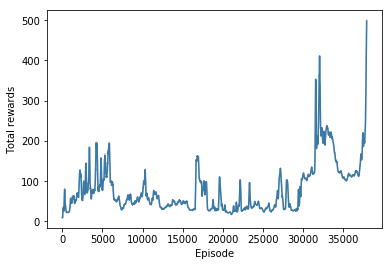

In [27]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

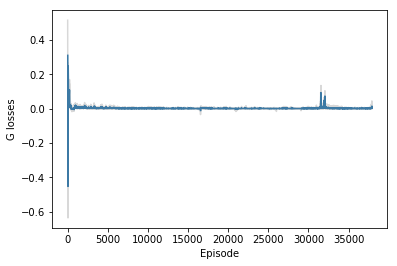

In [33]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

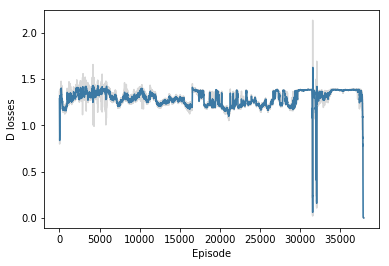

In [34]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.